In [1]:
# import libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List
from datetime import datetime
import json

from sklearn.cluster import KMeans
import jenkspy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Functions

In [2]:
def get_file(file_path: str) -> pd.DataFrame:
    """
    Reads csv file in standardized format.

    :param file_path: str of file path
    :returns: df containing data
    """
    
    df = pd.read_csv(
            file_path,
            sep=';',
            encoding='utf-8',
            na_values='',
            low_memory=False,
            decimal=','
            )

    return df


def woe(df,varcat):
    
    target = 'fraud'
    
    data = df.copy()
    
    data = pd.crosstab(data[varcat], data[target]).rename_axis(None, axis=1)
    
    data['total'] = data.sum(axis=1)
    
    data['porc_N'] = round(data['N']/data['total']*100,4)
    data['porc_Y'] = round(data['Y']/data['total']*100,4)
    
    data['distrib_N'] = data['N']/df[target].value_counts()['N']
    data['distrib_Y'] = data['Y']/df[target].value_counts()['Y']

    data['porc_total'] = round(data['total']/data['total'].sum()*100,4)
    
    np.seterr(divide='ignore')
    
    data['woe'] = round(np.log(data['distrib_N']/data['distrib_Y'])*100,4)
    
    data.drop(['distrib_N','distrib_Y'],axis=1,inplace=True)
    
    data = data.sort_values(by='woe',ascending=True)
    
    return data


def categorical(df: pd.DataFrame, dict_categorias: Dict[str, List[str]]) -> pd.DataFrame:
    
    for key in dict_categorias:
        
        df[key] = pd.Categorical(
                                 df[key],
                                 dict_categorias[key]
                                )
    
    return df

In [3]:
# Reading the data

keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data')+'\\train.csv'

df_total = get_file(path)

In [4]:
print(df_total.shape)
df_total.head()

(55463, 78)


claim_id fraud  claim_amount  claim_date_registered  claim_date_occured  \
0     10000     N       4895.00               20170101            20161229   
1     10001     N       3249.81               20170101            20161223   
2     10002     N       3242.89               20170101            20161228   
3     10003     N       2687.00               20170101            20161228   
4     10004     N       2084.45               20170101            20161229   

   claim_time_occured  claim_postal_code       claim_cause claim_liable  \
0                 NaN               2018  traffic accident            Y   
1                 NaN               8820  traffic accident            N   
2                 NaN               1831  traffic accident            Y   
3                 NaN               2610  traffic accident            Y   
4                 NaN               1210  traffic accident            Y   

   claim_num_injured  claim_num_third_parties  claim_num_vehicles  \
0                  1                        1                   2   
1                  0                        0                   1   
2                  0                        1                   2   
3                  0                        1                   3   
4                  0                        1                   3   

  claim_police claim_alcohol  claim_language  \
0            Y           NaN             2.0   
1            N           NaN             2.0   
2            N           NaN             2.0   
3            N           NaN             2.0   
4            N           NaN             1.0   

                              claim_vehicle_id claim_vehicle_brand  \
0  MDk5NTBkZjRmMDEwZDBjNWM4NmZjZGRkZjA5NjBlMjQ                 NaN   
1                                          NaN                 NaN   
2  YWRjY2RjYmQzMWZiNmQ0ZTUzNWY0MzE1OTQzOWNlMjk              TOYOTA   
3  ZjQ1MzlmNzc0NTBiOWIwZjMwMzliYzIwYTFjMmQ5N2I             PEUGEOT   
4  NjQ2MDEzZWM2YjQzYzI4ZTdhYTlkZDhlZTJhNWY4YzI          MITSUBISHI   

  claim_vehicle_type  claim_vehicle_date_inuse  claim_vehicle_cyl  \
0                car                  200803.0              998.0   
1                car                  201402.0                NaN   
2                van                  200406.0             3000.0   
3                car                  200006.0             1868.0   
4                car                  200809.0             1499.0   

  claim_vehicle_load  claim_vehicle_fuel_type  claim_vehicle_power  \
0               1.25                      1.0                 51.0   
1                NaN                      1.0                  NaN   
2               3.30                      1.0                175.0   
3               1.59                      2.0                 51.0   
4               1.46                      1.0                 80.0   

                              policy_holder_id  policy_holder_postal_code  \
0  MDkzNDEwOTgwZjg4NTM5MzdjOWJiZTgzMGM1ZTMzZWY                     2660.0   
1  ZTI3MGIyZTg2MjEzOTk3OThhMzc1NzdmMTQ3NzYxZTk                     1730.0   
2  NjllOGVkYjU4N2ZmZmNhZjk0NjA3NTNjODgxMDAzNmU                     9200.0   
3  ODA1ODBiZGExOWI2MDU5ODJhNDRmNTBhMmU2ZDAxMDM                     2610.0   
4  NjlhYjNjNmRkNDVkYzY1MjhmMTRlNDQ4YjQzYzNkMWE                     7340.0   

  policy_holder_form  policy_holder_year_birth policy_holder_country  \
0                  F                    1981.0                     B   
1                  M                    1986.0                     B   
2                  M                    1971.0                     B   
3                  M                    1945.0                     B   
4                  F                    1984.0                     B   

  policy_holder_expert_id                                    driver_id  \
0                     NaN  MDkzNDEwOTgwZjg4NTM5MzdjOWJiZTgzMGM1ZTMzZWY   
1                     NaN  ZTI3MGIyZTg2MjEzOTk3OThhMzc1NzdmMTQ3NzYxZTk   
2   

In [5]:
df_total.loc[:,['claim_date_registered','policy_date_start','policy_date_next_expiry','policy_date_last_renewed']].head()

claim_date_registered  policy_date_start  policy_date_next_expiry  \
0               20170101           201604.0                 201704.0   
1               20170101                NaN                      NaN   
2               20170101           200704.0                 201704.0   
3               20170101           199808.0                 201708.0   
4               20170101           200608.0                 201708.0   

   policy_date_last_renewed  
0                  201704.0  
1                       NaN  
2                  201704.0  
3                  201708.0  
4                  201708.0

In [6]:
print(df_total[df_total['policy_date_next_expiry']==df_total['policy_date_last_renewed']].shape)
print(df_total[df_total['policy_date_next_expiry']!=df_total['policy_date_last_renewed']].shape)

(46312, 78)
(9151, 78)


In [7]:
print(df_total.loc[df_total['policy_date_next_expiry']!=df_total['policy_date_last_renewed'],
                   'policy_date_next_expiry'].isna().sum())
print(df_total.loc[df_total['policy_date_next_expiry']!=df_total['policy_date_last_renewed'],
                   'policy_date_last_renewed'].isna().sum())

9151
9151


In [8]:
# Type of data

df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55463 entries, 0 to 55462
Data columns (total 78 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   claim_id                    55463 non-null  int64  
 1   fraud                       55463 non-null  object 
 2   claim_amount                55463 non-null  float64
 3   claim_date_registered       55463 non-null  int64  
 4   claim_date_occured          55463 non-null  int64  
 5   claim_time_occured          6453 non-null   float64
 6   claim_postal_code           55463 non-null  int64  
 7   claim_cause                 55463 non-null  object 
 8   claim_liable                55463 non-null  object 
 9   claim_num_injured           55463 non-null  int64  
 10  claim_num_third_parties     55463 non-null  int64  
 11  claim_num_vehicles          55463 non-null  int64  
 12  claim_police                55463 non-null  object 
 13  claim_alcohol               908

In [9]:
# Getting missing

cols = df_total.columns

temp = pd.DataFrame()

for col in cols:
    temp_count = pd.DataFrame([[col,round(df_total[col].isna().sum()/df_total.shape[0]*100,2)]],
                              columns=['variable','missing'])
    temp = temp.append(temp_count)

temp = pd.DataFrame(temp).sort_values(by=['missing'],ascending=False).reset_index(drop=True)
temp

variable  missing
0      third_party_3_expert_id   100.00
1     third_party_3_year_birth    99.98
2     third_party_3_vehicle_id    99.97
3   third_party_3_vehicle_type    99.96
4    third_party_3_postal_code    99.95
5             third_party_3_id    99.95
6      third_party_2_expert_id    99.95
7           third_party_3_form    99.95
8        third_party_3_country    99.95
9        third_party_3_injured    99.95
10           repair_year_birth    99.84
11     third_party_1_expert_id    98.82
12               claim_alcohol    98.36
13    third_party_2_year_birth    97.08
14    third_party_2_vehicle_id    94.83
15  third_party_2_vehicle_type    93.76
16   third_party_2_postal_code    92.62
17          third_party_2_form    92.39
18       third_party_2_country    92.39
19       third_party_2_injured    92.39
20            third_party_2_id    92.39
21          claim_time_occured    88.37
22     policy_holder_expert_id    82.73
23    third_party_1_year_birth    82.20
24            driver_expert_id    75.22
25          repair_postal_code    54.34
26              repair_country    54.30
27                 repair_form    54.30
28                   repair_id    54.30
29        policy_coverage_1000    51.24
30    third_party_1_vehicle_id    34.10
31  third_party_1_vehicle_type    28.92
32   third_party_1_postal_code    26.77
33       third_party_1_country    24.78
34          third_party_1_form    24.78
35            third_party_1_id    24.78
36       third_party_1_injured    24.78
37           driver_year_birth    22.30
38            claim_vehicle_id    18.62
39           driver_vehicle_id    18.60
40         claim_vehicle_brand    17.91
41          policy_premium_100    16.52
42    policy_date_last_renewed    16.50
43     policy_date_next_expiry    16.50
44           policy_date_start    16.50
45         claim_vehicle_power    16.49
46          claim_vehicle_load    15.54
47    policy_holder_year_birth     9.70
48           claim_vehicle_cyl     8.87
49    claim_vehicle_date_inuse     1.11
50     claim_vehicle_fuel_type     0.79
51          claim_vehicle_type     0.28
52   policy_holder_postal_code     0.20
53          driver_postal_code     0.13
54              claim_language     0.08
55          policy_num_changes     0.00
56           policy_num_claims     0.00
57                  repair_sla     0.00
58                    claim_id     0.00
59                       fraud     0.00
60     claim_num_third_parties     0.00
61                claim_amount     0.00
62       claim_date_registered     0.00
63          claim_date_occured     0.00
64           claim_postal_code     0.00
65                 claim_cause     0.00
66                claim_liable     0.00
67           claim_num_injured     0.00
68          claim_num_vehicles     0.00
69              driver_injured     0.00
70                claim_police     0.00
71            policy_holder_id     0.00
72          policy_holder_form     0.00
73       policy_holder_country     0.00
74                   driver_id     0.00
75                 driver_form     0.00
76              driver_country     0.00
77        policy_coverage_type     0.00

In [10]:
temp.to_clipboard(index=False,header=True)

In [11]:
len(df_total.claim_id.unique())

55463

In [12]:
# Distribution target variable

round(df_total['fraud'].value_counts()/df_total.shape[0]*100,2)

N    99.44
Y     0.56
Name: fraud, dtype: float64

In [13]:
df_total['fraud'].value_counts()

N    55155
Y      308
Name: fraud, dtype: int64

In [14]:
#temp[temp['variable']=='claim_num_third_parties']

In [15]:
cols_drop = [col for col in df_total.columns if ('id' in col) or ('date' in col) or ('postal' in col)
                                                or ('time' in col) or ('language' in col) or ('fuel_type' in col)
                                                or ('birth' in col)]

In [16]:
prueba = df_total.copy()
prueba.drop(cols_drop,axis=1,inplace=True)

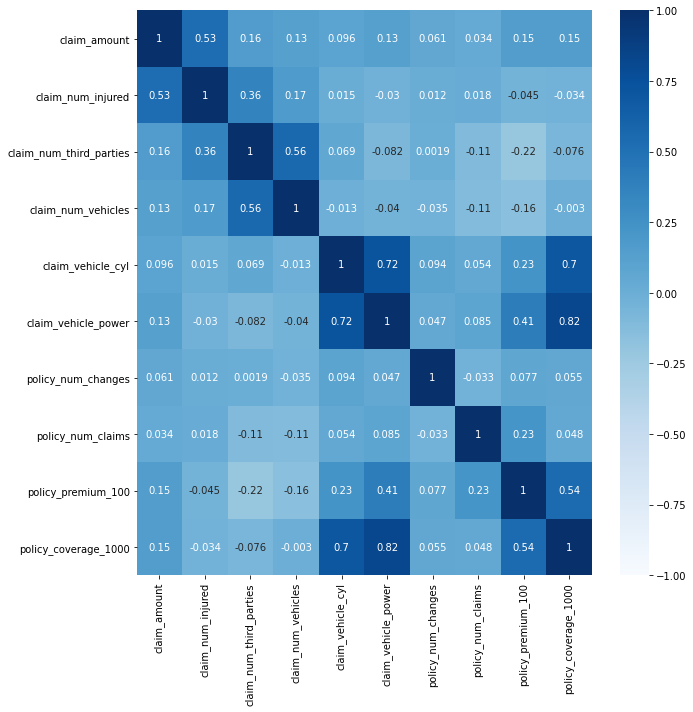

In [17]:
corr_mat = prueba.corr()

plt.figure(figsize=(10, 10))

sns.heatmap(
        corr_mat,
        vmax=1,
        vmin=-1,
        square=False,
        annot=True,
        cmap="Blues" #PiYG
        )

plt.tight_layout()

# Univariate

In [18]:
var = "fraud"

In [19]:
df_temp = pd.DataFrame(round(df_total[var].value_counts()/df_total.shape[0]*100,2)).reset_index(drop=False)
df_temp.rename(columns={var:'freq',
                        'index':var},inplace=True)
df_temp

fraud   freq
0     N  99.44
1     Y   0.56

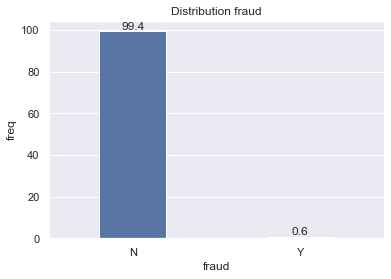

In [20]:
sns.set()
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=var, y='freq', data=df_temp)

widthbars = [0.4, 0.4]

for p,newwidth in zip(ax.patches,widthbars):
    
    x = p.get_x()
    width = p.get_width()
    centre = x + width/2.
    p.set_x(centre - newwidth/2.)
    p.set_width(newwidth)
    
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), 
                   textcoords = 'offset points',
                   size=12)

plt.xlabel(var, size=12)
plt.ylabel("freq", size=12)
plt.title('Distribution '+var, size=12)

plt.show()

In [21]:
#############

In [22]:
var = 'claim_date_registered'

In [23]:
df_copy = df_total.copy()

In [24]:
print(df_copy[var].min())
print(df_copy[var].max())

20170101
20171231


In [25]:
df_copy['m_claim_date_registered'] = pd.to_datetime(df_total[var], format='%Y%m%d').dt.month
df_copy['d_claim_date_registered'] = pd.to_datetime(df_total[var], format='%Y%m%d').dt.day

df_copy['d_claim_date_registered'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19,
       20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 11, 18, 25],
      dtype=int64)

In [26]:
pd.crosstab(df_copy['m_claim_date_registered'], df_copy['fraud'])

fraud                       N   Y
m_claim_date_registered          
1                        4642  23
2                        4266  28
3                        4874  21
4                        4805  24
5                        4372  18
6                        5268  28
7                        4300  25
8                        3789  18
9                        4724  30
10                       5049  33
11                       4339  22
12                       4727  38

In [27]:
data = pd.crosstab(df_copy.loc[df_copy['fraud']=='Y','m_claim_date_registered'], 
                   df_copy.loc[df_copy['fraud']=='Y','d_claim_date_registered'])

In [28]:
data

d_claim_date_registered  1   2   3   4   5   6   7   8   9   10  11  12  13  \
m_claim_date_registered                                                       
1                         0   0   0   0   0   3   1   0   2   0   0   0   1   
2                         0   1   4   4   0   1   0   0   1   2   1   1   2   
3                         0   0   3   2   0   0   0   0   1   1   2   1   1   
4                         2   1   0   0   0   0   3   0   2   0   0   0   0   
5                         0   0   0   2   1   0   0   0   0   0   2   2   0   
6                         2   3   1   0   0   0   0   2   1   0   0   2   0   
7                         0   2   1   0   0   1   1   0   1   0   0   0   3   
8                         0   0   2   2   0   1   0   0   0   0   0   0   1   
9                         1   0   1   1   0   0   0   2   2   1   1   0   0   
10                        0   1   0   0   3   1   2   2   2   0   0   0   3   
11                        0   1   1   0   4   1   0   0   3   2   0   0   1   
12                        2   1   1   2   0   0   1   7   3   2   2   0   0   

d_claim_date_registered  14  15  16  17  18  19  20  21  22  23  24  25  26  \
m_claim_date_registered                                                       
1                         4   2   1   0   0   1   2   1   2   1   0   0   0   
2                         0   0   2   2   3   0   1   0   0   0   0   0   1   
3                         0   0   0   2   1   1   0   0   0   0   5   0   0   
4                         2   0   0   1   0   0   1   2   2   0   0   0   0   
5                         0   0   0   0   1   5   1   2   0   0   0   0   1   
6                         0   5   4   2   0   0   0   0   0   2   1   0   0   
7                         2   3   1   0   0   0   0   0   1   3   1   0   0   
8                         1   0   0   0   2   1   1   1   0   0   0   1   0   
9                         4   3   1   0   1   0   0   3   1   0   0   2   0   
10                        2   1   0   0   0   2   1   3   4   1   0   0   1   
11                        0   0   0   0   0   0   1   0   0   2   1   2   1   
12                        2   2   0   2   0   0   0   6   2   1   0   0   0   

d_claim_date_registered  27  28  29  30  31  
m_claim_date_registered                      
1                         0   0   1   1   0  
2                         2   0   0   0   0  
3                         0   0   0   0   1  
4                         1   5   2   0   0  
5                         1   0   0   0   0  
6                         0   0   1   2   0  
7                         2   0   1   0   2  
8                         0   3   0   0   2  
9                         0   2   1   3   0  
10                        2   0   1   1   0  
11                        1   0   0   1   0  
12                        0   1   1   0   0

In [29]:
#############

In [30]:
var = 'claim_date_occured'

In [31]:
df_copy = df_total.copy()

In [32]:
print(df_copy[var].min())
print(df_copy[var].max())

20100316
20171230


In [33]:
df_copy['m_claim_date_occured'] = pd.to_datetime(df_total[var], format='%Y%m%d').dt.month
df_copy['d_claim_date_occured'] = pd.to_datetime(df_total[var], format='%Y%m%d').dt.day

df_copy['d_claim_date_occured'].unique()

array([29, 23, 28, 30, 27, 18,  4, 22, 24, 21, 25, 12, 20,  9, 26, 14,  8,
        1, 13, 15, 17,  2, 31, 19,  7,  5, 16, 10,  3, 11,  6],
      dtype=int64)

In [34]:
#############

In [35]:
var1 = 'claim_date_registered'
var2 = 'claim_date_occured'

In [36]:
new = pd.to_datetime(df_total[var1], format='%Y%m%d')-pd.to_datetime(df_total[var2], format='%Y%m%d')
df_total['diff_days_claim_reg_ocu'] = new.map(lambda x: x.days)

In [37]:
var = 'diff_days_claim_reg_ocu'

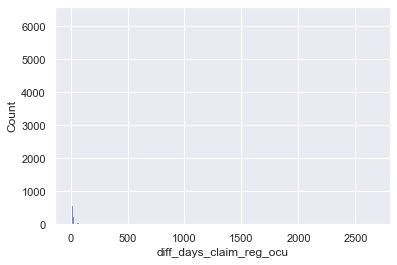

In [38]:
sns.histplot(data=df_total, x=var)
plt.show()

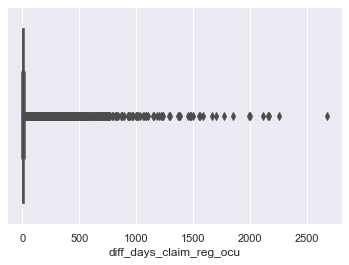

In [39]:
sns.boxplot(x=df_total[var])
plt.show()

In [40]:
df_total[var].quantile([0, 0.05, .1, .25, .5, .75, 0.8, 0.85, 0.9, .95, 1])

0.00       0.0
0.05       1.0
0.10       1.0
0.25       3.0
0.50       5.0
0.75      11.0
0.80      14.0
0.85      19.0
0.90      28.0
0.95      53.0
1.00    2671.0
Name: diff_days_claim_reg_ocu, dtype: float64

274


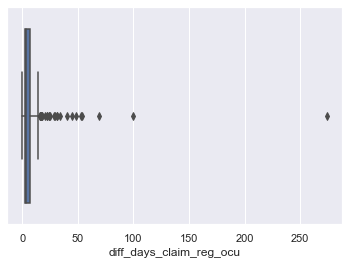

In [41]:
print(max(df_total.loc[df_total['fraud']=='Y',var]))

sns.boxplot(x=df_total.loc[df_total['fraud']=='Y',var])
plt.show()

In [42]:
df_total.loc[df_total['fraud']=='Y',var].quantile([0, 0.05, .1, .25, .5, .75, 0.8, 0.85, 0.9,.95, 1])

0.00      0.0
0.05      0.0
0.10      1.0
0.25      2.0
0.50      3.0
0.75      7.0
0.80      8.0
0.85     11.0
0.90     13.0
0.95     23.3
1.00    274.0
Name: diff_days_claim_reg_ocu, dtype: float64

In [43]:
### Possible rule or policy: Juts focus on claims with a value <= 23 in diff_days_claim_reg_ocu'
### because the 95% of the frauds happened in that interval of time

In [44]:
df_total.loc[(df_total['fraud']=='Y') &
             (df_total[var]>=23),var].value_counts().sum()

16

In [45]:
df_total.loc[(df_total['fraud']=='Y') &
             (df_total[var]>=23),'claim_amount'].sum()

61382.979999999996

2671


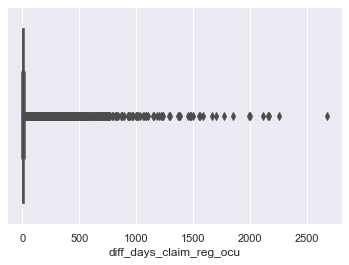

In [46]:
print(max(df_total.loc[df_total['fraud']=='N',var]))

sns.boxplot(x=df_total.loc[df_total['fraud']=='N',var])
plt.show()

In [47]:
df_total.loc[df_total['fraud']=='N',var].quantile([0, 0.05, .1, .25, .5, .75, 0.8, 0.85, 0.9,.95, 1])

0.00       0.0
0.05       1.0
0.10       1.0
0.25       3.0
0.50       5.0
0.75      11.0
0.80      14.0
0.85      19.0
0.90      28.0
0.95      53.0
1.00    2671.0
Name: diff_days_claim_reg_ocu, dtype: float64

In [48]:
df_total.loc[(df_total['fraud']=='N') &
             (df_total[var]>=23),var].value_counts().sum()

6901

In [49]:
df_total.loc[(df_total['fraud']=='N') &
             (df_total[var]>=23),'claim_amount'].sum()

11354198.34

In [50]:
df_total[var].quantile([0, 0.05, .1, .25, .5, .75, 0.8, 0.85, 0.9,.95, 1])

0.00       0.0
0.05       1.0
0.10       1.0
0.25       3.0
0.50       5.0
0.75      11.0
0.80      14.0
0.85      19.0
0.90      28.0
0.95      53.0
1.00    2671.0
Name: diff_days_claim_reg_ocu, dtype: float64

In [51]:
q_95 = df_total[var].quantile(.95)
print(q_95)

df_total[var] = np.where(df_total[var]>=int(q_95),int(q_95),df_total[var])

53.0


In [52]:
df_total.drop(var2,axis=1,inplace=True)
print(df_total.shape)
df_total.head()

(55463, 78)


claim_id fraud  claim_amount  claim_date_registered  claim_time_occured  \
0     10000     N       4895.00               20170101                 NaN   
1     10001     N       3249.81               20170101                 NaN   
2     10002     N       3242.89               20170101                 NaN   
3     10003     N       2687.00               20170101                 NaN   
4     10004     N       2084.45               20170101                 NaN   

   claim_postal_code       claim_cause claim_liable  claim_num_injured  \
0               2018  traffic accident            Y                  1   
1               8820  traffic accident            N                  0   
2               1831  traffic accident            Y                  0   
3               2610  traffic accident            Y                  0   
4               1210  traffic accident            Y                  0   

   claim_num_third_parties  claim_num_vehicles claim_police claim_alcohol  \
0                        1                   2            Y           NaN   
1                        0                   1            N           NaN   
2                        1                   2            N           NaN   
3                        1                   3            N           NaN   
4                        1                   3            N           NaN   

   claim_language                             claim_vehicle_id  \
0             2.0  MDk5NTBkZjRmMDEwZDBjNWM4NmZjZGRkZjA5NjBlMjQ   
1             2.0                                          NaN   
2             2.0  YWRjY2RjYmQzMWZiNmQ0ZTUzNWY0MzE1OTQzOWNlMjk   
3             2.0  ZjQ1MzlmNzc0NTBiOWIwZjMwMzliYzIwYTFjMmQ5N2I   
4             1.0  NjQ2MDEzZWM2YjQzYzI4ZTdhYTlkZDhlZTJhNWY4YzI   

  claim_vehicle_brand claim_vehicle_type  claim_vehicle_date_inuse  \
0                 NaN                car                  200803.0   
1                 NaN                car                  201402.0   
2              TOYOTA                van                  200406.0   
3             PEUGEOT                car                  200006.0   
4          MITSUBISHI                car                  200809.0   

   claim_vehicle_cyl claim_vehicle_load  claim_vehicle_fuel_type  \
0              998.0               1.25                      1.0   
1                NaN                NaN                      1.0   
2             3000.0               3.30                      1.0   
3             1868.0               1.59                      2.0   
4             1499.0               1.46                      1.0   

   claim_vehicle_power                             policy_holder_id  \
0                 51.0  MDkzNDEwOTgwZjg4NTM5MzdjOWJiZTgzMGM1ZTMzZWY   
1                  NaN  ZTI3MGIyZTg2MjEzOTk3OThhMzc1NzdmMTQ3NzYxZTk   
2                175.0  NjllOGVkYjU4N2ZmZmNhZjk0NjA3NTNjODgxMDAzNmU   
3                 51.0  ODA1ODBiZGExOWI2MDU5ODJhNDRmNTBhMmU2ZDAxMDM   
4                 80.0  NjlhYjNjNmRkNDVkYzY1MjhmMTRlNDQ4YjQzYzNkMWE   

   policy_holder_postal_code policy_holder_form  policy_holder_year_birth  \
0                     2660.0                  F                    1981.0   
1                     1730.0                  M                    1986.0   
2                     9200.0                  M                    1971.0   
3                     2610.0                  M                    1945.0   
4                     7340.0                  F                    1984.0   

  policy_holder_country policy_holder_expert_id  \
0                     B                     NaN   
1                     B                     NaN   
2                     B                     NaN   
3                     B                     NaN   
4                     B                     NaN   

                                     driver_id  driver_postal_code  \
0  MDkzNDEwOTgwZjg4NTM5MzdjOWJiZTgzMGM1ZTMzZWY              2660.0   
1  ZTI3MGIyZTg2MjEzOTk3OThhMzc1NzdmMTQ3NzYxZTk              17

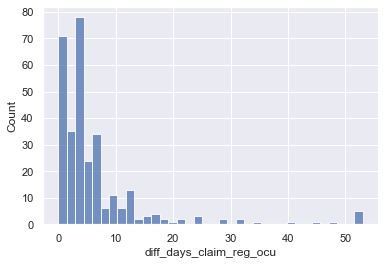

In [53]:
sns.histplot(x=df_total.loc[(df_total['fraud']=='Y'),var])
plt.show()

In [54]:
max(df_total.loc[df_total['fraud']=='Y',var])

53

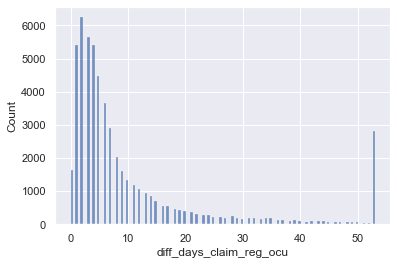

In [55]:
sns.histplot(x=df_total.loc[(df_total['fraud']=='N'),var])
plt.show()

In [56]:
max(df_total.loc[df_total['fraud']=='N',var])

53

In [57]:
var

'diff_days_claim_reg_ocu'

In [58]:
data = woe(df_total,var)

print(data.shape)
data.head()

(54, 7)


N   Y  total   porc_N  porc_Y  porc_total  \
diff_days_claim_reg_ocu                                                 
48                         61   1     62  98.3871  1.6129      0.1118   
0                        1632  26   1658  98.4318  1.5682      2.9894   
45                         76   1     77  98.7013  1.2987      0.1388   
31                        182   2    184  98.9130  1.0870      0.3318   
40                        101   1    102  99.0196  0.9804      0.1839   

                              woe  
diff_days_claim_reg_ocu            
48                      -107.6929  
0                       -104.8338  
45                       -85.7070  
31                       -67.6943  
40                       -57.2682

In [59]:
data[data['woe']==np.inf].shape[0]

24

In [60]:
data.to_clipboard(index=True,header=True)

In [61]:
df_total.set_index(var,inplace=True)

In [62]:
data = df_total.join(data[['woe']])
data.reset_index(inplace=True)
print(data.shape)
data.head()

(55463, 79)


diff_days_claim_reg_ocu  claim_id fraud  claim_amount  \
0                        0     10043     N       4017.29   
1                        0     10051     N       3272.49   
2                        0     10056     N       2994.35   
3                        0     10164     N       8771.20   
4                        0     10179     N       4617.40   

   claim_date_registered  claim_time_occured  claim_postal_code  \
0               20170102              1030.0               9820   
1               20170102              1600.0               3090   
2               20170102              1200.0               9200   
3               20170105                 NaN               3900   
4               20170105              1000.0               7140   

        claim_cause claim_liable  claim_num_injured  claim_num_third_parties  \
0  traffic accident            N                  0                        1   
1  traffic accident            Y                  0                        2   
2  traffic accident            Y                  0                        1   
3             theft            N                  0                        0   
4             theft            N                  0                        0   

   claim_num_vehicles claim_police claim_alcohol  claim_language  \
0                   4            N           NaN             2.0   
1                   4            N           NaN             1.0   
2                   4            N           NaN             2.0   
3                   2            N           NaN             2.0   
4                   2            Y           NaN             1.0   

                              claim_vehicle_id claim_vehicle_brand  \
0  NTA1ZmQ1YjY4OWMyY2EzMmM1MTNjODc0ZTljODg0ZDU                FORD   
1  MGJkZGRlNjkwOGYxZmFlNGQ0YWY4MjliNGI3NTNkNGE          VOLKSWAGEN   
2  ZTRkNTY3YWViMjFmMDNiNmM1YjA2MTlmZmQ2MGFkODE          VOLKSWAGEN   
3  OTEyYWFmN2FjZDVhZGFiMzA0ZjlkM2E2ZWI3YzlhYjQ                 BMW   
4  NDllMjZmZDhiMDViMjBjNjk3Y2EzMGRiMjRhYWNhY2M          VOLKSWAGEN   

  claim_vehicle_type  claim_vehicle_date_inuse  claim_vehicle_cyl  \
0                car                  201403.0             1242.0   
1                car                  200205.0             1198.0   
2                car                  201409.0             1197.0   
3                car                  201107.0             1995.0   
4                car                  199912.0             1984.0   

  claim_vehicle_load  claim_vehicle_fuel_type  claim_vehicle_power  \
0               1.32                      1.0                 51.0   
1               1.55                      1.0                 47.0   
2               2.00                      1.0                 77.0   
3               2.03                      2.0                105.0   
4               1.78                      1.0                 85.0   

                              policy_holder_id  policy_holder_postal_code  \
0  N2YyYTA0ZDkzNWY5MWQyN2QyNzFlMmQyZjQ0YzNhZmE                     9820.0   
1  ZDY4N2Q1NTViMzI4ODMxN2Y4ZWE4YWY5MzI3Yjc2ZGM                     1050.0   
2  ZjFhMmQ3NzQ4MzRlMGIzODk2MDhkNWEyNTJjNjA0MTc                     9200.0   
3  OTQ0NzQzOWE2MTM5OTkyZjY4MjNiMzE5MWY2ZGY5ZTQ                     3900.0   
4  YjI5ZWMxZDljNWE3Njk1MDFmZTVkNmNkMjU5NzU0NmI                     7140.0   

  policy_holder_form  policy_holder_year_birth policy_holder_country  \
0                  F                    1945.0                     B   
1                  F                    1984.0                     B   
2                  M                    1955.0                     B   
3                  M                    1967.0                     B   
4                  F                    1958.0                     B   

                       policy_holder_expert_id  \
0                                          NaN   
1                                          NaN   
2                                          NaN

In [63]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
diff_days_claim_reg_ocu                                                     
3                           13547897.24       389636.36                19.30
1                           14711791.17       350383.65                17.35
4                           12997921.35       242254.62                12.00
0                            4752676.16       230989.14                11.44
2                           15770921.56       191789.12                 9.50

In [64]:
### take into account that in the first five days of difference between the claim ocurred and it is registered the 70%
### of the amount of fraud claims is collected

In [65]:
table.to_clipboard(index=True,header=True)

In [66]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [67]:
data[data['woe_'+var]==np.inf].shape[0]

0

In [68]:
data[var].dtype

dtype('int64')

In [69]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [70]:
temp.index.dtype

dtype('int64')

In [71]:
dict_woe = temp.to_dict()

In [72]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [73]:
len(dict_woe)

1

In [74]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [75]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [76]:
columns_f = [col for col in data.columns if (var not in col)]+['woe_'+var]+[var]
print(len(columns_f))
print(data.shape)

data = data.reindex(columns=columns_f)

80
(55463, 80)


In [77]:
data.drop('woe',axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55463, 79)


claim_id fraud  claim_amount  claim_date_registered  claim_time_occured  \
0     10043     N       4017.29               20170102              1030.0   
1     10051     N       3272.49               20170102              1600.0   
2     10056     N       2994.35               20170102              1200.0   
3     10164     N       8771.20               20170105                 NaN   
4     10179     N       4617.40               20170105              1000.0   

   claim_postal_code       claim_cause claim_liable  claim_num_injured  \
0               9820  traffic accident            N                  0   
1               3090  traffic accident            Y                  0   
2               9200  traffic accident            Y                  0   
3               3900             theft            N                  0   
4               7140             theft            N                  0   

   claim_num_third_parties  claim_num_vehicles claim_police claim_alcohol  \
0                        1                   4            N           NaN   
1                        2                   4            N           NaN   
2                        1                   4            N           NaN   
3                        0                   2            N           NaN   
4                        0                   2            Y           NaN   

   claim_language                             claim_vehicle_id  \
0             2.0  NTA1ZmQ1YjY4OWMyY2EzMmM1MTNjODc0ZTljODg0ZDU   
1             1.0  MGJkZGRlNjkwOGYxZmFlNGQ0YWY4MjliNGI3NTNkNGE   
2             2.0  ZTRkNTY3YWViMjFmMDNiNmM1YjA2MTlmZmQ2MGFkODE   
3             2.0  OTEyYWFmN2FjZDVhZGFiMzA0ZjlkM2E2ZWI3YzlhYjQ   
4             1.0  NDllMjZmZDhiMDViMjBjNjk3Y2EzMGRiMjRhYWNhY2M   

  claim_vehicle_brand claim_vehicle_type  claim_vehicle_date_inuse  \
0                FORD                car                  201403.0   
1          VOLKSWAGEN                car                  200205.0   
2          VOLKSWAGEN                car                  201409.0   
3                 BMW                car                  201107.0   
4          VOLKSWAGEN                car                  199912.0   

   claim_vehicle_cyl claim_vehicle_load  claim_vehicle_fuel_type  \
0             1242.0               1.32                      1.0   
1             1198.0               1.55                      1.0   
2             1197.0               2.00                      1.0   
3             1995.0               2.03                      2.0   
4             1984.0               1.78                      1.0   

   claim_vehicle_power                             policy_holder_id  \
0                 51.0  N2YyYTA0ZDkzNWY5MWQyN2QyNzFlMmQyZjQ0YzNhZmE   
1                 47.0  ZDY4N2Q1NTViMzI4ODMxN2Y4ZWE4YWY5MzI3Yjc2ZGM   
2                 77.0  ZjFhMmQ3NzQ4MzRlMGIzODk2MDhkNWEyNTJjNjA0MTc   
3                105.0  OTQ0NzQzOWE2MTM5OTkyZjY4MjNiMzE5MWY2ZGY5ZTQ   
4                 85.0  YjI5ZWMxZDljNWE3Njk1MDFmZTVkNmNkMjU5NzU0NmI   

   policy_holder_postal_code policy_holder_form  policy_holder_year_birth  \
0                     9820.0                  F                    1945.0   
1                     1050.0                  F                    1984.0   
2                     9200.0                  M                    1955.0   
3                     3900.0                  M                    1967.0   
4                     7140.0                  F                    1958.0   

  policy_holder_country                      policy_holder_expert_id  \
0                     B                                          NaN   
1                     B                                          NaN   
2                     B                                          NaN   
3                     B                                          NaN   
4                     B  ZDU4ZDExMTNhYmM4YmNlY2QzZmNjOWJjMDRjMGNmZmQ   

                                     driver_id  driver_postal_code  \
0  Yjl

In [78]:
#############

In [79]:
var = 'claim_time_occured'

In [80]:
df_total.loc[(~df_total[var].isna()),'fraud'].value_counts()

N    6402
Y      51
Name: fraud, dtype: int64

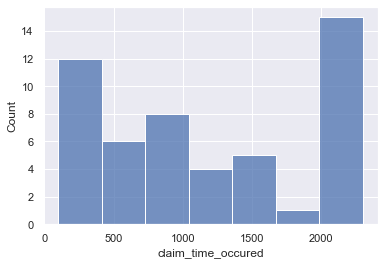

In [81]:
sns.histplot(x=df_total.loc[(~df_total[var].isna()) &
             (df_total['fraud']=='Y'),var])
plt.show()

In [82]:
df_total.drop(var,axis=1,inplace=True)

In [83]:
#############

In [84]:
var = 'claim_postal_code'

In [85]:
len(df_total[var].unique())

1060

In [86]:
data = woe(df_total,var)

print(data.shape)
data.head()

(1060, 7)


N  Y  total  porc_N  porc_Y  porc_total       woe
claim_postal_code                                                   
8431               0  1      1     0.0   100.0      0.0018      -inf
3746               0  1      1     0.0   100.0      0.0018      -inf
5562               1  1      2    50.0    50.0      0.0036 -518.7803
7542               1  1      2    50.0    50.0      0.0036 -518.7803
8956               3  1      4    75.0    25.0      0.0072 -408.9191

In [87]:
data[data['woe']==np.inf].shape[0]

850

In [88]:
data.to_clipboard(index=True,header=True)

In [89]:
df_total.set_index(var,inplace=True)

In [90]:
data = df_total.join(data[['woe']])
data.reset_index(inplace=True)
print(data.shape)
data.head()

(55463, 79)


claim_postal_code  claim_id fraud  claim_amount  claim_date_registered  \
0               1000     10774     N       2528.25               20170107   
1               1000     15827     N       3906.57               20170209   
2               1000     17749     N       3180.36               20170220   
3               1000     18537     N        567.00               20170225   
4               1000     20141     N       3775.46               20170309   

        claim_cause claim_liable  claim_num_injured  claim_num_third_parties  \
0           windows            N                  0                        0   
1  traffic accident            N                  0                        1   
2  traffic accident            N                  0                        1   
3  traffic accident            Y                  0                        1   
4  traffic accident            N                  0                        1   

   claim_num_vehicles claim_police claim_alcohol  claim_language  \
0                   1            N           NaN             2.0   
1                   3            N           NaN             2.0   
2                   3            N           NaN             2.0   
3                   2            N           NaN             1.0   
4                   3            N           NaN             1.0   

                              claim_vehicle_id claim_vehicle_brand  \
0  MmFhNDVlY2VmOTkwZjEzOWFjNjNhMzYxYjMwYjdmZWQ                OPEL   
1  YTM2OWNhYmE3YmFhNTczZjUxMDk2MDU1ZDU3N2MyYWQ          VOLKSWAGEN   
2                                          NaN                FORD   
3  ZDQ1ZDY3ODY3MDBmMDM1NWNmZDBkMzkwOTNjMWZhYTA                SEAT   
4  M2UyYjQ0YWM0ZTZkNGU0OWQ4ZTE3OGJkMzg2ZWJhN2M                AUDI   

  claim_vehicle_type  claim_vehicle_date_inuse  claim_vehicle_cyl  \
0                car                  201102.0             1686.0   
1                car                  201109.0             1598.0   
2                car                  201402.0             1499.0   
3                car                  201304.0             1198.0   
4                car                  200809.0             1968.0   

  claim_vehicle_load  claim_vehicle_fuel_type  claim_vehicle_power  \
0               1.96                      2.0                 81.0   
1               1.87                      2.0                 77.0   
2               1.57                      2.0                 55.0   
3               1.50                      1.0                 51.0   
4               2.08                      2.0                100.0   

                              policy_holder_id  policy_holder_postal_code  \
0  MjliZjg4MjJjY2E3M2M1OWYxOTVjZDA2ZmNhZDYzNGM                     1840.0   
1  NDEzMWJlMDg3ZWM0MTViODFmZTZiMzFkMjFmN2Q2Mzk                     3272.0   
2  MTEyNDFlMjc2MDI2NzQ0MmY0MTUxZDJlNzM0ZTA2NWI                     3890.0   
3  MmJlZWNjYzNmNmQyYzhhMWI2YTZmZGQyYjI2NWY3MjU                     1030.0   
4  NGI0MjRjZjRiOWJmN2RiZTkzMTk2MDA2MWNkZjdmMDM                     4280.0   

  policy_holder_form  policy_holder_year_birth policy_holder_country  \
0                  M                    1965.0                     B   
1                  M                    1986.0                     B   
2                  M                    1985.0                     B   
3                  M                    1985.0                     B   
4                  F                    1985.0                     B   

                       policy_holder_expert_id  \
0                                          NaN   
1  NGE5OGQ4ZDc1NjFjNjg1NTIxZmRjNzI5N2YwY2FhY2M   
2                                          NaN   
3                                          NaN   
4                                          NaN   

                                     driver_id  driver_postal_code  \
0  MjliZjg4MjJjY2E3M2M1OWYxOTVjZDA2ZmNhZDYzNGM              1840.0   
1  NDEzMWJlMDg3ZWM0MTViODFmZTZiMzFkMjFmN2Q2Mzk          

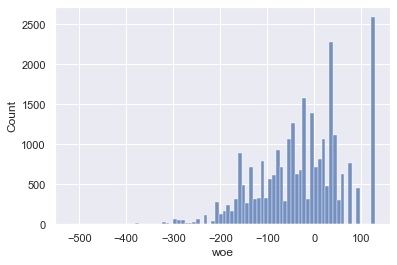

In [91]:
sns.histplot(x=data.loc[(data['woe']!=np.inf) &
                        (data['woe']!=-np.inf),'woe'])
plt.show()

In [92]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
claim_postal_code                                                     
7700                   1290054.50       144643.14                 7.16
1000                   2509401.24        51433.87                 2.55
4430                    167550.30        37917.00                 1.88
2100                    705175.05        36269.53                 1.80
4020                    196102.47        32423.52                 1.61

In [93]:
### take into account the postal code '7700' has the highest percentage of participation of the amount of 
### fraud claims (7.2%)

In [94]:
table.to_clipboard(index=True,header=True)

In [95]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

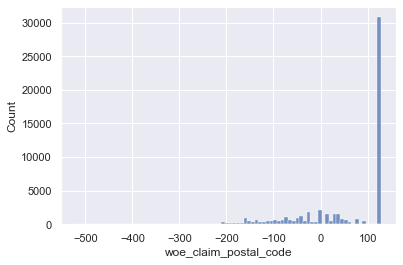

In [96]:
sns.histplot(x=data['woe_'+var])
plt.show()

In [97]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [98]:
data[var].dtype

dtype('int64')

In [99]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [100]:
temp.index.dtype

dtype('int64')

In [101]:
dict_woe.update(temp.to_dict())

In [102]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [103]:
len(dict_woe)

2

In [104]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [105]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [106]:
# data[data[var]==7743].head()

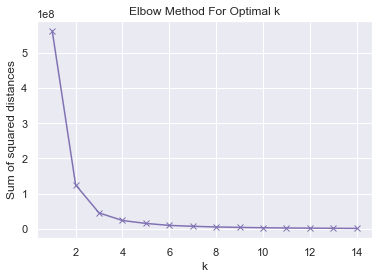

In [107]:
tabla=pd.DataFrame({'woe':data['woe_'+var]})

SEED = 123

#Número de cluster óptimo
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=SEED)
    km = km.fit(tabla)
    sum_of_squared_distances.append(km.inertia_)
#     centroids = km.cluster_centers_
#     print(centroids)

plt.plot(K, sum_of_squared_distances, 'mx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [108]:
km = KMeans(n_clusters=3, random_state=SEED)
km = km.fit(tabla)
km.cluster_centers_
km.labels_

array([2, 2, 2, ..., 1, 1, 1])

In [109]:
breaks = jenkspy.jenks_breaks(data['woe_'+var], nb_class=3)
breaks

[-518.7803, -66.6014, 58.0518, 128.4157]

In [110]:
dict_woe_breaks = {var:breaks}
dict_woe_breaks

{'claim_postal_code': [-518.7803, -66.6014, 58.0518, 128.4157]}

In [111]:
with open(path+'dict_woe_train_breaks.json', 'w') as fp:
    json.dump(dict_woe_breaks, fp)

In [112]:
data['woe_'+var+'_cat'] = pd.cut(data['woe_'+var],
                                 bins=breaks,
                                 labels=['high_fraud', 'medium_fraud', 'low_fraud'],
                                 include_lowest=True)

data['woe_'+var+'_cat'].value_counts(normalize=True)

low_fraud       0.577412
medium_fraud    0.264266
high_fraud      0.158322
Name: woe_claim_postal_code_cat, dtype: float64

In [113]:
data['woe_'+var+'_cat'].value_counts(normalize=False)

low_fraud       32025
medium_fraud    14657
high_fraud       8781
Name: woe_claim_postal_code_cat, dtype: int64

In [114]:
dict_categ = {'woe_claim_postal_code_cat':['low_fraud','medium_fraud','high_fraud']}

data = categorical(data,dict_categ)

In [115]:
# Get dummies
data = pd.get_dummies(data,
                      columns=data.columns[
                                           np.where(data.dtypes == 'category')
                                           ],
                      drop_first=True
                      )

In [116]:
data.drop(['woe',var],axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55463, 80)


claim_id fraud  claim_amount  claim_date_registered       claim_cause  \
0     10774     N       2528.25               20170107           windows   
1     15827     N       3906.57               20170209  traffic accident   
2     17749     N       3180.36               20170220  traffic accident   
3     18537     N        567.00               20170225  traffic accident   
4     20141     N       3775.46               20170309  traffic accident   

  claim_liable  claim_num_injured  claim_num_third_parties  \
0            N                  0                        0   
1            N                  0                        1   
2            N                  0                        1   
3            Y                  0                        1   
4            N                  0                        1   

   claim_num_vehicles claim_police claim_alcohol  claim_language  \
0                   1            N           NaN             2.0   
1                   3            N           NaN             2.0   
2                   3            N           NaN             2.0   
3                   2            N           NaN             1.0   
4                   3            N           NaN             1.0   

                              claim_vehicle_id claim_vehicle_brand  \
0  MmFhNDVlY2VmOTkwZjEzOWFjNjNhMzYxYjMwYjdmZWQ                OPEL   
1  YTM2OWNhYmE3YmFhNTczZjUxMDk2MDU1ZDU3N2MyYWQ          VOLKSWAGEN   
2                                          NaN                FORD   
3  ZDQ1ZDY3ODY3MDBmMDM1NWNmZDBkMzkwOTNjMWZhYTA                SEAT   
4  M2UyYjQ0YWM0ZTZkNGU0OWQ4ZTE3OGJkMzg2ZWJhN2M                AUDI   

  claim_vehicle_type  claim_vehicle_date_inuse  claim_vehicle_cyl  \
0                car                  201102.0             1686.0   
1                car                  201109.0             1598.0   
2                car                  201402.0             1499.0   
3                car                  201304.0             1198.0   
4                car                  200809.0             1968.0   

  claim_vehicle_load  claim_vehicle_fuel_type  claim_vehicle_power  \
0               1.96                      2.0                 81.0   
1               1.87                      2.0                 77.0   
2               1.57                      2.0                 55.0   
3               1.50                      1.0                 51.0   
4               2.08                      2.0                100.0   

                              policy_holder_id  policy_holder_postal_code  \
0  MjliZjg4MjJjY2E3M2M1OWYxOTVjZDA2ZmNhZDYzNGM                     1840.0   
1  NDEzMWJlMDg3ZWM0MTViODFmZTZiMzFkMjFmN2Q2Mzk                     3272.0   
2  MTEyNDFlMjc2MDI2NzQ0MmY0MTUxZDJlNzM0ZTA2NWI                     3890.0   
3  MmJlZWNjYzNmNmQyYzhhMWI2YTZmZGQyYjI2NWY3MjU                     1030.0   
4  NGI0MjRjZjRiOWJmN2RiZTkzMTk2MDA2MWNkZjdmMDM                     4280.0   

  policy_holder_form  policy_holder_year_birth policy_holder_country  \
0                  M                    1965.0                     B   
1                  M                    1986.0                     B   
2                  M                    1985.0                     B   
3                  M                    1985.0                     B   
4                  F                    1985.0                     B   

                       policy_holder_expert_id  \
0                                          NaN   
1  NGE5OGQ4ZDc1NjFjNjg1NTIxZmRjNzI5N2YwY2FhY2M   
2                                          NaN   
3                                          NaN   
4                                          NaN   

                                     driver_id  driver_postal_code  \
0  MjliZjg4MjJjY2E3M2M1OWYxOTVjZDA2ZmNhZDYzNGM              1840.0   
1  NDEzMWJlMDg3ZWM0MTViODFmZTZiMzFkMjFmN2Q2Mzk              3272.0   
2  ZWE0YzFlMGQ5NGUzZTZhZmMwNDc3OWY2NGYyZDgzMzQ              3890.0   
3  MmJlZWNjYzNmNmQyYzhhMWI2YTZ

In [117]:
#############

In [118]:
var = 'claim_cause'

In [119]:
len(df_total[var].unique())

8

In [120]:
df_total[var].unique()

array(['windows', 'traffic accident', 'other', 'weather', 'vandalism',
       'theft', 'animal', 'fire'], dtype=object)

In [121]:
data = woe(df_total,var)

data

N    Y  total    porc_N   porc_Y  porc_total       woe
claim_cause                                                                 
fire                 29   10     39   74.3590  25.6410      0.0703 -412.3092
theft               513   97    610   84.0984  15.9016      1.0998 -352.2238
animal              334   10    344   97.0930   2.9070      0.6202 -167.9247
other              7379   56   7435   99.2468   0.7532     13.4053  -30.6761
weather             744    4    748   99.4652   0.5348      1.3486    3.7944
traffic accident  43366  130  43496   99.7011   0.2989     78.4235   62.2094
windows            2592    1   2593   99.9614   0.0386      4.6752  267.2382
vandalism           198    0    198  100.0000   0.0000      0.3570       inf

In [122]:
data.to_clipboard(index=True,header=True)

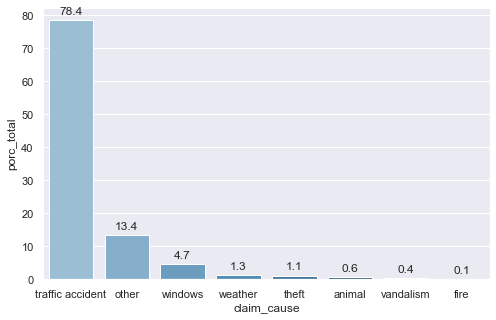

In [123]:
plt.figure(figsize=(8,5))

ax = sns.barplot(x=var, y='porc_total', 
                 data=data.reset_index().sort_values(by='porc_total',ascending=False),palette='Blues_d')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.show()

In [124]:
df_total.set_index(var,inplace=True)

In [125]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55463, 81)


claim_cause  claim_id fraud  claim_amount  claim_date_registered  \
0      animal     31035     N       1989.28               20170519   
1      animal     57237     N       1815.75               20171106   
2      animal     61443     N       2588.25               20171204   
3      animal     64922     N       4501.00               20171228   
4      animal     24540     Y       5098.67               20170407   

  claim_liable  claim_num_injured  claim_num_third_parties  \
0            N                  0                        0   
1            N                  0                        1   
2            N                  0                        0   
3            Y                  1                        0   
4            N                  0                        0   

   claim_num_vehicles claim_police claim_alcohol  claim_language  \
0                   1            N           NaN             2.0   
1                   2            N           NaN             1.0   
2                   2            N           NaN             1.0   
3                   2            N             N             1.0   
4                   2            Y           NaN             1.0   

                              claim_vehicle_id claim_vehicle_brand  \
0  OGE3N2Q1MDFlZDc4YjMyNjFmMWNjYmFhYzA2ZTI2YTA               SKODA   
1  MGY3MGEwZjcxYTE5MGExYWU5MDdjMjhjNDcxNzFjZDc                OPEL   
2  OGFlMzZlODY3MDhjOTgwOGY5ZTk1OTg0ZTA3MTk2Nzg              JAGUAR   
3  ZTJjZWQwZTk0ZTBmYmY0NDBkNmIzODI4ZDk5YzZiMjk                 BMW   
4  ZGZmMTYzNDQwOWFkMGE2NTNjNWY0MTUwZGMyODdhMmM            MERCEDES   

  claim_vehicle_type  claim_vehicle_date_inuse  claim_vehicle_cyl  \
0                car                  201408.0             1198.0   
1                car                  201101.0             1248.0   
2                car                  201002.0             2720.0   
3                car                  200608.0             1995.0   
4                car                  200603.0             1998.0   

  claim_vehicle_load  claim_vehicle_fuel_type  claim_vehicle_power  \
0               1.57                      1.0                 44.0   
1               1.63                      2.0                 70.0   
2               2.31                      2.0                152.0   
3               1.81                      2.0                 90.0   
4               1.62                      1.0                120.0   

                              policy_holder_id  policy_holder_postal_code  \
0  NWFlNWQzZGMxYTEzMjc4OGRmNjJkNjg5YTVkNGYzNGM                     2900.0   
1  NmYyMGU3MjQwZDA1YTdiMjdlM2E5ZjJiZmQ3YWEwMjQ                     4608.0   
2  ZTAzYzM4MzdiYjk4N2YyNjczMGQ2MjM0Njg5MDE2NjA                     1030.0   
3  ZTVkYzlkYzdhMDlkNDhkY2FlMDE4ZjI2ODUxMDBjNWY                     1933.0   
4  MTQ1NmRkZGM3YjI0NDhhZDAxYWQ2Njc5NWJmNWUzZTE                     7640.0   

  policy_holder_form  policy_holder_year_birth policy_holder_country  \
0                  F                    1975.0                     B   
1                  F                    1990.0                     B   
2                  M                    1960.0                     B   
3                  F                    1957.0                     B   
4                  M                    1959.0                     B   

                       policy_holder_expert_id  \
0                                          NaN   
1                                          NaN   
2  OWI5NGRiM2RjMzZlNzQyMDNiOTBiZWQ3MWNjM2Y1ZWM   
3  OTBhNWVhZDRmNzFkZjk0MTRkOWIyMmFjYjZjM2JkZTM   
4  YjJjM2RhYjc5N2U1MmNhMzI4MmI0ZmRiMTk5MDcxMjI   

                                     driver_id  driver_postal_code  \
0  NWFlNWQzZGMxYTEzMjc4OGRmNjJkNjg5YTVkNGYzNGM              2900.0   
1  NmYyMGU3MjQwZDA1YTdiMjdlM2E5ZjJiZmQ3YWEwMjQ              4608.0   
2  ZTAzYzM4MzdiYjk4N2YyNjczMGQ2MjM0Njg5MDE2NjA              1030.0   
3  ZTVkYzlkYzdhMDlkNDhkY2FlMDE4ZjI2ODUxMDBjNWY              1933.

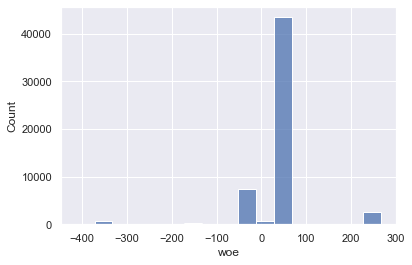

In [126]:
sns.histplot(x=data.loc[(data['woe']!=np.inf) &
                        (data['woe']!=-np.inf),'woe'])
plt.show()

In [127]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
claim_cause                                                          
theft                 2397175.16       909510.65                45.04
traffic accident     89559950.49       496707.76                24.60
other                15444088.98       422976.15                20.95
fire                   283809.26       125128.52                 6.20
weather               1879889.12        34828.48                 1.72

In [128]:
### possible segmentation of population due to amount of fraud claims
### theft: 45%, traffic accident: 24.6%, other: 20.9%, i.e. the 90% of total amount of fraud claims.

In [129]:
table.to_clipboard(index=True,header=True)

In [130]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

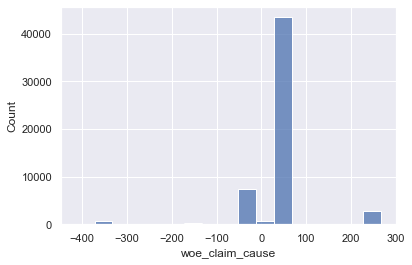

In [131]:
sns.histplot(x=data['woe_'+var])
plt.show()

In [132]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [133]:
data[var].dtype

dtype('O')

In [134]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [135]:
temp.index.dtype

dtype('O')

In [136]:
dict_woe.update(temp.to_dict())

In [137]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [138]:
len(dict_woe)

3

In [139]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [140]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [141]:
data[var+'_cat'] = np.where(data[var].isin(['traffic accident']),'traffic accident',
                                  np.where(data[var].isin(['other']),'other','remaining_cats'))

data[var+'_cat'].value_counts(normalize=True)

traffic accident    0.784235
other               0.134053
remaining_cats      0.081712
Name: claim_cause_cat, dtype: float64

In [142]:
data[var+'_cat'].value_counts(normalize=False)

traffic accident    43496
other                7435
remaining_cats       4532
Name: claim_cause_cat, dtype: int64

In [143]:
var+'_cat'

'claim_cause_cat'

In [144]:
dict_categ = {'claim_cause_cat':['traffic accident','other','remaining_cats']}

data = categorical(data,dict_categ)

In [145]:
# Get dummies
data = pd.get_dummies(data,
                      columns=data.columns[
                                           np.where(data.dtypes == 'category')
                                           ],
                      drop_first=True
                      )

In [146]:
data.drop(['woe',var],axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55463, 82)


claim_id fraud  claim_amount  claim_date_registered claim_liable  \
0     31035     N       1989.28               20170519            N   
1     57237     N       1815.75               20171106            N   
2     61443     N       2588.25               20171204            N   
3     64922     N       4501.00               20171228            Y   
4     24540     Y       5098.67               20170407            N   

   claim_num_injured  claim_num_third_parties  claim_num_vehicles  \
0                  0                        0                   1   
1                  0                        1                   2   
2                  0                        0                   2   
3                  1                        0                   2   
4                  0                        0                   2   

  claim_police claim_alcohol  claim_language  \
0            N           NaN             2.0   
1            N           NaN             1.0   
2            N           NaN             1.0   
3            N             N             1.0   
4            Y           NaN             1.0   

                              claim_vehicle_id claim_vehicle_brand  \
0  OGE3N2Q1MDFlZDc4YjMyNjFmMWNjYmFhYzA2ZTI2YTA               SKODA   
1  MGY3MGEwZjcxYTE5MGExYWU5MDdjMjhjNDcxNzFjZDc                OPEL   
2  OGFlMzZlODY3MDhjOTgwOGY5ZTk1OTg0ZTA3MTk2Nzg              JAGUAR   
3  ZTJjZWQwZTk0ZTBmYmY0NDBkNmIzODI4ZDk5YzZiMjk                 BMW   
4  ZGZmMTYzNDQwOWFkMGE2NTNjNWY0MTUwZGMyODdhMmM            MERCEDES   

  claim_vehicle_type  claim_vehicle_date_inuse  claim_vehicle_cyl  \
0                car                  201408.0             1198.0   
1                car                  201101.0             1248.0   
2                car                  201002.0             2720.0   
3                car                  200608.0             1995.0   
4                car                  200603.0             1998.0   

  claim_vehicle_load  claim_vehicle_fuel_type  claim_vehicle_power  \
0               1.57                      1.0                 44.0   
1               1.63                      2.0                 70.0   
2               2.31                      2.0                152.0   
3               1.81                      2.0                 90.0   
4               1.62                      1.0                120.0   

                              policy_holder_id  policy_holder_postal_code  \
0  NWFlNWQzZGMxYTEzMjc4OGRmNjJkNjg5YTVkNGYzNGM                     2900.0   
1  NmYyMGU3MjQwZDA1YTdiMjdlM2E5ZjJiZmQ3YWEwMjQ                     4608.0   
2  ZTAzYzM4MzdiYjk4N2YyNjczMGQ2MjM0Njg5MDE2NjA                     1030.0   
3  ZTVkYzlkYzdhMDlkNDhkY2FlMDE4ZjI2ODUxMDBjNWY                     1933.0   
4  MTQ1NmRkZGM3YjI0NDhhZDAxYWQ2Njc5NWJmNWUzZTE                     7640.0   

  policy_holder_form  policy_holder_year_birth policy_holder_country  \
0                  F                    1975.0                     B   
1                  F                    1990.0                     B   
2                  M                    1960.0                     B   
3                  F                    1957.0                     B   
4                  M                    1959.0                     B   

                       policy_holder_expert_id  \
0                                          NaN   
1                                          NaN   
2  OWI5NGRiM2RjMzZlNzQyMDNiOTBiZWQ3MWNjM2Y1ZWM   
3  OTBhNWVhZDRmNzFkZjk0MTRkOWIyMmFjYjZjM2JkZTM   
4  YjJjM2RhYjc5N2U1MmNhMzI4MmI0ZmRiMTk5MDcxMjI   

                                     driver_id  driver_postal_code  \
0  NWFlNWQzZGMxYTEzMjc4OGRmNjJkNjg5YTVkNGYzNGM              2900.0   
1  NmYyMGU3MjQwZDA1YTdiMjdlM2E5ZjJiZmQ3YWEwMjQ              4608.0   
2  ZTAzYzM4MzdiYjk4N2YyNjczMGQ2MjM0Njg5MDE2NjA              1030.0   
3  ZTVkYzlkYzdhMDlkNDhkY2FlMDE4ZjI2ODUxMDBjNWY              1933.0   
4  MTQ1NmRkZGM3YjI0NDhhZDAxYWQ2Njc5NWJmNWUzZTE              7640.0  

In [147]:
#############

In [148]:
var = 'claim_liable'

In [149]:
len(df_total[var].unique())

2

In [150]:
df_total[var].unique()

array(['N', 'Y'], dtype=object)

In [151]:
data = woe(df_total,var)
data

N    Y  total   porc_N  porc_Y  porc_total      woe
claim_liable                                                         
N             33563  240  33803  99.2900  0.7100     60.9469 -24.7262
Y             21592   68  21660  99.6861  0.3139     39.0531  57.2768

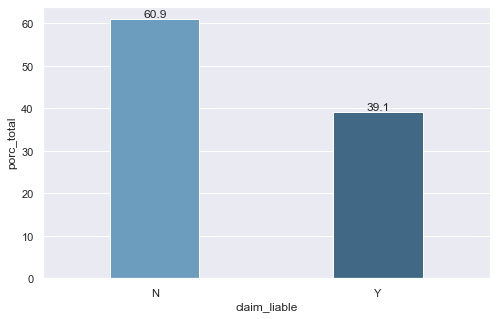

In [152]:
plt.figure(figsize=(8,5))

ax = sns.barplot(x=var, y='porc_total', 
                 data=data.reset_index().sort_values(by='porc_total',ascending=False),palette='Blues_d')
widthbars = [0.4, 0.4]

for p,newwidth in zip(ax.patches,widthbars):
    
    x = p.get_x()
    width = p.get_width()
    centre = x + width/2.
    p.set_x(centre - newwidth/2.)
    p.set_width(newwidth)
    
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), 
                   textcoords = 'offset points',
                   size=12)

plt.show()

In [153]:
df_total.set_index(var,inplace=True)

In [154]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55463, 83)


claim_liable  claim_id fraud  claim_amount  claim_date_registered  \
0            N     31035     N       1989.28               20170519   
1            N     57237     N       1815.75               20171106   
2            N     61443     N       2588.25               20171204   
3            N     24540     Y       5098.67               20170407   
4            N     21284     N       2472.99               20170316   

   claim_num_injured  claim_num_third_parties  claim_num_vehicles  \
0                  0                        0                   1   
1                  0                        1                   2   
2                  0                        0                   2   
3                  0                        0                   2   
4                  0                        0                   1   

  claim_police claim_alcohol  claim_language  \
0            N           NaN             2.0   
1            N           NaN             1.0   
2            N           NaN             1.0   
3            Y           NaN             1.0   
4            N           NaN             1.0   

                              claim_vehicle_id claim_vehicle_brand  \
0  OGE3N2Q1MDFlZDc4YjMyNjFmMWNjYmFhYzA2ZTI2YTA               SKODA   
1  MGY3MGEwZjcxYTE5MGExYWU5MDdjMjhjNDcxNzFjZDc                OPEL   
2  OGFlMzZlODY3MDhjOTgwOGY5ZTk1OTg0ZTA3MTk2Nzg              JAGUAR   
3  ZGZmMTYzNDQwOWFkMGE2NTNjNWY0MTUwZGMyODdhMmM            MERCEDES   
4  YWQ2YTQ5Y2FkNzU5YWFlNjExMWZkOTY2YzMwZTEzZDM          VOLKSWAGEN   

  claim_vehicle_type  claim_vehicle_date_inuse  claim_vehicle_cyl  \
0                car                  201408.0             1198.0   
1                car                  201101.0             1248.0   
2                car                  201002.0             2720.0   
3                car                  200603.0             1998.0   
4                car                  201305.0             1598.0   

  claim_vehicle_load  claim_vehicle_fuel_type  claim_vehicle_power  \
0               1.57                      1.0                 44.0   
1               1.63                      2.0                 70.0   
2               2.31                      2.0                152.0   
3               1.62                      1.0                120.0   
4               1.80                      2.0                 66.0   

                              policy_holder_id  policy_holder_postal_code  \
0  NWFlNWQzZGMxYTEzMjc4OGRmNjJkNjg5YTVkNGYzNGM                     2900.0   
1  NmYyMGU3MjQwZDA1YTdiMjdlM2E5ZjJiZmQ3YWEwMjQ                     4608.0   
2  ZTAzYzM4MzdiYjk4N2YyNjczMGQ2MjM0Njg5MDE2NjA                     1030.0   
3  MTQ1NmRkZGM3YjI0NDhhZDAxYWQ2Njc5NWJmNWUzZTE                     7640.0   
4  NWFmYWU0ZWMzYjMxNWE3OGI0ZTNmN2E2OWRjZDk4M2M                     1325.0   

  policy_holder_form  policy_holder_year_birth policy_holder_country  \
0                  F                    1975.0                     B   
1                  F                    1990.0                     B   
2                  M                    1960.0                     B   
3                  M                    1959.0                     B   
4                  M                    1981.0                     B   

                       policy_holder_expert_id  \
0                                          NaN   
1                                          NaN   
2  OWI5NGRiM2RjMzZlNzQyMDNiOTBiZWQ3MWNjM2Y1ZWM   
3  YjJjM2RhYjc5N2U1MmNhMzI4MmI0ZmRiMTk5MDcxMjI   
4                                          NaN   

                                     driver_id  driver_postal_code  \
0  NWFlNWQzZGMxYTEzMjc4OGRmNjJkNjg5YTVkNGYzNGM              2900.0   
1  NmYyMGU3MjQwZDA1YTdiMjdlM2E5ZjJiZmQ3YWEwMjQ              4608.0   
2  ZTAzYzM4MzdiYjk4N2YyNjczMGQ2MjM0Njg5MDE2NjA              1030.0   
3  MTQ1NmRkZGM3YjI0NDhhZDAxYWQ2Njc5NWJmNWUzZTE              7640.0   
4  NWFmYWU0ZWMzYjMxNWE3OGI0ZTNmN2E2OWRjZDk4M2M              1325.0 

In [155]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
claim_liable                                                     
N               7.429785e+07      1665299.36                82.47
Y               4.071537e+07       353960.28                17.53

In [156]:
### the 82% of the amount of fraud claims is in the category when the policy holder is not liable of the accident

In [157]:
table.to_clipboard(index=True,header=True)

In [158]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [159]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [160]:
data[var].dtype

dtype('O')

In [161]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [162]:
temp.index.dtype

dtype('O')

In [163]:
dict_woe.update(temp.to_dict())

In [164]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [165]:
len(dict_woe)

4

In [166]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [167]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [168]:
data[var+'_cat'] = data[var]

In [169]:
var+'_cat'

'claim_liable_cat'

In [170]:
dict_categ = {'claim_liable_cat':['Y','N']}

data = categorical(data,dict_categ)

In [171]:
# Get dummies
data = pd.get_dummies(data,
                      columns=data.columns[
                                           np.where(data.dtypes == 'category')
                                           ],
                      drop_first=True
                      )

In [172]:
data.drop(['woe',var],axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55463, 83)


claim_id fraud  claim_amount  claim_date_registered  claim_num_injured  \
0     31035     N       1989.28               20170519                  0   
1     57237     N       1815.75               20171106                  0   
2     61443     N       2588.25               20171204                  0   
3     24540     Y       5098.67               20170407                  0   
4     21284     N       2472.99               20170316                  0   

   claim_num_third_parties  claim_num_vehicles claim_police claim_alcohol  \
0                        0                   1            N           NaN   
1                        1                   2            N           NaN   
2                        0                   2            N           NaN   
3                        0                   2            Y           NaN   
4                        0                   1            N           NaN   

   claim_language                             claim_vehicle_id  \
0             2.0  OGE3N2Q1MDFlZDc4YjMyNjFmMWNjYmFhYzA2ZTI2YTA   
1             1.0  MGY3MGEwZjcxYTE5MGExYWU5MDdjMjhjNDcxNzFjZDc   
2             1.0  OGFlMzZlODY3MDhjOTgwOGY5ZTk1OTg0ZTA3MTk2Nzg   
3             1.0  ZGZmMTYzNDQwOWFkMGE2NTNjNWY0MTUwZGMyODdhMmM   
4             1.0  YWQ2YTQ5Y2FkNzU5YWFlNjExMWZkOTY2YzMwZTEzZDM   

  claim_vehicle_brand claim_vehicle_type  claim_vehicle_date_inuse  \
0               SKODA                car                  201408.0   
1                OPEL                car                  201101.0   
2              JAGUAR                car                  201002.0   
3            MERCEDES                car                  200603.0   
4          VOLKSWAGEN                car                  201305.0   

   claim_vehicle_cyl claim_vehicle_load  claim_vehicle_fuel_type  \
0             1198.0               1.57                      1.0   
1             1248.0               1.63                      2.0   
2             2720.0               2.31                      2.0   
3             1998.0               1.62                      1.0   
4             1598.0               1.80                      2.0   

   claim_vehicle_power                             policy_holder_id  \
0                 44.0  NWFlNWQzZGMxYTEzMjc4OGRmNjJkNjg5YTVkNGYzNGM   
1                 70.0  NmYyMGU3MjQwZDA1YTdiMjdlM2E5ZjJiZmQ3YWEwMjQ   
2                152.0  ZTAzYzM4MzdiYjk4N2YyNjczMGQ2MjM0Njg5MDE2NjA   
3                120.0  MTQ1NmRkZGM3YjI0NDhhZDAxYWQ2Njc5NWJmNWUzZTE   
4                 66.0  NWFmYWU0ZWMzYjMxNWE3OGI0ZTNmN2E2OWRjZDk4M2M   

   policy_holder_postal_code policy_holder_form  policy_holder_year_birth  \
0                     2900.0                  F                    1975.0   
1                     4608.0                  F                    1990.0   
2                     1030.0                  M                    1960.0   
3                     7640.0                  M                    1959.0   
4                     1325.0                  M                    1981.0   

  policy_holder_country                      policy_holder_expert_id  \
0                     B                                          NaN   
1                     B                                          NaN   
2                     B  OWI5NGRiM2RjMzZlNzQyMDNiOTBiZWQ3MWNjM2Y1ZWM   
3                     B  YjJjM2RhYjc5N2U1MmNhMzI4MmI0ZmRiMTk5MDcxMjI   
4                     B                                          NaN   

                                     driver_id  driver_postal_code  \
0  NWFlNWQzZGMxYTEzMjc4OGRmNjJkNjg5YTVkNGYzNGM              2900.0   
1  NmYyMGU3MjQwZDA1YTdiMjdlM2E5ZjJiZmQ3YWEwMjQ              4608.0   
2  ZTAzYzM4MzdiYjk4N2YyNjczMGQ2MjM0Njg5MDE2NjA              1030.0   
3  MTQ1NmRkZGM3YjI0NDhhZDAxYWQ2Njc5NWJmNWUzZTE              7640.0   
4  NWFmYWU0ZWMzYjMxNWE3OGI0ZTNmN2E2OWRjZDk4M2M              1325.0   

  driver_form  driver_year_birth driver_country  \
0           F             1975.0              B   
1   

In [173]:
#############

In [174]:
var = 'claim_num_injured'

In [175]:
len(df_total[var].unique())

6

In [176]:
df_total[var].unique()

array([0, 2, 1, 3, 5, 4], dtype=int64)

In [177]:
data = woe(df_total,var)
#data.sort_index()
data

N    Y  total    porc_N  porc_Y  porc_total      woe
claim_num_injured                                                          
3                     73    1     74   98.6486  1.3514      0.1334 -89.7343
0                  51888  299  52187   99.4271  0.5729     94.0934  -3.1404
2                    482    2    484   99.5868  0.4132      0.8727  29.6994
1                   2685    6   2691   99.7770  0.2230      4.8519  91.5874
4                     21    0     21  100.0000  0.0000      0.0379      inf
5                      6    0      6  100.0000  0.0000      0.0108      inf

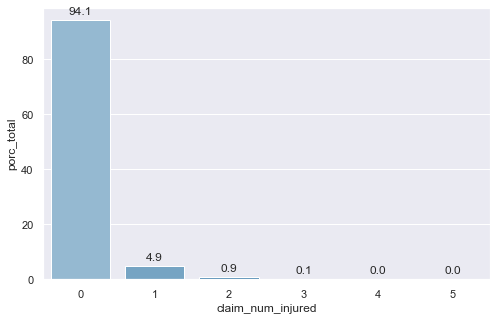

In [178]:
plt.figure(figsize=(8,5))

ax = sns.barplot(x=var, y='porc_total', 
                 data=data.reset_index().sort_values(by='porc_total',ascending=False),palette='Blues_d')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.show()

In [179]:
df_total.set_index(var,inplace=True)

In [180]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55463, 84)


claim_num_injured  claim_id fraud  claim_amount  claim_date_registered  \
0                  0     31035     N       1989.28               20170519   
1                  0     57237     N       1815.75               20171106   
2                  0     61443     N       2588.25               20171204   
3                  0     24540     Y       5098.67               20170407   
4                  0     21284     N       2472.99               20170316   

   claim_num_third_parties  claim_num_vehicles claim_police claim_alcohol  \
0                        0                   1            N           NaN   
1                        1                   2            N           NaN   
2                        0                   2            N           NaN   
3                        0                   2            Y           NaN   
4                        0                   1            N           NaN   

   claim_language                             claim_vehicle_id  \
0             2.0  OGE3N2Q1MDFlZDc4YjMyNjFmMWNjYmFhYzA2ZTI2YTA   
1             1.0  MGY3MGEwZjcxYTE5MGExYWU5MDdjMjhjNDcxNzFjZDc   
2             1.0  OGFlMzZlODY3MDhjOTgwOGY5ZTk1OTg0ZTA3MTk2Nzg   
3             1.0  ZGZmMTYzNDQwOWFkMGE2NTNjNWY0MTUwZGMyODdhMmM   
4             1.0  YWQ2YTQ5Y2FkNzU5YWFlNjExMWZkOTY2YzMwZTEzZDM   

  claim_vehicle_brand claim_vehicle_type  claim_vehicle_date_inuse  \
0               SKODA                car                  201408.0   
1                OPEL                car                  201101.0   
2              JAGUAR                car                  201002.0   
3            MERCEDES                car                  200603.0   
4          VOLKSWAGEN                car                  201305.0   

   claim_vehicle_cyl claim_vehicle_load  claim_vehicle_fuel_type  \
0             1198.0               1.57                      1.0   
1             1248.0               1.63                      2.0   
2             2720.0               2.31                      2.0   
3             1998.0               1.62                      1.0   
4             1598.0               1.80                      2.0   

   claim_vehicle_power                             policy_holder_id  \
0                 44.0  NWFlNWQzZGMxYTEzMjc4OGRmNjJkNjg5YTVkNGYzNGM   
1                 70.0  NmYyMGU3MjQwZDA1YTdiMjdlM2E5ZjJiZmQ3YWEwMjQ   
2                152.0  ZTAzYzM4MzdiYjk4N2YyNjczMGQ2MjM0Njg5MDE2NjA   
3                120.0  MTQ1NmRkZGM3YjI0NDhhZDAxYWQ2Njc5NWJmNWUzZTE   
4                 66.0  NWFmYWU0ZWMzYjMxNWE3OGI0ZTNmN2E2OWRjZDk4M2M   

   policy_holder_postal_code policy_holder_form  policy_holder_year_birth  \
0                     2900.0                  F                    1975.0   
1                     4608.0                  F                    1990.0   
2                     1030.0                  M                    1960.0   
3                     7640.0                  M                    1959.0   
4                     1325.0                  M                    1981.0   

  policy_holder_country                      policy_holder_expert_id  \
0                     B                                          NaN   
1                     B                                          NaN   
2                     B  OWI5NGRiM2RjMzZlNzQyMDNiOTBiZWQ3MWNjM2Y1ZWM   
3                     B  YjJjM2RhYjc5N2U1MmNhMzI4MmI0ZmRiMTk5MDcxMjI   
4                     B                                          NaN   

                                     driver_id  driver_postal_code  \
0  NWFlNWQzZGMxYTEzMjc4OGRmNjJkNjg5YTVkNGYzNGM              2900.0   
1  NmYyMGU3MjQwZDA1YTdiMjdlM2E5ZjJiZmQ3YWEwMjQ              4608.0   
2  ZTAzYzM4MzdiYjk4N2YyNjczMGQ2MjM0Njg5MDE2NjA              1030.0   
3  MTQ1NmRkZGM3YjI0NDhhZDAxYWQ2Njc5NWJmNWUzZTE              7640.0   
4  NWFmYWU0ZWMzYjMxNWE3OGI0ZTNmN2E2OWRjZDk4M2M              1325.0   

  driver_form  driver_year_birth driver_country  \
0           F             1975.0              B   
1   

In [181]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
claim_num_injured                                                     
0                    9.448446e+07      1914294.19                94.80
1                    1.608191e+07        71993.40                 3.57
2                    3.527822e+06        25258.00                 1.25
3                    6.746220e+05         7714.05                 0.38
4                    1.951062e+05             NaN                  NaN
5                    4.929153e+04             NaN                  NaN

In [182]:
### the 95% of the amount of fraud claims is when the number of injured parties is zero

In [183]:
table.to_clipboard(index=True,header=True)

In [184]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [185]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [186]:
data[var].dtype

dtype('int64')

In [187]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [188]:
temp.index.dtype

dtype('int64')

In [189]:
dict_woe.update(temp.to_dict())

In [190]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [191]:
len(dict_woe)

5

In [192]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [193]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [194]:
columns_f = [col for col in data.columns if (var not in col)]+['woe_'+var]+[var]
print(len(columns_f))
print(data.shape)

data = data.reindex(columns=columns_f)

85
(55463, 85)


In [195]:
#data.reset_index(drop=True,inplace=True)
data.drop('woe',axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55463, 84)


claim_id fraud  claim_amount  claim_date_registered  \
0     31035     N       1989.28               20170519   
1     57237     N       1815.75               20171106   
2     61443     N       2588.25               20171204   
3     24540     Y       5098.67               20170407   
4     21284     N       2472.99               20170316   

   claim_num_third_parties  claim_num_vehicles claim_police claim_alcohol  \
0                        0                   1            N           NaN   
1                        1                   2            N           NaN   
2                        0                   2            N           NaN   
3                        0                   2            Y           NaN   
4                        0                   1            N           NaN   

   claim_language                             claim_vehicle_id  \
0             2.0  OGE3N2Q1MDFlZDc4YjMyNjFmMWNjYmFhYzA2ZTI2YTA   
1             1.0  MGY3MGEwZjcxYTE5MGExYWU5MDdjMjhjNDcxNzFjZDc   
2             1.0  OGFlMzZlODY3MDhjOTgwOGY5ZTk1OTg0ZTA3MTk2Nzg   
3             1.0  ZGZmMTYzNDQwOWFkMGE2NTNjNWY0MTUwZGMyODdhMmM   
4             1.0  YWQ2YTQ5Y2FkNzU5YWFlNjExMWZkOTY2YzMwZTEzZDM   

  claim_vehicle_brand claim_vehicle_type  claim_vehicle_date_inuse  \
0               SKODA                car                  201408.0   
1                OPEL                car                  201101.0   
2              JAGUAR                car                  201002.0   
3            MERCEDES                car                  200603.0   
4          VOLKSWAGEN                car                  201305.0   

   claim_vehicle_cyl claim_vehicle_load  claim_vehicle_fuel_type  \
0             1198.0               1.57                      1.0   
1             1248.0               1.63                      2.0   
2             2720.0               2.31                      2.0   
3             1998.0               1.62                      1.0   
4             1598.0               1.80                      2.0   

   claim_vehicle_power                             policy_holder_id  \
0                 44.0  NWFlNWQzZGMxYTEzMjc4OGRmNjJkNjg5YTVkNGYzNGM   
1                 70.0  NmYyMGU3MjQwZDA1YTdiMjdlM2E5ZjJiZmQ3YWEwMjQ   
2                152.0  ZTAzYzM4MzdiYjk4N2YyNjczMGQ2MjM0Njg5MDE2NjA   
3                120.0  MTQ1NmRkZGM3YjI0NDhhZDAxYWQ2Njc5NWJmNWUzZTE   
4                 66.0  NWFmYWU0ZWMzYjMxNWE3OGI0ZTNmN2E2OWRjZDk4M2M   

   policy_holder_postal_code policy_holder_form  policy_holder_year_birth  \
0                     2900.0                  F                    1975.0   
1                     4608.0                  F                    1990.0   
2                     1030.0                  M                    1960.0   
3                     7640.0                  M                    1959.0   
4                     1325.0                  M                    1981.0   

  policy_holder_country                      policy_holder_expert_id  \
0                     B                                          NaN   
1                     B                                          NaN   
2                     B  OWI5NGRiM2RjMzZlNzQyMDNiOTBiZWQ3MWNjM2Y1ZWM   
3                     B  YjJjM2RhYjc5N2U1MmNhMzI4MmI0ZmRiMTk5MDcxMjI   
4                     B                                          NaN   

                                     driver_id  driver_postal_code  \
0  NWFlNWQzZGMxYTEzMjc4OGRmNjJkNjg5YTVkNGYzNGM              2900.0   
1  NmYyMGU3MjQwZDA1YTdiMjdlM2E5ZjJiZmQ3YWEwMjQ              4608.0   
2  ZTAzYzM4MzdiYjk4N2YyNjczMGQ2MjM0Njg5MDE2NjA              1030.0   
3  MTQ1NmRkZGM3YjI0NDhhZDAxYWQ2Njc5NWJmNWUzZTE              7640.0   
4  NWFmYWU0ZWMzYjMxNWE3OGI0ZTNmN2E2OWRjZDk4M2M              1325.0   

  driver_form  driver_year_birth driver_country  \
0           F             1975.0              B   
1           F             1990.0              B   
2           M             1960.0              B   
3           M   

In [196]:
#############

In [197]:
var = 'claim_num_third_parties'

In [198]:
len(df_total[var].unique())

6

In [199]:
df_total[var].unique()

array([0, 1, 2, 5, 3, 4], dtype=int64)

In [200]:
data = woe(df_total,var)
#data.sort_index()
data

N    Y  total    porc_N  porc_Y  porc_total  \
claim_num_third_parties                                                    
4                          125    2    127   98.4252  1.5748      0.2290   
0                        13524  178  13702   98.7009  1.2991     24.7048   
3                          544    2    546   99.6337  0.3663      0.9844   
1                        38172  121  38293   99.6840  0.3160     69.0424   
2                         2762    5   2767   99.8193  0.1807      4.9889   
5                           28    0     28  100.0000  0.0000      0.0505   

                              woe  
claim_num_third_parties            
4                       -105.2636  
0                        -85.7365  
3                         41.7999  
1                         56.6264  
2                        112.6470  
5                             inf

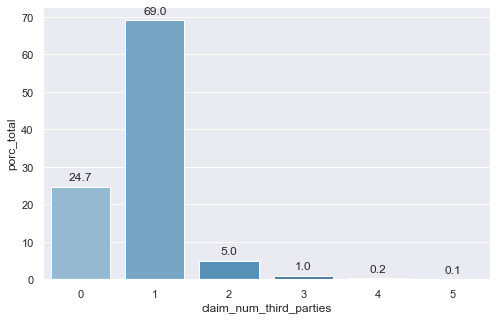

In [201]:
plt.figure(figsize=(8,5))

ax = sns.barplot(x=var, y='porc_total', 
                 data=data.reset_index().sort_values(by='porc_total',ascending=False),palette='Blues_d')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.show()

In [202]:
df_total.set_index(var,inplace=True)

In [203]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55463, 85)


claim_num_third_parties  claim_id fraud  claim_amount  \
0                        0     31035     N       1989.28   
1                        0     61443     N       2588.25   
2                        0     24540     Y       5098.67   
3                        0     21284     N       2472.99   
4                        0     42769     N       2697.51   

   claim_date_registered  claim_num_vehicles claim_police claim_alcohol  \
0               20170519                   1            N           NaN   
1               20171204                   2            N           NaN   
2               20170407                   2            Y           NaN   
3               20170316                   1            N           NaN   
4               20170803                   1            N           NaN   

   claim_language                             claim_vehicle_id  \
0             2.0  OGE3N2Q1MDFlZDc4YjMyNjFmMWNjYmFhYzA2ZTI2YTA   
1             1.0  OGFlMzZlODY3MDhjOTgwOGY5ZTk1OTg0ZTA3MTk2Nzg   
2             1.0  ZGZmMTYzNDQwOWFkMGE2NTNjNWY0MTUwZGMyODdhMmM   
3             1.0  YWQ2YTQ5Y2FkNzU5YWFlNjExMWZkOTY2YzMwZTEzZDM   
4             1.0  ZTIzNmJmYWI1OWU0OGM4OTIyZDkyMzZhNzYzYzMxNTM   

  claim_vehicle_brand claim_vehicle_type  claim_vehicle_date_inuse  \
0               SKODA                car                  201408.0   
1              JAGUAR                car                  201002.0   
2            MERCEDES                car                  200603.0   
3          VOLKSWAGEN                car                  201305.0   
4                 KIA                car                  201502.0   

   claim_vehicle_cyl claim_vehicle_load  claim_vehicle_fuel_type  \
0             1198.0               1.57                      1.0   
1             2720.0               2.31                      2.0   
2             1998.0               1.62                      1.0   
3             1598.0               1.80                      2.0   
4             1582.0               1.92                      2.0   

   claim_vehicle_power                             policy_holder_id  \
0                 44.0  NWFlNWQzZGMxYTEzMjc4OGRmNjJkNjg5YTVkNGYzNGM   
1                152.0  ZTAzYzM4MzdiYjk4N2YyNjczMGQ2MjM0Njg5MDE2NjA   
2                120.0  MTQ1NmRkZGM3YjI0NDhhZDAxYWQ2Njc5NWJmNWUzZTE   
3                 66.0  NWFmYWU0ZWMzYjMxNWE3OGI0ZTNmN2E2OWRjZDk4M2M   
4                 81.0  NmE4Njk2MDEzNDRjZDliM2YwZTk4MzQzZjEzNDEzMjU   

   policy_holder_postal_code policy_holder_form  policy_holder_year_birth  \
0                     2900.0                  F                    1975.0   
1                     1030.0                  M                    1960.0   
2                     7640.0                  M                    1959.0   
3                     1325.0                  M                    1981.0   
4                     1330.0                  M                    1977.0   

  policy_holder_country                      policy_holder_expert_id  \
0                     B                                          NaN   
1                     B  OWI5NGRiM2RjMzZlNzQyMDNiOTBiZWQ3MWNjM2Y1ZWM   
2                     B  YjJjM2RhYjc5N2U1MmNhMzI4MmI0ZmRiMTk5MDcxMjI   
3                     B                                          NaN   
4                     B                                          NaN   

                                     driver_id  driver_postal_code  \
0  NWFlNWQzZGMxYTEzMjc4OGRmNjJkNjg5YTVkNGYzNGM              2900.0   
1  ZTAzYzM4MzdiYjk4N2YyNjczMGQ2MjM0Njg5MDE2NjA              1030.0   
2  MTQ1NmRkZGM3YjI0NDhhZDAxYWQ2Njc5NWJmNWUzZTE              7640.0   
3  NWFmYWU0ZWMzYjMxNWE3OGI0ZTNmN2E2OWRjZDk4M2M              1325.0   
4  NmE4Njk2MDEzNDRjZDliM2YwZTk4MzQzZjEzNDEzMjU              1330.0   

  driver_form  driver_year_birth driver_country  \
0           F             1975.0              B   
1           M             1960.0              B   
2           M             1959.0              B   
3           M   

In [204]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
claim_num_third_parties                                                     
0                           27899252.51      1484528.51                73.52
1                           72639151.77       440575.66                21.82
2                           10542571.95        64574.52                 3.20
4                             820675.52        24573.05                 1.22
3                            2904541.89         5007.90                 0.25
5                             207021.69             NaN                  NaN

In [205]:
### the 95% of the amount of fraud claims is when the number of third parties involved is between 0 and 1

In [206]:
table.to_clipboard(index=True,header=True)

In [207]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [208]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [209]:
data[var].dtype

dtype('int64')

In [210]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [211]:
temp.index.dtype

dtype('int64')

In [212]:
dict_woe.update(temp.to_dict())

In [213]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [214]:
len(dict_woe)

6

In [215]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [216]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [217]:
columns_f = [col for col in data.columns if (var not in col)]+['woe_'+var]+[var]
print(len(columns_f))
print(data.shape)

data = data.reindex(columns=columns_f)

86
(55463, 86)


In [218]:
#data.reset_index(drop=True,inplace=True)
data.drop('woe',axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55463, 85)


claim_id fraud  claim_amount  claim_date_registered  claim_num_vehicles  \
0     31035     N       1989.28               20170519                   1   
1     61443     N       2588.25               20171204                   2   
2     24540     Y       5098.67               20170407                   2   
3     21284     N       2472.99               20170316                   1   
4     42769     N       2697.51               20170803                   1   

  claim_police claim_alcohol  claim_language  \
0            N           NaN             2.0   
1            N           NaN             1.0   
2            Y           NaN             1.0   
3            N           NaN             1.0   
4            N           NaN             1.0   

                              claim_vehicle_id claim_vehicle_brand  \
0  OGE3N2Q1MDFlZDc4YjMyNjFmMWNjYmFhYzA2ZTI2YTA               SKODA   
1  OGFlMzZlODY3MDhjOTgwOGY5ZTk1OTg0ZTA3MTk2Nzg              JAGUAR   
2  ZGZmMTYzNDQwOWFkMGE2NTNjNWY0MTUwZGMyODdhMmM            MERCEDES   
3  YWQ2YTQ5Y2FkNzU5YWFlNjExMWZkOTY2YzMwZTEzZDM          VOLKSWAGEN   
4  ZTIzNmJmYWI1OWU0OGM4OTIyZDkyMzZhNzYzYzMxNTM                 KIA   

  claim_vehicle_type  claim_vehicle_date_inuse  claim_vehicle_cyl  \
0                car                  201408.0             1198.0   
1                car                  201002.0             2720.0   
2                car                  200603.0             1998.0   
3                car                  201305.0             1598.0   
4                car                  201502.0             1582.0   

  claim_vehicle_load  claim_vehicle_fuel_type  claim_vehicle_power  \
0               1.57                      1.0                 44.0   
1               2.31                      2.0                152.0   
2               1.62                      1.0                120.0   
3               1.80                      2.0                 66.0   
4               1.92                      2.0                 81.0   

                              policy_holder_id  policy_holder_postal_code  \
0  NWFlNWQzZGMxYTEzMjc4OGRmNjJkNjg5YTVkNGYzNGM                     2900.0   
1  ZTAzYzM4MzdiYjk4N2YyNjczMGQ2MjM0Njg5MDE2NjA                     1030.0   
2  MTQ1NmRkZGM3YjI0NDhhZDAxYWQ2Njc5NWJmNWUzZTE                     7640.0   
3  NWFmYWU0ZWMzYjMxNWE3OGI0ZTNmN2E2OWRjZDk4M2M                     1325.0   
4  NmE4Njk2MDEzNDRjZDliM2YwZTk4MzQzZjEzNDEzMjU                     1330.0   

  policy_holder_form  policy_holder_year_birth policy_holder_country  \
0                  F                    1975.0                     B   
1                  M                    1960.0                     B   
2                  M                    1959.0                     B   
3                  M                    1981.0                     B   
4                  M                    1977.0                     B   

                       policy_holder_expert_id  \
0                                          NaN   
1  OWI5NGRiM2RjMzZlNzQyMDNiOTBiZWQ3MWNjM2Y1ZWM   
2  YjJjM2RhYjc5N2U1MmNhMzI4MmI0ZmRiMTk5MDcxMjI   
3                                          NaN   
4                                          NaN   

                                     driver_id  driver_postal_code  \
0  NWFlNWQzZGMxYTEzMjc4OGRmNjJkNjg5YTVkNGYzNGM              2900.0   
1  ZTAzYzM4MzdiYjk4N2YyNjczMGQ2MjM0Njg5MDE2NjA              1030.0   
2  MTQ1NmRkZGM3YjI0NDhhZDAxYWQ2Njc5NWJmNWUzZTE              7640.0   
3  NWFmYWU0ZWMzYjMxNWE3OGI0ZTNmN2E2OWRjZDk4M2M              1325.0   
4  NmE4Njk2MDEzNDRjZDliM2YwZTk4MzQzZjEzNDEzMjU              1330.0   

  driver_form  driver_year_birth driver_country  \
0           F             1975.0              B   
1           M             1960.0              B   
2           M             1959.0              B   
3           M             1981.0              B   
4           M             1977.0              B   

                              driver_expert_id driver_injured  

In [219]:
#############

In [220]:
var = 'claim_num_vehicles'

In [221]:
len(df_total[var].unique())

6

In [222]:
df_total[var].unique()

array([1, 2, 3, 4, 5, 0], dtype=int64)

In [223]:
data = woe(df_total,var)
#data.sort_index()
data

N    Y  total    porc_N  porc_Y  porc_total      woe
claim_num_vehicles                                                          
5                     832   12    844   98.5782  1.4218      1.5217 -94.8877
4                    5185   67   5252   98.7243  1.2757      9.4694 -83.8970
3                   18402  130  18532   99.2985  0.7015     33.4133 -23.5123
2                   21846   79  21925   99.6397  0.3603     39.5309  43.4522
1                    8888   20   8908   99.7755  0.2245     16.0612  90.8922
0                       2    0      2  100.0000  0.0000      0.0036      inf

In [224]:
# pd.crosstab(df_total.loc[df_total['fraud']=='Y','claim_cause'], 
#             df_total.loc[df_total['fraud']=='Y',var])

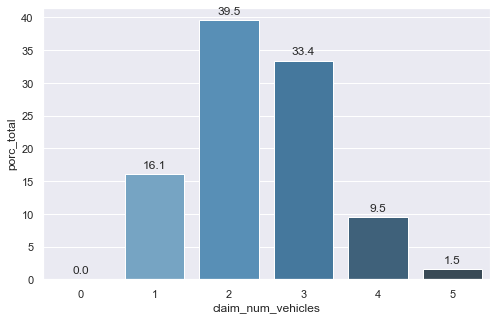

In [225]:
plt.figure(figsize=(8,5))

ax = sns.barplot(x=var, y='porc_total', 
                 data=data.reset_index().sort_values(by='porc_total',ascending=False),palette='Blues_d')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.show()

In [226]:
df_total.set_index(var,inplace=True)

In [227]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55463, 86)


claim_num_vehicles  claim_id fraud  claim_amount  claim_date_registered  \
0                   0     28976     N       3913.77               20170505   
1                   0     13532     N        836.68               20170123   
2                   1     31035     N       1989.28               20170519   
3                   1     21284     N       2472.99               20170316   
4                   1     42769     N       2697.51               20170803   

  claim_police claim_alcohol  claim_language  \
0            N           NaN             1.0   
1            N           NaN             1.0   
2            N           NaN             2.0   
3            N           NaN             1.0   
4            N           NaN             1.0   

                              claim_vehicle_id claim_vehicle_brand  \
0  YWYzOGY1YzEyMDc4M2Y5MmVkYjNlZjczZGFiZWU3YzU               IVECO   
1                                          NaN                 NaN   
2  OGE3N2Q1MDFlZDc4YjMyNjFmMWNjYmFhYzA2ZTI2YTA               SKODA   
3  YWQ2YTQ5Y2FkNzU5YWFlNjExMWZkOTY2YzMwZTEzZDM          VOLKSWAGEN   
4  ZTIzNmJmYWI1OWU0OGM4OTIyZDkyMzZhNzYzYzMxNTM                 KIA   

  claim_vehicle_type  claim_vehicle_date_inuse  claim_vehicle_cyl  \
0                NaN                       NaN                NaN   
1                car                       NaN                NaN   
2                car                  201408.0             1198.0   
3                car                  201305.0             1598.0   
4                car                  201502.0             1582.0   

  claim_vehicle_load  claim_vehicle_fuel_type  claim_vehicle_power  \
0                NaN                      NaN                 85.0   
1                NaN                      2.0                  NaN   
2               1.57                      1.0                 44.0   
3               1.80                      2.0                 66.0   
4               1.92                      2.0                 81.0   

                              policy_holder_id  policy_holder_postal_code  \
0  NzhkMWIwZTJlMDg1YjdkNjQxOTI5ZTY5ODM3YzUyNTc                     7730.0   
1  YzAyOWFlNThjMGViMzM4Nzg4YjhkYmRhZmUzZWMxNDY                     1420.0   
2  NWFlNWQzZGMxYTEzMjc4OGRmNjJkNjg5YTVkNGYzNGM                     2900.0   
3  NWFmYWU0ZWMzYjMxNWE3OGI0ZTNmN2E2OWRjZDk4M2M                     1325.0   
4  NmE4Njk2MDEzNDRjZDliM2YwZTk4MzQzZjEzNDEzMjU                     1330.0   

  policy_holder_form  policy_holder_year_birth policy_holder_country  \
0                  M                       NaN                     B   
1                  M                       NaN                     B   
2                  F                    1975.0                     B   
3                  M                    1981.0                     B   
4                  M                    1977.0                     B   

  policy_holder_expert_id                                    driver_id  \
0                     NaN  NzhkMWIwZTJlMDg1YjdkNjQxOTI5ZTY5ODM3YzUyNTc   
1                     NaN  YzAyOWFlNThjMGViMzM4Nzg4YjhkYmRhZmUzZWMxNDY   
2                     NaN  NWFlNWQzZGMxYTEzMjc4OGRmNjJkNjg5YTVkNGYzNGM   
3                     NaN  NWFmYWU0ZWMzYjMxNWE3OGI0ZTNmN2E2OWRjZDk4M2M   
4                     NaN  NmE4Njk2MDEzNDRjZDliM2YwZTk4MzQzZjEzNDEzMjU   

   driver_postal_code driver_form  driver_year_birth driver_country  \
0              7730.0           M                NaN              B   
1              1420.0           M                NaN              B   
2              2900.0           F             1975.0              B   
3              1325.0           M             1981.0              B   
4              1330.0           M             1977.0              B   

  driver_expert_id driver_injured  \
0              NaN              N   
1              NaN              N   
2              NaN              N   
3              NaN              N   
4              NaN              N  

In [228]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
claim_num_vehicles                                                     
3                      37906215.27       861861.37                42.68
2                      41623506.14       529878.92                26.24
4                      14036122.10       416923.94                20.65
5                       3456186.12       117158.91                 5.80
1                      17986435.25        93436.50                 4.63
0                          4750.45             NaN                  NaN

In [229]:
### the 90% of the amount of fraud claims is when the number of vehicles involved is between 2 and 4

In [230]:
table.to_clipboard(index=True,header=True)

In [231]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [232]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [233]:
data[var].dtype

dtype('int64')

In [234]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [235]:
temp.index.dtype

dtype('int64')

In [236]:
dict_woe.update(temp.to_dict())

In [237]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [238]:
len(dict_woe)

7

In [239]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [240]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [241]:
columns_f = [col for col in data.columns if (var not in col)]+['woe_'+var]+[var]
print(len(columns_f))
print(data.shape)

data = data.reindex(columns=columns_f)

87
(55463, 87)


In [242]:
#data.reset_index(drop=True,inplace=True)
data.drop('woe',axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55463, 86)


claim_id fraud  claim_amount  claim_date_registered claim_police  \
0     28976     N       3913.77               20170505            N   
1     13532     N        836.68               20170123            N   
2     31035     N       1989.28               20170519            N   
3     21284     N       2472.99               20170316            N   
4     42769     N       2697.51               20170803            N   

  claim_alcohol  claim_language                             claim_vehicle_id  \
0           NaN             1.0  YWYzOGY1YzEyMDc4M2Y5MmVkYjNlZjczZGFiZWU3YzU   
1           NaN             1.0                                          NaN   
2           NaN             2.0  OGE3N2Q1MDFlZDc4YjMyNjFmMWNjYmFhYzA2ZTI2YTA   
3           NaN             1.0  YWQ2YTQ5Y2FkNzU5YWFlNjExMWZkOTY2YzMwZTEzZDM   
4           NaN             1.0  ZTIzNmJmYWI1OWU0OGM4OTIyZDkyMzZhNzYzYzMxNTM   

  claim_vehicle_brand claim_vehicle_type  claim_vehicle_date_inuse  \
0               IVECO                NaN                       NaN   
1                 NaN                car                       NaN   
2               SKODA                car                  201408.0   
3          VOLKSWAGEN                car                  201305.0   
4                 KIA                car                  201502.0   

   claim_vehicle_cyl claim_vehicle_load  claim_vehicle_fuel_type  \
0                NaN                NaN                      NaN   
1                NaN                NaN                      2.0   
2             1198.0               1.57                      1.0   
3             1598.0               1.80                      2.0   
4             1582.0               1.92                      2.0   

   claim_vehicle_power                             policy_holder_id  \
0                 85.0  NzhkMWIwZTJlMDg1YjdkNjQxOTI5ZTY5ODM3YzUyNTc   
1                  NaN  YzAyOWFlNThjMGViMzM4Nzg4YjhkYmRhZmUzZWMxNDY   
2                 44.0  NWFlNWQzZGMxYTEzMjc4OGRmNjJkNjg5YTVkNGYzNGM   
3                 66.0  NWFmYWU0ZWMzYjMxNWE3OGI0ZTNmN2E2OWRjZDk4M2M   
4                 81.0  NmE4Njk2MDEzNDRjZDliM2YwZTk4MzQzZjEzNDEzMjU   

   policy_holder_postal_code policy_holder_form  policy_holder_year_birth  \
0                     7730.0                  M                       NaN   
1                     1420.0                  M                       NaN   
2                     2900.0                  F                    1975.0   
3                     1325.0                  M                    1981.0   
4                     1330.0                  M                    1977.0   

  policy_holder_country policy_holder_expert_id  \
0                     B                     NaN   
1                     B                     NaN   
2                     B                     NaN   
3                     B                     NaN   
4                     B                     NaN   

                                     driver_id  driver_postal_code  \
0  NzhkMWIwZTJlMDg1YjdkNjQxOTI5ZTY5ODM3YzUyNTc              7730.0   
1  YzAyOWFlNThjMGViMzM4Nzg4YjhkYmRhZmUzZWMxNDY              1420.0   
2  NWFlNWQzZGMxYTEzMjc4OGRmNjJkNjg5YTVkNGYzNGM              2900.0   
3  NWFmYWU0ZWMzYjMxNWE3OGI0ZTNmN2E2OWRjZDk4M2M              1325.0   
4  NmE4Njk2MDEzNDRjZDliM2YwZTk4MzQzZjEzNDEzMjU              1330.0   

  driver_form  driver_year_birth driver_country driver_expert_id  \
0           M                NaN              B              NaN   
1           M                NaN              B              NaN   
2           F             1975.0              B              NaN   
3           M             1981.0              B              NaN   
4           M             1977.0              B              NaN   

  driver_injured                            driver_vehicle_id  \
0              N  YWYzOGY1YzEyMDc4M2Y5MmVkYjNlZjczZGFiZWU3YzU   
1              N                                          NaN   
2              N  OGE3N2Q1MDFlZDc4YjMyNjFmM

In [243]:
#############

In [244]:
var = 'claim_police'

In [245]:
len(df_total[var].unique())

2

In [246]:
df_total[var].unique()

array(['N', 'Y'], dtype=object)

In [247]:
data = woe(df_total,var)
#data.sort_index()
data

N    Y  total   porc_N  porc_Y  porc_total      woe
claim_police                                                         
Y              7530  114   7644  98.5086  1.4914     13.7822 -99.7351
N             47625  194  47819  99.5943  0.4057     86.2178  31.5452

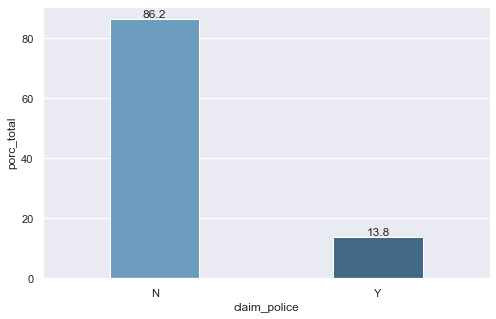

In [248]:
plt.figure(figsize=(8,5))

ax = sns.barplot(x=var, y='porc_total', 
                 data=data.reset_index().sort_values(by='porc_total',ascending=False),palette='Blues_d')
widthbars = [0.4, 0.4]

for p,newwidth in zip(ax.patches,widthbars):
    
    x = p.get_x()
    width = p.get_width()
    centre = x + width/2.
    p.set_x(centre - newwidth/2.)
    p.set_width(newwidth)
    
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), 
                   textcoords = 'offset points',
                   size=12)

plt.show()

In [249]:
df_total.set_index(var,inplace=True)

In [250]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55463, 87)


claim_police  claim_id fraud  claim_amount  claim_date_registered  \
0            N     28976     N       3913.77               20170505   
1            N     13532     N        836.68               20170123   
2            N     31035     N       1989.28               20170519   
3            N     21284     N       2472.99               20170316   
4            N     42769     N       2697.51               20170803   

  claim_alcohol  claim_language                             claim_vehicle_id  \
0           NaN             1.0  YWYzOGY1YzEyMDc4M2Y5MmVkYjNlZjczZGFiZWU3YzU   
1           NaN             1.0                                          NaN   
2           NaN             2.0  OGE3N2Q1MDFlZDc4YjMyNjFmMWNjYmFhYzA2ZTI2YTA   
3           NaN             1.0  YWQ2YTQ5Y2FkNzU5YWFlNjExMWZkOTY2YzMwZTEzZDM   
4           NaN             1.0  ZTIzNmJmYWI1OWU0OGM4OTIyZDkyMzZhNzYzYzMxNTM   

  claim_vehicle_brand claim_vehicle_type  claim_vehicle_date_inuse  \
0               IVECO                NaN                       NaN   
1                 NaN                car                       NaN   
2               SKODA                car                  201408.0   
3          VOLKSWAGEN                car                  201305.0   
4                 KIA                car                  201502.0   

   claim_vehicle_cyl claim_vehicle_load  claim_vehicle_fuel_type  \
0                NaN                NaN                      NaN   
1                NaN                NaN                      2.0   
2             1198.0               1.57                      1.0   
3             1598.0               1.80                      2.0   
4             1582.0               1.92                      2.0   

   claim_vehicle_power                             policy_holder_id  \
0                 85.0  NzhkMWIwZTJlMDg1YjdkNjQxOTI5ZTY5ODM3YzUyNTc   
1                  NaN  YzAyOWFlNThjMGViMzM4Nzg4YjhkYmRhZmUzZWMxNDY   
2                 44.0  NWFlNWQzZGMxYTEzMjc4OGRmNjJkNjg5YTVkNGYzNGM   
3                 66.0  NWFmYWU0ZWMzYjMxNWE3OGI0ZTNmN2E2OWRjZDk4M2M   
4                 81.0  NmE4Njk2MDEzNDRjZDliM2YwZTk4MzQzZjEzNDEzMjU   

   policy_holder_postal_code policy_holder_form  policy_holder_year_birth  \
0                     7730.0                  M                       NaN   
1                     1420.0                  M                       NaN   
2                     2900.0                  F                    1975.0   
3                     1325.0                  M                    1981.0   
4                     1330.0                  M                    1977.0   

  policy_holder_country policy_holder_expert_id  \
0                     B                     NaN   
1                     B                     NaN   
2                     B                     NaN   
3                     B                     NaN   
4                     B                     NaN   

                                     driver_id  driver_postal_code  \
0  NzhkMWIwZTJlMDg1YjdkNjQxOTI5ZTY5ODM3YzUyNTc              7730.0   
1  YzAyOWFlNThjMGViMzM4Nzg4YjhkYmRhZmUzZWMxNDY              1420.0   
2  NWFlNWQzZGMxYTEzMjc4OGRmNjJkNjg5YTVkNGYzNGM              2900.0   
3  NWFmYWU0ZWMzYjMxNWE3OGI0ZTNmN2E2OWRjZDk4M2M              1325.0   
4  NmE4Njk2MDEzNDRjZDliM2YwZTk4MzQzZjEzNDEzMjU              1330.0   

  driver_form  driver_year_birth driver_country driver_expert_id  \
0           M                NaN              B              NaN   
1           M                NaN              B              NaN   
2           F             1975.0              B              NaN   
3           M             1981.0              B              NaN   
4           M             1977.0              B              NaN   

  driver_injured                            driver_vehicle_id  \
0              N  YWYzOGY1YzEyMDc4M2Y5MmVkYjNlZjczZGFiZWU3YzU   
1              N                                          NaN   
2              N  OGE3N2Q1MDFlZDc4YjMyNjFm

In [251]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
claim_police                                                     
Y               2.219738e+07      1070261.60                 53.0
N               9.281583e+07       948998.04                 47.0

In [252]:
### the 53% of the amount of fraud claims is when a policy report was written up

In [253]:
table.to_clipboard(index=True,header=True)

In [254]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [255]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [256]:
data[var].dtype

dtype('O')

In [257]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [258]:
temp.index.dtype

dtype('O')

In [259]:
dict_woe.update(temp.to_dict())

In [260]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [261]:
len(dict_woe)

8

In [262]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [263]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [264]:
data[var+'_cat'] = data[var]

In [265]:
var+'_cat'

'claim_police_cat'

In [266]:
dict_categ = {'claim_police_cat':['N','Y']}

data = categorical(data,dict_categ)

In [267]:
# Get dummies
data = pd.get_dummies(data,
                      columns=data.columns[
                                           np.where(data.dtypes == 'category')
                                           ],
                      drop_first=True
                      )

In [268]:
#data.reset_index(drop=True,inplace=True)
data.drop(['woe',var],axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55463, 87)


claim_id fraud  claim_amount  claim_date_registered claim_alcohol  \
0     28976     N       3913.77               20170505           NaN   
1     13532     N        836.68               20170123           NaN   
2     31035     N       1989.28               20170519           NaN   
3     21284     N       2472.99               20170316           NaN   
4     42769     N       2697.51               20170803           NaN   

   claim_language                             claim_vehicle_id  \
0             1.0  YWYzOGY1YzEyMDc4M2Y5MmVkYjNlZjczZGFiZWU3YzU   
1             1.0                                          NaN   
2             2.0  OGE3N2Q1MDFlZDc4YjMyNjFmMWNjYmFhYzA2ZTI2YTA   
3             1.0  YWQ2YTQ5Y2FkNzU5YWFlNjExMWZkOTY2YzMwZTEzZDM   
4             1.0  ZTIzNmJmYWI1OWU0OGM4OTIyZDkyMzZhNzYzYzMxNTM   

  claim_vehicle_brand claim_vehicle_type  claim_vehicle_date_inuse  \
0               IVECO                NaN                       NaN   
1                 NaN                car                       NaN   
2               SKODA                car                  201408.0   
3          VOLKSWAGEN                car                  201305.0   
4                 KIA                car                  201502.0   

   claim_vehicle_cyl claim_vehicle_load  claim_vehicle_fuel_type  \
0                NaN                NaN                      NaN   
1                NaN                NaN                      2.0   
2             1198.0               1.57                      1.0   
3             1598.0               1.80                      2.0   
4             1582.0               1.92                      2.0   

   claim_vehicle_power                             policy_holder_id  \
0                 85.0  NzhkMWIwZTJlMDg1YjdkNjQxOTI5ZTY5ODM3YzUyNTc   
1                  NaN  YzAyOWFlNThjMGViMzM4Nzg4YjhkYmRhZmUzZWMxNDY   
2                 44.0  NWFlNWQzZGMxYTEzMjc4OGRmNjJkNjg5YTVkNGYzNGM   
3                 66.0  NWFmYWU0ZWMzYjMxNWE3OGI0ZTNmN2E2OWRjZDk4M2M   
4                 81.0  NmE4Njk2MDEzNDRjZDliM2YwZTk4MzQzZjEzNDEzMjU   

   policy_holder_postal_code policy_holder_form  policy_holder_year_birth  \
0                     7730.0                  M                       NaN   
1                     1420.0                  M                       NaN   
2                     2900.0                  F                    1975.0   
3                     1325.0                  M                    1981.0   
4                     1330.0                  M                    1977.0   

  policy_holder_country policy_holder_expert_id  \
0                     B                     NaN   
1                     B                     NaN   
2                     B                     NaN   
3                     B                     NaN   
4                     B                     NaN   

                                     driver_id  driver_postal_code  \
0  NzhkMWIwZTJlMDg1YjdkNjQxOTI5ZTY5ODM3YzUyNTc              7730.0   
1  YzAyOWFlNThjMGViMzM4Nzg4YjhkYmRhZmUzZWMxNDY              1420.0   
2  NWFlNWQzZGMxYTEzMjc4OGRmNjJkNjg5YTVkNGYzNGM              2900.0   
3  NWFmYWU0ZWMzYjMxNWE3OGI0ZTNmN2E2OWRjZDk4M2M              1325.0   
4  NmE4Njk2MDEzNDRjZDliM2YwZTk4MzQzZjEzNDEzMjU              1330.0   

  driver_form  driver_year_birth driver_country driver_expert_id  \
0           M                NaN              B              NaN   
1           M                NaN              B              NaN   
2           F             1975.0              B              NaN   
3           M             1981.0              B              NaN   
4           M             1977.0              B              NaN   

  driver_injured                            driver_vehicle_id  \
0              N  YWYzOGY1YzEyMDc4M2Y5MmVkYjNlZjczZGFiZWU3YzU   
1              N                                          NaN   
2              N  OGE3N2Q1MDFlZDc4YjMyNjFmMWNjYmFhYzA2ZTI2YTA   
3              N  YWQ2YTQ5Y2FkNzU5YWFlNjExMWZkOTY2YzMwZT

In [269]:
#############

In [270]:
var = 'claim_alcohol'

In [271]:
len(df_total[var].unique())

3

In [272]:
df_total[var].unique()

array([nan, 'N', 'P'], dtype=object)

In [273]:
df_total[var] = np.where(df_total[var].isna(),'no_test_taken',df_total[var])

In [274]:
df_total[var].value_counts(normalize=True)

no_test_taken    0.983629
N                0.014352
P                0.002019
Name: claim_alcohol, dtype: float64

In [275]:
data = woe(df_total,var)
#data.sort_index()
data

N    Y  total   porc_N  porc_Y  porc_total       woe
claim_alcohol                                                          
P                109    3    112  97.3214  2.6786      0.2019 -159.5067
no_test_taken  54254  301  54555  99.4483  0.5517     98.3629    0.6519
N                792    4    796  99.4975  0.5025      1.4352   10.0464

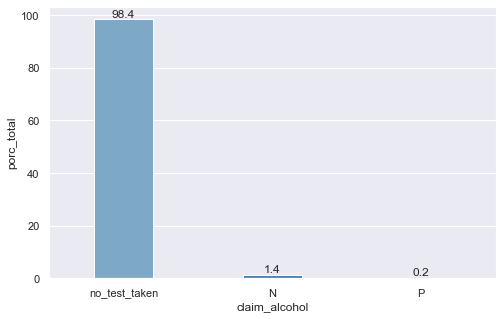

In [276]:
plt.figure(figsize=(8,5))

ax = sns.barplot(x=var, y='porc_total', 
                 data=data.reset_index().sort_values(by='porc_total',ascending=False),palette='Blues_d')
widthbars = [0.4, 0.4, 0.4]

for p,newwidth in zip(ax.patches,widthbars):
    
    x = p.get_x()
    width = p.get_width()
    centre = x + width/2.
    p.set_x(centre - newwidth/2.)
    p.set_width(newwidth)
    
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), 
                   textcoords = 'offset points',
                   size=12)

plt.show()

In [277]:
df_total.set_index(var,inplace=True)

In [278]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55463, 88)


claim_alcohol  claim_id fraud  claim_amount  claim_date_registered  \
0             N     25180     N       1669.85               20170409   
1             N     23198     N       2709.75               20170327   
2             N     44920     N       1385.33               20170819   
3             N     58369     N       1572.09               20171116   
4             N     15841     N       3443.53               20170209   

   claim_language                             claim_vehicle_id  \
0             2.0  ZGVjMzI4ODQ1ODU4ZDViZTg5MzdlNDk2OGEzNWMyZDM   
1             1.0  OTFlNjcwNzYwZDEzYTE5YWQxMjNlNmYzZTYwZjYwMGU   
2             2.0  MGQzODVkM2Y3MGIwN2FiMzc2MDU3ODE5OTc0NDY3YmE   
3             1.0  ODg5MGY4MDg0NWFhMDJlZGI3MzA4ZDVlZDNiZjk0OTY   
4             2.0  YWJhNDY1NTJlMjAxNGQ1ZjA5ODk1ZTc0ZjQyNzcxM2E   

  claim_vehicle_brand claim_vehicle_type  claim_vehicle_date_inuse  \
0                OPEL                car                  201404.0   
1             PEUGEOT                van                  201008.0   
2             PEUGEOT                car                  201409.0   
3          VOLKSWAGEN                car                  201310.0   
4             CITROEN                van                  201406.0   

   claim_vehicle_cyl claim_vehicle_load  claim_vehicle_fuel_type  \
0             1598.0               2.03                      2.0   
1             2198.0               3.50                      2.0   
2             1398.0               1.58                      2.0   
3             1198.0               1.55                      1.0   
4             2198.0               3.50                      2.0   

   claim_vehicle_power                             policy_holder_id  \
0                 66.0  YTg4OWM3YTA1YTM1ZTNjMWFhYTQ3YjY3N2Y5ZDAyOTk   
1                 88.0  OTEwZTlhMjUxMjg1NDYyYzVlZDViZjdmM2QxMmNhNjU   
2                 50.0  YjgxZDFlMTg0MWUzZDA3NTdmZTgwNmVkNDkwMWZlNjE   
3                 51.0  YmQyMTJiMDBjMWExNWQxYWQwYzdhYWE1ZmFmMzQ0ODg   
4                 96.0  ODFmODZiOGRlNTg0MWEzMjIyYzUyMjE5NDQ2NTE5YjQ   

   policy_holder_postal_code policy_holder_form  policy_holder_year_birth  \
0                     8500.0                  F                    1961.0   
1                     6061.0                  M                    1974.0   
2                     8200.0                  M                    1988.0   
3                     7500.0                  F                    1965.0   
4                     3590.0                  M                    1987.0   

  policy_holder_country policy_holder_expert_id  \
0                     B                     NaN   
1                     B                     NaN   
2                     B                     NaN   
3                     B                     NaN   
4                     B                     NaN   

                                     driver_id  driver_postal_code  \
0  YTg4OWM3YTA1YTM1ZTNjMWFhYTQ3YjY3N2Y5ZDAyOTk              8500.0   
1  OTEwZTlhMjUxMjg1NDYyYzVlZDViZjdmM2QxMmNhNjU              6061.0   
2  YjgxZDFlMTg0MWUzZDA3NTdmZTgwNmVkNDkwMWZlNjE              8200.0   
3  YmQyMTJiMDBjMWExNWQxYWQwYzdhYWE1ZmFmMzQ0ODg              7500.0   
4  ODFmODZiOGRlNTg0MWEzMjIyYzUyMjE5NDQ2NTE5YjQ              3590.0   

  driver_form  driver_year_birth driver_country driver_expert_id  \
0           F             1961.0              B              NaN   
1           M             1974.0              B              NaN   
2           M             1988.0              B              NaN   
3           F             1965.0              B              NaN   
4           M             1987.0              B              NaN   

  driver_injured                            driver_vehicle_id  \
0              N  ZGVjMzI4ODQ1ODU4ZDViZTg5MzdlNDk2OGEzNWMyZDM   
1              N  OTFlNjcwNzYwZDEzYTE5YWQxMjNlNmYzZTYwZjYwMGU   
2              N  MGQzODVkM2Y3MGIwN2FiMzc2MDU3ODE5OTc0NDY3YmE   
3              N  ODg5MGY4MDg0NWFhMDJlZGI3MzA4ZDVlZDNiZ

In [279]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
claim_alcohol                                                     
no_test_taken    1.107307e+08      1970016.22                97.56
N                3.878194e+06        41467.52                 2.05
P                4.042756e+05         7775.90                 0.39

In [280]:
### the 97.5% of the amount of fraud claims is when no alcohol test was taken

In [281]:
table.to_clipboard(index=True,header=True)

In [282]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [283]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [284]:
data[var].dtype

dtype('O')

In [285]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [286]:
temp.index.dtype

dtype('O')

In [287]:
dict_woe.update(temp.to_dict())

In [288]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [289]:
len(dict_woe)

9

In [290]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [291]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [292]:
#data.reset_index(drop=True,inplace=True)
data.drop(['woe',var],axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55463, 87)


claim_id fraud  claim_amount  claim_date_registered  claim_language  \
0     25180     N       1669.85               20170409             2.0   
1     23198     N       2709.75               20170327             1.0   
2     44920     N       1385.33               20170819             2.0   
3     58369     N       1572.09               20171116             1.0   
4     15841     N       3443.53               20170209             2.0   

                              claim_vehicle_id claim_vehicle_brand  \
0  ZGVjMzI4ODQ1ODU4ZDViZTg5MzdlNDk2OGEzNWMyZDM                OPEL   
1  OTFlNjcwNzYwZDEzYTE5YWQxMjNlNmYzZTYwZjYwMGU             PEUGEOT   
2  MGQzODVkM2Y3MGIwN2FiMzc2MDU3ODE5OTc0NDY3YmE             PEUGEOT   
3  ODg5MGY4MDg0NWFhMDJlZGI3MzA4ZDVlZDNiZjk0OTY          VOLKSWAGEN   
4  YWJhNDY1NTJlMjAxNGQ1ZjA5ODk1ZTc0ZjQyNzcxM2E             CITROEN   

  claim_vehicle_type  claim_vehicle_date_inuse  claim_vehicle_cyl  \
0                car                  201404.0             1598.0   
1                van                  201008.0             2198.0   
2                car                  201409.0             1398.0   
3                car                  201310.0             1198.0   
4                van                  201406.0             2198.0   

  claim_vehicle_load  claim_vehicle_fuel_type  claim_vehicle_power  \
0               2.03                      2.0                 66.0   
1               3.50                      2.0                 88.0   
2               1.58                      2.0                 50.0   
3               1.55                      1.0                 51.0   
4               3.50                      2.0                 96.0   

                              policy_holder_id  policy_holder_postal_code  \
0  YTg4OWM3YTA1YTM1ZTNjMWFhYTQ3YjY3N2Y5ZDAyOTk                     8500.0   
1  OTEwZTlhMjUxMjg1NDYyYzVlZDViZjdmM2QxMmNhNjU                     6061.0   
2  YjgxZDFlMTg0MWUzZDA3NTdmZTgwNmVkNDkwMWZlNjE                     8200.0   
3  YmQyMTJiMDBjMWExNWQxYWQwYzdhYWE1ZmFmMzQ0ODg                     7500.0   
4  ODFmODZiOGRlNTg0MWEzMjIyYzUyMjE5NDQ2NTE5YjQ                     3590.0   

  policy_holder_form  policy_holder_year_birth policy_holder_country  \
0                  F                    1961.0                     B   
1                  M                    1974.0                     B   
2                  M                    1988.0                     B   
3                  F                    1965.0                     B   
4                  M                    1987.0                     B   

  policy_holder_expert_id                                    driver_id  \
0                     NaN  YTg4OWM3YTA1YTM1ZTNjMWFhYTQ3YjY3N2Y5ZDAyOTk   
1                     NaN  OTEwZTlhMjUxMjg1NDYyYzVlZDViZjdmM2QxMmNhNjU   
2                     NaN  YjgxZDFlMTg0MWUzZDA3NTdmZTgwNmVkNDkwMWZlNjE   
3                     NaN  YmQyMTJiMDBjMWExNWQxYWQwYzdhYWE1ZmFmMzQ0ODg   
4                     NaN  ODFmODZiOGRlNTg0MWEzMjIyYzUyMjE5NDQ2NTE5YjQ   

   driver_postal_code driver_form  driver_year_birth driver_country  \
0              8500.0           F             1961.0              B   
1              6061.0           M             1974.0              B   
2              8200.0           M             1988.0              B   
3              7500.0           F             1965.0              B   
4              3590.0           M             1987.0              B   

  driver_expert_id driver_injured  \
0              NaN              N   
1              NaN              N   
2              NaN              N   
3              NaN              N   
4              NaN              N   

                             driver_vehicle_id third_party_1_id  \
0  ZGVjMzI4ODQ1ODU4ZDViZTg5MzdlNDk2OGEzNWMyZDM              NaN   
1  OTFlNjcwNzYwZDEzYTE5YWQxMjNlNmYzZTYwZjYwMGU              NaN   
2  MGQzODVkM2Y3MGIwN2FiMzc2MDU3ODE5OTc0NDY3YmE              NaN   
3  ODg5MGY4MDg0NWFhMDJlZGI3MzA4ZDVlZDNiZjk

In [293]:
#############

In [294]:
var = 'claim_language'

In [295]:
len(df_total[var].unique())

3

In [296]:
df_total[var].unique()

array([ 2.,  1., nan])

In [297]:
df_total[var] = np.where(df_total[var].isna(),'missing',df_total[var])

In [298]:
df_total[var].value_counts(normalize=True)

2.0        0.707553
1.0        0.291672
missing    0.000775
Name: claim_language, dtype: float64

In [299]:
### we decided eliminate the rows with missing values in this variable because it's just the 0.07% of dataset
df_total = df_total.loc[df_total[var]!='missing',:]
df_total.shape

(55420, 87)

In [300]:
data = woe(df_total,var)
#data.sort_index()
data

N    Y  total   porc_N  porc_Y  porc_total      woe
claim_language                                                         
1.0             16007  170  16177  98.9491  1.0509     29.1898 -64.2040
2.0             39105  138  39243  99.6483  0.3517     70.8102  45.9729

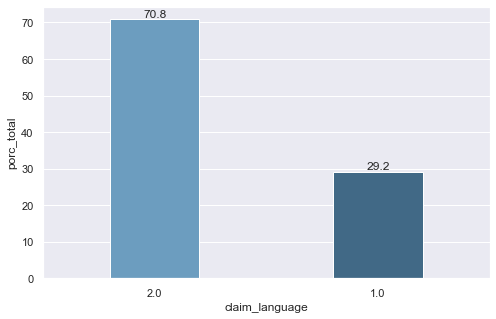

In [301]:
plt.figure(figsize=(8,5))

ax = sns.barplot(x=var, y='porc_total', 
                 data=data.reset_index().sort_values(by='porc_total',ascending=False),palette='Blues_d')
widthbars = [0.4, 0.4]

for p,newwidth in zip(ax.patches,widthbars):
    
    x = p.get_x()
    width = p.get_width()
    centre = x + width/2.
    p.set_x(centre - newwidth/2.)
    p.set_width(newwidth)
    
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), 
                   textcoords = 'offset points',
                   size=12)

plt.show()

In [302]:
df_total.set_index(var,inplace=True)

In [303]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55420, 88)


claim_language  claim_id fraud  claim_amount  claim_date_registered  \
0            1.0     23198     N       2709.75               20170327   
1            1.0     58369     N       1572.09               20171116   
2            1.0     37684     N       4408.93               20170626   
3            1.0     63392     N       2581.07               20171216   
4            1.0     22334     N       3910.29               20170323   

                              claim_vehicle_id claim_vehicle_brand  \
0  OTFlNjcwNzYwZDEzYTE5YWQxMjNlNmYzZTYwZjYwMGU             PEUGEOT   
1  ODg5MGY4MDg0NWFhMDJlZGI3MzA4ZDVlZDNiZjk0OTY          VOLKSWAGEN   
2  NjA4NWE2MzFmOWM5ZTg3MTc4YWYxYjU5YzVhNDcxNjQ              SUZUKI   
3  M2M5YjY1NzY1YTI2MjZjOTE2NDExYzQ0YWI0MDI0N2U             HYUNDAI   
4  NTBhZjJlYjI3MDZlMzViMGNhNGJhYmIyNjA3OTBlYWU                 BMW   

  claim_vehicle_type  claim_vehicle_date_inuse  claim_vehicle_cyl  \
0                van                  201008.0             2198.0   
1                car                  201310.0             1198.0   
2                car                  201008.0             1298.0   
3                car                  201404.0             1248.0   
4                car                  200904.0             1995.0   

  claim_vehicle_load  claim_vehicle_fuel_type  claim_vehicle_power  \
0               3.50                      2.0                 88.0   
1               1.55                      1.0                 51.0   
2               1.35                      1.0                 56.0   
3               1.51                      1.0                 62.0   
4               1.85                      2.0                100.0   

                              policy_holder_id  policy_holder_postal_code  \
0  OTEwZTlhMjUxMjg1NDYyYzVlZDViZjdmM2QxMmNhNjU                     6061.0   
1  YmQyMTJiMDBjMWExNWQxYWQwYzdhYWE1ZmFmMzQ0ODg                     7500.0   
2  YzNlOGZhNzcwMmJmMWQ3OTdlOWU3ZmYyOWRiNmU3NjA                     6900.0   
3  Mzk2ZGU1NjEyYzcxMTA4Zjg1MWNmYTRhNzk2ODcyNTQ                     4460.0   
4  NjAwYWZkOGQ5NjZlZDdhNTY0OWMxYTRiOTc5MjEzZjc                     7730.0   

  policy_holder_form  policy_holder_year_birth policy_holder_country  \
0                  M                    1974.0                     B   
1                  F                    1965.0                     B   
2                  F                    1954.0                     B   
3                  F                    1987.0                     B   
4                  M                    1987.0                     B   

                       policy_holder_expert_id  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3  ZTZmNmNmMDkxZDM1MjFlYjdmNWE0YzRiY2Q0NGFkMzU   
4  MmUzNGQxYTVjMGFiMDQ4OTY4MDZiOGY1NjU1NGExOTI   

                                     driver_id  driver_postal_code  \
0  OTEwZTlhMjUxMjg1NDYyYzVlZDViZjdmM2QxMmNhNjU              6061.0   
1  YmQyMTJiMDBjMWExNWQxYWQwYzdhYWE1ZmFmMzQ0ODg              7500.0   
2  YzNlOGZhNzcwMmJmMWQ3OTdlOWU3ZmYyOWRiNmU3NjA              6900.0   
3  Mzk2ZGU1NjEyYzcxMTA4Zjg1MWNmYTRhNzk2ODcyNTQ              4460.0   
4  NjAwYWZkOGQ5NjZlZDdhNTY0OWMxYTRiOTc5MjEzZjc              7730.0   

  driver_form  driver_year_birth driver_country  \
0           M             1974.0              B   
1           F             1965.0              B   
2           F             1954.0              B   
3           F             1987.0              B   
4           M             1987.0              B   

                              driver_expert_id driver_injured  \
0                                          NaN              N   
1                                          NaN              N   
2                                          NaN              Y   
3  ZTZmNmNmMDkxZDM1MjFlYjdmNWE0YzRiY2Q0NGFkMzU              N   
4  MmUzNGQxYTVjMGFiMDQ4OTY4MDZiOGY1NjU1NGExOTI          

In [304]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
claim_language                                                     
1.0                33043582.86      1246153.10                61.71
2.0                81886817.78       773106.54                38.29

In [305]:
### the 61% of the amount of fraud claims is when the claim was registered in language 1

In [306]:
table.to_clipboard(index=True,header=True)

In [307]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [308]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [309]:
data[var].dtype

dtype('O')

In [310]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [311]:
temp.index.dtype

dtype('O')

In [312]:
dict_woe.update(temp.to_dict())

In [313]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [314]:
len(dict_woe)

10

In [315]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [316]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [317]:
data[var+'_cat'] = data[var].astype(str)

In [318]:
var+'_cat'

'claim_language_cat'

In [319]:
data[var+'_cat'].unique()

array(['1.0', '2.0'], dtype=object)

In [320]:
dict_categ = {'claim_language_cat':['2.0','1.0']}

data = categorical(data,dict_categ)

In [321]:
# Get dummies
data = pd.get_dummies(data,
                      columns=data.columns[
                                           np.where(data.dtypes == 'category')
                                           ],
                      drop_first=True
                      )

In [322]:
#data.reset_index(drop=True,inplace=True)
data.drop(['woe',var],axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55420, 88)


claim_id fraud  claim_amount  claim_date_registered  \
0     23198     N       2709.75               20170327   
1     58369     N       1572.09               20171116   
2     37684     N       4408.93               20170626   
3     63392     N       2581.07               20171216   
4     22334     N       3910.29               20170323   

                              claim_vehicle_id claim_vehicle_brand  \
0  OTFlNjcwNzYwZDEzYTE5YWQxMjNlNmYzZTYwZjYwMGU             PEUGEOT   
1  ODg5MGY4MDg0NWFhMDJlZGI3MzA4ZDVlZDNiZjk0OTY          VOLKSWAGEN   
2  NjA4NWE2MzFmOWM5ZTg3MTc4YWYxYjU5YzVhNDcxNjQ              SUZUKI   
3  M2M5YjY1NzY1YTI2MjZjOTE2NDExYzQ0YWI0MDI0N2U             HYUNDAI   
4  NTBhZjJlYjI3MDZlMzViMGNhNGJhYmIyNjA3OTBlYWU                 BMW   

  claim_vehicle_type  claim_vehicle_date_inuse  claim_vehicle_cyl  \
0                van                  201008.0             2198.0   
1                car                  201310.0             1198.0   
2                car                  201008.0             1298.0   
3                car                  201404.0             1248.0   
4                car                  200904.0             1995.0   

  claim_vehicle_load  claim_vehicle_fuel_type  claim_vehicle_power  \
0               3.50                      2.0                 88.0   
1               1.55                      1.0                 51.0   
2               1.35                      1.0                 56.0   
3               1.51                      1.0                 62.0   
4               1.85                      2.0                100.0   

                              policy_holder_id  policy_holder_postal_code  \
0  OTEwZTlhMjUxMjg1NDYyYzVlZDViZjdmM2QxMmNhNjU                     6061.0   
1  YmQyMTJiMDBjMWExNWQxYWQwYzdhYWE1ZmFmMzQ0ODg                     7500.0   
2  YzNlOGZhNzcwMmJmMWQ3OTdlOWU3ZmYyOWRiNmU3NjA                     6900.0   
3  Mzk2ZGU1NjEyYzcxMTA4Zjg1MWNmYTRhNzk2ODcyNTQ                     4460.0   
4  NjAwYWZkOGQ5NjZlZDdhNTY0OWMxYTRiOTc5MjEzZjc                     7730.0   

  policy_holder_form  policy_holder_year_birth policy_holder_country  \
0                  M                    1974.0                     B   
1                  F                    1965.0                     B   
2                  F                    1954.0                     B   
3                  F                    1987.0                     B   
4                  M                    1987.0                     B   

                       policy_holder_expert_id  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3  ZTZmNmNmMDkxZDM1MjFlYjdmNWE0YzRiY2Q0NGFkMzU   
4  MmUzNGQxYTVjMGFiMDQ4OTY4MDZiOGY1NjU1NGExOTI   

                                     driver_id  driver_postal_code  \
0  OTEwZTlhMjUxMjg1NDYyYzVlZDViZjdmM2QxMmNhNjU              6061.0   
1  YmQyMTJiMDBjMWExNWQxYWQwYzdhYWE1ZmFmMzQ0ODg              7500.0   
2  YzNlOGZhNzcwMmJmMWQ3OTdlOWU3ZmYyOWRiNmU3NjA              6900.0   
3  Mzk2ZGU1NjEyYzcxMTA4Zjg1MWNmYTRhNzk2ODcyNTQ              4460.0   
4  NjAwYWZkOGQ5NjZlZDdhNTY0OWMxYTRiOTc5MjEzZjc              7730.0   

  driver_form  driver_year_birth driver_country  \
0           M             1974.0              B   
1           F             1965.0              B   
2           F             1954.0              B   
3           F             1987.0              B   
4           M             1987.0              B   

                              driver_expert_id driver_injured  \
0                                          NaN              N   
1                                          NaN              N   
2                                          NaN              Y   
3  ZTZmNmNmMDkxZDM1MjFlYjdmNWE0YzRiY2Q0NGFkMzU              N   
4  MmUzNGQxYTVjMGFiMDQ4OTY4MDZiOGY1NjU1NGExOTI              N   

                             driver_vehicle_id third_party_1_id  \
0  OTFlNjcwNzY

In [323]:
#############

In [324]:
var = 'claim_vehicle_id'

In [325]:
df_total[~df_total[var].isna()].shape

(45094, 88)

In [326]:
len(df_total.loc[~df_total[var].isna(),var].unique())

40571

In [327]:
prueba = df_total.loc[~df_total[var].isna(),:].copy()
print(prueba.shape)
prueba = prueba[prueba.duplicated(subset=[var],keep=False)].copy()
print(prueba.shape)

(45094, 88)
(8582, 88)


In [328]:
prueba[prueba['fraud']=='Y'].head()

claim_id fraud  claim_amount  claim_date_registered  \
184      51978     Y        792.00               20171005   
258      62086     Y       1507.00               20171208   
414      56367     Y       2986.42               20171102   
727      55849     Y       3101.59               20171029   
1152     63218     Y       1734.42               20171215   

                                 claim_vehicle_id claim_vehicle_brand  \
184   NTEwNjgxYjU0YzBmNWM5ZTI2MDU4M2YyYWY5NjFlN2M                FORD   
258   OTJmMTY1ZjU3ZjJkMzM4ODRiZThhYjdiZGQwMGFkZmU          VOLKSWAGEN   
414   ZDA1NzE5OGM5ZmM5MWMzODUzMmQ5MzU4MWFhOWRiZWI                 BMW   
727   MTQyMzRmNzQwODA0ZGMzNTgzYzcwMzFmZWQ2NjUyZTg               DACIA   
1152  MjljNzRhMDQzMTJhOTdiZGM2YjVjODRkNzhlM2E2NmE                OPEL   

     claim_vehicle_type  claim_vehicle_date_inuse  claim_vehicle_cyl  \
184                 car                  200809.0             1399.0   
258                 car                  200202.0             1896.0   
414                 car                  200906.0             1995.0   
727                 car                  201408.0             1461.0   
1152                car                  201309.0             1229.0   

     claim_vehicle_load  claim_vehicle_fuel_type  claim_vehicle_power  \
184                1.56                      2.0                 50.0   
258                1.82                      2.0                 66.0   
414                1.94                      2.0                100.0   
727                1.87                      2.0                 79.0   
1152               1.47                      1.0                 51.0   

                                 policy_holder_id  policy_holder_postal_code  \
184   MGJiMWFkZGNmMmUyYmZhMjA1YThhNDM5YWJjZmI5Nzc                     4020.0   
258   OWNhZGE0YjM0NDBmYjk0ZWM0NWFlMmRjNjQ5ZjQyOTQ                     5030.0   
414   ZmJiOGFmODdlMGZmNjFmZWNkMDMxM2RkMjc2MWNkYzQ                     1410.0   
727   MGIxZWRiNmI3NGIwMzAwOTQ5ZDAzYjdmMmQ3NTY1MmY                     5030.0   
1152  MWJiYTAxZTZmOTU5MjU0YTQ3N2E4YmE4NTIxNWFlYzI                     8020.0   

     policy_holder_form  policy_holder_year_birth policy_holder_country  \
184                   M                    1994.0                     B   
258                   M                    1991.0                     B   
414                   F                    1959.0                     B   
727                   F                    1975.0                     B   
1152                  F                    1982.0                     B   

     policy_holder_expert_id                                    driver_id  \
184                      NaN  YTA0OGJhNWU2Y2RkN2Q0YjcwMGY1M2ZhYzg5YzM3ZmY   
258                      NaN  OWNhZGE0YjM0NDBmYjk0ZWM0NWFlMmRjNjQ5ZjQyOTQ   
414                      NaN  ZmJiOGFmODdlMGZmNjFmZWNkMDMxM2RkMjc2MWNkYzQ   
727                      NaN  MGIxZWRiNmI3NGIwMzAwOTQ5ZDAzYjdmMmQ3NTY1MmY   
1152                     NaN  MWJiYTAxZTZmOTU5MjU0YTQ3N2E4YmE4NTIxNWFlYzI   

      driver_postal_code driver_form  driver_year_birth driver_country  \
184               4350.0           F             1968.0              B   
258               5030.0           M             1991.0              B   
414               1410.0           F             1959.0              B   
727               5030.0           F             1975.0              B   
1152              8020.0           F             1982.0              B   

     driver_expert_id driver_injured  \
184               NaN              N   
258               NaN              N   
414               NaN              N   
727               NaN              N   
1152              NaN              N   

                                driver_vehicle_id third_party_1_id  \
184   NTEwNjgxYjU0YzBmNWM5ZTI2MDU4M2YyYWY5NjFlN2M              NaN   
258   OTJmMTY1ZjU3ZjJkMzM4ODRiZThhYjdiZGQwMGFkZmU              NaN   
414   ZDA1NzE5OGM5ZmM5MWMzODUzMmQ5MzU

In [329]:
prueba['fraud'].value_counts()

N    8532
Y      50
Name: fraud, dtype: int64

In [330]:
#df_total[df_total[var]=='OTJmMTY1ZjU3ZjJkMzM4ODRiZThhYjdiZGQwMGFkZmU']

In [331]:
columns_drop = [col for col in df_total.columns if 'id' in col]
columns_drop

['claim_id',
 'claim_vehicle_id',
 'policy_holder_id',
 'policy_holder_expert_id',
 'driver_id',
 'driver_expert_id',
 'driver_vehicle_id',
 'third_party_1_id',
 'third_party_1_vehicle_id',
 'third_party_1_expert_id',
 'third_party_2_id',
 'third_party_2_vehicle_id',
 'third_party_2_expert_id',
 'third_party_3_id',
 'third_party_3_vehicle_id',
 'third_party_3_expert_id',
 'repair_id']

In [332]:
prueba = df_total.loc[df_total['fraud']=='Y',columns_drop].copy()
prueba.reset_index(drop=True,inplace=True)

In [333]:
print(prueba.shape)
prueba.head()

(308, 17)


claim_id                             claim_vehicle_id  \
0     16474  ZjY4MTlhZGUxMGFmYjY0MWRiNDg0N2EyY2ZmYWQ4YjQ   
1     51978  NTEwNjgxYjU0YzBmNWM5ZTI2MDU4M2YyYWY5NjFlN2M   
2     31278  NmVjNjQ5MzgyZTBjNTliZjdhNjAxNzEyMTg2ZDFmZTM   
3     62086  OTJmMTY1ZjU3ZjJkMzM4ODRiZThhYjdiZGQwMGFkZmU   
4     48538  MGEyNmY2ZmJlMzBjOTRmMDg1OTE4ZTkxNjM3MDI2OTA   

                              policy_holder_id policy_holder_expert_id  \
0  ZWE4MzM3MzZiM2UwNzc0ZTg5NTQyZjNhODMzOTUwODM                     NaN   
1  MGJiMWFkZGNmMmUyYmZhMjA1YThhNDM5YWJjZmI5Nzc                     NaN   
2  NDY3ZTlkMTFjYTc3ZjFhY2QyMDUwZDRjZjNmMmJmYmY                     NaN   
3  OWNhZGE0YjM0NDBmYjk0ZWM0NWFlMmRjNjQ5ZjQyOTQ                     NaN   
4  OTJkZGNiZDdjMmJlMWNmZGI1Y2I3YTM0YjI4MjczZjM                     NaN   

                                     driver_id  \
0  ZWE4MzM3MzZiM2UwNzc0ZTg5NTQyZjNhODMzOTUwODM   
1  YTA0OGJhNWU2Y2RkN2Q0YjcwMGY1M2ZhYzg5YzM3ZmY   
2  NjVjZTliZTZiZjdjN2UxMGQwOWNiYzcwNmEzNjExYWU   
3  OWNhZGE0YjM0NDBmYjk0ZWM0NWFlMmRjNjQ5ZjQyOTQ   
4  OTJkZGNiZDdjMmJlMWNmZGI1Y2I3YTM0YjI4MjczZjM   

                              driver_expert_id  \
0                                          NaN   
1                                          NaN   
2  NDUzN2I1YmYwYTRhM2FjZGVkMjdiMzg0N2MwOTdhNmI   
3                                          NaN   
4                                          NaN   

                             driver_vehicle_id  \
0  ZjY4MTlhZGUxMGFmYjY0MWRiNDg0N2EyY2ZmYWQ4YjQ   
1  NTEwNjgxYjU0YzBmNWM5ZTI2MDU4M2YyYWY5NjFlN2M   
2  NmVjNjQ5MzgyZTBjNTliZjdhNjAxNzEyMTg2ZDFmZTM   
3  OTJmMTY1ZjU3ZjJkMzM4ODRiZThhYjdiZGQwMGFkZmU   
4  MGEyNmY2ZmJlMzBjOTRmMDg1OTE4ZTkxNjM3MDI2OTA   

                              third_party_1_id third_party_1_vehicle_id  \
0  MWNlMzU2MWNmOTgwM2Y2M2IxZDU5ZTlkMGFiYmNiY2E                      NaN   
1                                          NaN                      NaN   
2  OWRjMTBkZTdiOTkyZmVkNmRmODQxZDFmNjQ5NjEwZDg                      NaN   
3                                          NaN                      NaN   
4                                          NaN                      NaN   

                       third_party_1_expert_id third_party_2_id  \
0  NDcyZDQ2Y2I4MjkwMThmOWRiZDY1ZmI4NDc5YTQ5YmI              NaN   
1                                          NaN              NaN   
2                                          NaN              NaN   
3                                          NaN              NaN   
4                                          NaN              NaN   

  third_party_2_vehicle_id third_party_2_expert_id third_party_3_id  \
0                      NaN                     NaN              NaN   
1                      NaN                     NaN              NaN   
2                      NaN                     NaN              NaN   
3                      NaN                     NaN              NaN   
4                      NaN                     NaN              NaN   

  third_party_3_vehicle_id  third_party_3_expert_id  \
0                      NaN                      NaN   
1                      NaN                      NaN   
2                      NaN                      NaN   
3                      NaN                      NaN   
4                      NaN                      NaN   

                                     repair_id  
0                                          NaN  
1                                          NaN  
2  OThjYjU3MDFiODVhNjI1NzdlMDc0NDdjZjg1N2Q0NTM  
3  MGVlNjM4MjJmYWIzYjI3ZTZiYzdmZmY5YjY5N2U1MGM  
4  MmNkZGEyOTk2M2IwZGY4ODZlNTdmODg1NDMwZTdhY2E

In [334]:
# Getting missing

cols = prueba.columns

temp = pd.DataFrame()

for col in cols:
    temp_count = pd.DataFrame([[col,round(df_total[col].isna().sum()/df_total.shape[0]*100,2)]],
                              columns=['variable','missing'])
    temp = temp.append(temp_count)

temp = pd.DataFrame(temp).sort_values(by=['missing'],ascending=False).reset_index(drop=True)
temp

variable  missing
0    third_party_3_expert_id   100.00
1   third_party_3_vehicle_id    99.97
2           third_party_3_id    99.95
3    third_party_2_expert_id    99.95
4    third_party_1_expert_id    98.82
5   third_party_2_vehicle_id    94.83
6           third_party_2_id    92.39
7    policy_holder_expert_id    82.72
8           driver_expert_id    75.21
9                  repair_id    54.30
10  third_party_1_vehicle_id    34.10
11          third_party_1_id    24.78
12          claim_vehicle_id    18.63
13         driver_vehicle_id    18.61
14                 driver_id     0.00
15          policy_holder_id     0.00
16                  claim_id     0.00

In [335]:
len(prueba['driver_vehicle_id'].unique())

258

In [336]:
df_total.drop(columns_drop,axis=1,inplace=True)

In [337]:
df_total.shape

(55420, 71)

In [338]:
#############

In [339]:
var = 'claim_vehicle_brand'

In [340]:
len(df_total[var].unique())

36

In [341]:
df_total[var].unique()

array(['PEUGEOT', 'VOLKSWAGEN', 'SUZUKI', 'HYUNDAI', 'BMW', 'NISSAN',
       'OPEL', 'SEAT', 'CITROEN', 'FORD', 'SKODA', nan, 'VOLVO', 'DACIA',
       'RENAULT', 'MERCEDES', 'MINI', 'FIAT', 'AUDI', 'TOYOTA', 'MAZDA',
       'KIA', 'CHEVROLET', 'ALFA ROMEO', 'HONDA', 'LANCIA', 'CHRYSLER',
       'LAND ROVER', 'IVECO', 'PORSCHE', 'MITSUBISHI', 'JEEP', 'JAGUAR',
       'DODGE', 'SSANGYONG', 'SAAB'], dtype=object)

In [342]:
df_total[var] = np.where(df_total[var].isna(),'missing',df_total[var])

In [343]:
data = woe(df_total,var)
#data.sort_index()
data

N   Y  total    porc_N  porc_Y  porc_total       woe
claim_vehicle_brand                                                         
PORSCHE                80   2     82   97.5610  2.4390      0.1480 -149.8144
MINI                  308   6    314   98.0892  1.9108      0.5666 -124.8683
JEEP                   65   1     66   98.4848  1.5152      0.1191 -101.2636
CHRYSLER               74   1     75   98.6667  1.3333      0.1353  -88.2958
BMW                  2459  31   2490   98.7550  1.2450      4.4930  -81.3500
DACIA                 861   9    870   98.9655  1.0345      1.5698  -62.6153
FIAT                 1285  12   1297   99.0748  0.9252      2.3403  -51.3416
ALFA ROMEO            327   3    330   99.0909  0.9091      0.5955  -49.5675
MERCEDES             2313  20   2333   99.1427  0.8573      4.2097  -43.6455
KIA                   853   7    860   99.1860  0.8140      1.5518  -38.4174
AUDI                 2061  16   2077   99.2297  0.7703      3.7477  -32.8665
SUZUKI                496   3    499   99.3988  0.6012      0.9004   -7.9059
CITROEN              3802  22   3824   99.4247  0.5753      6.9000   -3.4783
LAND ROVER            177   1    178   99.4382  0.5618      0.3212   -1.0873
VOLKSWAGEN           4874  27   4901   99.4491  0.5509      8.8434    0.8810
HYUNDAI              1103   6   1109   99.4590  0.5410      2.0011    2.7007
PEUGEOT              3854  19   3873   99.5094  0.4906      6.9885   12.5405
missing              9890  46   9936   99.5370  0.4630     17.9285   18.3615
RENAULT              3492  16   3508   99.5439  0.4561      6.3298   19.8618
VOLVO                 886   4    890   99.5506  0.4494      1.6059   21.3400
NISSAN               1345   6   1351   99.5559  0.4441      2.4377   22.5367
SKODA                 931   4    935   99.5722  0.4278      1.6871   26.2942
FORD                 3735  16   3751   99.5734  0.4266      6.7683   26.5891
MAZDA                 540   2    542   99.6310  0.3690      0.9780   41.1399
OPEL                 4748  17   4765   99.6432  0.3568      8.5980   44.5242
SEAT                  878   3    881   99.6595  0.3405      1.5897   49.2011
TOYOTA               1986   6   1992   99.6988  0.3012      3.5944   61.5095
MITSUBISHI            390   1    391   99.7442  0.2558      0.7055   77.9124
CHEVROLET             391   1    392   99.7449  0.2551      0.7073   78.1685
JAGUAR                 75   0     75  100.0000  0.0000      0.1353       inf
DODGE                  81   0     81  100.0000  0.0000      0.1462       inf
SAAB                  102   0    102  100.0000  0.0000      0.1840       inf
HONDA                 381   0    381  100.0000  0.0000      0.6875       inf
SSANGYONG              65   0     65  100.0000  0.0000      0.1173       inf
LANCIA                110   0    110  100.0000  0.0000      0.1985       inf
IVECO                  94   0     94  100.0000  0.0000      0.1696       inf

In [344]:
data.to_clipboard(index=True,header=True)

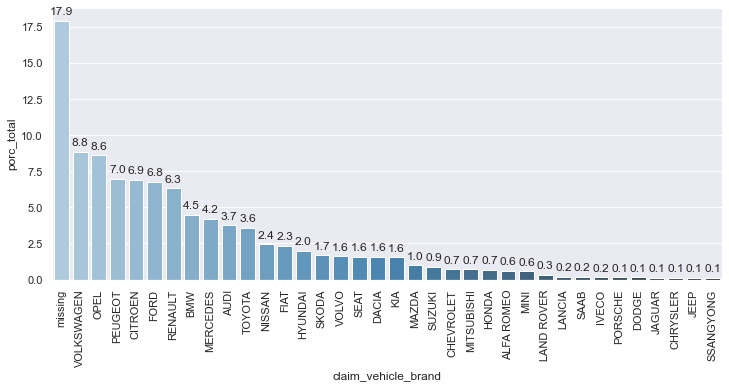

In [345]:
plt.figure(figsize=(12,5))

ax = sns.barplot(x=var, y='porc_total', 
                 data=data.reset_index().sort_values(by='porc_total',ascending=False),palette='Blues_d')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.xticks(rotation=90)
plt.show()

In [346]:
df_total.set_index(var,inplace=True)

In [347]:
data = df_total.join(data[['woe']])
data.reset_index(inplace=True)
print(data.shape)
data.head()

(55420, 72)


claim_vehicle_brand fraud  claim_amount  claim_date_registered  \
0          ALFA ROMEO     N       6346.16               20170511   
1          ALFA ROMEO     N       1118.03               20170430   
2          ALFA ROMEO     N       1424.16               20170130   
3          ALFA ROMEO     N       4493.50               20170116   
4          ALFA ROMEO     N       1101.89               20170130   

  claim_vehicle_type  claim_vehicle_date_inuse  claim_vehicle_cyl  \
0                car                  201103.0             1248.0   
1                car                  201107.0             1248.0   
2                car                  201310.0             1368.0   
3                car                  201301.0             1956.0   
4                car                  201402.0             1598.0   

  claim_vehicle_load  claim_vehicle_fuel_type  claim_vehicle_power  \
0               1.63                      2.0                 66.0   
1               1.63                      2.0                 62.0   
2               1.78                      1.0                 85.0   
3               1.82                      2.0                100.0   
4               1.81                      2.0                 77.0   

   policy_holder_postal_code policy_holder_form  policy_holder_year_birth  \
0                     7340.0                  M                    1985.0   
1                     4020.0                  M                    1959.0   
2                     4040.0                  M                    1958.0   
3                     4100.0                  M                    1949.0   
4                     4460.0                  M                    1955.0   

  policy_holder_country  driver_postal_code driver_form  driver_year_birth  \
0                     B              7340.0           M             1985.0   
1                     B              4020.0           M             1959.0   
2                     B              4040.0           M             1958.0   
3                     B              4100.0           M             1949.0   
4                     B              4460.0           M             1955.0   

  driver_country driver_injured  third_party_1_postal_code  \
0              B              Y                     6031.0   
1              B              N                        NaN   
2              B              N                        NaN   
3              B              N                        NaN   
4              B              N                        NaN   

  third_party_1_injured third_party_1_vehicle_type third_party_1_form  \
0                     Y                        car                  F   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_1_year_birth third_party_1_country  third_party_2_postal_code  \
0                    1986.0                     B                        NaN   
1                       NaN                   NaN                        NaN   
2                       NaN                   NaN                        NaN   
3                       NaN                   NaN                        NaN   
4                       NaN                   NaN                        NaN   

  third_party_2_injured third_party_2_vehicle_type third_party_2_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_2_year_birth third_party_2_country  third_party_3_postal_code  \
0            

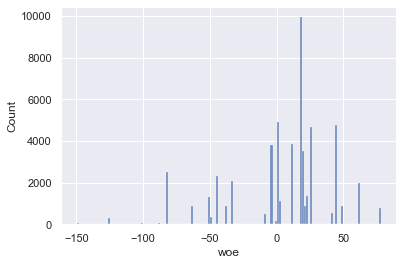

In [348]:
sns.histplot(x=data.loc[(data['woe']!=np.inf) &
                        (data['woe']!=-np.inf),'woe'])
plt.show()

In [349]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
claim_vehicle_brand                                                     
missing                 15689682.51       304732.83                15.09
BMW                      6414778.62       204066.94                10.11
CITROEN                  7866320.66       179294.13                 8.88
VOLKSWAGEN              10264569.58       167598.72                 8.30
MERCEDES                 5444240.32       147452.55                 7.30

In [350]:
### 

In [351]:
table.to_clipboard(index=True,header=True)

In [352]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

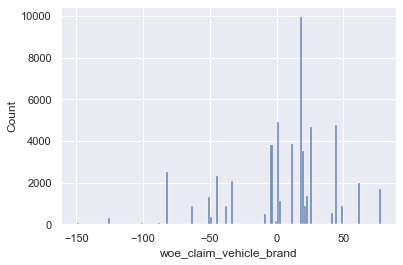

In [353]:
sns.histplot(x=data['woe_'+var])
plt.show()

In [354]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [355]:
data[var].dtype

dtype('O')

In [356]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [357]:
temp.index.dtype

dtype('O')

In [358]:
dict_woe.update(temp.to_dict())

In [359]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [360]:
len(dict_woe)

11

In [361]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [362]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

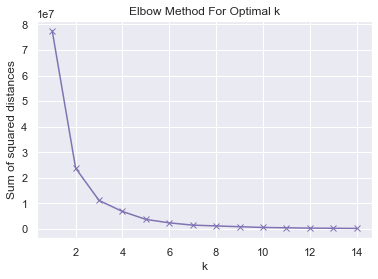

In [363]:
tabla=pd.DataFrame({'woe':data['woe_'+var]})

SEED = 123

#Número de cluster óptimo
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=SEED)
    km = km.fit(tabla)
    sum_of_squared_distances.append(km.inertia_)
#     centroids = km.cluster_centers_
#     print(centroids)

plt.plot(K, sum_of_squared_distances, 'mx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [364]:
km = KMeans(n_clusters=3, random_state=SEED)
km = km.fit(tabla)
km.cluster_centers_
km.labels_

array([1, 1, 1, ..., 2, 2, 2])

In [365]:
breaks = jenkspy.jenks_breaks(data['woe_'+var], nb_class=3)
breaks

[-149.8144, -32.8665, 26.5891, 78.1685]

In [366]:
dict_woe_breaks.update({var:breaks})

In [367]:
with open(path+'dict_woe_train_breaks.json', 'w') as fp:
    json.dump(dict_woe_breaks, fp)

In [368]:
data['woe_'+var+'_cat'] = pd.cut(data['woe_'+var],
                                 bins=breaks,
                                 labels=['high_fraud', 'medium_fraud', 'low_fraud'],
                                 include_lowest=True)

data['woe_'+var+'_cat'].value_counts(normalize=True)

medium_fraud    0.627120
high_fraud      0.194767
low_fraud       0.178113
Name: woe_claim_vehicle_brand_cat, dtype: float64

In [369]:
data['woe_'+var+'_cat'].value_counts(normalize=False)

medium_fraud    34755
high_fraud      10794
low_fraud        9871
Name: woe_claim_vehicle_brand_cat, dtype: int64

In [370]:
'woe_'+var+'_cat'

'woe_claim_vehicle_brand_cat'

In [371]:
dict_categ = {'woe_claim_vehicle_brand_cat':['low_fraud','medium_fraud','high_fraud']}

data = categorical(data,dict_categ)

In [372]:
# Get dummies
data = pd.get_dummies(data,
                      columns=data.columns[
                                           np.where(data.dtypes == 'category')
                                           ],
                      drop_first=True
                      )

In [373]:
data.drop(['woe',var],axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55420, 73)


fraud  claim_amount  claim_date_registered claim_vehicle_type  \
0     N       6346.16               20170511                car   
1     N       1118.03               20170430                car   
2     N       1424.16               20170130                car   
3     N       4493.50               20170116                car   
4     N       1101.89               20170130                car   

   claim_vehicle_date_inuse  claim_vehicle_cyl claim_vehicle_load  \
0                  201103.0             1248.0               1.63   
1                  201107.0             1248.0               1.63   
2                  201310.0             1368.0               1.78   
3                  201301.0             1956.0               1.82   
4                  201402.0             1598.0               1.81   

   claim_vehicle_fuel_type  claim_vehicle_power  policy_holder_postal_code  \
0                      2.0                 66.0                     7340.0   
1                      2.0                 62.0                     4020.0   
2                      1.0                 85.0                     4040.0   
3                      2.0                100.0                     4100.0   
4                      2.0                 77.0                     4460.0   

  policy_holder_form  policy_holder_year_birth policy_holder_country  \
0                  M                    1985.0                     B   
1                  M                    1959.0                     B   
2                  M                    1958.0                     B   
3                  M                    1949.0                     B   
4                  M                    1955.0                     B   

   driver_postal_code driver_form  driver_year_birth driver_country  \
0              7340.0           M             1985.0              B   
1              4020.0           M             1959.0              B   
2              4040.0           M             1958.0              B   
3              4100.0           M             1949.0              B   
4              4460.0           M             1955.0              B   

  driver_injured  third_party_1_postal_code third_party_1_injured  \
0              Y                     6031.0                     Y   
1              N                        NaN                   NaN   
2              N                        NaN                   NaN   
3              N                        NaN                   NaN   
4              N                        NaN                   NaN   

  third_party_1_vehicle_type third_party_1_form  third_party_1_year_birth  \
0                        car                  F                    1986.0   
1                        NaN                NaN                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        NaN                NaN                       NaN   

  third_party_1_country  third_party_2_postal_code third_party_2_injured  \
0                     B                        NaN                   NaN   
1                   NaN                        NaN                   NaN   
2                   NaN                        NaN                   NaN   
3                   NaN                        NaN                   NaN   
4                   NaN                        NaN                   NaN   

  third_party_2_vehicle_type third_party_2_form  third_party_2_year_birth  \
0                        NaN                NaN                       NaN   
1                        NaN                NaN                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        NaN                NaN                       NaN   

  third_party_2_country  third_party_3_postal_code third_

In [374]:
#############

In [375]:
var = 'claim_vehicle_type'

In [376]:
len(df_total[var].unique())

3

In [377]:
df_total[var].unique()

array(['car', 'van', nan], dtype=object)

In [378]:
df_total[var] = np.where(df_total[var].isna(),'missing',df_total[var])

In [379]:
df_total[var].value_counts(normalize=True)

car        0.929502
van        0.067719
missing    0.002779
Name: claim_vehicle_type, dtype: float64

In [380]:
df_total[var].value_counts(normalize=False)

car        51513
van         3753
missing      154
Name: claim_vehicle_type, dtype: int64

In [381]:
data = woe(df_total,var)
#data.sort_index()
data

N    Y  total   porc_N  porc_Y  porc_total       woe
claim_vehicle_type                                                          
missing               151    3    154  98.0519  1.9481      0.2779 -126.8355
van                  3723   30   3753  99.2006  0.7994      6.7719  -36.5935
car                 51238  275  51513  99.4662  0.5338     92.9502    4.0443

In [382]:
data.to_clipboard(index=True,header=True)

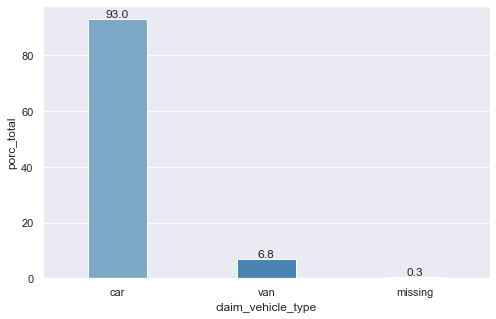

In [383]:
plt.figure(figsize=(8,5))

ax = sns.barplot(x=var, y='porc_total', 
                 data=data.reset_index().sort_values(by='porc_total',ascending=False),palette='Blues_d')
widthbars = [0.4, 0.4, 0.4]

for p,newwidth in zip(ax.patches,widthbars):
    
    x = p.get_x()
    width = p.get_width()
    centre = x + width/2.
    p.set_x(centre - newwidth/2.)
    p.set_width(newwidth)
    
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), 
                   textcoords = 'offset points',
                   size=12)

plt.show()

In [384]:
df_total.set_index(var,inplace=True)

In [385]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55420, 74)


claim_vehicle_type fraud  claim_amount  claim_date_registered  \
0                car     N       6346.16               20170511   
1                car     N       1118.03               20170430   
2                car     N       1424.16               20170130   
3                car     N       4493.50               20170116   
4                car     N       1101.89               20170130   

   claim_vehicle_date_inuse  claim_vehicle_cyl claim_vehicle_load  \
0                  201103.0             1248.0               1.63   
1                  201107.0             1248.0               1.63   
2                  201310.0             1368.0               1.78   
3                  201301.0             1956.0               1.82   
4                  201402.0             1598.0               1.81   

   claim_vehicle_fuel_type  claim_vehicle_power  policy_holder_postal_code  \
0                      2.0                 66.0                     7340.0   
1                      2.0                 62.0                     4020.0   
2                      1.0                 85.0                     4040.0   
3                      2.0                100.0                     4100.0   
4                      2.0                 77.0                     4460.0   

  policy_holder_form  policy_holder_year_birth policy_holder_country  \
0                  M                    1985.0                     B   
1                  M                    1959.0                     B   
2                  M                    1958.0                     B   
3                  M                    1949.0                     B   
4                  M                    1955.0                     B   

   driver_postal_code driver_form  driver_year_birth driver_country  \
0              7340.0           M             1985.0              B   
1              4020.0           M             1959.0              B   
2              4040.0           M             1958.0              B   
3              4100.0           M             1949.0              B   
4              4460.0           M             1955.0              B   

  driver_injured  third_party_1_postal_code third_party_1_injured  \
0              Y                     6031.0                     Y   
1              N                        NaN                   NaN   
2              N                        NaN                   NaN   
3              N                        NaN                   NaN   
4              N                        NaN                   NaN   

  third_party_1_vehicle_type third_party_1_form  third_party_1_year_birth  \
0                        car                  F                    1986.0   
1                        NaN                NaN                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        NaN                NaN                       NaN   

  third_party_1_country  third_party_2_postal_code third_party_2_injured  \
0                     B                        NaN                   NaN   
1                   NaN                        NaN                   NaN   
2                   NaN                        NaN                   NaN   
3                   NaN                        NaN                   NaN   
4                   NaN                        NaN                   NaN   

  third_party_2_vehicle_type third_party_2_form  third_party_2_year_birth  \
0                        NaN                NaN                       NaN   
1                        NaN                NaN                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        NaN                NaN                       NaN   

  third_party_2_country  third_party_3_postal_code third_

In [386]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
claim_vehicle_type                                                     
car                   1.064182e+08      1827512.66                90.50
van                   8.158813e+06       159609.73                 7.90
missing               3.534102e+05        32137.25                 1.59

In [387]:
### the 90% of the amount of fraud claims is when the type of vehicle is car, but this is what we expected

In [388]:
table.to_clipboard(index=True,header=True)

In [389]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [390]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [391]:
data[var].dtype

dtype('O')

In [392]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [393]:
temp.index.dtype

dtype('O')

In [394]:
dict_woe.update(temp.to_dict())

In [395]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [396]:
len(dict_woe)

12

In [397]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [398]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [399]:
data['woe_'+var+'_cat'] = data[var]

In [400]:
data['woe_'+var+'_cat'] = np.where(data['woe_'+var+'_cat'].isin(['car']),'car','other')

In [401]:
data['woe_'+var+'_cat'].value_counts(normalize=False)

car      51513
other     3907
Name: woe_claim_vehicle_type_cat, dtype: int64

In [402]:
'woe_'+var+'_cat'

'woe_claim_vehicle_type_cat'

In [403]:
dict_categ = {'woe_claim_vehicle_type_cat':['other','car']}

data = categorical(data,dict_categ)

In [404]:
# Get dummies
data = pd.get_dummies(data,
                      columns=data.columns[
                                           np.where(data.dtypes == 'category')
                                           ],
                      drop_first=True
                      )

In [405]:
data.drop(['woe',var],axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55420, 74)


fraud  claim_amount  claim_date_registered  claim_vehicle_date_inuse  \
0     N       6346.16               20170511                  201103.0   
1     N       1118.03               20170430                  201107.0   
2     N       1424.16               20170130                  201310.0   
3     N       4493.50               20170116                  201301.0   
4     N       1101.89               20170130                  201402.0   

   claim_vehicle_cyl claim_vehicle_load  claim_vehicle_fuel_type  \
0             1248.0               1.63                      2.0   
1             1248.0               1.63                      2.0   
2             1368.0               1.78                      1.0   
3             1956.0               1.82                      2.0   
4             1598.0               1.81                      2.0   

   claim_vehicle_power  policy_holder_postal_code policy_holder_form  \
0                 66.0                     7340.0                  M   
1                 62.0                     4020.0                  M   
2                 85.0                     4040.0                  M   
3                100.0                     4100.0                  M   
4                 77.0                     4460.0                  M   

   policy_holder_year_birth policy_holder_country  driver_postal_code  \
0                    1985.0                     B              7340.0   
1                    1959.0                     B              4020.0   
2                    1958.0                     B              4040.0   
3                    1949.0                     B              4100.0   
4                    1955.0                     B              4460.0   

  driver_form  driver_year_birth driver_country driver_injured  \
0           M             1985.0              B              Y   
1           M             1959.0              B              N   
2           M             1958.0              B              N   
3           M             1949.0              B              N   
4           M             1955.0              B              N   

   third_party_1_postal_code third_party_1_injured third_party_1_vehicle_type  \
0                     6031.0                     Y                        car   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN                        NaN   

  third_party_1_form  third_party_1_year_birth third_party_1_country  \
0                  F                    1986.0                     B   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   third_party_2_postal_code third_party_2_injured third_party_2_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN                        NaN   

  third_party_2_form  third_party_2_year_birth third_party_2_country  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   third_party_3_postal_code third_part

In [406]:
#############

In [407]:
var = 'claim_vehicle_date_inuse'

In [408]:
print(df_total[var].min())
print(df_total[var].max())

196204.0
270505.0


In [409]:
df_total[df_total[var]>=201801.0].shape

(1, 74)

In [410]:
### We decided to eliminate this weird value, it's just one row which is 'no-fraud'
df_total = df_total[df_total[var]!=270505.0]

In [411]:
df_total.shape

(55419, 74)

In [412]:
print(df_total[var].min())
print(df_total[var].max())

196204.0
201707.0


In [413]:
base_date = pd.to_datetime(df_total['claim_date_registered'], format='%Y%m%d')
base_date.dt.year

0        2017
1        2017
2        2017
3        2017
4        2017
         ... 
55415    2017
55416    2017
55417    2017
55418    2017
55419    2017
Name: claim_date_registered, Length: 55419, dtype: int64

In [414]:
df_total['months_vehicle_regist'] = (base_date.dt.year - pd.to_datetime(df_total[var], format='%Y%m').dt.year) * 12 \
                                    + (base_date.dt.month - pd.to_datetime(df_total[var], format='%Y%m').dt.month)

df_total['years_vehicle_regist'] = (base_date.dt.year - pd.to_datetime(df_total[var], format='%Y%m').dt.year)

In [415]:
print(df_total[var].isna().sum())
print(df_total['months_vehicle_regist'].isna().sum())
print(df_total['years_vehicle_regist'].isna().sum())

614
614
614


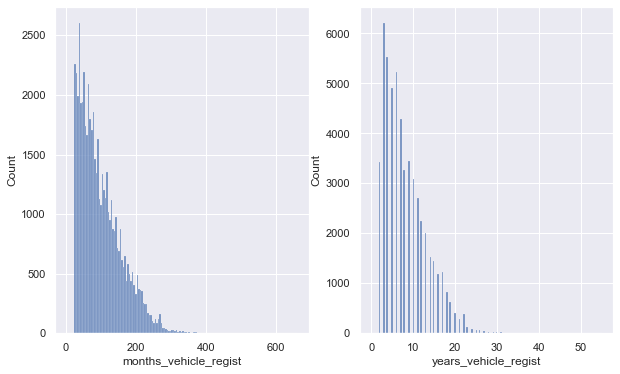

In [416]:
figure, axes = plt.subplots(1, 2, figsize=(10,6))

sns.histplot(data=df_total, x="months_vehicle_regist",ax=axes[0])
sns.histplot(data=df_total, x="years_vehicle_regist",ax=axes[1])

plt.show()

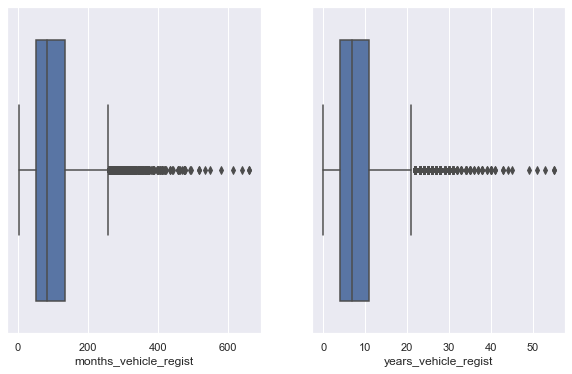

In [417]:
figure, axes = plt.subplots(1, 2, figsize=(10,6))

sns.boxplot(data=df_total, x="months_vehicle_regist",ax=axes[0])
sns.boxplot(data=df_total, x="years_vehicle_regist",ax=axes[1])

plt.show()

266.0
22.0


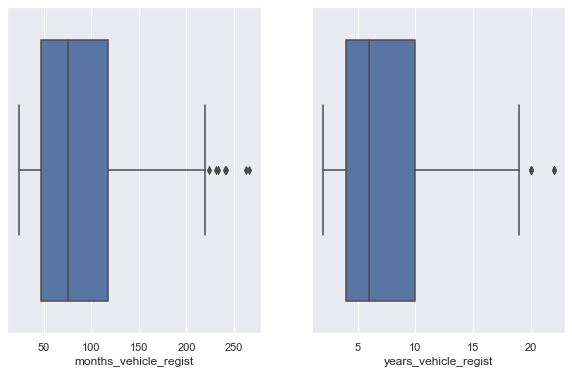

In [418]:
print(max(df_total.loc[df_total['fraud']=='Y','months_vehicle_regist']))
print(max(df_total.loc[df_total['fraud']=='Y','years_vehicle_regist']))

figure, axes = plt.subplots(1, 2, figsize=(10,6))

sns.boxplot(data=df_total.loc[df_total['fraud']=='Y',:], x="months_vehicle_regist", ax=axes[0])
sns.boxplot(data=df_total.loc[df_total['fraud']=='Y',:], x="years_vehicle_regist", ax=axes[1])

plt.show()

In [419]:
print(df_total.loc[df_total['fraud']=='Y','months_vehicle_regist'].quantile([0, 0.05, .1, .25, .5, .75, 0.8, 0.85, 0.9, .95, 1]))
print(df_total.loc[df_total['fraud']=='Y','years_vehicle_regist'].quantile([0, 0.05, .1, .25, .5, .75, 0.8, 0.85, 0.9, .95, 1]))

0.00     24.00
0.05     29.00
0.10     34.00
0.25     47.00
0.50     75.50
0.75    117.25
0.80    128.00
0.85    141.55
0.90    159.00
0.95    185.70
1.00    266.00
Name: months_vehicle_regist, dtype: float64
0.00     2.0
0.05     2.0
0.10     3.0
0.25     4.0
0.50     6.0
0.75    10.0
0.80    11.0
0.85    12.0
0.90    13.0
0.95    15.0
1.00    22.0
Name: years_vehicle_regist, dtype: float64


662.0
55.0


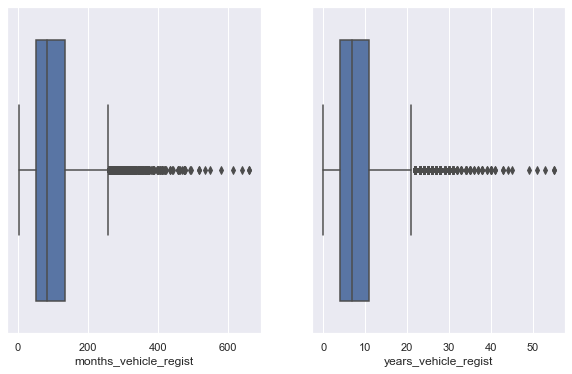

In [420]:
print(max(df_total.loc[df_total['fraud']=='N','months_vehicle_regist']))
print(max(df_total.loc[df_total['fraud']=='N','years_vehicle_regist']))

figure, axes = plt.subplots(1, 2, figsize=(10,6))

sns.boxplot(data=df_total.loc[df_total['fraud']=='N',:], x="months_vehicle_regist", ax=axes[0])
sns.boxplot(data=df_total.loc[df_total['fraud']=='N',:], x="years_vehicle_regist", ax=axes[1])

plt.show()

In [421]:
print(df_total.loc[df_total['fraud']=='N','months_vehicle_regist'].quantile([0, 0.05, .1, .25, .5, .75, 0.8, 0.85, 0.9, .95, 1]))
print(df_total.loc[df_total['fraud']=='N','years_vehicle_regist'].quantile([0, 0.05, .1, .25, .5, .75, 0.8, 0.85, 0.9, .95, 1]))

0.00      2.0
0.05     29.0
0.10     35.0
0.25     51.0
0.50     84.0
0.75    134.0
0.80    148.0
0.85    164.0
0.90    187.0
0.95    215.0
1.00    662.0
Name: months_vehicle_regist, dtype: float64
0.00     0.0
0.05     2.0
0.10     3.0
0.25     4.0
0.50     7.0
0.75    11.0
0.80    12.0
0.85    14.0
0.90    16.0
0.95    18.0
1.00    55.0
Name: years_vehicle_regist, dtype: float64


In [422]:
df_total.loc[(df_total['fraud']=='N') &
             (df_total['years_vehicle_regist']>18),:].shape

(2236, 76)

In [423]:
### Possible rule or policy: Juts focus on claims with a value <= 18 in 'years_vehicle_regist'
### because the 95% of the frauds happened in that interval of time

In [424]:
df_total.loc[(df_total['fraud']=='Y') &
             (df_total['years_vehicle_regist']<=18),'claim_amount'].sum()

1952304.56

In [425]:
df_total['years_vehicle_regist'].dropna().quantile([0, 0.05, .1, .25, .5, .75, 0.8, 0.85, 0.9, .95, 1])

0.00     0.0
0.05     2.0
0.10     3.0
0.25     4.0
0.50     7.0
0.75    11.0
0.80    12.0
0.85    14.0
0.90    15.0
0.95    18.0
1.00    55.0
Name: years_vehicle_regist, dtype: float64

In [426]:
q_95 = df_total['years_vehicle_regist'].dropna().quantile(.95)
print(q_95)

df_total['years_vehicle_regist'] = np.where(df_total['years_vehicle_regist'].isna(),np.nan,
                                            np.where(df_total['years_vehicle_regist']>=int(q_95),int(q_95),
                                                     df_total['years_vehicle_regist']))

18.0


In [427]:
q_95 = df_total['months_vehicle_regist'].dropna().quantile(.95)
print(q_95)

df_total['months_vehicle_regist'] = np.where(df_total['months_vehicle_regist'].isna(),np.nan,
                                            np.where(df_total['months_vehicle_regist']>=int(q_95),int(q_95),
                                                     df_total['months_vehicle_regist']))

215.0


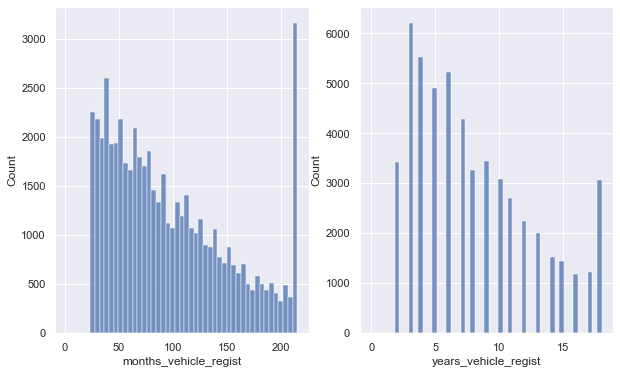

In [428]:
figure, axes = plt.subplots(1, 2, figsize=(10,6))

sns.histplot(data=df_total, x="months_vehicle_regist",ax=axes[0])
sns.histplot(data=df_total, x="years_vehicle_regist",ax=axes[1])

plt.show()

In [429]:
var1 = 'months_vehicle_regist'
var2 = 'years_vehicle_regist'

In [430]:
df_total[var1] = np.where(df_total[var1].isna(),-1,df_total[var1])
df_total[var2] = np.where(df_total[var2].isna(),-1,df_total[var2])

In [431]:
data = woe(df_total,var1)

print(data.shape)
data.head()

(203, 7)


N  Y  total   porc_N  porc_Y  porc_total       woe
months_vehicle_regist                                                      
205.0                  101  2    103  98.0583  1.9417      0.1859 -126.5031
24.0                   115  2    117  98.2906  1.7094      0.2111 -113.5220
81.0                   356  6    362  98.3425  1.6575      0.6532 -110.3834
80.0                   374  6    380  98.4211  1.5789      0.6857 -105.4509
119.0                  250  4    254  98.4252  1.5748      0.4583 -105.1838

In [432]:
data[data['woe']==np.inf].shape[0]

65

In [433]:
data.to_clipboard(index=True,header=True)

In [434]:
df_total.set_index(var1,inplace=True)

In [435]:
data = df_total.join(data[['woe']])
data.reset_index(inplace=True)
print(data.shape)
data.head()

(55419, 77)


months_vehicle_regist fraud  claim_amount  claim_date_registered  \
0                   -1.0     N       4887.20               20170127   
1                   -1.0     N        836.68               20170123   
2                   -1.0     N       1163.95               20170625   
3                   -1.0     N       2537.42               20170115   
4                   -1.0     N       1224.98               20171026   

   claim_vehicle_date_inuse  claim_vehicle_cyl claim_vehicle_load  \
0                       NaN             1997.0               1.83   
1                       NaN                NaN                NaN   
2                       NaN                0.0                NaN   
3                       NaN                0.0                NaN   
4                       NaN                0.0                NaN   

   claim_vehicle_fuel_type  claim_vehicle_power  policy_holder_postal_code  \
0                      2.0                 92.0                     9160.0   
1                      2.0                  NaN                     1420.0   
2                      2.0                  NaN                     4020.0   
3                      1.0                  NaN                     1400.0   
4                      1.0                  NaN                     5140.0   

  policy_holder_form  policy_holder_year_birth policy_holder_country  \
0                  M                    1971.0                     B   
1                  M                       NaN                     B   
2                  F                    1982.0                     B   
3                  F                    1988.0                     B   
4                  M                       NaN                     B   

   driver_postal_code driver_form  driver_year_birth driver_country  \
0              9160.0           M             1971.0              B   
1              1420.0           M                NaN              B   
2              1000.0           M                NaN              B   
3              1030.0           M                NaN              B   
4              1030.0           M                NaN              B   

  driver_injured  third_party_1_postal_code third_party_1_injured  \
0              N                     9160.0                     N   
1              N                        NaN                   NaN   
2              N                        NaN                   NaN   
3              N                        NaN                   NaN   
4              N                        NaN                   NaN   

  third_party_1_vehicle_type third_party_1_form  third_party_1_year_birth  \
0                        car                  M                       NaN   
1                        NaN                NaN                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        NaN                NaN                       NaN   

  third_party_1_country  third_party_2_postal_code third_party_2_injured  \
0                     B                        NaN                   NaN   
1                   NaN                        NaN                   NaN   
2                   NaN                        NaN                   NaN   
3                   NaN                        NaN                   NaN   
4                   NaN                        NaN                   NaN   

  third_party_2_vehicle_type third_party_2_form  third_party_2_year_birth  \
0                        NaN                NaN                       NaN   
1                        NaN                NaN                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        NaN                NaN                       NaN   

  third_party_2_country  third_par

In [436]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var1,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
months_vehicle_regist                                                     
35.0                       1106538.74        74042.76                 3.67
37.0                       1071640.49        60780.00                 3.01
70.0                        897977.58        59987.00                 2.97
41.0                       1031015.05        58885.08                 2.92
68.0                        909380.59        57218.23                 2.83

In [437]:
### 

In [438]:
table.to_clipboard(index=True,header=True)

In [439]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var1] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [440]:
print(data[data['woe_'+var1]==-np.inf].shape[0])
print(data[data['woe_'+var1]==np.inf].shape[0])

0
0


In [441]:
data[var1].dtype

dtype('float64')

In [442]:
temp = data[['woe_'+var1,var1]].copy()
temp = temp.drop_duplicates()
temp.set_index(var1,inplace=True)

In [443]:
temp.index.dtype

dtype('float64')

In [444]:
dict_woe.update(temp.to_dict())

In [445]:
dict_woe[var1] = dict_woe.pop('woe_'+var1)

In [446]:
len(dict_woe)

13

In [447]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [448]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [449]:
columns_f = [col for col in data.columns if (var1 not in col)]+['woe_'+var1]+[var1]
print(len(columns_f))
print(data.shape)

data = data.reindex(columns=columns_f)

78
(55419, 78)


In [450]:
data[var1] = np.where(data[var1]==-1,np.nan,data[var1])

In [451]:
data.drop('woe',axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 77)


fraud  claim_amount  claim_date_registered  claim_vehicle_date_inuse  \
0     N       4887.20               20170127                       NaN   
1     N        836.68               20170123                       NaN   
2     N       1163.95               20170625                       NaN   
3     N       2537.42               20170115                       NaN   
4     N       1224.98               20171026                       NaN   

   claim_vehicle_cyl claim_vehicle_load  claim_vehicle_fuel_type  \
0             1997.0               1.83                      2.0   
1                NaN                NaN                      2.0   
2                0.0                NaN                      2.0   
3                0.0                NaN                      1.0   
4                0.0                NaN                      1.0   

   claim_vehicle_power  policy_holder_postal_code policy_holder_form  \
0                 92.0                     9160.0                  M   
1                  NaN                     1420.0                  M   
2                  NaN                     4020.0                  F   
3                  NaN                     1400.0                  F   
4                  NaN                     5140.0                  M   

   policy_holder_year_birth policy_holder_country  driver_postal_code  \
0                    1971.0                     B              9160.0   
1                       NaN                     B              1420.0   
2                    1982.0                     B              1000.0   
3                    1988.0                     B              1030.0   
4                       NaN                     B              1030.0   

  driver_form  driver_year_birth driver_country driver_injured  \
0           M             1971.0              B              N   
1           M                NaN              B              N   
2           M                NaN              B              N   
3           M                NaN              B              N   
4           M                NaN              B              N   

   third_party_1_postal_code third_party_1_injured third_party_1_vehicle_type  \
0                     9160.0                     N                        car   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN                        NaN   

  third_party_1_form  third_party_1_year_birth third_party_1_country  \
0                  M                       NaN                     B   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   third_party_2_postal_code third_party_2_injured third_party_2_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN                        NaN   

  third_party_2_form  third_party_2_year_birth third_party_2_country  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   third_party_3_postal_code third_part

In [452]:
data = woe(df_total,var2)

print(data.shape)
data.head()

(20, 7)


N   Y  total   porc_N  porc_Y  porc_total      woe
years_vehicle_regist                                                       
 7.0                  4265  33   4298  99.2322  0.7678      7.7555 -32.5315
 6.0                  5190  37   5227  99.2921  0.7079      9.4318 -24.3434
 4.0                  5482  38   5520  99.3116  0.6884      9.9605 -21.5366
-1.0                   610   4    614  99.3485  0.6515      1.1079 -15.9840
 3.0                  6177  40   6217  99.3566  0.6434     11.2182 -14.7296

In [453]:
data[data['woe']==np.inf].shape[0]

3

In [454]:
data.to_clipboard(index=True,header=True)

In [455]:
df_total.set_index(var2,inplace=True)

In [456]:
data = df_total.join(data[['woe']])
data.reset_index(inplace=True)
print(data.shape)
data.head()

(55419, 78)


years_vehicle_regist fraud  claim_amount  claim_date_registered  \
0                  -1.0     N       4887.20               20170127   
1                  -1.0     N        836.68               20170123   
2                  -1.0     N       1163.95               20170625   
3                  -1.0     N       2537.42               20170115   
4                  -1.0     N       1224.98               20171026   

   claim_vehicle_date_inuse  claim_vehicle_cyl claim_vehicle_load  \
0                       NaN             1997.0               1.83   
1                       NaN                NaN                NaN   
2                       NaN                0.0                NaN   
3                       NaN                0.0                NaN   
4                       NaN                0.0                NaN   

   claim_vehicle_fuel_type  claim_vehicle_power  policy_holder_postal_code  \
0                      2.0                 92.0                     9160.0   
1                      2.0                  NaN                     1420.0   
2                      2.0                  NaN                     4020.0   
3                      1.0                  NaN                     1400.0   
4                      1.0                  NaN                     5140.0   

  policy_holder_form  policy_holder_year_birth policy_holder_country  \
0                  M                    1971.0                     B   
1                  M                       NaN                     B   
2                  F                    1982.0                     B   
3                  F                    1988.0                     B   
4                  M                       NaN                     B   

   driver_postal_code driver_form  driver_year_birth driver_country  \
0              9160.0           M             1971.0              B   
1              1420.0           M                NaN              B   
2              1000.0           M                NaN              B   
3              1030.0           M                NaN              B   
4              1030.0           M                NaN              B   

  driver_injured  third_party_1_postal_code third_party_1_injured  \
0              N                     9160.0                     N   
1              N                        NaN                   NaN   
2              N                        NaN                   NaN   
3              N                        NaN                   NaN   
4              N                        NaN                   NaN   

  third_party_1_vehicle_type third_party_1_form  third_party_1_year_birth  \
0                        car                  M                       NaN   
1                        NaN                NaN                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        NaN                NaN                       NaN   

  third_party_1_country  third_party_2_postal_code third_party_2_injured  \
0                     B                        NaN                   NaN   
1                   NaN                        NaN                   NaN   
2                   NaN                        NaN                   NaN   
3                   NaN                        NaN                   NaN   
4                   NaN                        NaN                   NaN   

  third_party_2_vehicle_type third_party_2_form  third_party_2_year_birth  \
0                        NaN                NaN                       NaN   
1                        NaN                NaN                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        NaN                NaN                       NaN   

  third_party_2_country  third_party_3_p

In [457]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var2,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
years_vehicle_regist                                                     
3.0                      12908772.19       393955.60                19.51
4.0                      11713485.83       298916.82                14.80
6.0                      11320471.44       270436.29                13.39
7.0                       9285535.23       224603.44                11.12
2.0                       7995795.97       199009.46                 9.86

In [458]:
### 

In [459]:
table.to_clipboard(index=True,header=True)

In [460]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var2] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [461]:
print(data[data['woe_'+var2]==-np.inf].shape[0])
print(data[data['woe_'+var2]==np.inf].shape[0])

0
0


In [462]:
data[var2].dtype

dtype('float64')

In [463]:
temp = data[['woe_'+var2,var2]].copy()
temp = temp.drop_duplicates()
temp.set_index(var2,inplace=True)

In [464]:
temp.index.dtype

dtype('float64')

In [465]:
dict_woe.update(temp.to_dict())

In [466]:
dict_woe[var2] = dict_woe.pop('woe_'+var2)

In [467]:
len(dict_woe)

14

In [468]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [469]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [470]:
columns_f = [col for col in data.columns if (var2 not in col)]+['woe_'+var2]+[var2]
print(len(columns_f))
print(data.shape)

data = data.reindex(columns=columns_f)

79
(55419, 79)


In [471]:
data[var2] = np.where(data[var2]==-1,np.nan,data[var2])

In [472]:
data.drop(['woe','claim_vehicle_date_inuse'],axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 77)


fraud  claim_amount  claim_date_registered  claim_vehicle_cyl  \
0     N       4887.20               20170127             1997.0   
1     N        836.68               20170123                NaN   
2     N       1163.95               20170625                0.0   
3     N       2537.42               20170115                0.0   
4     N       1224.98               20171026                0.0   

  claim_vehicle_load  claim_vehicle_fuel_type  claim_vehicle_power  \
0               1.83                      2.0                 92.0   
1                NaN                      2.0                  NaN   
2                NaN                      2.0                  NaN   
3                NaN                      1.0                  NaN   
4                NaN                      1.0                  NaN   

   policy_holder_postal_code policy_holder_form  policy_holder_year_birth  \
0                     9160.0                  M                    1971.0   
1                     1420.0                  M                       NaN   
2                     4020.0                  F                    1982.0   
3                     1400.0                  F                    1988.0   
4                     5140.0                  M                       NaN   

  policy_holder_country  driver_postal_code driver_form  driver_year_birth  \
0                     B              9160.0           M             1971.0   
1                     B              1420.0           M                NaN   
2                     B              1000.0           M                NaN   
3                     B              1030.0           M                NaN   
4                     B              1030.0           M                NaN   

  driver_country driver_injured  third_party_1_postal_code  \
0              B              N                     9160.0   
1              B              N                        NaN   
2              B              N                        NaN   
3              B              N                        NaN   
4              B              N                        NaN   

  third_party_1_injured third_party_1_vehicle_type third_party_1_form  \
0                     N                        car                  M   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_1_year_birth third_party_1_country  third_party_2_postal_code  \
0                       NaN                     B                        NaN   
1                       NaN                   NaN                        NaN   
2                       NaN                   NaN                        NaN   
3                       NaN                   NaN                        NaN   
4                       NaN                   NaN                        NaN   

  third_party_2_injured third_party_2_vehicle_type third_party_2_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_2_year_birth third_party_2_country  third_party_3_postal_code  \
0                       NaN                   NaN                        NaN   
1                       NaN                   NaN                        NaN   
2                       NaN                   NaN                        NaN   
3                       NaN                   NaN                        NaN   
4                       NaN                   NaN                        NaN   

  third_party_3_injured third_par

In [473]:
#############

In [474]:
var = 'claim_vehicle_cyl'

In [475]:
len(df_total[var].unique())

349

In [476]:
df_total[var].isna().sum()

4917

In [477]:
print(df_total[var].min())
print(df_total[var].max())

0.0
3000.0


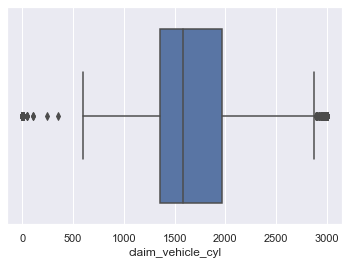

In [478]:
sns.boxplot(x=df_total[var].dropna())
plt.show()

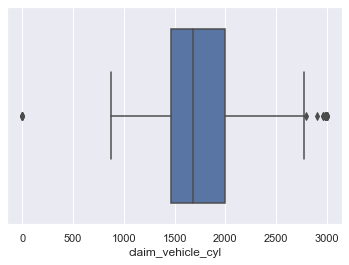

In [479]:
sns.boxplot(x=df_total.loc[df_total['fraud']=='Y',var].dropna())
plt.show()

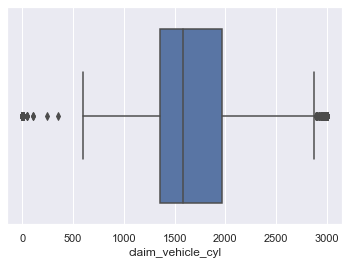

In [480]:
sns.boxplot(x=df_total.loc[df_total['fraud']=='N',var].dropna())
plt.show()

In [481]:
print(df_total.loc[df_total['fraud']=='Y',var].dropna().quantile([0, 0.05, .1, .25, .5, .75, 0.8, 0.85, 0.9, .95, 1]))
print(df_total.loc[df_total['fraud']=='N',var].dropna().quantile([0, 0.05, .1, .25, .5, .75, 0.8, 0.85, 0.9, .95, 1]))

0.00       0.0
0.05    1120.4
0.10    1231.2
0.25    1461.0
0.50    1685.0
0.75    1995.0
0.80    1995.0
0.85    2143.0
0.90    2224.4
0.95    2960.5
1.00    3000.0
Name: claim_vehicle_cyl, dtype: float64
0.00       0.0
0.05       0.0
0.10    1108.0
0.25    1360.0
0.50    1587.0
0.75    1968.0
0.80    1995.0
0.85    1997.0
0.90    2143.0
0.95    2401.0
1.00    3000.0
Name: claim_vehicle_cyl, dtype: float64


In [482]:
df_total[var].dropna().quantile([0, 0.05, .1, .25, .5, .75, 0.8, 0.85, 0.9, .95, 1])

0.00       0.0
0.05       0.0
0.10    1108.0
0.25    1360.0
0.50    1587.0
0.75    1968.0
0.80    1995.0
0.85    1997.0
0.90    2143.0
0.95    2401.0
1.00    3000.0
Name: claim_vehicle_cyl, dtype: float64

In [483]:
q_95 = df_total[var].quantile(.95)
print(q_95)

q_10 = df_total[var].quantile(.1)
print(q_10)

df_total[var] = np.where(df_total[var].isna(),np.nan, 
                      np.where(df_total[var]>=int(q_95),int(q_95),
                               np.where(df_total[var]<=int(q_10),int(q_10),df_total[var])))

2401.0
1108.0


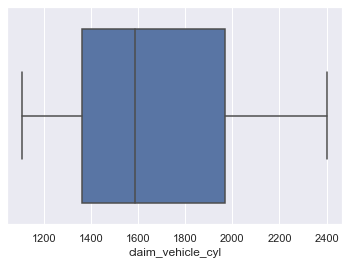

In [484]:
sns.boxplot(x=df_total[var].dropna())
plt.show()

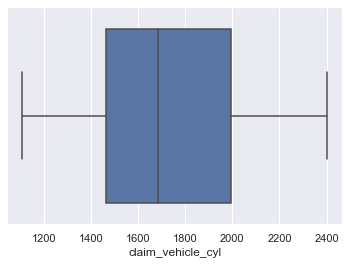

In [485]:
sns.boxplot(x=df_total.loc[df_total['fraud']=='Y',var].dropna())
plt.show()

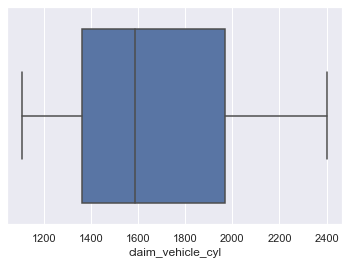

In [486]:
sns.boxplot(x=df_total.loc[df_total['fraud']=='N',var].dropna())
plt.show()

In [487]:
df_total[var] = np.where(df_total[var].isna(),-1,df_total[var])

In [488]:
data = woe(df_total,var)
#data.sort_index()
data.head()

N  Y  total   porc_N   porc_Y  porc_total       woe
claim_vehicle_cyl                                                      
2370.0              5  1      6  83.3333  16.6667      0.0108 -357.7567
1343.0             11  1     12  91.6667   8.3333      0.0217 -278.9110
1800.0             12  1     13  92.3077   7.6923      0.0235 -270.2098
1996.0             12  1     13  92.3077   7.6923      0.0235 -270.2098
2295.0             14  1     15  93.3333   6.6667      0.0271 -254.7947

In [489]:
data.to_clipboard(index=True,header=True)

In [490]:
df_total.set_index(var,inplace=True)

In [491]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55419, 78)


claim_vehicle_cyl fraud  claim_amount  claim_date_registered  \
0               -1.0     N        836.68               20170123   
1               -1.0     N        882.14               20170629   
2               -1.0     N        800.59               20170217   
3               -1.0     N        927.91               20170608   
4               -1.0     N        978.99               20170701   

  claim_vehicle_load  claim_vehicle_fuel_type  claim_vehicle_power  \
0                NaN                      2.0                  NaN   
1                NaN                      2.0                  NaN   
2                NaN                      2.0                  NaN   
3                NaN                      1.0                  NaN   
4                NaN                      1.0                  NaN   

   policy_holder_postal_code policy_holder_form  policy_holder_year_birth  \
0                     1420.0                  M                       NaN   
1                     9080.0                  F                       NaN   
2                     3500.0                  M                    1980.0   
3                     5100.0                  F                       NaN   
4                     4845.0                  F                    1974.0   

  policy_holder_country  driver_postal_code driver_form  driver_year_birth  \
0                     B              1420.0           M                NaN   
1                     B              1210.0           M                NaN   
2                     B              1210.0           M                NaN   
3                     B              1030.0           M                NaN   
4                     B              1030.0           M                NaN   

  driver_country driver_injured  third_party_1_postal_code  \
0              B              N                        NaN   
1              B              N                        NaN   
2              B              N                        NaN   
3              B              N                        NaN   
4              B              N                        NaN   

  third_party_1_injured third_party_1_vehicle_type third_party_1_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_1_year_birth third_party_1_country  third_party_2_postal_code  \
0                       NaN                   NaN                        NaN   
1                       NaN                   NaN                        NaN   
2                       NaN                   NaN                        NaN   
3                       NaN                   NaN                        NaN   
4                       NaN                   NaN                        NaN   

  third_party_2_injured third_party_2_vehicle_type third_party_2_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_2_year_birth third_party_2_country  third_party_3_postal_code  \
0                       NaN                   NaN                        NaN   
1                       NaN                   NaN                        NaN   
2                       NaN                   NaN                        NaN   
3                       NaN                   NaN                        NaN   
4                       NaN                   NaN                        NaN   

  third_party_3_injured third_part

In [492]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
claim_vehicle_cyl                                                     
 1560.0                9091808.02       214238.95                10.61
 2401.0                7109426.87       209651.57                10.38
-1.0                   7286121.46       164864.54                 8.16
 1461.0                5589861.65       160107.77                 7.93
 1968.0                4284444.75       158846.38                 7.87

In [493]:
### 

In [494]:
table.to_clipboard(index=True,header=True)

In [495]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [496]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [497]:
data[var].dtype

dtype('float64')

In [498]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [499]:
temp.index.dtype

dtype('float64')

In [500]:
dict_woe.update(temp.to_dict())

In [501]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [502]:
len(dict_woe)

15

In [503]:
var

'claim_vehicle_cyl'

In [504]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [505]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [506]:
columns_f = [col for col in data.columns if (var not in col)]+['woe_'+var]+[var]
print(len(columns_f))
print(data.shape)

data = data.reindex(columns=columns_f)

79
(55419, 79)


In [507]:
data[var] = np.where(data[var]==-1,np.nan,data[var])

In [508]:
data.drop('woe',axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 78)


fraud  claim_amount  claim_date_registered claim_vehicle_load  \
0     N        836.68               20170123                NaN   
1     N        882.14               20170629                NaN   
2     N        800.59               20170217                NaN   
3     N        927.91               20170608                NaN   
4     N        978.99               20170701                NaN   

   claim_vehicle_fuel_type  claim_vehicle_power  policy_holder_postal_code  \
0                      2.0                  NaN                     1420.0   
1                      2.0                  NaN                     9080.0   
2                      2.0                  NaN                     3500.0   
3                      1.0                  NaN                     5100.0   
4                      1.0                  NaN                     4845.0   

  policy_holder_form  policy_holder_year_birth policy_holder_country  \
0                  M                       NaN                     B   
1                  F                       NaN                     B   
2                  M                    1980.0                     B   
3                  F                       NaN                     B   
4                  F                    1974.0                     B   

   driver_postal_code driver_form  driver_year_birth driver_country  \
0              1420.0           M                NaN              B   
1              1210.0           M                NaN              B   
2              1210.0           M                NaN              B   
3              1030.0           M                NaN              B   
4              1030.0           M                NaN              B   

  driver_injured  third_party_1_postal_code third_party_1_injured  \
0              N                        NaN                   NaN   
1              N                        NaN                   NaN   
2              N                        NaN                   NaN   
3              N                        NaN                   NaN   
4              N                        NaN                   NaN   

  third_party_1_vehicle_type third_party_1_form  third_party_1_year_birth  \
0                        NaN                NaN                       NaN   
1                        NaN                NaN                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        NaN                NaN                       NaN   

  third_party_1_country  third_party_2_postal_code third_party_2_injured  \
0                   NaN                        NaN                   NaN   
1                   NaN                        NaN                   NaN   
2                   NaN                        NaN                   NaN   
3                   NaN                        NaN                   NaN   
4                   NaN                        NaN                   NaN   

  third_party_2_vehicle_type third_party_2_form  third_party_2_year_birth  \
0                        NaN                NaN                       NaN   
1                        NaN                NaN                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        NaN                NaN                       NaN   

  third_party_2_country  third_party_3_postal_code third_party_3_injured  \
0                   NaN                        NaN                   NaN   
1                   NaN                        NaN                   NaN   
2                   NaN                        NaN                   NaN   
3                   NaN                        NaN                   NaN   
4                   NaN                        NaN                   NaN   

  third_party_3

In [509]:
#############

In [510]:
var = 'claim_vehicle_load'

In [511]:
df_total[var].dtype

dtype('O')

In [512]:
df_total[var] = df_total[var].astype(float)

In [513]:
df_total[var].isna().sum()

8617

In [514]:
print(df_total[var].min())
print(df_total[var].max())

0.6
500.0


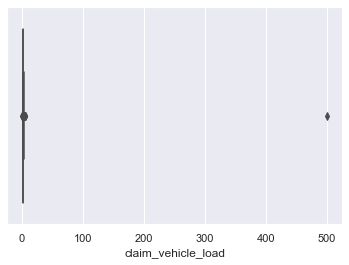

In [515]:
sns.boxplot(x=df_total[var].dropna())
plt.show()

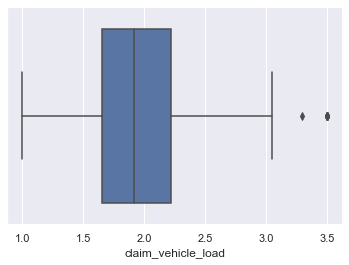

In [516]:
sns.boxplot(x=df_total.loc[df_total['fraud']=='Y',var].dropna())
plt.show()

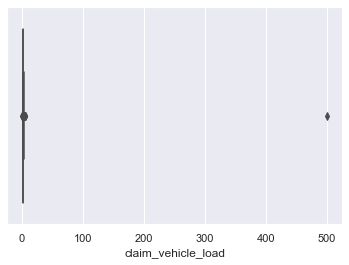

In [517]:
sns.boxplot(x=df_total.loc[df_total['fraud']=='N',var].dropna())
plt.show()

In [518]:
print(df_total.loc[df_total['fraud']=='Y',var].dropna().quantile([0, 0.05, .1, .25, .5, .75, 0.8, 0.85, 0.9, .95, 1]))
print(df_total.loc[df_total['fraud']=='N',var].dropna().quantile([0, 0.05, .1, .25, .5, .75, 0.8, 0.85, 0.9, .95, 1]))

0.00    1.0000
0.05    1.4175
0.10    1.5000
0.25    1.6500
0.50    1.9150
0.75    2.2175
0.80    2.3300
0.85    2.5000
0.90    2.8050
0.95    3.0250
1.00    3.5000
Name: claim_vehicle_load, dtype: float64
0.00      0.60
0.05      1.37
0.10      1.48
0.25      1.61
0.50      1.85
0.75      2.07
0.80      2.14
0.85      2.24
0.90      2.48
0.95      2.86
1.00    500.00
Name: claim_vehicle_load, dtype: float64


In [519]:
df_total[var].dropna().quantile([0, 0.05, .1, .25, .5, .75, 0.8, 0.85, 0.9, .95, 1])

0.00      0.60
0.05      1.37
0.10      1.48
0.25      1.61
0.50      1.85
0.75      2.07
0.80      2.14
0.85      2.24
0.90      2.49
0.95      2.86
1.00    500.00
Name: claim_vehicle_load, dtype: float64

In [520]:
q_95 = df_total[var].quantile(.95)
print(q_95)

q_05 = df_total[var].quantile(.05)
print(q_05)

df_total[var] = np.where(df_total[var].isna(),np.nan, 
                      np.where(df_total[var]>=q_95,q_95,
                               np.where(df_total[var]<=q_05,q_05,df_total[var])))

2.86
1.37


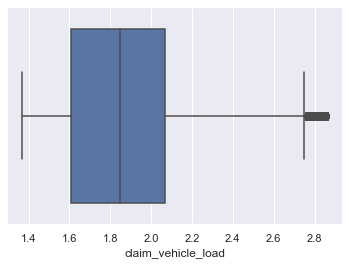

In [521]:
sns.boxplot(x=df_total[var].dropna())
plt.show()

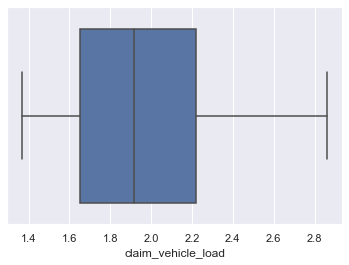

In [522]:
sns.boxplot(x=df_total.loc[df_total['fraud']=='Y',var].dropna())
plt.show()

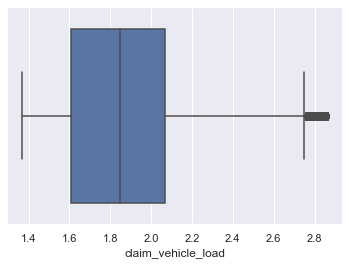

In [523]:
sns.boxplot(x=df_total.loc[df_total['fraud']=='N',var].dropna())
plt.show()

In [524]:
df_total[var] = np.where(df_total[var].isna(),-1,df_total[var])

In [525]:
data = woe(df_total,var)
#data.sort_index()
data.head()

N  Y  total   porc_N   porc_Y  porc_total       woe
claim_vehicle_load                                                      
2.84                 7  1      8  87.5000  12.5000      0.0144 -324.1095
2.66                38  2     40  95.0000   5.0000      0.0722 -224.2566
2.67                21  1     22  95.4545   4.5455      0.0397 -214.2482
2.81                23  1     24  95.8333   4.1667      0.0433 -205.1511
2.68                24  1     25  96.0000   4.0000      0.0451 -200.8951

In [526]:
data.to_clipboard(index=True,header=True)

In [527]:
df_total.set_index(var,inplace=True)

In [528]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55419, 79)


claim_vehicle_load fraud  claim_amount  claim_date_registered  \
0                -1.0     N        836.68               20170123   
1                -1.0     N        882.14               20170629   
2                -1.0     N        800.59               20170217   
3                -1.0     N        927.91               20170608   
4                -1.0     N        978.99               20170701   

   claim_vehicle_fuel_type  claim_vehicle_power  policy_holder_postal_code  \
0                      2.0                  NaN                     1420.0   
1                      2.0                  NaN                     9080.0   
2                      2.0                  NaN                     3500.0   
3                      1.0                  NaN                     5100.0   
4                      1.0                  NaN                     4845.0   

  policy_holder_form  policy_holder_year_birth policy_holder_country  \
0                  M                       NaN                     B   
1                  F                       NaN                     B   
2                  M                    1980.0                     B   
3                  F                       NaN                     B   
4                  F                    1974.0                     B   

   driver_postal_code driver_form  driver_year_birth driver_country  \
0              1420.0           M                NaN              B   
1              1210.0           M                NaN              B   
2              1210.0           M                NaN              B   
3              1030.0           M                NaN              B   
4              1030.0           M                NaN              B   

  driver_injured  third_party_1_postal_code third_party_1_injured  \
0              N                        NaN                   NaN   
1              N                        NaN                   NaN   
2              N                        NaN                   NaN   
3              N                        NaN                   NaN   
4              N                        NaN                   NaN   

  third_party_1_vehicle_type third_party_1_form  third_party_1_year_birth  \
0                        NaN                NaN                       NaN   
1                        NaN                NaN                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        NaN                NaN                       NaN   

  third_party_1_country  third_party_2_postal_code third_party_2_injured  \
0                   NaN                        NaN                   NaN   
1                   NaN                        NaN                   NaN   
2                   NaN                        NaN                   NaN   
3                   NaN                        NaN                   NaN   
4                   NaN                        NaN                   NaN   

  third_party_2_vehicle_type third_party_2_form  third_party_2_year_birth  \
0                        NaN                NaN                       NaN   
1                        NaN                NaN                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        NaN                NaN                       NaN   

  third_party_2_country  third_party_3_postal_code third_party_3_injured  \
0                   NaN                        NaN                   NaN   
1                   NaN                        NaN                   NaN   
2                   NaN                        NaN                   NaN   
3                   NaN                        NaN                   NaN   
4                   NaN                        NaN                   NaN   

  third_pa

In [529]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
claim_vehicle_load                                                     
-1.00                  13844570.56       259670.34                12.86
 2.86                   5564128.45       158875.50                 7.87
 1.96                   1152999.60        53790.92                 2.66
 2.05                    934835.27        50859.99                 2.52
 1.65                   1526101.03        50777.17                 2.51

In [530]:
### 

In [531]:
table.to_clipboard(index=True,header=True)

In [532]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [533]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [534]:
data[var].dtype

dtype('float64')

In [535]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [536]:
temp.index.dtype

dtype('float64')

In [537]:
dict_woe.update(temp.to_dict())

In [538]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [539]:
len(dict_woe)

16

In [540]:
var

'claim_vehicle_load'

In [541]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [542]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [543]:
columns_f = [col for col in data.columns if (var not in col)]+['woe_'+var]+[var]
print(len(columns_f))
print(data.shape)

data = data.reindex(columns=columns_f)

80
(55419, 80)


In [544]:
data[var] = np.where(data[var]==-1,np.nan,data[var])

In [545]:
data.drop('woe',axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 79)


fraud  claim_amount  claim_date_registered  claim_vehicle_fuel_type  \
0     N        836.68               20170123                      2.0   
1     N        882.14               20170629                      2.0   
2     N        800.59               20170217                      2.0   
3     N        927.91               20170608                      1.0   
4     N        978.99               20170701                      1.0   

   claim_vehicle_power  policy_holder_postal_code policy_holder_form  \
0                  NaN                     1420.0                  M   
1                  NaN                     9080.0                  F   
2                  NaN                     3500.0                  M   
3                  NaN                     5100.0                  F   
4                  NaN                     4845.0                  F   

   policy_holder_year_birth policy_holder_country  driver_postal_code  \
0                       NaN                     B              1420.0   
1                       NaN                     B              1210.0   
2                    1980.0                     B              1210.0   
3                       NaN                     B              1030.0   
4                    1974.0                     B              1030.0   

  driver_form  driver_year_birth driver_country driver_injured  \
0           M                NaN              B              N   
1           M                NaN              B              N   
2           M                NaN              B              N   
3           M                NaN              B              N   
4           M                NaN              B              N   

   third_party_1_postal_code third_party_1_injured third_party_1_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN                        NaN   

  third_party_1_form  third_party_1_year_birth third_party_1_country  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   third_party_2_postal_code third_party_2_injured third_party_2_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN                        NaN   

  third_party_2_form  third_party_2_year_birth third_party_2_country  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   third_party_3_postal_code third_party_3_injured third_party_3_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   Na

In [546]:
#############

In [547]:
var = 'claim_vehicle_fuel_type'

In [548]:
df_total[var].isna().sum()

436

In [549]:
df_total[var].unique()

array([ 2.,  1., nan])

In [550]:
df_total[var] = np.where(df_total[var].isna(),-1,df_total[var])

In [551]:
data = woe(df_total,var)
#data.sort_index()
data.head()

N    Y  total   porc_N  porc_Y  porc_total  \
claim_vehicle_fuel_type                                                   
-1.0                       432    4    436  99.0826  0.9174      0.7867   
 2.0                     38752  233  38985  99.4023  0.5977     70.3459   
 1.0                     15927   71  15998  99.5562  0.4438     28.8674   

                             woe  
claim_vehicle_fuel_type           
-1.0                    -50.4874  
 2.0                     -7.3106  
 1.0                     22.6086

In [552]:
data.to_clipboard(index=True,header=True)

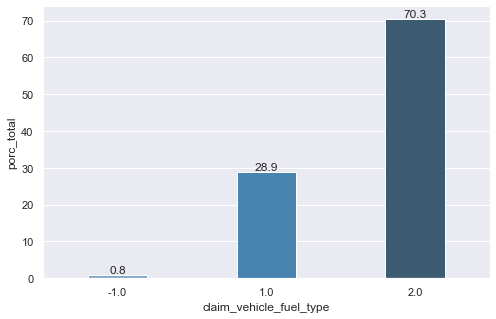

In [553]:
plt.figure(figsize=(8,5))

ax = sns.barplot(x=var, y='porc_total', 
                 data=data.reset_index().sort_values(by='porc_total',ascending=False),palette='Blues_d')
widthbars = [0.4, 0.4, 0.4]

for p,newwidth in zip(ax.patches,widthbars):
    
    x = p.get_x()
    width = p.get_width()
    centre = x + width/2.
    p.set_x(centre - newwidth/2.)
    p.set_width(newwidth)
    
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), 
                   textcoords = 'offset points',
                   size=12)

plt.show()

In [554]:
df_total.set_index(var,inplace=True)

In [555]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55419, 80)


claim_vehicle_fuel_type fraud  claim_amount  claim_date_registered  \
0                     -1.0     N       2883.56               20170108   
1                     -1.0     N       3550.99               20171119   
2                     -1.0     Y      15163.00               20170630   
3                     -1.0     N       3964.88               20170709   
4                     -1.0     N        223.00               20170324   

   claim_vehicle_power  policy_holder_postal_code policy_holder_form  \
0                  NaN                     4052.0                  M   
1                  NaN                     7911.0                  F   
2                  NaN                     6224.0                  F   
3                  NaN                     9080.0                  M   
4                  NaN                     6180.0                  M   

   policy_holder_year_birth policy_holder_country  driver_postal_code  \
0                    1933.0                     B              4000.0   
1                    1972.0                     B              1030.0   
2                    1978.0                     B              5530.0   
3                    1976.0                     B              1000.0   
4                    1951.0                     B              6150.0   

  driver_form  driver_year_birth driver_country driver_injured  \
0           M                NaN              B              N   
1           M                NaN              B              N   
2           M                NaN              B              N   
3           M                NaN              B              N   
4           M                NaN              B              N   

   third_party_1_postal_code third_party_1_injured third_party_1_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                     6000.0                     N                        bus   

  third_party_1_form  third_party_1_year_birth third_party_1_country  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                  C                       NaN                     B   

   third_party_2_postal_code third_party_2_injured third_party_2_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN                        NaN   

  third_party_2_form  third_party_2_year_birth third_party_2_country  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   third_party_3_postal_code third_party_3_injured third_party_3_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN

In [556]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
claim_vehicle_fuel_type                                                     
 2.0                        80253228.05      1544567.36                76.49
 1.0                        33411969.92       437933.51                21.69
-1.0                         1264290.67        36758.77                 1.82

In [557]:
### 

In [558]:
table.to_clipboard(index=True,header=True)

In [559]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [560]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [561]:
data[var].dtype

dtype('float64')

In [562]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [563]:
temp.index.dtype

dtype('float64')

In [564]:
dict_woe.update(temp.to_dict())

In [565]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [566]:
len(dict_woe)

17

In [567]:
var

'claim_vehicle_fuel_type'

In [568]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [569]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [570]:
data['woe_'+var+'_cat'] = data[var]

In [571]:
data['woe_'+var+'_cat'] = np.where(data['woe_'+var+'_cat'].isin([2.0,-1.0]),'2.0','1.0')

In [572]:
data['woe_'+var+'_cat'].value_counts(normalize=True)

2.0    0.711326
1.0    0.288674
Name: woe_claim_vehicle_fuel_type_cat, dtype: float64

In [573]:
data['woe_'+var+'_cat'].value_counts(normalize=False)

2.0    39421
1.0    15998
Name: woe_claim_vehicle_fuel_type_cat, dtype: int64

In [574]:
'woe_'+var+'_cat'

'woe_claim_vehicle_fuel_type_cat'

In [575]:
dict_categ = {'woe_claim_vehicle_fuel_type_cat':['1.0','2.0']}

data = categorical(data,dict_categ)

In [576]:
# Get dummies
data = pd.get_dummies(data,
                      columns=data.columns[
                                           np.where(data.dtypes == 'category')
                                           ],
                      drop_first=True
                      )

In [577]:
columns_f = [col for col in data.columns if (var not in col)]+['woe_'+var]+['woe_claim_vehicle_fuel_type_cat_2.0']+[var]
print(len(columns_f))
print(data.shape)

data = data.reindex(columns=columns_f)

82
(55419, 82)


In [578]:
data[var] = np.where(data[var]==-1,np.nan,data[var])

In [579]:
data.drop('woe',axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 81)


fraud  claim_amount  claim_date_registered  claim_vehicle_power  \
0     N       2883.56               20170108                  NaN   
1     N       3550.99               20171119                  NaN   
2     Y      15163.00               20170630                  NaN   
3     N       3964.88               20170709                  NaN   
4     N        223.00               20170324                  NaN   

   policy_holder_postal_code policy_holder_form  policy_holder_year_birth  \
0                     4052.0                  M                    1933.0   
1                     7911.0                  F                    1972.0   
2                     6224.0                  F                    1978.0   
3                     9080.0                  M                    1976.0   
4                     6180.0                  M                    1951.0   

  policy_holder_country  driver_postal_code driver_form  driver_year_birth  \
0                     B              4000.0           M                NaN   
1                     B              1030.0           M                NaN   
2                     B              5530.0           M                NaN   
3                     B              1000.0           M                NaN   
4                     B              6150.0           M                NaN   

  driver_country driver_injured  third_party_1_postal_code  \
0              B              N                        NaN   
1              B              N                        NaN   
2              B              N                        NaN   
3              B              N                        NaN   
4              B              N                     6000.0   

  third_party_1_injured third_party_1_vehicle_type third_party_1_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                     N                        bus                  C   

   third_party_1_year_birth third_party_1_country  third_party_2_postal_code  \
0                       NaN                   NaN                        NaN   
1                       NaN                   NaN                        NaN   
2                       NaN                   NaN                        NaN   
3                       NaN                   NaN                        NaN   
4                       NaN                     B                        NaN   

  third_party_2_injured third_party_2_vehicle_type third_party_2_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_2_year_birth third_party_2_country  third_party_3_postal_code  \
0                       NaN                   NaN                        NaN   
1                       NaN                   NaN                        NaN   
2                       NaN                   NaN                        NaN   
3                       NaN                   NaN                        NaN   
4                       NaN                   NaN                        NaN   

  third_party_3_injured third_party_3_vehicle_type third_party_3_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   

In [580]:
#############

In [581]:
var = 'claim_vehicle_power'

In [582]:
df_total[var].isna().sum()

9148

In [583]:
print(df_total[var].min())
print(df_total[var].max())

0.0
426.0


In [584]:
df_total.shape

(55419, 81)

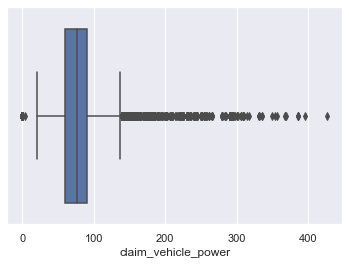

In [585]:
sns.boxplot(x=df_total[var].dropna())
plt.show()

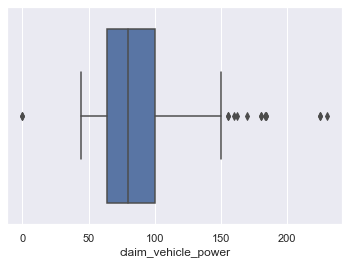

In [586]:
sns.boxplot(x=df_total.loc[df_total['fraud']=='Y',var].dropna())
plt.show()

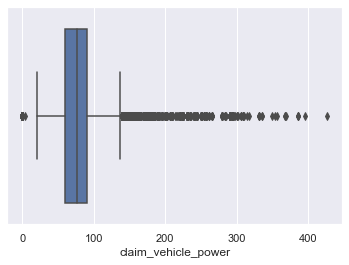

In [587]:
sns.boxplot(x=df_total.loc[df_total['fraud']=='N',var].dropna())
plt.show()

In [588]:
print(df_total.loc[df_total['fraud']=='Y',var].dropna().quantile([0, 0.05, .1, .25, .5, .75, 0.8, 0.85, 0.9, .95, 1]))
print(df_total.loc[df_total['fraud']=='N',var].dropna().quantile([0, 0.05, .1, .25, .5, .75, 0.8, 0.85, 0.9, .95, 1]))

0.00      0.00
0.05     50.00
0.10     51.00
0.25     63.75
0.50     80.00
0.75    100.00
0.80    102.20
0.85    110.00
0.90    120.00
0.95    150.00
1.00    230.00
Name: claim_vehicle_power, dtype: float64
0.00      0.0
0.05     44.0
0.10     50.0
0.25     59.0
0.50     76.0
0.75     91.0
0.80    100.0
0.85    100.0
0.90    110.0
0.95    125.0
1.00    426.0
Name: claim_vehicle_power, dtype: float64


In [589]:
df_total[var].dropna().quantile([0, 0.05, .1, .25, .5, .75, 0.8, 0.85, 0.9, .95, 1])

0.00      0.0
0.05     44.0
0.10     50.0
0.25     59.0
0.50     76.0
0.75     91.0
0.80    100.0
0.85    100.0
0.90    110.0
0.95    125.0
1.00    426.0
Name: claim_vehicle_power, dtype: float64

In [590]:
q_95 = df_total[var].quantile(.95)
print(q_95)

q_05 = df_total[var].quantile(.05)
print(q_05)

df_total[var] = np.where(df_total[var].isna(),np.nan, 
                      np.where(df_total[var]>=int(q_95),int(q_95),
                               np.where(df_total[var]<=int(q_05),int(q_05),df_total[var])))

125.0
44.0


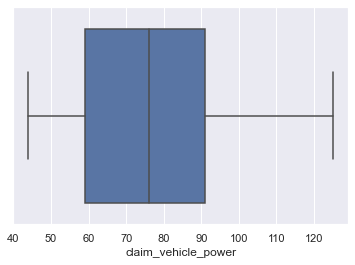

In [591]:
sns.boxplot(x=df_total[var].dropna())
plt.show()

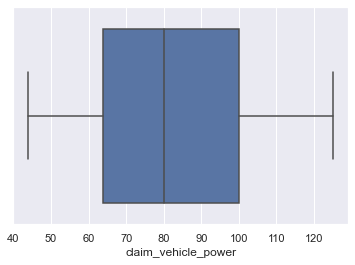

In [592]:
sns.boxplot(x=df_total.loc[df_total['fraud']=='Y',var].dropna())
plt.show()

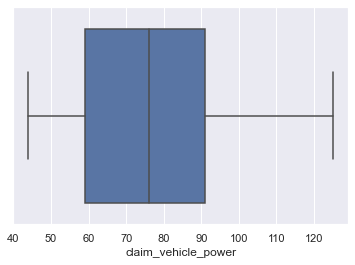

In [593]:
sns.boxplot(x=df_total.loc[df_total['fraud']=='N',var].dropna())
plt.show()

In [594]:
df_total[var] = np.where(df_total[var].isna(),-1,df_total[var])

In [595]:
data = woe(df_total,var)
#data.sort_index()
data.head()

N  Y  total   porc_N  porc_Y  porc_total       woe
claim_vehicle_power                                                      
102.0                 13  1     14  92.8571  7.1429      0.0253 -262.2055
111.0                 18  1     19  94.7368  5.2632      0.0343 -229.6633
108.0                 35  1     36  97.2222  2.7778      0.0650 -163.1657
94.0                 122  3    125  97.6000  2.4000      0.2256 -148.1596
104.0                 49  1     50  98.0000  2.0000      0.0902 -129.5185

In [596]:
data.to_clipboard(index=True,header=True)

In [597]:
df_total.set_index(var,inplace=True)

In [598]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55419, 82)


claim_vehicle_power fraud  claim_amount  claim_date_registered  \
0                 -1.0     N       2883.56               20170108   
1                 -1.0     N       3550.99               20171119   
2                 -1.0     Y      15163.00               20170630   
3                 -1.0     N       3964.88               20170709   
4                 -1.0     N        223.00               20170324   

   policy_holder_postal_code policy_holder_form  policy_holder_year_birth  \
0                     4052.0                  M                    1933.0   
1                     7911.0                  F                    1972.0   
2                     6224.0                  F                    1978.0   
3                     9080.0                  M                    1976.0   
4                     6180.0                  M                    1951.0   

  policy_holder_country  driver_postal_code driver_form  driver_year_birth  \
0                     B              4000.0           M                NaN   
1                     B              1030.0           M                NaN   
2                     B              5530.0           M                NaN   
3                     B              1000.0           M                NaN   
4                     B              6150.0           M                NaN   

  driver_country driver_injured  third_party_1_postal_code  \
0              B              N                        NaN   
1              B              N                        NaN   
2              B              N                        NaN   
3              B              N                        NaN   
4              B              N                     6000.0   

  third_party_1_injured third_party_1_vehicle_type third_party_1_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                     N                        bus                  C   

   third_party_1_year_birth third_party_1_country  third_party_2_postal_code  \
0                       NaN                   NaN                        NaN   
1                       NaN                   NaN                        NaN   
2                       NaN                   NaN                        NaN   
3                       NaN                   NaN                        NaN   
4                       NaN                     B                        NaN   

  third_party_2_injured third_party_2_vehicle_type third_party_2_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_2_year_birth third_party_2_country  third_party_3_postal_code  \
0                       NaN                   NaN                        NaN   
1                       NaN                   NaN                        NaN   
2                       NaN                   NaN                        NaN   
3                       NaN                   NaN                        NaN   
4                       NaN                   NaN                        NaN   

  third_party_3_injured third_party_3_vehicle_type third_party_3_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   t

In [599]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
claim_vehicle_power                                                     
-1.0                    13849196.34       238208.05                11.80
 125.0                   7244512.93       220490.94                10.92
 100.0                   6151252.98       201591.07                 9.98
 66.0                    9180681.66       134194.30                 6.65
 55.0                    7026190.42       132734.13                 6.57

In [600]:
### 

In [601]:
table.to_clipboard(index=True,header=True)

In [602]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [603]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [604]:
data[var].dtype

dtype('float64')

In [605]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [606]:
temp.index.dtype

dtype('float64')

In [607]:
dict_woe.update(temp.to_dict())

In [608]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [609]:
len(dict_woe)

18

In [610]:
var

'claim_vehicle_power'

In [611]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [612]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [613]:
columns_f = [col for col in data.columns if (var not in col)]+['woe_'+var]+[var]
print(len(columns_f))
print(data.shape)

data = data.reindex(columns=columns_f)

83
(55419, 83)


In [614]:
data[var] = np.where(data[var]==-1,np.nan,data[var])

In [615]:
data.drop('woe',axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 82)


fraud  claim_amount  claim_date_registered  policy_holder_postal_code  \
0     N       2883.56               20170108                     4052.0   
1     N       3550.99               20171119                     7911.0   
2     Y      15163.00               20170630                     6224.0   
3     N       3964.88               20170709                     9080.0   
4     N        223.00               20170324                     6180.0   

  policy_holder_form  policy_holder_year_birth policy_holder_country  \
0                  M                    1933.0                     B   
1                  F                    1972.0                     B   
2                  F                    1978.0                     B   
3                  M                    1976.0                     B   
4                  M                    1951.0                     B   

   driver_postal_code driver_form  driver_year_birth driver_country  \
0              4000.0           M                NaN              B   
1              1030.0           M                NaN              B   
2              5530.0           M                NaN              B   
3              1000.0           M                NaN              B   
4              6150.0           M                NaN              B   

  driver_injured  third_party_1_postal_code third_party_1_injured  \
0              N                        NaN                   NaN   
1              N                        NaN                   NaN   
2              N                        NaN                   NaN   
3              N                        NaN                   NaN   
4              N                     6000.0                     N   

  third_party_1_vehicle_type third_party_1_form  third_party_1_year_birth  \
0                        NaN                NaN                       NaN   
1                        NaN                NaN                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        bus                  C                       NaN   

  third_party_1_country  third_party_2_postal_code third_party_2_injured  \
0                   NaN                        NaN                   NaN   
1                   NaN                        NaN                   NaN   
2                   NaN                        NaN                   NaN   
3                   NaN                        NaN                   NaN   
4                     B                        NaN                   NaN   

  third_party_2_vehicle_type third_party_2_form  third_party_2_year_birth  \
0                        NaN                NaN                       NaN   
1                        NaN                NaN                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        NaN                NaN                       NaN   

  third_party_2_country  third_party_3_postal_code third_party_3_injured  \
0                   NaN                        NaN                   NaN   
1                   NaN                        NaN                   NaN   
2                   NaN                        NaN                   NaN   
3                   NaN                        NaN                   NaN   
4                   NaN                        NaN                   NaN   

  third_party_3_vehicle_type third_party_3_form  third_party_3_year_birth  \
0                        NaN                NaN                       NaN   
1                        NaN                NaN                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        NaN                NaN    

In [616]:
#############

In [617]:
var = 'policy_holder_postal_code'

In [618]:
len(df_total[var].unique())

1081

In [619]:
df_total[var].isna().sum()

109

In [620]:
df_total.loc[df_total[var].isna(),'fraud'].value_counts()

N    108
Y      1
Name: fraud, dtype: int64

In [621]:
df_total[var].dtype

dtype('float64')

In [622]:
df_total[var] = np.where(df_total[var].isna(),'missing',df_total[var])

In [623]:
data = woe(df_total,var)

print(data.shape)
data.head()

(1081, 7)


N  Y  total  porc_N  porc_Y  porc_total       woe
policy_holder_postal_code                                                   
5541.0                     0  1      1     0.0   100.0      0.0018      -inf
6594.0                     1  1      2    50.0    50.0      0.0036 -518.7005
8690.0                     3  1      4    75.0    25.0      0.0072 -408.8393
3746.0                     4  1      5    80.0    20.0      0.0090 -380.0710
6850.0                     4  1      5    80.0    20.0      0.0090 -380.0710

In [624]:
data[data['woe']==np.inf].shape[0]

869

In [625]:
data.to_clipboard(index=True,header=True)

In [626]:
df_total.set_index(var,inplace=True)

In [627]:
data = df_total.join(data[['woe']])
data.reset_index(inplace=True)
print(data.shape)
data.head()

(55419, 83)


policy_holder_postal_code fraud  claim_amount  claim_date_registered  \
0                    1000.0     N        758.33               20170609   
1                    1000.0     N       4475.83               20170430   
2                    1000.0     N       2311.58               20171126   
3                    1000.0     N       1149.27               20170923   
4                    1000.0     N       1836.84               20170831   

  policy_holder_form  policy_holder_year_birth policy_holder_country  \
0                  M                       NaN                     B   
1                  M                       NaN                     B   
2                  F                    1989.0                     B   
3                  M                    1960.0                     B   
4                  M                    1975.0                     B   

   driver_postal_code driver_form  driver_year_birth driver_country  \
0              1000.0           M                NaN              B   
1              1000.0           M                NaN              B   
2              1000.0           M                NaN              B   
3              1180.0           M                NaN              B   
4              1480.0           M                NaN              B   

  driver_injured  third_party_1_postal_code third_party_1_injured  \
0              N                        NaN                   NaN   
1              N                        NaN                   NaN   
2              N                     1860.0                     N   
3              N                     1601.0                     N   
4              N                     1630.0                     N   

  third_party_1_vehicle_type third_party_1_form  third_party_1_year_birth  \
0                        NaN                NaN                       NaN   
1                        NaN                NaN                       NaN   
2                        car                  F                    1985.0   
3                        car                  F                    1984.0   
4                        car                  M                    1947.0   

  third_party_1_country  third_party_2_postal_code third_party_2_injured  \
0                   NaN                        NaN                   NaN   
1                   NaN                        NaN                   NaN   
2                     B                        NaN                   NaN   
3                     B                        NaN                   NaN   
4                     B                        NaN                   NaN   

  third_party_2_vehicle_type third_party_2_form  third_party_2_year_birth  \
0                        NaN                NaN                       NaN   
1                        NaN                NaN                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        NaN                NaN                       NaN   

  third_party_2_country  third_party_3_postal_code third_party_3_injured  \
0                   NaN                        NaN                   NaN   
1                   NaN                        NaN                   NaN   
2                   NaN                        NaN                   NaN   
3                   NaN                        NaN                   NaN   
4                   NaN                        NaN                   NaN   

  third_party_3_vehicle_type third_party_3_form  third_party_3_year_birth  \
0                        NaN                NaN                       NaN   
1                        NaN                NaN                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        NaN                NaN          

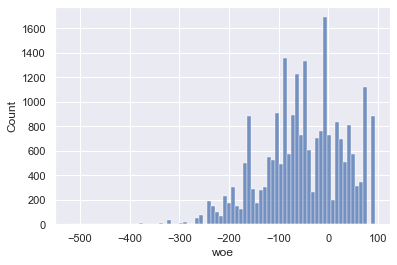

In [628]:
sns.histplot(x=data.loc[(data['woe']!=np.inf) &
                        (data['woe']!=-np.inf),'woe'])
plt.show()

In [629]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
policy_holder_postal_code                                                     
7700.0                         1154994.84       135821.25                 6.73
6001.0                           86574.70        41494.04                 2.05
4430.0                          108179.18        37917.00                 1.88
4020.0                          297196.87        33215.52                 1.64
2170.0                          774452.30        32687.41                 1.62

In [630]:
### take into account the postal code '7700' has the highest percentage of participation of the amount of 
### fraud claims (6.7%)

In [631]:
table.to_clipboard(index=True,header=True)

In [632]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

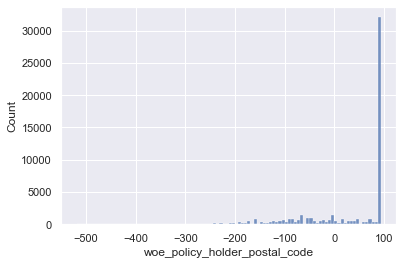

In [633]:
sns.histplot(x=data['woe_'+var])
plt.show()

In [634]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [635]:
data[var].dtype

dtype('O')

In [636]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [637]:
temp.index.dtype

dtype('O')

In [638]:
dict_woe.update(temp.to_dict())

In [639]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [640]:
len(dict_woe)

19

In [641]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [642]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

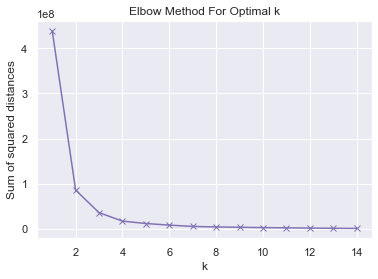

In [643]:
tabla=pd.DataFrame({'woe':data['woe_'+var]})

SEED = 123

#Número de cluster óptimo
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=SEED)
    km = km.fit(tabla)
    sum_of_squared_distances.append(km.inertia_)
#     centroids = km.cluster_centers_
#     print(centroids)

plt.plot(K, sum_of_squared_distances, 'mx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [644]:
km = KMeans(n_clusters=3, random_state=SEED)
km = km.fit(tabla)
km.cluster_centers_
km.labels_

array([0, 0, 0, ..., 1, 1, 1])

In [645]:
breaks = jenkspy.jenks_breaks(data['woe_'+var], nb_class=3)
breaks

[-518.7005, -100.4955, 16.9581, 93.3293]

In [646]:
dict_woe_breaks.update({var:breaks})

In [647]:
with open(path+'dict_woe_train_breaks.json', 'w') as fp:
    json.dump(dict_woe_breaks, fp)

In [648]:
data['woe_'+var+'_cat'] = pd.cut(data['woe_'+var],
                                 bins=breaks,
                                 labels=['high_fraud', 'medium_fraud', 'low_fraud'],
                                 include_lowest=True)

data['woe_'+var+'_cat'].value_counts(normalize=True)

low_fraud       0.665494
medium_fraud    0.224021
high_fraud      0.110486
Name: woe_policy_holder_postal_code_cat, dtype: float64

In [649]:
data['woe_'+var+'_cat'].value_counts(normalize=False)

low_fraud       36881
medium_fraud    12415
high_fraud       6123
Name: woe_policy_holder_postal_code_cat, dtype: int64

In [650]:
'woe_'+var+'_cat'

'woe_policy_holder_postal_code_cat'

In [651]:
dict_categ = {'woe_policy_holder_postal_code_cat':['low_fraud','medium_fraud','high_fraud']}

data = categorical(data,dict_categ)

In [652]:
# Get dummies
data = pd.get_dummies(data,
                      columns=data.columns[
                                           np.where(data.dtypes == 'category')
                                           ],
                      drop_first=True
                      )

In [653]:
data.drop(['woe',var],axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 84)


fraud  claim_amount  claim_date_registered policy_holder_form  \
0     N        758.33               20170609                  M   
1     N       4475.83               20170430                  M   
2     N       2311.58               20171126                  F   
3     N       1149.27               20170923                  M   
4     N       1836.84               20170831                  M   

   policy_holder_year_birth policy_holder_country  driver_postal_code  \
0                       NaN                     B              1000.0   
1                       NaN                     B              1000.0   
2                    1989.0                     B              1000.0   
3                    1960.0                     B              1180.0   
4                    1975.0                     B              1480.0   

  driver_form  driver_year_birth driver_country driver_injured  \
0           M                NaN              B              N   
1           M                NaN              B              N   
2           M                NaN              B              N   
3           M                NaN              B              N   
4           M                NaN              B              N   

   third_party_1_postal_code third_party_1_injured third_party_1_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                     1860.0                     N                        car   
3                     1601.0                     N                        car   
4                     1630.0                     N                        car   

  third_party_1_form  third_party_1_year_birth third_party_1_country  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                  F                    1985.0                     B   
3                  F                    1984.0                     B   
4                  M                    1947.0                     B   

   third_party_2_postal_code third_party_2_injured third_party_2_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN                        NaN   

  third_party_2_form  third_party_2_year_birth third_party_2_country  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   third_party_3_postal_code third_party_3_injured third_party_3_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN                        NaN   

  third_party_3_form  third_party_3_year_birth third_party_3_country  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   

In [654]:
#############

In [655]:
var = 'policy_holder_form'

In [656]:
len(df_total[var].unique())

2

In [657]:
df_total[var].unique()

array(['M', 'F'], dtype=object)

In [658]:
df_total[var].value_counts(normalize=True)

M    0.631047
F    0.368953
Name: policy_holder_form, dtype: float64

In [659]:
data = woe(df_total,var)
#data.sort_index()
data

N    Y  total   porc_N  porc_Y  porc_total      woe
policy_holder_form                                                         
M                   34760  212  34972  99.3938  0.6062     63.1047  -8.7369
F                   20351   96  20447  99.5305  0.4695     36.8953  16.9532

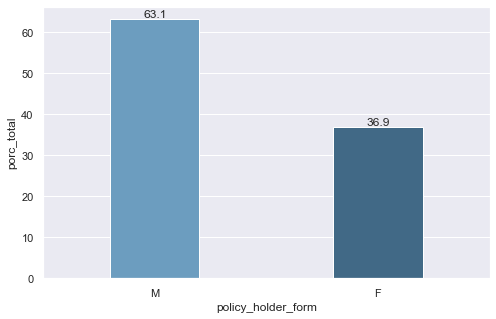

In [660]:
plt.figure(figsize=(8,5))

ax = sns.barplot(x=var, y='porc_total', 
                 data=data.reset_index().sort_values(by='porc_total',ascending=False),palette='Blues_d')
widthbars = [0.4, 0.4]

for p,newwidth in zip(ax.patches,widthbars):
    
    x = p.get_x()
    width = p.get_width()
    centre = x + width/2.
    p.set_x(centre - newwidth/2.)
    p.set_width(newwidth)
    
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), 
                   textcoords = 'offset points',
                   size=12)

plt.show()

In [661]:
df_total.set_index(var,inplace=True)

In [662]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55419, 85)


policy_holder_form fraud  claim_amount  claim_date_registered  \
0                  F     N       2311.58               20171126   
1                  F     N       1760.01               20170720   
2                  F     N        977.42               20170918   
3                  F     N       1224.24               20170213   
4                  F     N        200.00               20171028   

   policy_holder_year_birth policy_holder_country  driver_postal_code  \
0                    1989.0                     B              1000.0   
1                    1977.0                     B              1000.0   
2                    1984.0                     B              3583.0   
3                       NaN                     B              1000.0   
4                    1979.0                     B              1050.0   

  driver_form  driver_year_birth driver_country driver_injured  \
0           M                NaN              B              N   
1           M                NaN              B              N   
2           M                NaN              B              N   
3           M                NaN              B              N   
4           M                NaN              B              N   

   third_party_1_postal_code third_party_1_injured third_party_1_vehicle_type  \
0                     1860.0                     N                        car   
1                     1000.0                     N                        van   
2                     3600.0                     N                        car   
3                     1070.0                     N                        car   
4                     1090.0                     N                        car   

  third_party_1_form  third_party_1_year_birth third_party_1_country  \
0                  F                    1985.0                     B   
1                  M                       NaN                     B   
2                  C                       NaN                     B   
3                  C                       NaN                     B   
4                  M                    1975.0                     B   

   third_party_2_postal_code third_party_2_injured third_party_2_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN                        NaN   

  third_party_2_form  third_party_2_year_birth third_party_2_country  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   third_party_3_postal_code third_party_3_injured third_party_3_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN                        NaN   

  third_party_3_form  third_party_3_year_birth third_party_3_country  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   

In [663]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
policy_holder_form                                                     
M                      72358846.96      1371486.83                67.92
F                      42570641.68       647772.81                32.08

In [664]:
### the 61% of the amount of fraud claims is when the claim was registered in language 1

In [665]:
table.to_clipboard(index=True,header=True)

In [666]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [667]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [668]:
data[var].dtype

dtype('O')

In [669]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [670]:
temp.index.dtype

dtype('O')

In [671]:
dict_woe.update(temp.to_dict())

In [672]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [673]:
len(dict_woe)

20

In [674]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [675]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [676]:
data[var+'_cat'] = data[var].astype(str)

In [677]:
var+'_cat'

'policy_holder_form_cat'

In [678]:
data[var+'_cat'].unique()

array(['F', 'M'], dtype=object)

In [679]:
dict_categ = {'policy_holder_form_cat':['F','M']}

data = categorical(data,dict_categ)

In [680]:
# Get dummies
data = pd.get_dummies(data,
                      columns=data.columns[
                                           np.where(data.dtypes == 'category')
                                           ],
                      drop_first=True
                      )

In [681]:
#data.reset_index(drop=True,inplace=True)
data.drop(['woe',var],axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 85)


fraud  claim_amount  claim_date_registered  policy_holder_year_birth  \
0     N       2311.58               20171126                    1989.0   
1     N       1760.01               20170720                    1977.0   
2     N        977.42               20170918                    1984.0   
3     N       1224.24               20170213                       NaN   
4     N        200.00               20171028                    1979.0   

  policy_holder_country  driver_postal_code driver_form  driver_year_birth  \
0                     B              1000.0           M                NaN   
1                     B              1000.0           M                NaN   
2                     B              3583.0           M                NaN   
3                     B              1000.0           M                NaN   
4                     B              1050.0           M                NaN   

  driver_country driver_injured  third_party_1_postal_code  \
0              B              N                     1860.0   
1              B              N                     1000.0   
2              B              N                     3600.0   
3              B              N                     1070.0   
4              B              N                     1090.0   

  third_party_1_injured third_party_1_vehicle_type third_party_1_form  \
0                     N                        car                  F   
1                     N                        van                  M   
2                     N                        car                  C   
3                     N                        car                  C   
4                     N                        car                  M   

   third_party_1_year_birth third_party_1_country  third_party_2_postal_code  \
0                    1985.0                     B                        NaN   
1                       NaN                     B                        NaN   
2                       NaN                     B                        NaN   
3                       NaN                     B                        NaN   
4                    1975.0                     B                        NaN   

  third_party_2_injured third_party_2_vehicle_type third_party_2_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_2_year_birth third_party_2_country  third_party_3_postal_code  \
0                       NaN                   NaN                        NaN   
1                       NaN                   NaN                        NaN   
2                       NaN                   NaN                        NaN   
3                       NaN                   NaN                        NaN   
4                       NaN                   NaN                        NaN   

  third_party_3_injured third_party_3_vehicle_type third_party_3_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_3_year_birth third_party_3_country  repair_postal_code  \
0                       NaN                   NaN                 NaN   
1                       NaN                   NaN              1070.0   
2                       NaN                   NaN                 NaN   
3                       NaN                   NaN                 NaN   
4                       NaN                   NaN              1050.0  

In [682]:
#############

In [683]:
var = 'policy_holder_year_birth'

In [684]:
df_total[var].isna().sum()

5381

In [685]:
print(df_total[var].min())
print(df_total[var].max())

1900.0
2015.0


In [686]:
df_total[var].value_counts().sort_index().head(10)

1900.0     2
1901.0     1
1917.0     1
1919.0     2
1921.0     3
1923.0     4
1924.0    11
1925.0    16
1926.0    21
1927.0    27
Name: policy_holder_year_birth, dtype: int64

In [687]:
df_total.shape

(55419, 85)

In [688]:
base_date = pd.to_datetime(df_total['claim_date_registered'], format='%Y%m%d')
base_date.dt.year

0        2017
1        2017
2        2017
3        2017
4        2017
         ... 
55414    2017
55415    2017
55416    2017
55417    2017
55418    2017
Name: claim_date_registered, Length: 55419, dtype: int64

In [689]:
df_total['age_policy_holder'] = (base_date.dt.year - pd.to_datetime(df_total[var], format='%Y').dt.year)

In [690]:
print(df_total[var].isna().sum())
print(df_total['age_policy_holder'].isna().sum())

5381
5381


In [691]:
var = 'age_policy_holder'

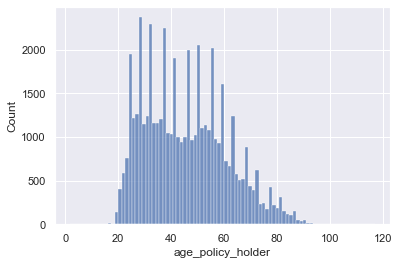

In [692]:
sns.histplot(x=df_total[var].dropna())
plt.show()

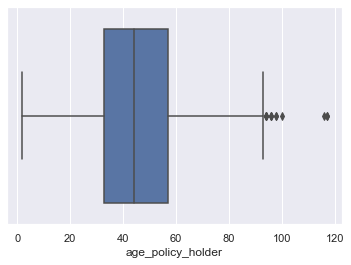

In [693]:
sns.boxplot(x=df_total[var].dropna())
plt.show()

In [694]:
df_total[var].dropna().quantile([0, 0.05, .1, .25, .5, .75, 0.8, 0.85, 0.9, .95, 1])

0.00      2.0
0.05     24.0
0.10     26.0
0.25     33.0
0.50     44.0
0.75     57.0
0.80     59.0
0.85     63.0
0.90     67.0
0.95     73.0
1.00    117.0
Name: age_policy_holder, dtype: float64

In [695]:
df_total[df_total[var]<=18].shape

(30, 86)

In [696]:
df_total.loc[df_total[var]<=18,var].value_counts()

17.0    15
2.0      7
18.0     3
3.0      2
11.0     1
13.0     1
16.0     1
Name: age_policy_holder, dtype: int64

In [697]:
df_total.loc[df_total[var]<=18,'fraud'].value_counts()

N    28
Y     2
Name: fraud, dtype: int64

In [698]:
q_95 = df_total[var].quantile(.95)
print(q_95)

df_total[var] = np.where(df_total[var].isna(),np.nan,
                         np.where(df_total[var]<=18,18,
                                  np.where(df_total[var]>=int(q_95),int(q_95),df_total[var])))

73.0


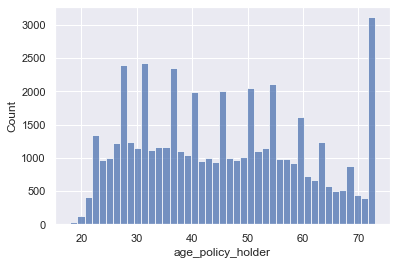

In [699]:
sns.histplot(x=df_total[var].dropna())
plt.show()

In [700]:
df_total[var] = np.where(df_total[var].isna(),-1,df_total[var])

In [701]:
data = woe(df_total,var)
data.sort_index().head()
#data

N   Y  total   porc_N   porc_Y  porc_total       woe
age_policy_holder                                                         
-1.0               5347  34   5381  99.3681   0.6319      9.7097  -12.9074
 18.0                28   2     30  93.3333   6.6667      0.0541 -254.7947
 19.0                 6   1      7  85.7143  14.2857      0.0126 -339.5245
 20.0               129   1    130  99.2308   0.7692      0.2346  -32.7192
 21.0               404   1    405  99.7531   0.2469      0.7308   81.4410

In [702]:
df_total[var].dtype

dtype('float64')

In [703]:
df_total.set_index(var,inplace=True)

In [704]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55419, 87)


age_policy_holder fraud  claim_amount  claim_date_registered  \
0               -1.0     N       1224.24               20170213   
1               -1.0     N        868.48               20170226   
2               -1.0     N        424.00               20170202   
3               -1.0     N       1757.75               20170216   
4               -1.0     N       1122.50               20170223   

   policy_holder_year_birth policy_holder_country  driver_postal_code  \
0                       NaN                     B              1000.0   
1                       NaN                     B              2870.0   
2                       NaN                     B              1000.0   
3                       NaN                     B              1140.0   
4                       NaN                     B              1030.0   

  driver_form  driver_year_birth driver_country driver_injured  \
0           M                NaN              B              N   
1           M                NaN              B              N   
2           M                NaN              B              N   
3           M                NaN              B              N   
4           M             1981.0              B              N   

   third_party_1_postal_code third_party_1_injured third_party_1_vehicle_type  \
0                     1070.0                     N                        car   
1                     1060.0                     N                        car   
2                     1450.0                     N                        car   
3                     1030.0                     N                        car   
4                     1140.0                     N                        NaN   

  third_party_1_form  third_party_1_year_birth third_party_1_country  \
0                  C                       NaN                     B   
1                  M                       NaN                     B   
2                  F                       NaN                     B   
3                  F                       NaN                     B   
4                  C                       NaN                     B   

   third_party_2_postal_code third_party_2_injured third_party_2_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                     2000.0                     N                        car   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN                        NaN   

  third_party_2_form  third_party_2_year_birth third_party_2_country  \
0                NaN                       NaN                   NaN   
1                  F                       NaN                     B   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   third_party_3_postal_code third_party_3_injured third_party_3_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN                        NaN   

  third_party_3_form  third_party_3_year_birth third_party_3_country  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   r

In [705]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
age_policy_holder                                                     
-1.0                   8461776.91       262102.15                12.98
 25.0                  2375118.08        98180.59                 4.86
 31.0                  2649829.07        96825.11                 4.80
 28.0                  2575019.71        82152.85                 4.07
 47.0                  1927660.53        78773.97                 3.90

In [706]:
### 

In [707]:
table.to_clipboard(index=True,header=True)

In [708]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [709]:
print(data[data['woe_'+var]==np.inf].shape[0])
print(data[data['woe_'+var]==-np.inf].shape[0])

0
0


In [710]:
data[var].dtype

dtype('float64')

In [711]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [712]:
temp.index.dtype

dtype('float64')

In [713]:
dict_woe.update(temp.to_dict())

In [714]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [715]:
len(dict_woe)

21

In [716]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [717]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [718]:
columns_f = [col for col in data.columns if (var not in col)]+['woe_'+var]+[var]
print(len(columns_f))
print(data.shape)

data = data.reindex(columns=columns_f)

88
(55419, 88)


In [719]:
data[var] = np.where(data[var]==-1,np.nan,data[var])

In [720]:
data[var].isna().sum()

5381

In [721]:
#data.reset_index(drop=True,inplace=True)
data.drop(['woe','policy_holder_year_birth'],axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 86)


fraud  claim_amount  claim_date_registered policy_holder_country  \
0     N       1224.24               20170213                     B   
1     N        868.48               20170226                     B   
2     N        424.00               20170202                     B   
3     N       1757.75               20170216                     B   
4     N       1122.50               20170223                     B   

   driver_postal_code driver_form  driver_year_birth driver_country  \
0              1000.0           M                NaN              B   
1              2870.0           M                NaN              B   
2              1000.0           M                NaN              B   
3              1140.0           M                NaN              B   
4              1030.0           M             1981.0              B   

  driver_injured  third_party_1_postal_code third_party_1_injured  \
0              N                     1070.0                     N   
1              N                     1060.0                     N   
2              N                     1450.0                     N   
3              N                     1030.0                     N   
4              N                     1140.0                     N   

  third_party_1_vehicle_type third_party_1_form  third_party_1_year_birth  \
0                        car                  C                       NaN   
1                        car                  M                       NaN   
2                        car                  F                       NaN   
3                        car                  F                       NaN   
4                        NaN                  C                       NaN   

  third_party_1_country  third_party_2_postal_code third_party_2_injured  \
0                     B                        NaN                   NaN   
1                     B                     2000.0                     N   
2                     B                        NaN                   NaN   
3                     B                        NaN                   NaN   
4                     B                        NaN                   NaN   

  third_party_2_vehicle_type third_party_2_form  third_party_2_year_birth  \
0                        NaN                NaN                       NaN   
1                        car                  F                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        NaN                NaN                       NaN   

  third_party_2_country  third_party_3_postal_code third_party_3_injured  \
0                   NaN                        NaN                   NaN   
1                     B                        NaN                   NaN   
2                   NaN                        NaN                   NaN   
3                   NaN                        NaN                   NaN   
4                   NaN                        NaN                   NaN   

  third_party_3_vehicle_type third_party_3_form  third_party_3_year_birth  \
0                        NaN                NaN                       NaN   
1                        NaN                NaN                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        NaN                NaN                       NaN   

  third_party_3_country  repair_postal_code repair_form  repair_year_birth  \
0                   NaN                 NaN         NaN                NaN   
1                   NaN                 NaN         NaN                NaN   
2                   NaN              1420.0           C                NaN   
3                   NaN                 NaN         NaN                NaN   
4                   NaN                 NaN   

In [722]:
#############

In [723]:
var = 'policy_holder_country'

In [724]:
len(df_total[var].unique())

2

In [725]:
df_total[var].unique()

array(['B', 'N'], dtype=object)

In [726]:
df_total[var].value_counts(normalize=True)

B    0.998033
N    0.001967
Name: policy_holder_country, dtype: float64

In [727]:
data = woe(df_total,var)
#data.sort_index()
data

N    Y  total   porc_N  porc_Y  porc_total      woe
policy_holder_country                                                         
N                        108    1    109  99.0826  0.9174      0.1967 -50.4874
B                      55003  307  55310  99.4449  0.5551     99.8033   0.1290

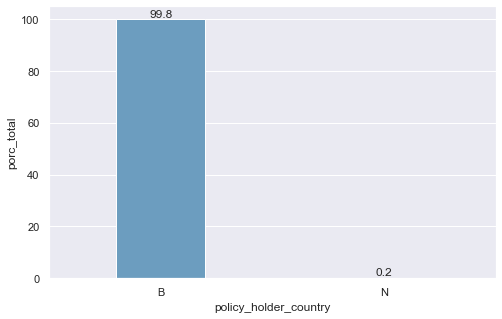

In [728]:
plt.figure(figsize=(8,5))

ax = sns.barplot(x=var, y='porc_total', 
                 data=data.reset_index().sort_values(by='porc_total',ascending=False),palette='Blues_d')
widthbars = [0.4, 0.4]

for p,newwidth in zip(ax.patches,widthbars):
    
    x = p.get_x()
    width = p.get_width()
    centre = x + width/2.
    p.set_x(centre - newwidth/2.)
    p.set_width(newwidth)
    
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), 
                   textcoords = 'offset points',
                   size=12)

plt.show()

In [729]:
df_total.set_index(var,inplace=True)

In [730]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55419, 87)


policy_holder_country fraud  claim_amount  claim_date_registered  \
0                     B     N       1224.24               20170213   
1                     B     N        868.48               20170226   
2                     B     N        424.00               20170202   
3                     B     N       1757.75               20170216   
4                     B     N       1122.50               20170223   

   driver_postal_code driver_form  driver_year_birth driver_country  \
0              1000.0           M                NaN              B   
1              2870.0           M                NaN              B   
2              1000.0           M                NaN              B   
3              1140.0           M                NaN              B   
4              1030.0           M             1981.0              B   

  driver_injured  third_party_1_postal_code third_party_1_injured  \
0              N                     1070.0                     N   
1              N                     1060.0                     N   
2              N                     1450.0                     N   
3              N                     1030.0                     N   
4              N                     1140.0                     N   

  third_party_1_vehicle_type third_party_1_form  third_party_1_year_birth  \
0                        car                  C                       NaN   
1                        car                  M                       NaN   
2                        car                  F                       NaN   
3                        car                  F                       NaN   
4                        NaN                  C                       NaN   

  third_party_1_country  third_party_2_postal_code third_party_2_injured  \
0                     B                        NaN                   NaN   
1                     B                     2000.0                     N   
2                     B                        NaN                   NaN   
3                     B                        NaN                   NaN   
4                     B                        NaN                   NaN   

  third_party_2_vehicle_type third_party_2_form  third_party_2_year_birth  \
0                        NaN                NaN                       NaN   
1                        car                  F                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        NaN                NaN                       NaN   

  third_party_2_country  third_party_3_postal_code third_party_3_injured  \
0                   NaN                        NaN                   NaN   
1                     B                        NaN                   NaN   
2                   NaN                        NaN                   NaN   
3                   NaN                        NaN                   NaN   
4                   NaN                        NaN                   NaN   

  third_party_3_vehicle_type third_party_3_form  third_party_3_year_birth  \
0                        NaN                NaN                       NaN   
1                        NaN                NaN                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        NaN                NaN                       NaN   

  third_party_3_country  repair_postal_code repair_form  repair_year_birth  \
0                   NaN                 NaN         NaN                NaN   
1                   NaN                 NaN         NaN                NaN   
2                   NaN              1420.0           C                NaN   
3                   NaN                 NaN         NaN                NaN   
4                   NaN                 NaN   

In [731]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
policy_holder_country                                                     
B                        1.147290e+08      2017861.20                99.93
N                        2.004989e+05         1398.44                 0.07

In [732]:
### 

In [733]:
table.to_clipboard(index=True,header=True)

In [734]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [735]:
print(data[data['woe_'+var]==np.inf].shape[0])
print(data[data['woe_'+var]==-np.inf].shape[0])

0
0


In [736]:
data[var].dtype

dtype('O')

In [737]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [738]:
temp.index.dtype

dtype('O')

In [739]:
dict_woe.update(temp.to_dict())

In [740]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [741]:
len(dict_woe)

22

In [742]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [743]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [744]:
data[var+'_cat'] = data[var].astype(str)

In [745]:
var+'_cat'

'policy_holder_country_cat'

In [746]:
data[var+'_cat'].unique()

array(['B', 'N'], dtype=object)

In [747]:
dict_categ = {'policy_holder_country_cat':['B','N']}

data = categorical(data,dict_categ)

In [748]:
# Get dummies
data = pd.get_dummies(data,
                      columns=data.columns[
                                           np.where(data.dtypes == 'category')
                                           ],
                      drop_first=True
                      )

In [749]:
#data.reset_index(drop=True,inplace=True)
data.drop(['woe',var],axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 87)


fraud  claim_amount  claim_date_registered  driver_postal_code driver_form  \
0     N       1224.24               20170213              1000.0           M   
1     N        868.48               20170226              2870.0           M   
2     N        424.00               20170202              1000.0           M   
3     N       1757.75               20170216              1140.0           M   
4     N       1122.50               20170223              1030.0           M   

   driver_year_birth driver_country driver_injured  third_party_1_postal_code  \
0                NaN              B              N                     1070.0   
1                NaN              B              N                     1060.0   
2                NaN              B              N                     1450.0   
3                NaN              B              N                     1030.0   
4             1981.0              B              N                     1140.0   

  third_party_1_injured third_party_1_vehicle_type third_party_1_form  \
0                     N                        car                  C   
1                     N                        car                  M   
2                     N                        car                  F   
3                     N                        car                  F   
4                     N                        NaN                  C   

   third_party_1_year_birth third_party_1_country  third_party_2_postal_code  \
0                       NaN                     B                        NaN   
1                       NaN                     B                     2000.0   
2                       NaN                     B                        NaN   
3                       NaN                     B                        NaN   
4                       NaN                     B                        NaN   

  third_party_2_injured third_party_2_vehicle_type third_party_2_form  \
0                   NaN                        NaN                NaN   
1                     N                        car                  F   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_2_year_birth third_party_2_country  third_party_3_postal_code  \
0                       NaN                   NaN                        NaN   
1                       NaN                     B                        NaN   
2                       NaN                   NaN                        NaN   
3                       NaN                   NaN                        NaN   
4                       NaN                   NaN                        NaN   

  third_party_3_injured third_party_3_vehicle_type third_party_3_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_3_year_birth third_party_3_country  repair_postal_code  \
0                       NaN                   NaN                 NaN   
1                       NaN                   NaN                 NaN   
2                       NaN                   NaN              1420.0   
3                       NaN                   NaN                 NaN   
4                       NaN                   NaN                 NaN   

  repair_form  repair_year_birth repair_country repair_sla  policy_date_start  \
0         NaN                NaN            NaN          N                NaN   
1         NaN                NaN            NaN          N                NaN   
2           C                NaN              B          N               

In [750]:
#############

In [751]:
var = 'driver_postal_code'

In [752]:
len(df_total[var].unique())

1077

In [753]:
df_total[var].isna().sum()

70

In [754]:
df_total.loc[df_total[var].isna(),'fraud'].value_counts()

N    69
Y     1
Name: fraud, dtype: int64

In [755]:
df_total[var] = np.where(df_total[var].isna(),'missing',df_total[var])

In [756]:
data = woe(df_total,var)

print(data.shape)
data.head()

(1077, 7)


N  Y  total   porc_N    porc_Y  porc_total       woe
driver_postal_code                                                      
5541.0              0  1      1   0.0000  100.0000      0.0018      -inf
3792.0              1  1      2  50.0000   50.0000      0.0036 -518.7005
8690.0              2  1      3  66.6667   33.3333      0.0054 -449.3858
3746.0              3  1      4  75.0000   25.0000      0.0072 -408.8393
6692.0              5  1      6  83.3333   16.6667      0.0108 -357.7567

In [757]:
print(data[data['woe']==np.inf].shape[0])
print(data[data['woe']==-np.inf].shape[0])

864
1


In [758]:
data.to_clipboard(index=True,header=True)

In [759]:
df_total.set_index(var,inplace=True)

In [760]:
data = df_total.join(data[['woe']])
data.reset_index(inplace=True)
print(data.shape)
data.head()

(55419, 88)


driver_postal_code fraud  claim_amount  claim_date_registered driver_form  \
0             1000.0     N       1224.24               20170213           M   
1             1000.0     N        424.00               20170202           M   
2             1000.0     N       1826.54               20170625           M   
3             1000.0     N       1282.61               20170303           M   
4             1000.0     N       2437.00               20170901           M   

   driver_year_birth driver_country driver_injured  third_party_1_postal_code  \
0                NaN              B              N                     1070.0   
1                NaN              B              N                     1450.0   
2                NaN              B              N                     1160.0   
3                NaN              B              N                     1070.0   
4                NaN              B              N                     1083.0   

  third_party_1_injured third_party_1_vehicle_type third_party_1_form  \
0                     N                        car                  C   
1                     N                        car                  F   
2                     N                        car                  M   
3                     N                        car                  F   
4                     N                        car                  M   

   third_party_1_year_birth third_party_1_country  third_party_2_postal_code  \
0                       NaN                     B                        NaN   
1                       NaN                     B                        NaN   
2                       NaN                     B                        NaN   
3                    1968.0                     B                        NaN   
4                       NaN                     B                        NaN   

  third_party_2_injured third_party_2_vehicle_type third_party_2_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_2_year_birth third_party_2_country  third_party_3_postal_code  \
0                       NaN                   NaN                        NaN   
1                       NaN                   NaN                        NaN   
2                       NaN                   NaN                        NaN   
3                       NaN                   NaN                        NaN   
4                       NaN                   NaN                        NaN   

  third_party_3_injured third_party_3_vehicle_type third_party_3_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_3_year_birth third_party_3_country  repair_postal_code  \
0                       NaN                   NaN                 NaN   
1                       NaN                   NaN              1420.0   
2                       NaN                   NaN              1050.0   
3                       NaN                   NaN              2100.0   
4                       NaN                   NaN              1050.0   

  repair_form  repair_year_birth repair_country repair_sla  policy_date_start  \
0         NaN                NaN            NaN          N                NaN   
1           C                NaN              B          N                NaN   
2           C                NaN              B          N                NaN  

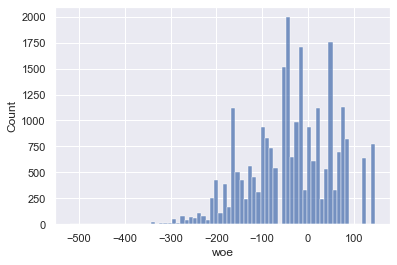

In [761]:
sns.histplot(x=data.loc[(data['woe']!=np.inf) &
                        (data['woe']!=-np.inf),'woe'])
plt.show()

In [762]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
driver_postal_code                                                     
7700.0                  1150797.91       135821.25                 6.73
2440.0                   603852.46        40525.95                 2.01
4430.0                   119584.95        37917.00                 1.88
4020.0                   402382.28        36263.27                 1.80
5530.0                    76833.64        35574.62                 1.76

In [763]:
### take into account the postal code '7700' has the highest percentage of participation of the amount of 
### fraud claims (6.7%)

In [764]:
table.to_clipboard(index=True,header=True)

In [765]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

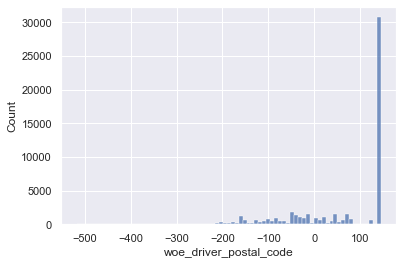

In [766]:
sns.histplot(x=data['woe_'+var])
plt.show()

In [767]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [768]:
data[var].dtype

dtype('O')

In [769]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [770]:
temp.index.dtype

dtype('O')

In [771]:
dict_woe.update(temp.to_dict())

In [772]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [773]:
len(dict_woe)

23

In [774]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [775]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

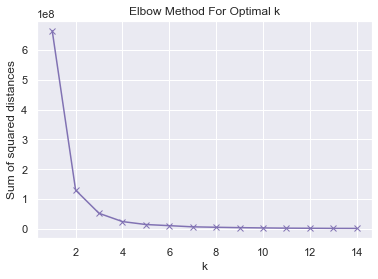

In [776]:
tabla=pd.DataFrame({'woe':data['woe_'+var]})

SEED = 123

#Número de cluster óptimo
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=SEED)
    km = km.fit(tabla)
    sum_of_squared_distances.append(km.inertia_)
#     centroids = km.cluster_centers_
#     print(centroids)

plt.plot(K, sum_of_squared_distances, 'mx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [777]:
km = KMeans(n_clusters=3, random_state=SEED)
km = km.fit(tabla)
km.cluster_centers_
km.labels_

array([2, 2, 2, ..., 1, 1, 1])

In [778]:
breaks = jenkspy.jenks_breaks(data['woe_'+var], nb_class=3)
breaks

[-518.7005, -75.6188, 64.4878, 145.9386]

In [779]:
dict_woe_breaks.update({var:breaks})

In [780]:
with open(path+'dict_woe_train_breaks.json', 'w') as fp:
    json.dump(dict_woe_breaks, fp)

In [781]:
data['woe_'+var+'_cat'] = pd.cut(data['woe_'+var],
                                 bins=breaks,
                                 labels=['high_fraud', 'medium_fraud', 'low_fraud'],
                                 include_lowest=True)

data['woe_'+var+'_cat'].value_counts(normalize=True)

low_fraud       0.608528
medium_fraud    0.245511
high_fraud      0.145961
Name: woe_driver_postal_code_cat, dtype: float64

In [782]:
data['woe_'+var+'_cat'].value_counts(normalize=False)

low_fraud       33724
medium_fraud    13606
high_fraud       8089
Name: woe_driver_postal_code_cat, dtype: int64

In [783]:
'woe_'+var+'_cat'

'woe_driver_postal_code_cat'

In [784]:
dict_categ = {'woe_driver_postal_code_cat':['low_fraud','medium_fraud','high_fraud']}

data = categorical(data,dict_categ)

In [785]:
# Get dummies
data = pd.get_dummies(data,
                      columns=data.columns[
                                           np.where(data.dtypes == 'category')
                                           ],
                      drop_first=True
                      )

In [786]:
data.drop(['woe',var],axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 89)


fraud  claim_amount  claim_date_registered driver_form  driver_year_birth  \
0     N       1224.24               20170213           M                NaN   
1     N        424.00               20170202           M                NaN   
2     N       1826.54               20170625           M                NaN   
3     N       1282.61               20170303           M                NaN   
4     N       2437.00               20170901           M                NaN   

  driver_country driver_injured  third_party_1_postal_code  \
0              B              N                     1070.0   
1              B              N                     1450.0   
2              B              N                     1160.0   
3              B              N                     1070.0   
4              B              N                     1083.0   

  third_party_1_injured third_party_1_vehicle_type third_party_1_form  \
0                     N                        car                  C   
1                     N                        car                  F   
2                     N                        car                  M   
3                     N                        car                  F   
4                     N                        car                  M   

   third_party_1_year_birth third_party_1_country  third_party_2_postal_code  \
0                       NaN                     B                        NaN   
1                       NaN                     B                        NaN   
2                       NaN                     B                        NaN   
3                    1968.0                     B                        NaN   
4                       NaN                     B                        NaN   

  third_party_2_injured third_party_2_vehicle_type third_party_2_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_2_year_birth third_party_2_country  third_party_3_postal_code  \
0                       NaN                   NaN                        NaN   
1                       NaN                   NaN                        NaN   
2                       NaN                   NaN                        NaN   
3                       NaN                   NaN                        NaN   
4                       NaN                   NaN                        NaN   

  third_party_3_injured third_party_3_vehicle_type third_party_3_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_3_year_birth third_party_3_country  repair_postal_code  \
0                       NaN                   NaN                 NaN   
1                       NaN                   NaN              1420.0   
2                       NaN                   NaN              1050.0   
3                       NaN                   NaN              2100.0   
4                       NaN                   NaN              1050.0   

  repair_form  repair_year_birth repair_country repair_sla  policy_date_start  \
0         NaN                NaN            NaN          N                NaN   
1           C                NaN              B          N                NaN   
2           C                NaN              B          N                NaN   
3           C                NaN              B          Y                NaN   
4           C                Na

In [787]:
#############

In [788]:
var = 'driver_form'

In [789]:
len(df_total[var].unique())

2

In [790]:
df_total[var].unique()

array(['M', 'F'], dtype=object)

In [791]:
df_total[var].value_counts(normalize=True)

M    0.719609
F    0.280391
Name: driver_form, dtype: float64

In [792]:
data = woe(df_total,var)
#data.sort_index()
data

N    Y  total   porc_N  porc_Y  porc_total     woe
driver_form                                                        
M            39652  228  39880  99.4283  0.5717     71.9609 -2.8454
F            15459   80  15539  99.4852  0.5148     28.0391  7.6915

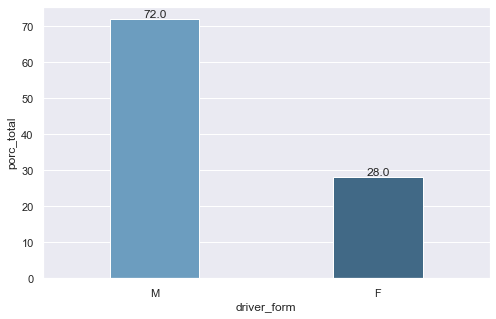

In [793]:
plt.figure(figsize=(8,5))

ax = sns.barplot(x=var, y='porc_total', 
                 data=data.reset_index().sort_values(by='porc_total',ascending=False),palette='Blues_d')
widthbars = [0.4, 0.4]

for p,newwidth in zip(ax.patches,widthbars):
    
    x = p.get_x()
    width = p.get_width()
    centre = x + width/2.
    p.set_x(centre - newwidth/2.)
    p.set_width(newwidth)
    
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), 
                   textcoords = 'offset points',
                   size=12)

plt.show()

In [794]:
df_total.set_index(var,inplace=True)

In [795]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55419, 90)


driver_form fraud  claim_amount  claim_date_registered  driver_year_birth  \
0           F     N       3162.11               20170304             1987.0   
1           F     N       2563.50               20171228             1985.0   
2           F     N       2414.18               20170624             1985.0   
3           F     N       3651.89               20170209             1978.0   
4           F     N       1411.17               20171030             1977.0   

  driver_country driver_injured  third_party_1_postal_code  \
0              B              N                     1160.0   
1              B              N                     1140.0   
2              B              N                     2000.0   
3              B              N                     1081.0   
4              B              N                        NaN   

  third_party_1_injured third_party_1_vehicle_type third_party_1_form  \
0                     N                        car                  M   
1                     N                        car                  M   
2                     N                        car                  C   
3                     N                        car                  M   
4                   NaN                        NaN                NaN   

   third_party_1_year_birth third_party_1_country  third_party_2_postal_code  \
0                       NaN                     B                     1315.0   
1                       NaN                     B                        NaN   
2                       NaN                     B                        NaN   
3                       NaN                     B                     2020.0   
4                       NaN                   NaN                        NaN   

  third_party_2_injured third_party_2_vehicle_type third_party_2_form  \
0                     N                        car                  M   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                     N                        car                  M   
4                   NaN                        NaN                NaN   

   third_party_2_year_birth third_party_2_country  third_party_3_postal_code  \
0                       NaN                     B                        NaN   
1                       NaN                   NaN                        NaN   
2                       NaN                   NaN                        NaN   
3                       NaN                     B                        NaN   
4                       NaN                   NaN                        NaN   

  third_party_3_injured third_party_3_vehicle_type third_party_3_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_3_year_birth third_party_3_country  repair_postal_code  \
0                       NaN                   NaN                 NaN   
1                       NaN                   NaN              1600.0   
2                       NaN                   NaN                 NaN   
3                       NaN                   NaN              1620.0   
4                       NaN                   NaN                 NaN   

  repair_form  repair_year_birth repair_country repair_sla  policy_date_start  \
0         NaN                NaN            NaN          N           201406.0   
1           C                NaN              B          Y           201510.0   
2         NaN                NaN            NaN          N           201705.0   
3           C                NaN              B          N           201612.0   
4         NaN                Na

In [796]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
driver_form                                                     
M              8.183526e+07      1510892.72                74.82
F              3.309422e+07       508366.92                25.18

In [797]:
### 

In [798]:
table.to_clipboard(index=True,header=True)

In [799]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [800]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [801]:
data[var].dtype

dtype('O')

In [802]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [803]:
temp.index.dtype

dtype('O')

In [804]:
dict_woe.update(temp.to_dict())

In [805]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [806]:
len(dict_woe)

24

In [807]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [808]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [809]:
data[var+'_cat'] = data[var].astype(str)

In [810]:
var+'_cat'

'driver_form_cat'

In [811]:
data[var+'_cat'].unique()

array(['F', 'M'], dtype=object)

In [812]:
dict_categ = {'driver_form_cat':['F','M']}

data = categorical(data,dict_categ)

In [813]:
# Get dummies
data = pd.get_dummies(data,
                      columns=data.columns[
                                           np.where(data.dtypes == 'category')
                                           ],
                      drop_first=True
                      )

In [814]:
#data.reset_index(drop=True,inplace=True)
data.drop(['woe',var],axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 90)


fraud  claim_amount  claim_date_registered  driver_year_birth  \
0     N       3162.11               20170304             1987.0   
1     N       2563.50               20171228             1985.0   
2     N       2414.18               20170624             1985.0   
3     N       3651.89               20170209             1978.0   
4     N       1411.17               20171030             1977.0   

  driver_country driver_injured  third_party_1_postal_code  \
0              B              N                     1160.0   
1              B              N                     1140.0   
2              B              N                     2000.0   
3              B              N                     1081.0   
4              B              N                        NaN   

  third_party_1_injured third_party_1_vehicle_type third_party_1_form  \
0                     N                        car                  M   
1                     N                        car                  M   
2                     N                        car                  C   
3                     N                        car                  M   
4                   NaN                        NaN                NaN   

   third_party_1_year_birth third_party_1_country  third_party_2_postal_code  \
0                       NaN                     B                     1315.0   
1                       NaN                     B                        NaN   
2                       NaN                     B                        NaN   
3                       NaN                     B                     2020.0   
4                       NaN                   NaN                        NaN   

  third_party_2_injured third_party_2_vehicle_type third_party_2_form  \
0                     N                        car                  M   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                     N                        car                  M   
4                   NaN                        NaN                NaN   

   third_party_2_year_birth third_party_2_country  third_party_3_postal_code  \
0                       NaN                     B                        NaN   
1                       NaN                   NaN                        NaN   
2                       NaN                   NaN                        NaN   
3                       NaN                     B                        NaN   
4                       NaN                   NaN                        NaN   

  third_party_3_injured third_party_3_vehicle_type third_party_3_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_3_year_birth third_party_3_country  repair_postal_code  \
0                       NaN                   NaN                 NaN   
1                       NaN                   NaN              1600.0   
2                       NaN                   NaN                 NaN   
3                       NaN                   NaN              1620.0   
4                       NaN                   NaN                 NaN   

  repair_form  repair_year_birth repair_country repair_sla  policy_date_start  \
0         NaN                NaN            NaN          N           201406.0   
1           C                NaN              B          Y           201510.0   
2         NaN                NaN            NaN          N           201705.0   
3           C                NaN              B          N           201612.0   
4         NaN                NaN            NaN          N           201006.0   

   policy_date_next_e

In [815]:
#############

In [816]:
var = 'driver_year_birth'

In [817]:
df_total[var].isna().sum()

12360

In [818]:
print(df_total[var].min())
print(df_total[var].max())

1900.0
2014.0


In [819]:
df_total[var].value_counts().sort_index().head(10)

1900.0     4
1917.0     2
1919.0     1
1920.0     1
1921.0     2
1923.0     5
1924.0    11
1925.0    18
1926.0    21
1927.0    32
Name: driver_year_birth, dtype: int64

In [820]:
df_total.shape

(55419, 90)

In [821]:
base_date = pd.to_datetime(df_total['claim_date_registered'], format='%Y%m%d')
base_date.dt.year

0        2017
1        2017
2        2017
3        2017
4        2017
         ... 
55414    2017
55415    2017
55416    2017
55417    2017
55418    2017
Name: claim_date_registered, Length: 55419, dtype: int64

In [822]:
df_total['age_driver'] = (base_date.dt.year - pd.to_datetime(df_total[var], format='%Y').dt.year)

In [823]:
print(df_total[var].isna().sum())
print(df_total['age_driver'].isna().sum())

12360
12360


In [824]:
var = 'age_driver'

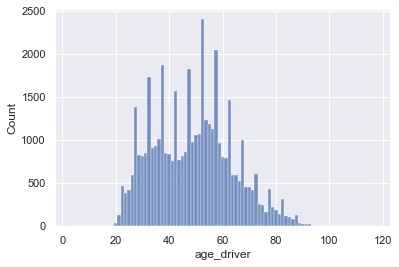

In [825]:
sns.histplot(x=df_total[var].dropna())
plt.show()

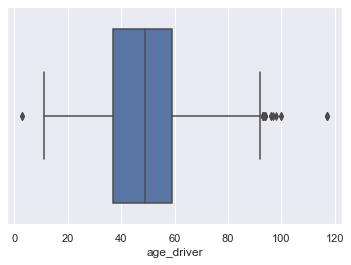

In [826]:
sns.boxplot(x=df_total[var].dropna())
plt.show()

In [827]:
df_total[df_total[var]<=18].shape

(12, 91)

In [828]:
df_total.loc[df_total[var]<=18,var].value_counts()

18.0    6
3.0     2
11.0    2
13.0    1
17.0    1
Name: age_driver, dtype: int64

In [829]:
df_total.loc[df_total[var]<=18,'fraud'].value_counts()

N    12
Name: fraud, dtype: int64

In [830]:
df_total[var].dropna().quantile([0, 0.05, .1, .25, .5, .75, 0.8, 0.85, 0.9, .95, 1])

0.00      3.0
0.05     27.0
0.10     30.0
0.25     37.0
0.50     49.0
0.75     59.0
0.80     62.0
0.85     65.0
0.90     69.0
0.95     75.0
1.00    117.0
Name: age_driver, dtype: float64

In [831]:
q_95 = df_total[var].quantile(.95)
print(q_95)

df_total[var] = np.where(df_total[var].isna(),np.nan,
                         np.where(df_total[var]<=18,18,
                                  np.where(df_total[var]>=int(q_95),int(q_95),df_total[var])))

75.0


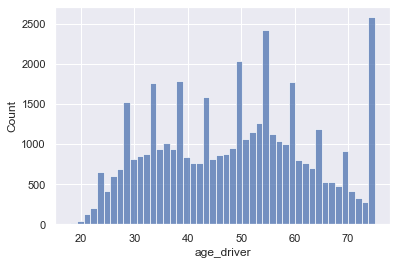

In [832]:
sns.histplot(x=df_total[var].dropna())
plt.show()

In [833]:
df_total[var] = np.where(df_total[var].isna(),-1,df_total[var])

In [834]:
data = woe(df_total,var)
data.sort_index().head(5)
#data

N   Y  total    porc_N  porc_Y  porc_total     woe
age_driver                                                        
-1.0        12289  71  12360   99.4256  0.5744     22.3028 -3.3225
 18.0          12   0     12  100.0000  0.0000      0.0217     inf
 19.0           6   0      6  100.0000  0.0000      0.0108     inf
 20.0          40   0     40  100.0000  0.0000      0.0722     inf
 21.0         129   0    129  100.0000  0.0000      0.2328     inf

In [835]:
df_total.set_index(var,inplace=True)

In [836]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55419, 92)


age_driver fraud  claim_amount  claim_date_registered  driver_year_birth  \
0        -1.0     N       1077.65               20171102                NaN   
1        -1.0     N       1224.24               20170213                NaN   
2        -1.0     N        424.00               20170202                NaN   
3        -1.0     N       1826.54               20170625                NaN   
4        -1.0     N       1282.61               20170303                NaN   

  driver_country driver_injured  third_party_1_postal_code  \
0              B              N                     1400.0   
1              B              N                     1070.0   
2              B              N                     1450.0   
3              B              N                     1160.0   
4              B              N                     1070.0   

  third_party_1_injured third_party_1_vehicle_type third_party_1_form  \
0                     N                        car                  C   
1                     N                        car                  C   
2                     N                        car                  F   
3                     N                        car                  M   
4                     N                        car                  F   

   third_party_1_year_birth third_party_1_country  third_party_2_postal_code  \
0                       NaN                     B                        NaN   
1                       NaN                     B                        NaN   
2                       NaN                     B                        NaN   
3                       NaN                     B                        NaN   
4                    1968.0                     B                        NaN   

  third_party_2_injured third_party_2_vehicle_type third_party_2_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_2_year_birth third_party_2_country  third_party_3_postal_code  \
0                       NaN                   NaN                        NaN   
1                       NaN                   NaN                        NaN   
2                       NaN                   NaN                        NaN   
3                       NaN                   NaN                        NaN   
4                       NaN                   NaN                        NaN   

  third_party_3_injured third_party_3_vehicle_type third_party_3_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_3_year_birth third_party_3_country  repair_postal_code  \
0                       NaN                   NaN                 NaN   
1                       NaN                   NaN                 NaN   
2                       NaN                   NaN              1420.0   
3                       NaN                   NaN              1050.0   
4                       NaN                   NaN              2100.0   

  repair_form  repair_year_birth repair_country repair_sla  policy_date_start  \
0         NaN                NaN            NaN          N                NaN   
1         NaN                NaN            NaN          N                NaN   
2           C                NaN              B          N                NaN   
3           C                NaN              B          N                NaN   
4           C                NaN

In [837]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
age_driver                                                     
-1.0           21691803.37       466778.98                23.12
 47.0           1714619.29        78773.97                 3.90
 31.0           1889856.84        75867.11                 3.76
 49.0           2002672.15        75023.63                 3.72
 59.0           2017000.64        64110.62                 3.17

In [838]:
### 

In [839]:
table.to_clipboard(index=True,header=True)

In [840]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [841]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [842]:
data[var].dtype

dtype('float64')

In [843]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [844]:
temp.index.dtype

dtype('float64')

In [845]:
dict_woe.update(temp.to_dict())

In [846]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [847]:
len(dict_woe)

25

In [848]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [849]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [850]:
columns_f = [col for col in data.columns if (var not in col)]+['woe_'+var]+[var]
print(len(columns_f))
print(data.shape)

data = data.reindex(columns=columns_f)

93
(55419, 93)


In [851]:
data[var] = np.where(data[var]==-1,np.nan,data[var])

In [852]:
data[var].isna().sum()

12360

In [853]:
#data.reset_index(drop=True,inplace=True)
data.drop(['woe','driver_year_birth'],axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 91)


fraud  claim_amount  claim_date_registered driver_country driver_injured  \
0     N       1077.65               20171102              B              N   
1     N       1224.24               20170213              B              N   
2     N        424.00               20170202              B              N   
3     N       1826.54               20170625              B              N   
4     N       1282.61               20170303              B              N   

   third_party_1_postal_code third_party_1_injured third_party_1_vehicle_type  \
0                     1400.0                     N                        car   
1                     1070.0                     N                        car   
2                     1450.0                     N                        car   
3                     1160.0                     N                        car   
4                     1070.0                     N                        car   

  third_party_1_form  third_party_1_year_birth third_party_1_country  \
0                  C                       NaN                     B   
1                  C                       NaN                     B   
2                  F                       NaN                     B   
3                  M                       NaN                     B   
4                  F                    1968.0                     B   

   third_party_2_postal_code third_party_2_injured third_party_2_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN                        NaN   

  third_party_2_form  third_party_2_year_birth third_party_2_country  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   third_party_3_postal_code third_party_3_injured third_party_3_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN                        NaN   

  third_party_3_form  third_party_3_year_birth third_party_3_country  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   repair_postal_code repair_form  repair_year_birth repair_country  \
0                 NaN         NaN                NaN            NaN   
1                 NaN         NaN                NaN            NaN   
2              1420.0           C                NaN              B   
3              1050.0           C                NaN              B   
4              2100.0           C                NaN              B   

  repair_sla  policy_date_start  policy_date_next_expiry  \
0          N                NaN                      NaN   
1          N                NaN                      NaN   
2          N                NaN                      NaN   
3          N                NaN                      NaN   
4          Y                NaN               

In [854]:
#############

In [855]:
var = 'driver_country'

In [856]:
len(df_total[var].unique())

2

In [857]:
df_total[var].unique()

array(['B', 'N'], dtype=object)

In [858]:
df_total[var].value_counts(normalize=True)

B    0.998737
N    0.001263
Name: driver_country, dtype: float64

In [859]:
data = woe(df_total,var)
#data.sort_index()
data

N    Y  total   porc_N  porc_Y  porc_total      woe
driver_country                                                         
N                  69    1     70  98.5714  1.4286      0.1263 -95.2898
B               55042  307  55349  99.4453  0.5547     99.8737   0.1999

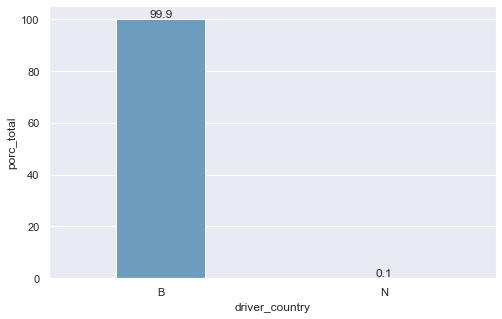

In [860]:
plt.figure(figsize=(8,5))

ax = sns.barplot(x=var, y='porc_total', 
                 data=data.reset_index().sort_values(by='porc_total',ascending=False),palette='Blues_d')
widthbars = [0.4, 0.4]

for p,newwidth in zip(ax.patches,widthbars):
    
    x = p.get_x()
    width = p.get_width()
    centre = x + width/2.
    p.set_x(centre - newwidth/2.)
    p.set_width(newwidth)
    
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), 
                   textcoords = 'offset points',
                   size=12)

plt.show()

In [861]:
df_total.set_index(var,inplace=True)

In [862]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55419, 92)


driver_country fraud  claim_amount  claim_date_registered driver_injured  \
0              B     N       1077.65               20171102              N   
1              B     N       1224.24               20170213              N   
2              B     N        424.00               20170202              N   
3              B     N       1826.54               20170625              N   
4              B     N       1282.61               20170303              N   

   third_party_1_postal_code third_party_1_injured third_party_1_vehicle_type  \
0                     1400.0                     N                        car   
1                     1070.0                     N                        car   
2                     1450.0                     N                        car   
3                     1160.0                     N                        car   
4                     1070.0                     N                        car   

  third_party_1_form  third_party_1_year_birth third_party_1_country  \
0                  C                       NaN                     B   
1                  C                       NaN                     B   
2                  F                       NaN                     B   
3                  M                       NaN                     B   
4                  F                    1968.0                     B   

   third_party_2_postal_code third_party_2_injured third_party_2_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN                        NaN   

  third_party_2_form  third_party_2_year_birth third_party_2_country  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   third_party_3_postal_code third_party_3_injured third_party_3_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN                        NaN   

  third_party_3_form  third_party_3_year_birth third_party_3_country  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   repair_postal_code repair_form  repair_year_birth repair_country  \
0                 NaN         NaN                NaN            NaN   
1                 NaN         NaN                NaN            NaN   
2              1420.0           C                NaN              B   
3              1050.0           C                NaN              B   
4              2100.0           C                NaN              B   

  repair_sla  policy_date_start  policy_date_next_expiry  \
0          N                NaN                      NaN   
1          N                NaN                      NaN   
2          N                NaN                      NaN   
3          N                NaN                      NaN   
4          Y                NaN               

In [863]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
driver_country                                                     
B                 1.147744e+08      2017230.40                 99.9
N                 1.551162e+05         2029.24                  0.1

In [864]:
### 

In [865]:
table.to_clipboard(index=True,header=True)

In [866]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [867]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [868]:
data[var].dtype

dtype('O')

In [869]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [870]:
temp.index.dtype

dtype('O')

In [871]:
dict_woe.update(temp.to_dict())

In [872]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [873]:
len(dict_woe)

26

In [874]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [875]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [876]:
data[var+'_cat'] = data[var].astype(str)

In [877]:
var+'_cat'

'driver_country_cat'

In [878]:
data[var+'_cat'].unique()

array(['B', 'N'], dtype=object)

In [879]:
dict_categ = {'driver_country_cat':['B','N']}

data = categorical(data,dict_categ)

In [880]:
# Get dummies
data = pd.get_dummies(data,
                      columns=data.columns[
                                           np.where(data.dtypes == 'category')
                                           ],
                      drop_first=True
                      )

In [881]:
#data.reset_index(drop=True,inplace=True)
data.drop(['woe',var],axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 92)


fraud  claim_amount  claim_date_registered driver_injured  \
0     N       1077.65               20171102              N   
1     N       1224.24               20170213              N   
2     N        424.00               20170202              N   
3     N       1826.54               20170625              N   
4     N       1282.61               20170303              N   

   third_party_1_postal_code third_party_1_injured third_party_1_vehicle_type  \
0                     1400.0                     N                        car   
1                     1070.0                     N                        car   
2                     1450.0                     N                        car   
3                     1160.0                     N                        car   
4                     1070.0                     N                        car   

  third_party_1_form  third_party_1_year_birth third_party_1_country  \
0                  C                       NaN                     B   
1                  C                       NaN                     B   
2                  F                       NaN                     B   
3                  M                       NaN                     B   
4                  F                    1968.0                     B   

   third_party_2_postal_code third_party_2_injured third_party_2_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN                        NaN   

  third_party_2_form  third_party_2_year_birth third_party_2_country  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   third_party_3_postal_code third_party_3_injured third_party_3_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN                        NaN   

  third_party_3_form  third_party_3_year_birth third_party_3_country  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   repair_postal_code repair_form  repair_year_birth repair_country  \
0                 NaN         NaN                NaN            NaN   
1                 NaN         NaN                NaN            NaN   
2              1420.0           C                NaN              B   
3              1050.0           C                NaN              B   
4              2100.0           C                NaN              B   

  repair_sla  policy_date_start  policy_date_next_expiry  \
0          N                NaN                      NaN   
1          N                NaN                      NaN   
2          N                NaN                      NaN   
3          N                NaN                      NaN   
4          Y                NaN                      NaN   

   policy_date_last_renewed  policy_num_changes  policy_num_claims  \
0    

In [882]:
#############

In [883]:
var = 'driver_injured'

In [884]:
len(df_total[var].unique())

2

In [885]:
df_total[var].unique()

array(['N', 'Y'], dtype=object)

In [886]:
df_total[var].value_counts(normalize=True)

N    0.988361
Y    0.011639
Name: driver_injured, dtype: float64

In [887]:
data = woe(df_total,var)
#data.sort_index()
data

N    Y  total   porc_N  porc_Y  porc_total       woe
driver_injured                                                          
N               54467  307  54774  99.4395  0.5605     98.8361   -0.8502
Y                 644    1    645  99.8450  0.1550      1.1639  128.0694

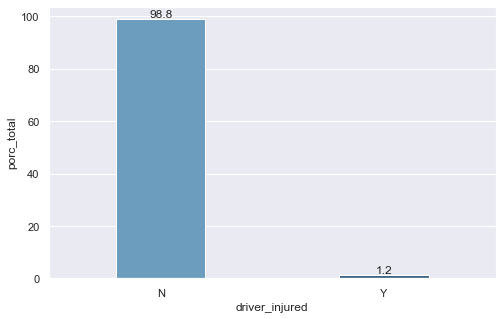

In [888]:
plt.figure(figsize=(8,5))

ax = sns.barplot(x=var, y='porc_total', 
                 data=data.reset_index().sort_values(by='porc_total',ascending=False),palette='Blues_d')
widthbars = [0.4, 0.4]

for p,newwidth in zip(ax.patches,widthbars):
    
    x = p.get_x()
    width = p.get_width()
    centre = x + width/2.
    p.set_x(centre - newwidth/2.)
    p.set_width(newwidth)
    
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), 
                   textcoords = 'offset points',
                   size=12)

plt.show()

In [889]:
df_total.set_index(var,inplace=True)

In [890]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55419, 93)


driver_injured fraud  claim_amount  claim_date_registered  \
0              N     N       1077.65               20171102   
1              N     N       1224.24               20170213   
2              N     N        424.00               20170202   
3              N     N       1826.54               20170625   
4              N     N       1282.61               20170303   

   third_party_1_postal_code third_party_1_injured third_party_1_vehicle_type  \
0                     1400.0                     N                        car   
1                     1070.0                     N                        car   
2                     1450.0                     N                        car   
3                     1160.0                     N                        car   
4                     1070.0                     N                        car   

  third_party_1_form  third_party_1_year_birth third_party_1_country  \
0                  C                       NaN                     B   
1                  C                       NaN                     B   
2                  F                       NaN                     B   
3                  M                       NaN                     B   
4                  F                    1968.0                     B   

   third_party_2_postal_code third_party_2_injured third_party_2_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN                        NaN   

  third_party_2_form  third_party_2_year_birth third_party_2_country  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   third_party_3_postal_code third_party_3_injured third_party_3_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN                        NaN   

  third_party_3_form  third_party_3_year_birth third_party_3_country  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   repair_postal_code repair_form  repair_year_birth repair_country  \
0                 NaN         NaN                NaN            NaN   
1                 NaN         NaN                NaN            NaN   
2              1420.0           C                NaN              B   
3              1050.0           C                NaN              B   
4              2100.0           C                NaN              B   

  repair_sla  policy_date_start  policy_date_next_expiry  \
0          N                NaN                      NaN   
1          N                NaN                      NaN   
2          N                NaN                      NaN   
3          N                NaN                      NaN   
4          Y                NaN                      NaN   

   policy_date_last_renewed  policy_num_changes  policy_num_claims  \
0    

In [891]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
driver_injured                                                     
N                 1.114674e+08      2016488.24                99.86
Y                 3.462124e+06         2771.40                 0.14

In [892]:
### 

In [893]:
table.to_clipboard(index=True,header=True)

In [894]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [895]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [896]:
data[var].dtype

dtype('O')

In [897]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [898]:
temp.index.dtype

dtype('O')

In [899]:
dict_woe.update(temp.to_dict())

In [900]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [901]:
len(dict_woe)

27

In [902]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [903]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [904]:
data[var+'_cat'] = data[var].astype(str)

In [905]:
var+'_cat'

'driver_injured_cat'

In [906]:
data[var+'_cat'].unique()

array(['N', 'Y'], dtype=object)

In [907]:
dict_categ = {'driver_injured_cat':['N','Y']}

data = categorical(data,dict_categ)

In [908]:
# Get dummies
data = pd.get_dummies(data,
                      columns=data.columns[
                                           np.where(data.dtypes == 'category')
                                           ],
                      drop_first=True
                      )

In [909]:
#data.reset_index(drop=True,inplace=True)
data.drop(['woe',var],axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 93)


fraud  claim_amount  claim_date_registered  third_party_1_postal_code  \
0     N       1077.65               20171102                     1400.0   
1     N       1224.24               20170213                     1070.0   
2     N        424.00               20170202                     1450.0   
3     N       1826.54               20170625                     1160.0   
4     N       1282.61               20170303                     1070.0   

  third_party_1_injured third_party_1_vehicle_type third_party_1_form  \
0                     N                        car                  C   
1                     N                        car                  C   
2                     N                        car                  F   
3                     N                        car                  M   
4                     N                        car                  F   

   third_party_1_year_birth third_party_1_country  third_party_2_postal_code  \
0                       NaN                     B                        NaN   
1                       NaN                     B                        NaN   
2                       NaN                     B                        NaN   
3                       NaN                     B                        NaN   
4                    1968.0                     B                        NaN   

  third_party_2_injured third_party_2_vehicle_type third_party_2_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_2_year_birth third_party_2_country  third_party_3_postal_code  \
0                       NaN                   NaN                        NaN   
1                       NaN                   NaN                        NaN   
2                       NaN                   NaN                        NaN   
3                       NaN                   NaN                        NaN   
4                       NaN                   NaN                        NaN   

  third_party_3_injured third_party_3_vehicle_type third_party_3_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_3_year_birth third_party_3_country  repair_postal_code  \
0                       NaN                   NaN                 NaN   
1                       NaN                   NaN                 NaN   
2                       NaN                   NaN              1420.0   
3                       NaN                   NaN              1050.0   
4                       NaN                   NaN              2100.0   

  repair_form  repair_year_birth repair_country repair_sla  policy_date_start  \
0         NaN                NaN            NaN          N                NaN   
1         NaN                NaN            NaN          N                NaN   
2           C                NaN              B          N                NaN   
3           C                NaN              B          N                NaN   
4           C                NaN              B          Y                NaN   

   policy_date_next_expiry  policy_date_last_renewed  policy_num_changes  \
0                      NaN                       NaN                   0   
1                      NaN                       NaN                   0   
2                      NaN                       NaN                   0   
3                      NaN                

In [910]:
#############

In [911]:
var = 'third_party_1_postal_code'

In [912]:
len(df_total[var].unique())

1088

In [913]:
df_total[var].isna().sum()

14835

In [914]:
df_total.loc[df_total[var].isna(),'fraud'].value_counts()

N    14654
Y      181
Name: fraud, dtype: int64

In [915]:
df_total[var] = np.where(df_total[var].isna(),'missing',df_total[var])

In [916]:
data = woe(df_total,var)

print(data.shape)
data.head()

(1088, 7)


N  Y  total   porc_N   porc_Y  porc_total  \
third_party_1_postal_code                                               
8956.0                      2  1      3  66.6667  33.3333      0.0054   
6511.0                      2  1      3  66.6667  33.3333      0.0054   
7784.0                     22  2     24  91.6667   8.3333      0.0433   
3400.0                     23  2     25  92.0000   8.0000      0.0451   
4250.0                     12  1     13  92.3077   7.6923      0.0235   

                                woe  
third_party_1_postal_code            
8956.0                    -449.3858  
6511.0                    -449.3858  
7784.0                    -278.9110  
3400.0                    -274.4658  
4250.0                    -270.2098

In [917]:
print(data[data['woe']==np.inf].shape[0])
print(data[data['woe']==-np.inf].shape[0])

977
0


In [918]:
data.to_clipboard(index=True,header=True)

In [919]:
df_total.set_index(var,inplace=True)

In [920]:
data = df_total.join(data[['woe']])
data.reset_index(inplace=True)
print(data.shape)
data.head()

(55419, 94)


third_party_1_postal_code fraud  claim_amount  claim_date_registered  \
0                    1000.0     N       1380.48               20170213   
1                    1000.0     N       1122.76               20170803   
2                    1000.0     N       4023.20               20171201   
3                    1000.0     N       1195.83               20170309   
4                    1000.0     N       1071.95               20170727   

  third_party_1_injured third_party_1_vehicle_type third_party_1_form  \
0                     N                        car                  C   
1                     N                        NaN                  M   
2                     N                        van                  M   
3                     N                        NaN                  C   
4                     N                        car                  C   

   third_party_1_year_birth third_party_1_country  third_party_2_postal_code  \
0                       NaN                     B                        NaN   
1                       NaN                     B                        NaN   
2                    1947.0                     B                        NaN   
3                       NaN                     B                        NaN   
4                       NaN                     B                        NaN   

  third_party_2_injured third_party_2_vehicle_type third_party_2_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_2_year_birth third_party_2_country  third_party_3_postal_code  \
0                       NaN                   NaN                        NaN   
1                       NaN                   NaN                        NaN   
2                       NaN                   NaN                        NaN   
3                       NaN                   NaN                        NaN   
4                       NaN                   NaN                        NaN   

  third_party_3_injured third_party_3_vehicle_type third_party_3_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_3_year_birth third_party_3_country  repair_postal_code  \
0                       NaN                   NaN                 NaN   
1                       NaN                   NaN                 NaN   
2                       NaN                   NaN                 NaN   
3                       NaN                   NaN                 NaN   
4                       NaN                   NaN                 NaN   

  repair_form  repair_year_birth repair_country repair_sla  policy_date_start  \
0         NaN                NaN            NaN          N                NaN   
1         NaN                NaN            NaN          N                NaN   
2         NaN                NaN            NaN          N                NaN   
3         NaN                NaN            NaN          N                NaN   
4         NaN                NaN            NaN          N                NaN   

   policy_date_next_expiry  policy_date_last_renewed  policy_num_changes  \
0                      NaN                       NaN                   0   
1                      NaN                       NaN                   0   
2                      NaN                       NaN                   0   
3                      NaN                      

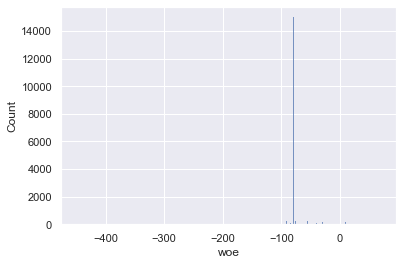

In [921]:
sns.histplot(x=data.loc[(data['woe']!=np.inf) &
                        (data['woe']!=-np.inf),'woe'])
plt.show()

In [922]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
third_party_1_postal_code                                                     
missing                       29937954.10      1504337.96                74.50
3510.0                           35637.64        16859.00                 0.83
9080.0                          208847.11        16464.00                 0.82
4280.0                           57562.57        16402.00                 0.81
6041.0                           31649.41        16006.00                 0.79

In [923]:
### take into account the postal code 'missing' has the highest percentage of participation of the amount of 
### fraud claims (74.5%)

In [924]:
table.to_clipboard(index=True,header=True)

In [925]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

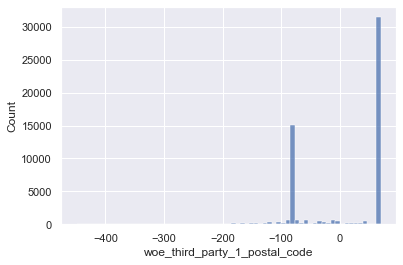

In [926]:
sns.histplot(x=data['woe_'+var])
plt.show()

In [927]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [928]:
data[var].dtype

dtype('O')

In [929]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [930]:
temp.index.dtype

dtype('O')

In [931]:
dict_woe.update(temp.to_dict())

In [932]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [933]:
len(dict_woe)

28

In [934]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [935]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

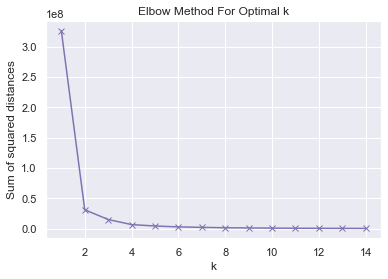

In [936]:
tabla=pd.DataFrame({'woe':data['woe_'+var]})

SEED = 123

#Número de cluster óptimo
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=SEED)
    km = km.fit(tabla)
    sum_of_squared_distances.append(km.inertia_)
#     centroids = km.cluster_centers_
#     print(centroids)

plt.plot(K, sum_of_squared_distances, 'mx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [937]:
km = KMeans(n_clusters=3, random_state=SEED)
km = km.fit(tabla)
km.cluster_centers_
km.labels_

array([0, 0, 0, ..., 1, 1, 1])

In [938]:
breaks = jenkspy.jenks_breaks(data['woe_'+var], nb_class=3)
breaks

[-449.3858, -129.5185, -6.6021, 70.1873]

In [939]:
dict_woe_breaks.update({var:breaks})

In [940]:
with open(path+'dict_woe_train_breaks.json', 'w') as fp:
    json.dump(dict_woe_breaks, fp)

In [941]:
data['woe_'+var+'_cat'] = pd.cut(data['woe_'+var],
                                 bins=breaks,
                                 labels=['high_fraud', 'medium_fraud', 'low_fraud'],
                                 include_lowest=True)

data['woe_'+var+'_cat'].value_counts(normalize=True)

low_fraud       0.594273
medium_fraud    0.376116
high_fraud      0.029611
Name: woe_third_party_1_postal_code_cat, dtype: float64

In [942]:
data['woe_'+var+'_cat'].value_counts(normalize=False)

low_fraud       32934
medium_fraud    20844
high_fraud       1641
Name: woe_third_party_1_postal_code_cat, dtype: int64

In [943]:
'woe_'+var+'_cat'

'woe_third_party_1_postal_code_cat'

In [944]:
dict_categ = {'woe_third_party_1_postal_code_cat':['low_fraud','medium_fraud','high_fraud']}

data = categorical(data,dict_categ)

In [945]:
# Get dummies
# data = pd.get_dummies(data,
#                       columns=data.columns[
#                                            np.where(data.dtypes == 'category')
#                                            ],
#                       drop_first=True
#                       )

In [946]:
data.drop(['woe',var,'woe_'+var+'_cat'],axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 93)


fraud  claim_amount  claim_date_registered third_party_1_injured  \
0     N       1380.48               20170213                     N   
1     N       1122.76               20170803                     N   
2     N       4023.20               20171201                     N   
3     N       1195.83               20170309                     N   
4     N       1071.95               20170727                     N   

  third_party_1_vehicle_type third_party_1_form  third_party_1_year_birth  \
0                        car                  C                       NaN   
1                        NaN                  M                       NaN   
2                        van                  M                    1947.0   
3                        NaN                  C                       NaN   
4                        car                  C                       NaN   

  third_party_1_country  third_party_2_postal_code third_party_2_injured  \
0                     B                        NaN                   NaN   
1                     B                        NaN                   NaN   
2                     B                        NaN                   NaN   
3                     B                        NaN                   NaN   
4                     B                        NaN                   NaN   

  third_party_2_vehicle_type third_party_2_form  third_party_2_year_birth  \
0                        NaN                NaN                       NaN   
1                        NaN                NaN                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        NaN                NaN                       NaN   

  third_party_2_country  third_party_3_postal_code third_party_3_injured  \
0                   NaN                        NaN                   NaN   
1                   NaN                        NaN                   NaN   
2                   NaN                        NaN                   NaN   
3                   NaN                        NaN                   NaN   
4                   NaN                        NaN                   NaN   

  third_party_3_vehicle_type third_party_3_form  third_party_3_year_birth  \
0                        NaN                NaN                       NaN   
1                        NaN                NaN                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        NaN                NaN                       NaN   

  third_party_3_country  repair_postal_code repair_form  repair_year_birth  \
0                   NaN                 NaN         NaN                NaN   
1                   NaN                 NaN         NaN                NaN   
2                   NaN                 NaN         NaN                NaN   
3                   NaN                 NaN         NaN                NaN   
4                   NaN                 NaN         NaN                NaN   

  repair_country repair_sla  policy_date_start  policy_date_next_expiry  \
0            NaN          N                NaN                      NaN   
1            NaN          N                NaN                      NaN   
2            NaN          N                NaN                      NaN   
3            NaN          N                NaN                      NaN   
4            NaN          N                NaN                      NaN   

   policy_date_last_renewed  policy_num_changes  policy_num_claims  \
0                       NaN                   0                  1   
1                       NaN                   0                  0   
2                       NaN                   0                  0   
3                       NaN                   0                  3   
4       

In [947]:
#############

In [948]:
var = 'third_party_1_injured'

In [949]:
len(df_total[var].unique())

3

In [950]:
df_total[var].unique()

array(['N', 'Y', nan], dtype=object)

In [951]:
df_total[var].fillna('missing').value_counts(normalize=True)

N          0.717678
missing    0.247785
Y          0.034537
Name: third_party_1_injured, dtype: float64

In [952]:
df_total[var] = np.where(df_total[var].isna(),'missing',df_total[var])

In [953]:
data = woe(df_total,var)
#data.sort_index()
data

N    Y  total   porc_N  porc_Y  porc_total      woe
third_party_1_injured                                                         
missing                13554  178  13732  98.7038  1.2962     24.7785 -85.4351
N                      39647  126  39773  99.6832  0.3168     71.7678  56.4484
Y                       1910    4   1914  99.7910  0.2090      3.4537  98.1559

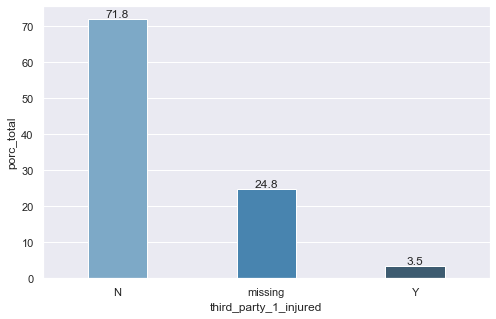

In [954]:
plt.figure(figsize=(8,5))

ax = sns.barplot(x=var, y='porc_total', 
                 data=data.reset_index().sort_values(by='porc_total',ascending=False),palette='Blues_d')
widthbars = [0.4, 0.4, 0.4]

for p,newwidth in zip(ax.patches,widthbars):
    
    x = p.get_x()
    width = p.get_width()
    centre = x + width/2.
    p.set_x(centre - newwidth/2.)
    p.set_width(newwidth)
    
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), 
                   textcoords = 'offset points',
                   size=12)

plt.show()

In [955]:
df_total.set_index(var,inplace=True)

In [956]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55419, 94)


third_party_1_injured fraud  claim_amount  claim_date_registered  \
0                     N     N       1380.48               20170213   
1                     N     N       1122.76               20170803   
2                     N     N       4023.20               20171201   
3                     N     N       1195.83               20170309   
4                     N     N       1071.95               20170727   

  third_party_1_vehicle_type third_party_1_form  third_party_1_year_birth  \
0                        car                  C                       NaN   
1                        NaN                  M                       NaN   
2                        van                  M                    1947.0   
3                        NaN                  C                       NaN   
4                        car                  C                       NaN   

  third_party_1_country  third_party_2_postal_code third_party_2_injured  \
0                     B                        NaN                   NaN   
1                     B                        NaN                   NaN   
2                     B                        NaN                   NaN   
3                     B                        NaN                   NaN   
4                     B                        NaN                   NaN   

  third_party_2_vehicle_type third_party_2_form  third_party_2_year_birth  \
0                        NaN                NaN                       NaN   
1                        NaN                NaN                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        NaN                NaN                       NaN   

  third_party_2_country  third_party_3_postal_code third_party_3_injured  \
0                   NaN                        NaN                   NaN   
1                   NaN                        NaN                   NaN   
2                   NaN                        NaN                   NaN   
3                   NaN                        NaN                   NaN   
4                   NaN                        NaN                   NaN   

  third_party_3_vehicle_type third_party_3_form  third_party_3_year_birth  \
0                        NaN                NaN                       NaN   
1                        NaN                NaN                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        NaN                NaN                       NaN   

  third_party_3_country  repair_postal_code repair_form  repair_year_birth  \
0                   NaN                 NaN         NaN                NaN   
1                   NaN                 NaN         NaN                NaN   
2                   NaN                 NaN         NaN                NaN   
3                   NaN                 NaN         NaN                NaN   
4                   NaN                 NaN         NaN                NaN   

  repair_country repair_sla  policy_date_start  policy_date_next_expiry  \
0            NaN          N                NaN                      NaN   
1            NaN          N                NaN                      NaN   
2            NaN          N                NaN                      NaN   
3            NaN          N                NaN                      NaN   
4            NaN          N                NaN                      NaN   

   policy_date_last_renewed  policy_num_changes  policy_num_claims  \
0                       NaN                   0                  1   
1                       NaN                   0                  0   
2                       NaN                   0                  0   
3                       NaN                   0                  3   
4       

In [957]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
third_party_1_injured                                                     
missing                  2.795126e+07      1484528.51                73.52
N                        7.344928e+07       485295.08                24.03
Y                        1.352895e+07        49436.05                 2.45

In [958]:
### 

In [959]:
table.to_clipboard(index=True,header=True)

In [960]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [961]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [962]:
data[var].dtype

dtype('O')

In [963]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [964]:
temp.index.dtype

dtype('O')

In [965]:
dict_woe.update(temp.to_dict())

In [966]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [967]:
len(dict_woe)

29

In [968]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [969]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [970]:
data[var+'_cat'] = data[var].astype(str)

In [971]:
var+'_cat'

'third_party_1_injured_cat'

In [972]:
data[var+'_cat'].unique()

array(['N', 'Y', 'missing'], dtype=object)

In [973]:
dict_categ = {'third_party_1_injured_cat':['Y','N','missing']}

data = categorical(data,dict_categ)

In [974]:
# Get dummies
data = pd.get_dummies(data,
                      columns=data.columns[
                                           np.where(data.dtypes == 'category')
                                           ],
                      drop_first=True
                      )

In [975]:
#data.reset_index(drop=True,inplace=True)
data.drop(['woe',var],axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 95)


fraud  claim_amount  claim_date_registered third_party_1_vehicle_type  \
0     N       1380.48               20170213                        car   
1     N       1122.76               20170803                        NaN   
2     N       4023.20               20171201                        van   
3     N       1195.83               20170309                        NaN   
4     N       1071.95               20170727                        car   

  third_party_1_form  third_party_1_year_birth third_party_1_country  \
0                  C                       NaN                     B   
1                  M                       NaN                     B   
2                  M                    1947.0                     B   
3                  C                       NaN                     B   
4                  C                       NaN                     B   

   third_party_2_postal_code third_party_2_injured third_party_2_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN                        NaN   

  third_party_2_form  third_party_2_year_birth third_party_2_country  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   third_party_3_postal_code third_party_3_injured third_party_3_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN                        NaN   

  third_party_3_form  third_party_3_year_birth third_party_3_country  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   repair_postal_code repair_form  repair_year_birth repair_country  \
0                 NaN         NaN                NaN            NaN   
1                 NaN         NaN                NaN            NaN   
2                 NaN         NaN                NaN            NaN   
3                 NaN         NaN                NaN            NaN   
4                 NaN         NaN                NaN            NaN   

  repair_sla  policy_date_start  policy_date_next_expiry  \
0          N                NaN                      NaN   
1          N                NaN                      NaN   
2          N                NaN                      NaN   
3          N                NaN                      NaN   
4          N                NaN                      NaN   

   policy_date_last_renewed  policy_num_changes  policy_num_claims  \
0                       NaN                   0                  1   
1                       NaN                   0                  0   
2                       NaN                   0                  0   
3                       NaN                   0                  3   
4                       NaN                   0                  1   

   policy_premium_100  policy_coverage_1000 policy_coverage_type  \
0

In [976]:
#############

In [977]:
var = 'third_party_1_vehicle_type'

In [978]:
len(df_total[var].unique())

9

In [979]:
df_total[var].unique()

array(['car', nan, 'van', 'bus', 'other', 'building', 'truck',
       'motorbike', 'bike'], dtype=object)

In [980]:
df_total[var] = np.where(df_total[var].isna(),'missing',df_total[var])

In [981]:
df_total[var].value_counts(normalize=True)

car          0.635107
missing      0.289251
other        0.027103
truck        0.014832
bike         0.011891
motorbike    0.009997
bus          0.004692
building     0.004529
van          0.002598
Name: third_party_1_vehicle_type, dtype: float64

In [982]:
data = woe(df_total,var)
#data.sort_index()
data

N    Y  total    porc_N  porc_Y  porc_total  \
third_party_1_vehicle_type                                                    
building                      246    5    251   98.0080  1.9920      0.4529   
motorbike                     547    7    554   98.7365  1.2635      0.9997   
missing                     15837  193  16030   98.7960  1.2040     28.9251   
other                        1491   11   1502   99.2676  0.7324      2.7103   
van                           143    1    144   99.3056  0.6944      0.2598   
car                         35106   91  35197   99.7415  0.2585     63.5107   
bike                          659    0    659  100.0000  0.0000      1.1891   
bus                           260    0    260  100.0000  0.0000      0.4692   
truck                         822    0    822  100.0000  0.0000      1.4832   

                                 woe  
third_party_1_vehicle_type            
building                   -129.1111  
motorbike                   -82.8466  
missing                     -77.9591  
other                       -27.7698  
van                         -22.4160  
car                          76.8263  
bike                             inf  
bus                              inf  
truck                            inf

In [983]:
data.to_clipboard(index=True,header=True)

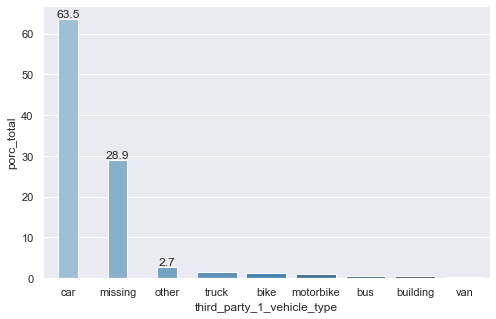

In [984]:
plt.figure(figsize=(8,5))

ax = sns.barplot(x=var, y='porc_total', 
                 data=data.reset_index().sort_values(by='porc_total',ascending=False),palette='Blues_d')
widthbars = [0.4, 0.4, 0.4]

for p,newwidth in zip(ax.patches,widthbars):
    
    x = p.get_x()
    width = p.get_width()
    centre = x + width/2.
    p.set_x(centre - newwidth/2.)
    p.set_width(newwidth)
    
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), 
                   textcoords = 'offset points',
                   size=12)

plt.show()

In [985]:
df_total.set_index(var,inplace=True)

In [986]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55419, 96)


third_party_1_vehicle_type fraud  claim_amount  claim_date_registered  \
0                       bike     N        964.39               20171209   
1                       bike     N        946.91               20170805   
2                       bike     N        843.14               20170803   
3                       bike     N        678.28               20171110   
4                       bike     N       1154.41               20170302   

  third_party_1_form  third_party_1_year_birth third_party_1_country  \
0                  M                       NaN                     B   
1                  M                       NaN                     B   
2                  M                       NaN                     B   
3                  C                       NaN                     B   
4                  C                       NaN                     B   

   third_party_2_postal_code third_party_2_injured third_party_2_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                     5000.0                     N                        NaN   

  third_party_2_form  third_party_2_year_birth third_party_2_country  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                  L                       NaN                     B   

   third_party_3_postal_code third_party_3_injured third_party_3_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN                        NaN   

  third_party_3_form  third_party_3_year_birth third_party_3_country  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   repair_postal_code repair_form  repair_year_birth repair_country  \
0                 NaN         NaN                NaN            NaN   
1                 NaN         NaN                NaN            NaN   
2                 NaN         NaN                NaN            NaN   
3                 NaN         NaN                NaN            NaN   
4                 NaN         NaN                NaN            NaN   

  repair_sla  policy_date_start  policy_date_next_expiry  \
0          N           201011.0                 201803.0   
1          N           195201.0                 201710.0   
2          N                NaN                      NaN   
3          N           201304.0                 201804.0   
4          N           201307.0                 201707.0   

   policy_date_last_renewed  policy_num_changes  policy_num_claims  \
0                  201803.0                   2                  4   
1                  201710.0                   0                  2   
2                       NaN                   0                  0   
3                  201804.0                   0                  2   
4                  201707.0                   3                  1   

   policy_premium_100  policy_coverage_1000 policy_coverage_type  \
0

In [987]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  \
third_party_1_vehicle_type                                   
missing                        34784627.37      1567202.20   
car                            67933153.85       281848.49   
other                           3249612.45        98182.25   
building                         630209.70        43276.78   
motorbike                       2128804.82        27118.92   

                            porc_Y_claim_amount  
third_party_1_vehicle_type                       
missing                                   77.61  
car                                       13.96  
other                                      4.86  
building                                   2.14  
motorbike                                  1.34

In [988]:
### the 77% of the amount of fraud claims is when the type of vehicle is 'missing'

In [989]:
table.to_clipboard(index=True,header=True)

In [990]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [991]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [992]:
data[var].dtype

dtype('O')

In [993]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [994]:
temp.index.dtype

dtype('O')

In [995]:
dict_woe.update(temp.to_dict())

In [996]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [997]:
len(dict_woe)

30

In [998]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [999]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [1000]:
data[var+'_cat'] = data[var]

In [1001]:
data[var+'_cat'] = np.where(data[var+'_cat'].isin(['missing']),'missing',
                                   np.where(data[var+'_cat'].isin(['car']),'car','other'))

In [1002]:
data[var+'_cat'].value_counts(normalize=True)

car        0.635107
missing    0.289251
other      0.075642
Name: third_party_1_vehicle_type_cat, dtype: float64

In [1003]:
var+'_cat'

'third_party_1_vehicle_type_cat'

In [1004]:
dict_categ = {'third_party_1_vehicle_type_cat':['other','car','missing']}

data = categorical(data,dict_categ)

In [1005]:
# Get dummies
data = pd.get_dummies(data,
                      columns=data.columns[
                                           np.where(data.dtypes == 'category')
                                           ],
                      drop_first=True
                      )

In [1006]:
data.drop(['woe',var],axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 97)


fraud  claim_amount  claim_date_registered third_party_1_form  \
0     N        964.39               20171209                  M   
1     N        946.91               20170805                  M   
2     N        843.14               20170803                  M   
3     N        678.28               20171110                  C   
4     N       1154.41               20170302                  C   

   third_party_1_year_birth third_party_1_country  third_party_2_postal_code  \
0                       NaN                     B                        NaN   
1                       NaN                     B                        NaN   
2                       NaN                     B                        NaN   
3                       NaN                     B                        NaN   
4                       NaN                     B                     5000.0   

  third_party_2_injured third_party_2_vehicle_type third_party_2_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                     N                        NaN                  L   

   third_party_2_year_birth third_party_2_country  third_party_3_postal_code  \
0                       NaN                   NaN                        NaN   
1                       NaN                   NaN                        NaN   
2                       NaN                   NaN                        NaN   
3                       NaN                   NaN                        NaN   
4                       NaN                     B                        NaN   

  third_party_3_injured third_party_3_vehicle_type third_party_3_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_3_year_birth third_party_3_country  repair_postal_code  \
0                       NaN                   NaN                 NaN   
1                       NaN                   NaN                 NaN   
2                       NaN                   NaN                 NaN   
3                       NaN                   NaN                 NaN   
4                       NaN                   NaN                 NaN   

  repair_form  repair_year_birth repair_country repair_sla  policy_date_start  \
0         NaN                NaN            NaN          N           201011.0   
1         NaN                NaN            NaN          N           195201.0   
2         NaN                NaN            NaN          N                NaN   
3         NaN                NaN            NaN          N           201304.0   
4         NaN                NaN            NaN          N           201307.0   

   policy_date_next_expiry  policy_date_last_renewed  policy_num_changes  \
0                 201803.0                  201803.0                   2   
1                 201710.0                  201710.0                   0   
2                      NaN                       NaN                   0   
3                 201804.0                  201804.0                   0   
4                 201707.0                  201707.0                   3   

   policy_num_claims  policy_premium_100  policy_coverage_1000  \
0                  4                 8.0                  15.0   
1                  2                 5.0                   NaN   
2                  0                 NaN                   NaN   
3                  2                 3.0                   NaN   
4                  1                 7.0      

In [1007]:
#############

In [1008]:
var = 'third_party_1_form'

In [1009]:
len(df_total[var].unique())

4

In [1010]:
df_total[var].unique()

array(['M', 'C', 'F', nan], dtype=object)

In [1011]:
df_total[var].fillna('missing').value_counts(normalize=True)

M          0.302496
C          0.295603
missing    0.247785
F          0.154117
Name: third_party_1_form, dtype: float64

In [1012]:
df_total[var] = np.where(df_total[var].isna(),'missing',df_total[var])

In [1013]:
data = woe(df_total,var)
#data.sort_index()
data

N    Y  total   porc_N  porc_Y  porc_total      woe
third_party_1_form                                                         
missing             13554  178  13732  98.7038  1.2962     24.7785 -85.4351
M                   16695   69  16764  99.5884  0.4116     30.2496  30.1753
F                    8517   24   8541  99.7190  0.2810     15.4117  68.4761
C                   16345   37  16382  99.7741  0.2259     29.5603  90.3755

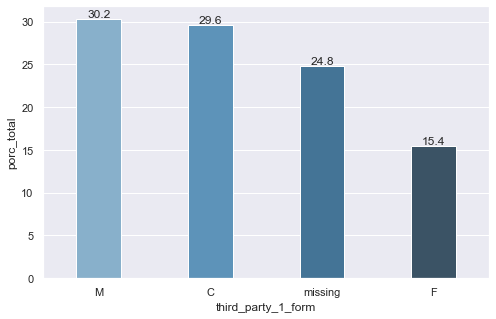

In [1014]:
plt.figure(figsize=(8,5))

ax = sns.barplot(x=var, y='porc_total', 
                 data=data.reset_index().sort_values(by='porc_total',ascending=False),palette='Blues_d')
widthbars = [0.4, 0.4, 0.4, 0.4]

for p,newwidth in zip(ax.patches,widthbars):
    
    x = p.get_x()
    width = p.get_width()
    centre = x + width/2.
    p.set_x(centre - newwidth/2.)
    p.set_width(newwidth)
    
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), 
                   textcoords = 'offset points',
                   size=12)

plt.show()

In [1015]:
df_total.set_index(var,inplace=True)

In [1016]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55419, 98)


third_party_1_form fraud  claim_amount  claim_date_registered  \
0                  C     N        678.28               20171110   
1                  C     N       1154.41               20170302   
2                  C     N        615.99               20171014   
3                  C     N        826.33               20170703   
4                  C     N       2391.07               20170724   

   third_party_1_year_birth third_party_1_country  third_party_2_postal_code  \
0                       NaN                     B                        NaN   
1                       NaN                     B                     5000.0   
2                       NaN                     B                        NaN   
3                       NaN                     B                        NaN   
4                       NaN                     B                        NaN   

  third_party_2_injured third_party_2_vehicle_type third_party_2_form  \
0                   NaN                        NaN                NaN   
1                     N                        NaN                  L   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_2_year_birth third_party_2_country  third_party_3_postal_code  \
0                       NaN                   NaN                        NaN   
1                       NaN                     B                        NaN   
2                       NaN                   NaN                        NaN   
3                       NaN                   NaN                        NaN   
4                       NaN                   NaN                        NaN   

  third_party_3_injured third_party_3_vehicle_type third_party_3_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_3_year_birth third_party_3_country  repair_postal_code  \
0                       NaN                   NaN                 NaN   
1                       NaN                   NaN                 NaN   
2                       NaN                   NaN                 NaN   
3                       NaN                   NaN                 NaN   
4                       NaN                   NaN              1840.0   

  repair_form  repair_year_birth repair_country repair_sla  policy_date_start  \
0         NaN                NaN            NaN          N           201304.0   
1         NaN                NaN            NaN          N           201307.0   
2         NaN                NaN            NaN          N           201703.0   
3         NaN                NaN            NaN          N                NaN   
4           C                NaN              B          N           200503.0   

   policy_date_next_expiry  policy_date_last_renewed  policy_num_changes  \
0                 201804.0                  201804.0                   0   
1                 201707.0                  201707.0                   3   
2                 201803.0                  201803.0                   2   
3                      NaN                       NaN                   0   
4                 201803.0                  201803.0                   2   

   policy_num_claims  policy_premium_100  policy_coverage_1000  \
0                  2                 3.0                   NaN   
1                  1                 7.0                  14.0   
2                  0                 4.0                   NaN   
3                  0                 NaN                   NaN   
4                  1                 9.0      

In [1017]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
third_party_1_form                                                     
missing                27951259.74      1484528.51                73.52
M                      38076806.65       255823.39                12.67
C                      28021706.52       175233.41                 8.68
F                      20879715.73       103674.33                 5.13

In [1018]:
### 

In [1019]:
table.to_clipboard(index=True,header=True)

In [1020]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [1021]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [1022]:
data[var].dtype

dtype('O')

In [1023]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [1024]:
temp.index.dtype

dtype('O')

In [1025]:
dict_woe.update(temp.to_dict())

In [1026]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [1027]:
len(dict_woe)

31

In [1028]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [1029]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [1030]:
data[var+'_cat'] = data[var].astype(str)

In [1031]:
data[var+'_cat'].value_counts(normalize=True)

M          0.302496
C          0.295603
missing    0.247785
F          0.154117
Name: third_party_1_form_cat, dtype: float64

In [1032]:
var+'_cat'

'third_party_1_form_cat'

In [1033]:
dict_categ = {'third_party_1_form_cat':['C','missing','F','M']}

data = categorical(data,dict_categ)

In [1034]:
# Get dummies
data = pd.get_dummies(data,
                      columns=data.columns[
                                           np.where(data.dtypes == 'category')
                                           ],
                      drop_first=True
                      )

In [1035]:
#data.reset_index(drop=True,inplace=True)
data.drop(['woe',var],axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 100)


fraud  claim_amount  claim_date_registered  third_party_1_year_birth  \
0     N        678.28               20171110                       NaN   
1     N       1154.41               20170302                       NaN   
2     N        615.99               20171014                       NaN   
3     N        826.33               20170703                       NaN   
4     N       2391.07               20170724                       NaN   

  third_party_1_country  third_party_2_postal_code third_party_2_injured  \
0                     B                        NaN                   NaN   
1                     B                     5000.0                     N   
2                     B                        NaN                   NaN   
3                     B                        NaN                   NaN   
4                     B                        NaN                   NaN   

  third_party_2_vehicle_type third_party_2_form  third_party_2_year_birth  \
0                        NaN                NaN                       NaN   
1                        NaN                  L                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        NaN                NaN                       NaN   

  third_party_2_country  third_party_3_postal_code third_party_3_injured  \
0                   NaN                        NaN                   NaN   
1                     B                        NaN                   NaN   
2                   NaN                        NaN                   NaN   
3                   NaN                        NaN                   NaN   
4                   NaN                        NaN                   NaN   

  third_party_3_vehicle_type third_party_3_form  third_party_3_year_birth  \
0                        NaN                NaN                       NaN   
1                        NaN                NaN                       NaN   
2                        NaN                NaN                       NaN   
3                        NaN                NaN                       NaN   
4                        NaN                NaN                       NaN   

  third_party_3_country  repair_postal_code repair_form  repair_year_birth  \
0                   NaN                 NaN         NaN                NaN   
1                   NaN                 NaN         NaN                NaN   
2                   NaN                 NaN         NaN                NaN   
3                   NaN                 NaN         NaN                NaN   
4                   NaN              1840.0           C                NaN   

  repair_country repair_sla  policy_date_start  policy_date_next_expiry  \
0            NaN          N           201304.0                 201804.0   
1            NaN          N           201307.0                 201707.0   
2            NaN          N           201703.0                 201803.0   
3            NaN          N                NaN                      NaN   
4              B          N           200503.0                 201803.0   

   policy_date_last_renewed  policy_num_changes  policy_num_claims  \
0                  201804.0                   0                  2   
1                  201707.0                   3                  1   
2                  201803.0                   2                  0   
3                       NaN                   0                  0   
4                  201803.0                   2                  1   

   policy_premium_100  policy_coverage_1000 policy_coverage_type  \
0                 3.0                   NaN           #000110000   
1                 7.0                  14.0           #110110011   
2                 4.0                   NaN           #000110001   
3                 NaN                   NaN           #000000000   
4                 9.0               

In [1036]:
#############

In [1037]:
var = 'third_party_1_year_birth'

In [1038]:
print(df_total[var].isna().sum())
print(df_total[var].isna().sum()/df_total.shape[0])

45553
0.821974413107418


In [1039]:
print(df_total[var].min())
print(df_total[var].max())

1900.0
2015.0


In [1040]:
df_total[var].value_counts().sort_index().head(10)

1900.0    1
1913.0    1
1914.0    1
1917.0    1
1920.0    1
1921.0    1
1923.0    4
1924.0    7
1925.0    4
1926.0    8
Name: third_party_1_year_birth, dtype: int64

In [1041]:
df_total.drop(var,axis=1,inplace=True)

In [1042]:
#############

In [1043]:
var = 'third_party_1_country'

In [1044]:
len(df_total[var].unique())

3

In [1045]:
df_total[var].unique()

array(['B', 'N', nan], dtype=object)

In [1046]:
df_total[var].fillna('missing').value_counts(normalize=True)

B          0.732312
missing    0.247785
N          0.019903
Name: third_party_1_country, dtype: float64

In [1047]:
df_total[var] = np.where(df_total[var].isna(),'missing',df_total[var])

In [1048]:
data = woe(df_total,var)
#data.sort_index()
data

N    Y  total   porc_N  porc_Y  porc_total      woe
third_party_1_country                                                         
missing                13554  178  13732  98.7038  1.2962     24.7785 -85.4351
B                      40457  127  40584  99.6871  0.3129     73.2312  57.6803
N                       1100    3   1103  99.7280  0.2720      1.9903  71.7448

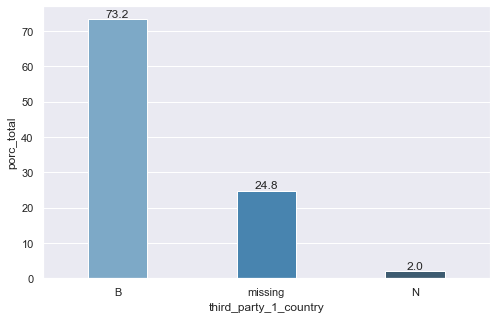

In [1049]:
plt.figure(figsize=(8,5))

ax = sns.barplot(x=var, y='porc_total', 
                 data=data.reset_index().sort_values(by='porc_total',ascending=False),palette='Blues_d')
widthbars = [0.4, 0.4, 0.4]

for p,newwidth in zip(ax.patches,widthbars):
    
    x = p.get_x()
    width = p.get_width()
    centre = x + width/2.
    p.set_x(centre - newwidth/2.)
    p.set_width(newwidth)
    
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), 
                   textcoords = 'offset points',
                   size=12)

plt.show()

In [1050]:
df_total.set_index(var,inplace=True)

In [1051]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55419, 100)


third_party_1_country fraud  claim_amount  claim_date_registered  \
0                     B     N        678.28               20171110   
1                     B     N       1154.41               20170302   
2                     B     N        615.99               20171014   
3                     B     N        826.33               20170703   
4                     B     N       2391.07               20170724   

   third_party_2_postal_code third_party_2_injured third_party_2_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                     5000.0                     N                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN                        NaN   

  third_party_2_form  third_party_2_year_birth third_party_2_country  \
0                NaN                       NaN                   NaN   
1                  L                       NaN                     B   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   third_party_3_postal_code third_party_3_injured third_party_3_vehicle_type  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN                   NaN                        NaN   

  third_party_3_form  third_party_3_year_birth third_party_3_country  \
0                NaN                       NaN                   NaN   
1                NaN                       NaN                   NaN   
2                NaN                       NaN                   NaN   
3                NaN                       NaN                   NaN   
4                NaN                       NaN                   NaN   

   repair_postal_code repair_form  repair_year_birth repair_country  \
0                 NaN         NaN                NaN            NaN   
1                 NaN         NaN                NaN            NaN   
2                 NaN         NaN                NaN            NaN   
3                 NaN         NaN                NaN            NaN   
4              1840.0           C                NaN              B   

  repair_sla  policy_date_start  policy_date_next_expiry  \
0          N           201304.0                 201804.0   
1          N           201307.0                 201707.0   
2          N           201703.0                 201803.0   
3          N                NaN                      NaN   
4          N           200503.0                 201803.0   

   policy_date_last_renewed  policy_num_changes  policy_num_claims  \
0                  201804.0                   0                  2   
1                  201707.0                   3                  1   
2                  201803.0                   2                  0   
3                       NaN                   0                  0   
4                  201803.0                   2                  1   

   policy_premium_100  policy_coverage_1000 policy_coverage_type  \
0                 3.0                   NaN           #000110000   
1                 7.0                  14.0           #110110011   
2                 4.0                   NaN           #000110001   
3                 NaN                   NaN           #000000000   
4                 9.0                  17.0           #111110110   

   woe_diff_days_claim_reg_ocu  diff_days_claim_reg_ocu  \
0                     -67.6943                       31   
1    

In [1052]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
third_party_1_country                                                     
missing                   27951259.74      1484528.51                73.52
B                         84991534.54       514921.68                25.50
N                          1986694.36        19809.45                 0.98

In [1053]:
### 

In [1054]:
table.to_clipboard(index=True,header=True)

In [1055]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [1056]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [1057]:
data[var].dtype

dtype('O')

In [1058]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [1059]:
temp.index.dtype

dtype('O')

In [1060]:
dict_woe.update(temp.to_dict())

In [1061]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [1062]:
len(dict_woe)

32

In [1063]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [1064]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [1065]:
data[var+'_cat'] = data[var]

In [1066]:
data[var+'_cat'] = np.where(data[var].isin(['B','N']),0,1)

In [1067]:
#data.reset_index(drop=True,inplace=True)
data.drop(['woe',var],axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 100)


fraud  claim_amount  claim_date_registered  third_party_2_postal_code  \
0     N        678.28               20171110                        NaN   
1     N       1154.41               20170302                     5000.0   
2     N        615.99               20171014                        NaN   
3     N        826.33               20170703                        NaN   
4     N       2391.07               20170724                        NaN   

  third_party_2_injured third_party_2_vehicle_type third_party_2_form  \
0                   NaN                        NaN                NaN   
1                     N                        NaN                  L   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_2_year_birth third_party_2_country  third_party_3_postal_code  \
0                       NaN                   NaN                        NaN   
1                       NaN                     B                        NaN   
2                       NaN                   NaN                        NaN   
3                       NaN                   NaN                        NaN   
4                       NaN                   NaN                        NaN   

  third_party_3_injured third_party_3_vehicle_type third_party_3_form  \
0                   NaN                        NaN                NaN   
1                   NaN                        NaN                NaN   
2                   NaN                        NaN                NaN   
3                   NaN                        NaN                NaN   
4                   NaN                        NaN                NaN   

   third_party_3_year_birth third_party_3_country  repair_postal_code  \
0                       NaN                   NaN                 NaN   
1                       NaN                   NaN                 NaN   
2                       NaN                   NaN                 NaN   
3                       NaN                   NaN                 NaN   
4                       NaN                   NaN              1840.0   

  repair_form  repair_year_birth repair_country repair_sla  policy_date_start  \
0         NaN                NaN            NaN          N           201304.0   
1         NaN                NaN            NaN          N           201307.0   
2         NaN                NaN            NaN          N           201703.0   
3         NaN                NaN            NaN          N                NaN   
4           C                NaN              B          N           200503.0   

   policy_date_next_expiry  policy_date_last_renewed  policy_num_changes  \
0                 201804.0                  201804.0                   0   
1                 201707.0                  201707.0                   3   
2                 201803.0                  201803.0                   2   
3                      NaN                       NaN                   0   
4                 201803.0                  201803.0                   2   

   policy_num_claims  policy_premium_100  policy_coverage_1000  \
0                  2                 3.0                   NaN   
1                  1                 7.0                  14.0   
2                  0                 4.0                   NaN   
3                  0                 NaN                   NaN   
4                  1                 9.0                  17.0   

  policy_coverage_type  woe_diff_days_claim_reg_ocu  diff_days_claim_reg_ocu  \
0           #000110000                     -67.6943                       31   
1           #110110011                       6.9692                       29   
2           #000110001                      22.4187                        7   
3           #000000000                      22.4187                        7   
4           

In [1068]:
#############

In [1069]:
columns_drop = [col for col in df_total.columns if ('third_party_2' in col) or ('third_party_3' in col)]
columns_drop

['third_party_2_postal_code',
 'third_party_2_injured',
 'third_party_2_vehicle_type',
 'third_party_2_form',
 'third_party_2_year_birth',
 'third_party_2_country',
 'third_party_3_postal_code',
 'third_party_3_injured',
 'third_party_3_vehicle_type',
 'third_party_3_form',
 'third_party_3_year_birth',
 'third_party_3_country']

In [1070]:
df_total.drop(columns_drop,axis=1,inplace=True)

In [1071]:
print(df_total.shape)
df_total.head()

(55419, 88)


fraud  claim_amount  claim_date_registered  repair_postal_code repair_form  \
0     N        678.28               20171110                 NaN         NaN   
1     N       1154.41               20170302                 NaN         NaN   
2     N        615.99               20171014                 NaN         NaN   
3     N        826.33               20170703                 NaN         NaN   
4     N       2391.07               20170724              1840.0           C   

   repair_year_birth repair_country repair_sla  policy_date_start  \
0                NaN            NaN          N           201304.0   
1                NaN            NaN          N           201307.0   
2                NaN            NaN          N           201703.0   
3                NaN            NaN          N                NaN   
4                NaN              B          N           200503.0   

   policy_date_next_expiry  policy_date_last_renewed  policy_num_changes  \
0                 201804.0                  201804.0                   0   
1                 201707.0                  201707.0                   3   
2                 201803.0                  201803.0                   2   
3                      NaN                       NaN                   0   
4                 201803.0                  201803.0                   2   

   policy_num_claims  policy_premium_100  policy_coverage_1000  \
0                  2                 3.0                   NaN   
1                  1                 7.0                  14.0   
2                  0                 4.0                   NaN   
3                  0                 NaN                   NaN   
4                  1                 9.0                  17.0   

  policy_coverage_type  woe_diff_days_claim_reg_ocu  diff_days_claim_reg_ocu  \
0           #000110000                     -67.6943                       31   
1           #110110011                       6.9692                       29   
2           #000110001                      22.4187                        7   
3           #000000000                      22.4187                        7   
4           #111110110                      -0.3454                        2   

   woe_claim_postal_code  woe_claim_postal_code_cat_medium_fraud  \
0               128.4157                                       0   
1              -317.2900                                       0   
2               128.4157                                       0   
3               128.4157                                       0   
4               128.4157                                       0   

   woe_claim_postal_code_cat_high_fraud  woe_claim_cause  \
0                                     0         -30.6761   
1                                     1         -30.6761   
2                                     0          62.2094   
3                                     0          62.2094   
4                                     0          62.2094   

   claim_cause_cat_other  claim_cause_cat_remaining_cats  woe_claim_liable  \
0                      1                               0          -24.7262   
1                      1                               0          -24.7262   
2                      0                               0           57.2768   
3                      0                               0           57.2768   
4                      0                               0          -24.7262   

   claim_liable_cat_N  woe_claim_num_injured  claim_num_injured  \
0                   1                -3.1404                  0   
1                   1                -3.1404                  0   
2                   0                -3.1404                  0   
3                   0                -3.1404                  0   
4                   1                -3.1404                  0   

   woe_claim_num_third_parties  claim_num_third_parties  \
0                      56.6264                        1   
1          

In [1072]:
#############

In [1073]:
columns_drop = [col for col in df_total.columns if ('repair' in col) and ('sla' not in col)]
columns_drop

['repair_postal_code', 'repair_form', 'repair_year_birth', 'repair_country']

In [1074]:
df_total.drop(columns_drop,axis=1,inplace=True)

In [1075]:
print(df_total.shape)
df_total.head()

(55419, 84)


fraud  claim_amount  claim_date_registered repair_sla  policy_date_start  \
0     N        678.28               20171110          N           201304.0   
1     N       1154.41               20170302          N           201307.0   
2     N        615.99               20171014          N           201703.0   
3     N        826.33               20170703          N                NaN   
4     N       2391.07               20170724          N           200503.0   

   policy_date_next_expiry  policy_date_last_renewed  policy_num_changes  \
0                 201804.0                  201804.0                   0   
1                 201707.0                  201707.0                   3   
2                 201803.0                  201803.0                   2   
3                      NaN                       NaN                   0   
4                 201803.0                  201803.0                   2   

   policy_num_claims  policy_premium_100  policy_coverage_1000  \
0                  2                 3.0                   NaN   
1                  1                 7.0                  14.0   
2                  0                 4.0                   NaN   
3                  0                 NaN                   NaN   
4                  1                 9.0                  17.0   

  policy_coverage_type  woe_diff_days_claim_reg_ocu  diff_days_claim_reg_ocu  \
0           #000110000                     -67.6943                       31   
1           #110110011                       6.9692                       29   
2           #000110001                      22.4187                        7   
3           #000000000                      22.4187                        7   
4           #111110110                      -0.3454                        2   

   woe_claim_postal_code  woe_claim_postal_code_cat_medium_fraud  \
0               128.4157                                       0   
1              -317.2900                                       0   
2               128.4157                                       0   
3               128.4157                                       0   
4               128.4157                                       0   

   woe_claim_postal_code_cat_high_fraud  woe_claim_cause  \
0                                     0         -30.6761   
1                                     1         -30.6761   
2                                     0          62.2094   
3                                     0          62.2094   
4                                     0          62.2094   

   claim_cause_cat_other  claim_cause_cat_remaining_cats  woe_claim_liable  \
0                      1                               0          -24.7262   
1                      1                               0          -24.7262   
2                      0                               0           57.2768   
3                      0                               0           57.2768   
4                      0                               0          -24.7262   

   claim_liable_cat_N  woe_claim_num_injured  claim_num_injured  \
0                   1                -3.1404                  0   
1                   1                -3.1404                  0   
2                   0                -3.1404                  0   
3                   0                -3.1404                  0   
4                   1                -3.1404                  0   

   woe_claim_num_third_parties  claim_num_third_parties  \
0                      56.6264                        1   
1                     112.6470                        2   
2                      56.6264                        1   
3                      56.6264                        1   
4                      56.6264                        1   

   woe_claim_num_vehicles  claim_num_vehicles  woe_claim_police  \
0                 43.4522                   2           31.5452   
1                 43.4522                   2           31.5452   


In [1076]:
#############

In [1077]:
var = 'repair_sla'

In [1078]:
len(df_total[var].unique())

2

In [1079]:
df_total[var].unique()

array(['N', 'Y'], dtype=object)

In [1080]:
data = woe(df_total,var)
#data.sort_index()
data

N    Y  total   porc_N  porc_Y  porc_total     woe
repair_sla                                                        
N           35663  207  35870  99.4229  0.5771     64.7251 -3.7855
Y           19448  101  19549  99.4833  0.5167     35.2749  7.3374

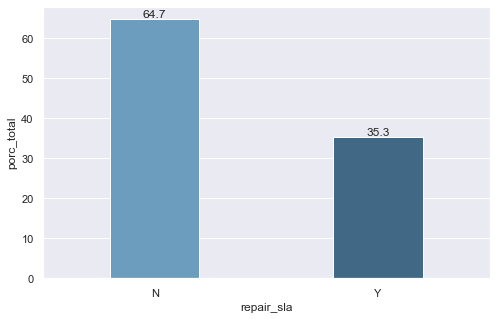

In [1081]:
plt.figure(figsize=(8,5))

ax = sns.barplot(x=var, y='porc_total', 
                 data=data.reset_index().sort_values(by='porc_total',ascending=False),palette='Blues_d')
widthbars = [0.4, 0.4]

for p,newwidth in zip(ax.patches,widthbars):
    
    x = p.get_x()
    width = p.get_width()
    centre = x + width/2.
    p.set_x(centre - newwidth/2.)
    p.set_width(newwidth)
    
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), 
                   textcoords = 'offset points',
                   size=12)

plt.show()

In [1082]:
df_total.set_index(var,inplace=True)

In [1083]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55419, 85)


repair_sla fraud  claim_amount  claim_date_registered  policy_date_start  \
0          N     N        678.28               20171110           201304.0   
1          N     N       1154.41               20170302           201307.0   
2          N     N        615.99               20171014           201703.0   
3          N     N        826.33               20170703                NaN   
4          N     N       2391.07               20170724           200503.0   

   policy_date_next_expiry  policy_date_last_renewed  policy_num_changes  \
0                 201804.0                  201804.0                   0   
1                 201707.0                  201707.0                   3   
2                 201803.0                  201803.0                   2   
3                      NaN                       NaN                   0   
4                 201803.0                  201803.0                   2   

   policy_num_claims  policy_premium_100  policy_coverage_1000  \
0                  2                 3.0                   NaN   
1                  1                 7.0                  14.0   
2                  0                 4.0                   NaN   
3                  0                 NaN                   NaN   
4                  1                 9.0                  17.0   

  policy_coverage_type  woe_diff_days_claim_reg_ocu  diff_days_claim_reg_ocu  \
0           #000110000                     -67.6943                       31   
1           #110110011                       6.9692                       29   
2           #000110001                      22.4187                        7   
3           #000000000                      22.4187                        7   
4           #111110110                      -0.3454                        2   

   woe_claim_postal_code  woe_claim_postal_code_cat_medium_fraud  \
0               128.4157                                       0   
1              -317.2900                                       0   
2               128.4157                                       0   
3               128.4157                                       0   
4               128.4157                                       0   

   woe_claim_postal_code_cat_high_fraud  woe_claim_cause  \
0                                     0         -30.6761   
1                                     1         -30.6761   
2                                     0          62.2094   
3                                     0          62.2094   
4                                     0          62.2094   

   claim_cause_cat_other  claim_cause_cat_remaining_cats  woe_claim_liable  \
0                      1                               0          -24.7262   
1                      1                               0          -24.7262   
2                      0                               0           57.2768   
3                      0                               0           57.2768   
4                      0                               0          -24.7262   

   claim_liable_cat_N  woe_claim_num_injured  claim_num_injured  \
0                   1                -3.1404                  0   
1                   1                -3.1404                  0   
2                   0                -3.1404                  0   
3                   0                -3.1404                  0   
4                   1                -3.1404                  0   

   woe_claim_num_third_parties  claim_num_third_parties  \
0                      56.6264                        1   
1                     112.6470                        2   
2                      56.6264                        1   
3                      56.6264                        1   
4                      56.6264                        1   

   woe_claim_num_vehicles  claim_num_vehicles  woe_claim_police  \
0                 43.4522                   2           31.5452   
1                 43.4522                   2           31.5452   


In [1084]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
repair_sla                                                     
N              69262344.67      1470317.00                72.81
Y              45667143.97       548942.64                27.19

In [1085]:
### 

In [1086]:
table.to_clipboard(index=True,header=True)

In [1087]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [1088]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [1089]:
data[var].dtype

dtype('O')

In [1090]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [1091]:
temp.index.dtype

dtype('O')

In [1092]:
dict_woe.update(temp.to_dict())

In [1093]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [1094]:
len(dict_woe)

33

In [1095]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [1096]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [1097]:
data[var+'_cat'] = data[var]

In [1098]:
var+'_cat'

'repair_sla_cat'

In [1099]:
data[var+'_cat'].unique()

array(['N', 'Y'], dtype=object)

In [1100]:
dict_categ = {'repair_sla_cat':['Y','N']}

data = categorical(data,dict_categ)

In [1101]:
# Get dummies
data = pd.get_dummies(data,
                      columns=data.columns[
                                           np.where(data.dtypes == 'category')
                                           ],
                      drop_first=True
                      )

In [1102]:
#data.reset_index(drop=True,inplace=True)
data.drop(['woe',var],axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 85)


fraud  claim_amount  claim_date_registered  policy_date_start  \
0     N        678.28               20171110           201304.0   
1     N       1154.41               20170302           201307.0   
2     N        615.99               20171014           201703.0   
3     N        826.33               20170703                NaN   
4     N       2391.07               20170724           200503.0   

   policy_date_next_expiry  policy_date_last_renewed  policy_num_changes  \
0                 201804.0                  201804.0                   0   
1                 201707.0                  201707.0                   3   
2                 201803.0                  201803.0                   2   
3                      NaN                       NaN                   0   
4                 201803.0                  201803.0                   2   

   policy_num_claims  policy_premium_100  policy_coverage_1000  \
0                  2                 3.0                   NaN   
1                  1                 7.0                  14.0   
2                  0                 4.0                   NaN   
3                  0                 NaN                   NaN   
4                  1                 9.0                  17.0   

  policy_coverage_type  woe_diff_days_claim_reg_ocu  diff_days_claim_reg_ocu  \
0           #000110000                     -67.6943                       31   
1           #110110011                       6.9692                       29   
2           #000110001                      22.4187                        7   
3           #000000000                      22.4187                        7   
4           #111110110                      -0.3454                        2   

   woe_claim_postal_code  woe_claim_postal_code_cat_medium_fraud  \
0               128.4157                                       0   
1              -317.2900                                       0   
2               128.4157                                       0   
3               128.4157                                       0   
4               128.4157                                       0   

   woe_claim_postal_code_cat_high_fraud  woe_claim_cause  \
0                                     0         -30.6761   
1                                     1         -30.6761   
2                                     0          62.2094   
3                                     0          62.2094   
4                                     0          62.2094   

   claim_cause_cat_other  claim_cause_cat_remaining_cats  woe_claim_liable  \
0                      1                               0          -24.7262   
1                      1                               0          -24.7262   
2                      0                               0           57.2768   
3                      0                               0           57.2768   
4                      0                               0          -24.7262   

   claim_liable_cat_N  woe_claim_num_injured  claim_num_injured  \
0                   1                -3.1404                  0   
1                   1                -3.1404                  0   
2                   0                -3.1404                  0   
3                   0                -3.1404                  0   
4                   1                -3.1404                  0   

   woe_claim_num_third_parties  claim_num_third_parties  \
0                      56.6264                        1   
1                     112.6470                        2   
2                      56.6264                        1   
3                      56.6264                        1   
4                      56.6264                        1   

   woe_claim_num_vehicles  claim_num_vehicles  woe_claim_police  \
0                 43.4522                   2           31.5452   
1                 43.4522                   2           31.5452   
2                 43.4522                   2           31.5452   

In [1103]:
#############

In [1104]:
var = 'policy_date_start'

In [1105]:
df_total[var].isna().sum()

9151

In [1106]:
print(df_total[var].min())
print(df_total[var].max())

195201.0
201712.0


In [1107]:
df_total.loc[df_total['policy_date_start']==195201,'fraud'].value_counts()

N    1519
Y       1
Name: fraud, dtype: int64

In [1108]:
df_total[var].value_counts().sort_index().head(5)

195201.0    1520
197810.0       2
197901.0       1
198401.0     115
198408.0       1
Name: policy_date_start, dtype: int64

In [1109]:
df_total.shape

(55419, 85)

In [1110]:
base_date = pd.to_datetime(df_total['claim_date_registered'], format='%Y%m%d')
base_date.dt.year

0        2017
1        2017
2        2017
3        2017
4        2017
         ... 
55414    2017
55415    2017
55416    2017
55417    2017
55418    2017
Name: claim_date_registered, Length: 55419, dtype: int64

In [1111]:
df_total['years_policy_start'] = (base_date.dt.year - pd.to_datetime(df_total[var], format='%Y%m').dt.year)

In [1112]:
print(df_total[var].isna().sum())
print(df_total['years_policy_start'].isna().sum())

9151
9151


In [1113]:
var = 'years_policy_start'

In [1114]:
df_total[var].head()

0     4.0
1     4.0
2     0.0
3     NaN
4    12.0
Name: years_policy_start, dtype: float64

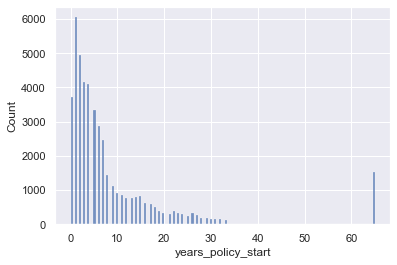

In [1115]:
sns.histplot(x=df_total[var].dropna())
plt.show()

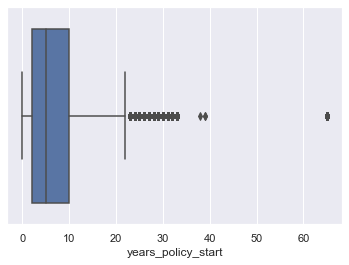

In [1116]:
sns.boxplot(x=df_total[var].dropna())
plt.show()

In [1117]:
df_total[var].dropna().quantile([0, 0.05, .1, .25, .5, .75, 0.8, 0.85, 0.9, .95, 1])

0.00     0.0
0.05     0.0
0.10     1.0
0.25     2.0
0.50     5.0
0.75    10.0
0.80    13.0
0.85    16.0
0.90    21.0
0.95    28.0
1.00    65.0
Name: years_policy_start, dtype: float64

In [1118]:
q_95 = df_total[var].dropna().quantile(.95)
print(q_95)

df_total[var] = np.where(df_total[var].isna(),np.nan,
                         np.where(df_total[var]>=int(q_95),int(q_95),df_total[var]))

28.0


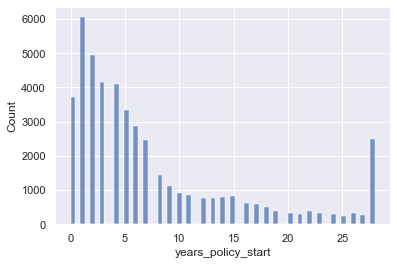

In [1119]:
sns.histplot(x=df_total[var].dropna())
plt.show()

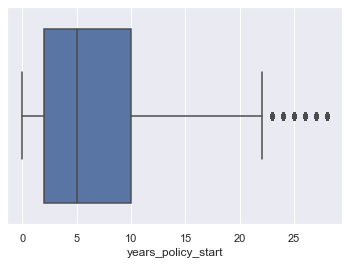

In [1120]:
sns.boxplot(x=df_total[var].dropna())
plt.show()

In [1121]:
df_total[var] = np.where(df_total[var].isna(),-1,df_total[var])

In [1122]:
data = woe(df_total,var)
data.sort_index().head(5)
#data

N   Y  total   porc_N  porc_Y  porc_total      woe
years_policy_start                                                       
-1.0                9113  38   9151  99.5847  0.4153     16.5124  29.2866
 0.0                3681  37   3718  99.0048  0.9952      6.7089 -58.6983
 1.0                6013  42   6055  99.3064  0.6936     10.9259 -22.2995
 2.0                4929  29   4958  99.4151  0.5849      8.9464  -5.1409
 3.0                4139  25   4164  99.3996  0.6004      7.5137  -7.7671

In [1123]:
df_total.set_index(var,inplace=True)

In [1124]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55419, 87)


years_policy_start fraud  claim_amount  claim_date_registered  \
0                -1.0     N        826.33               20170703   
1                -1.0     N       2178.60               20170518   
2                -1.0     N        717.00               20170311   
3                -1.0     N       1319.11               20170520   
4                -1.0     N       4280.69               20170211   

   policy_date_start  policy_date_next_expiry  policy_date_last_renewed  \
0                NaN                      NaN                       NaN   
1                NaN                      NaN                       NaN   
2                NaN                      NaN                       NaN   
3                NaN                      NaN                       NaN   
4                NaN                      NaN                       NaN   

   policy_num_changes  policy_num_claims  policy_premium_100  \
0                   0                  0                 NaN   
1                   0                  0                 NaN   
2                   0                  0                 NaN   
3                   0                  1                 NaN   
4                   0                  0                 NaN   

   policy_coverage_1000 policy_coverage_type  woe_diff_days_claim_reg_ocu  \
0                   NaN           #000000000                      22.4187   
1                   NaN           #000000000                     -85.7070   
2                   NaN           #000000000                     114.6187   
3                   NaN           #000000000                     -28.9963   
4                   NaN           #000000000                      22.4187   

   diff_days_claim_reg_ocu  woe_claim_postal_code  \
0                        7               128.4157   
1                       45                -3.4511   
2                       33               128.4157   
3                       24               128.4157   
4                        7               128.4157   

   woe_claim_postal_code_cat_medium_fraud  \
0                                       0   
1                                       1   
2                                       0   
3                                       0   
4                                       0   

   woe_claim_postal_code_cat_high_fraud  woe_claim_cause  \
0                                     0          62.2094   
1                                     0          62.2094   
2                                     0          62.2094   
3                                     0          62.2094   
4                                     0          62.2094   

   claim_cause_cat_other  claim_cause_cat_remaining_cats  woe_claim_liable  \
0                      0                               0           57.2768   
1                      0                               0           57.2768   
2                      0                               0           57.2768   
3                      0                               0           57.2768   
4                      0                               0           57.2768   

   claim_liable_cat_N  woe_claim_num_injured  claim_num_injured  \
0                   0                -3.1404                  0   
1                   0                -3.1404                  0   
2                   0                -3.1404                  0   
3                   0                -3.1404                  0   
4                   0                -3.1404                  0   

   woe_claim_num_third_parties  claim_num_third_parties  \
0                      56.6264                        1   
1                      56.6264                        1   
2                      56.6264                        1   
3                      56.6264                        1   
4                     112.6470                        2   

   woe_claim_num_vehicles  claim_num_vehicles  woe_claim_police  \
0                -23.5123                   3     

In [1125]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
years_policy_start                                                     
 1.0                   13294647.73       396837.85                19.65
-1.0                   13853507.39       238208.05                11.80
 0.0                    8454997.82       226983.35                11.24
 4.0                    9088742.45       218956.20                10.84
 2.0                   10607746.79       184230.70                 9.12

In [1126]:
### 

In [1127]:
table.to_clipboard(index=True,header=True)

In [1128]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [1129]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [1130]:
data[var].dtype

dtype('float64')

In [1131]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [1132]:
temp.index.dtype

dtype('float64')

In [1133]:
dict_woe.update(temp.to_dict())

In [1134]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [1135]:
len(dict_woe)

34

In [1136]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [1137]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [1138]:
columns_f = [col for col in data.columns if (var not in col)]+['woe_'+var]+[var]
print(len(columns_f))
print(data.shape)

data = data.reindex(columns=columns_f)

88
(55419, 88)


In [1139]:
data[var] = np.where(data[var]==-1,np.nan,data[var])

In [1140]:
data[var].isna().sum()

9151

In [1141]:
data.drop('woe',axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 87)


fraud  claim_amount  claim_date_registered  policy_date_start  \
0     N        826.33               20170703                NaN   
1     N       2178.60               20170518                NaN   
2     N        717.00               20170311                NaN   
3     N       1319.11               20170520                NaN   
4     N       4280.69               20170211                NaN   

   policy_date_next_expiry  policy_date_last_renewed  policy_num_changes  \
0                      NaN                       NaN                   0   
1                      NaN                       NaN                   0   
2                      NaN                       NaN                   0   
3                      NaN                       NaN                   0   
4                      NaN                       NaN                   0   

   policy_num_claims  policy_premium_100  policy_coverage_1000  \
0                  0                 NaN                   NaN   
1                  0                 NaN                   NaN   
2                  0                 NaN                   NaN   
3                  1                 NaN                   NaN   
4                  0                 NaN                   NaN   

  policy_coverage_type  woe_diff_days_claim_reg_ocu  diff_days_claim_reg_ocu  \
0           #000000000                      22.4187                        7   
1           #000000000                     -85.7070                       45   
2           #000000000                     114.6187                       33   
3           #000000000                     -28.9963                       24   
4           #000000000                      22.4187                        7   

   woe_claim_postal_code  woe_claim_postal_code_cat_medium_fraud  \
0               128.4157                                       0   
1                -3.4511                                       1   
2               128.4157                                       0   
3               128.4157                                       0   
4               128.4157                                       0   

   woe_claim_postal_code_cat_high_fraud  woe_claim_cause  \
0                                     0          62.2094   
1                                     0          62.2094   
2                                     0          62.2094   
3                                     0          62.2094   
4                                     0          62.2094   

   claim_cause_cat_other  claim_cause_cat_remaining_cats  woe_claim_liable  \
0                      0                               0           57.2768   
1                      0                               0           57.2768   
2                      0                               0           57.2768   
3                      0                               0           57.2768   
4                      0                               0           57.2768   

   claim_liable_cat_N  woe_claim_num_injured  claim_num_injured  \
0                   0                -3.1404                  0   
1                   0                -3.1404                  0   
2                   0                -3.1404                  0   
3                   0                -3.1404                  0   
4                   0                -3.1404                  0   

   woe_claim_num_third_parties  claim_num_third_parties  \
0                      56.6264                        1   
1                      56.6264                        1   
2                      56.6264                        1   
3                      56.6264                        1   
4                     112.6470                        2   

   woe_claim_num_vehicles  claim_num_vehicles  woe_claim_police  \
0                -23.5123                   3           31.5452   
1                -23.5123                   3           31.5452   
2                 43.4522                   2           31.5452   

In [1142]:
#############

In [1143]:
var = 'policy_date_next_expiry'

In [1144]:
df_total[var].isna().sum()

9151

In [1145]:
print(df_total[var].min())
print(df_total[var].max())

201005.0
201812.0


In [1146]:
df_total.loc[df_total[var]==201005,'fraud'].value_counts()

N    3
Name: fraud, dtype: int64

In [1147]:
df_total[var].value_counts().sort_index().head(5)

201005.0    3
201009.0    1
201012.0    1
201105.0    1
201111.0    1
Name: policy_date_next_expiry, dtype: int64

In [1148]:
df_total.shape

(55419, 87)

In [1149]:
df_total['policy_date_start'].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: policy_date_start, dtype: float64

In [1150]:
#base_date = pd.to_datetime(df_total['claim_date_registered'], format='%Y%m%d')
base_date = pd.to_datetime(df_total['policy_date_start'], format='%Y%m')
base_date.dt.year

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
          ...  
55414    1952.0
55415    1952.0
55416    1952.0
55417    1952.0
55418    1987.0
Name: policy_date_start, Length: 55419, dtype: float64

In [1151]:
df_total['years_policy_expiry'] = (pd.to_datetime(df_total[var], format='%Y%m').dt.year-base_date.dt.year)

In [1152]:
print(df_total[var].isna().sum())
print(df_total['years_policy_expiry'].isna().sum())

9151
9151


In [1153]:
var = 'years_policy_expiry'

In [1154]:
df_total[var].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: years_policy_expiry, dtype: float64

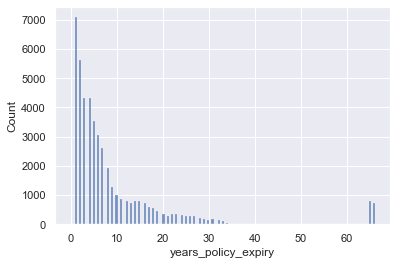

In [1155]:
sns.histplot(x=df_total[var].dropna())
plt.show()

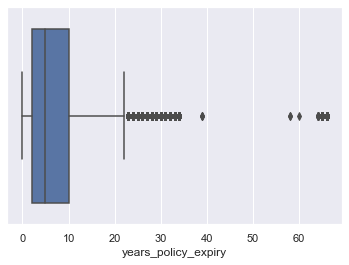

In [1156]:
sns.boxplot(x=df_total[var].dropna())
plt.show()

In [1157]:
df_total[var].quantile([0, 0.05, .1, .25, .5, .75, 0.8, 0.85, 0.9, .95, 1])

0.00     0.0
0.05     1.0
0.10     1.0
0.25     2.0
0.50     5.0
0.75    10.0
0.80    13.0
0.85    16.0
0.90    21.0
0.95    29.0
1.00    66.0
Name: years_policy_expiry, dtype: float64

In [1158]:
q_95 = df_total[var].dropna().quantile(.95)
print(q_95)

df_total[var] = np.where(df_total[var].isna(),np.nan,
                         np.where(df_total[var]>=int(q_95),int(q_95),df_total[var]))

29.0


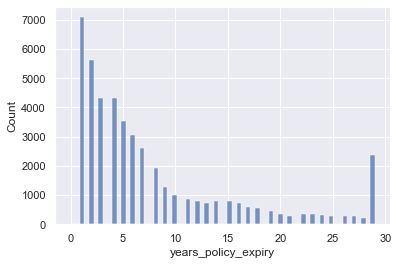

In [1159]:
sns.histplot(x=df_total[var].dropna())
plt.show()

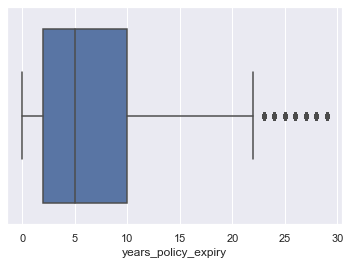

In [1160]:
sns.boxplot(x=df_total[var].dropna())
plt.show()

In [1161]:
df_total[var] = np.where(df_total[var].isna(),-1,df_total[var])

In [1162]:
data = woe(df_total,var)
data.sort_index().head()
#data

N   Y  total    porc_N  porc_Y  porc_total      woe
years_policy_expiry                                                        
-1.0                 9113  38   9151   99.5847  0.4153     16.5124  29.2866
 0.0                   19   0     19  100.0000  0.0000      0.0343      inf
 1.0                 7025  64   7089   99.0972  0.9028     12.7916 -48.8657
 2.0                 5603  28   5631   99.5028  0.4972     10.1608  11.1848
 3.0                 4287  27   4314   99.3741  0.6259      7.7843 -11.9499

In [1163]:
df_total.set_index(var,inplace=True)

In [1164]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55419, 89)


years_policy_expiry fraud  claim_amount  claim_date_registered  \
0                 -1.0     N        826.33               20170703   
1                 -1.0     N       2178.60               20170518   
2                 -1.0     N        717.00               20170311   
3                 -1.0     N       1319.11               20170520   
4                 -1.0     N       4280.69               20170211   

   policy_date_start  policy_date_next_expiry  policy_date_last_renewed  \
0                NaN                      NaN                       NaN   
1                NaN                      NaN                       NaN   
2                NaN                      NaN                       NaN   
3                NaN                      NaN                       NaN   
4                NaN                      NaN                       NaN   

   policy_num_changes  policy_num_claims  policy_premium_100  \
0                   0                  0                 NaN   
1                   0                  0                 NaN   
2                   0                  0                 NaN   
3                   0                  1                 NaN   
4                   0                  0                 NaN   

   policy_coverage_1000 policy_coverage_type  woe_diff_days_claim_reg_ocu  \
0                   NaN           #000000000                      22.4187   
1                   NaN           #000000000                     -85.7070   
2                   NaN           #000000000                     114.6187   
3                   NaN           #000000000                     -28.9963   
4                   NaN           #000000000                      22.4187   

   diff_days_claim_reg_ocu  woe_claim_postal_code  \
0                        7               128.4157   
1                       45                -3.4511   
2                       33               128.4157   
3                       24               128.4157   
4                        7               128.4157   

   woe_claim_postal_code_cat_medium_fraud  \
0                                       0   
1                                       1   
2                                       0   
3                                       0   
4                                       0   

   woe_claim_postal_code_cat_high_fraud  woe_claim_cause  \
0                                     0          62.2094   
1                                     0          62.2094   
2                                     0          62.2094   
3                                     0          62.2094   
4                                     0          62.2094   

   claim_cause_cat_other  claim_cause_cat_remaining_cats  woe_claim_liable  \
0                      0                               0           57.2768   
1                      0                               0           57.2768   
2                      0                               0           57.2768   
3                      0                               0           57.2768   
4                      0                               0           57.2768   

   claim_liable_cat_N  woe_claim_num_injured  claim_num_injured  \
0                   0                -3.1404                  0   
1                   0                -3.1404                  0   
2                   0                -3.1404                  0   
3                   0                -3.1404                  0   
4                   0                -3.1404                  0   

   woe_claim_num_third_parties  claim_num_third_parties  \
0                      56.6264                        1   
1                      56.6264                        1   
2                      56.6264                        1   
3                      56.6264                        1   
4                     112.6470                        2   

   woe_claim_num_vehicles  claim_num_vehicles  woe_claim_police  \
0                -23.5123                   

In [1165]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
years_policy_expiry                                                     
 1.0                    16092145.55       465874.23                23.07
 2.0                    12207919.25       242992.69                12.03
 4.0                     9387900.45       242432.42                12.01
-1.0                    13853507.39       238208.05                11.80
 3.0                     9208754.12       161579.90                 8.00

In [1166]:
### 

In [1167]:
table.to_clipboard(index=True,header=True)

In [1168]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [1169]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [1170]:
data[var].dtype

dtype('float64')

In [1171]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [1172]:
temp.index.dtype

dtype('float64')

In [1173]:
dict_woe.update(temp.to_dict())

In [1174]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [1175]:
len(dict_woe)

35

In [1176]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [1177]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [1178]:
columns_f = [col for col in data.columns if (var not in col)]+['woe_'+var]+[var]
print(len(columns_f))
print(data.shape)

data = data.reindex(columns=columns_f)

90
(55419, 90)


In [1179]:
data[var] = np.where(data[var]==-1,np.nan,data[var])

In [1180]:
data[var].isna().sum()

9151

In [1181]:
#data.reset_index(drop=True,inplace=True)
data.drop(['woe','policy_date_next_expiry'],axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 88)


fraud  claim_amount  claim_date_registered  policy_date_start  \
0     N        826.33               20170703                NaN   
1     N       2178.60               20170518                NaN   
2     N        717.00               20170311                NaN   
3     N       1319.11               20170520                NaN   
4     N       4280.69               20170211                NaN   

   policy_date_last_renewed  policy_num_changes  policy_num_claims  \
0                       NaN                   0                  0   
1                       NaN                   0                  0   
2                       NaN                   0                  0   
3                       NaN                   0                  1   
4                       NaN                   0                  0   

   policy_premium_100  policy_coverage_1000 policy_coverage_type  \
0                 NaN                   NaN           #000000000   
1                 NaN                   NaN           #000000000   
2                 NaN                   NaN           #000000000   
3                 NaN                   NaN           #000000000   
4                 NaN                   NaN           #000000000   

   woe_diff_days_claim_reg_ocu  diff_days_claim_reg_ocu  \
0                      22.4187                        7   
1                     -85.7070                       45   
2                     114.6187                       33   
3                     -28.9963                       24   
4                      22.4187                        7   

   woe_claim_postal_code  woe_claim_postal_code_cat_medium_fraud  \
0               128.4157                                       0   
1                -3.4511                                       1   
2               128.4157                                       0   
3               128.4157                                       0   
4               128.4157                                       0   

   woe_claim_postal_code_cat_high_fraud  woe_claim_cause  \
0                                     0          62.2094   
1                                     0          62.2094   
2                                     0          62.2094   
3                                     0          62.2094   
4                                     0          62.2094   

   claim_cause_cat_other  claim_cause_cat_remaining_cats  woe_claim_liable  \
0                      0                               0           57.2768   
1                      0                               0           57.2768   
2                      0                               0           57.2768   
3                      0                               0           57.2768   
4                      0                               0           57.2768   

   claim_liable_cat_N  woe_claim_num_injured  claim_num_injured  \
0                   0                -3.1404                  0   
1                   0                -3.1404                  0   
2                   0                -3.1404                  0   
3                   0                -3.1404                  0   
4                   0                -3.1404                  0   

   woe_claim_num_third_parties  claim_num_third_parties  \
0                      56.6264                        1   
1                      56.6264                        1   
2                      56.6264                        1   
3                      56.6264                        1   
4                     112.6470                        2   

   woe_claim_num_vehicles  claim_num_vehicles  woe_claim_police  \
0                -23.5123                   3           31.5452   
1                -23.5123                   3           31.5452   
2                 43.4522                   2           31.5452   
3                -23.5123                   3           31.5452   
4                -83.8970                   4           31.5452   

   claim_polic

In [1182]:
#############

In [1183]:
var = 'policy_date_last_renewed' #it's the same as 'policy_date_next_expiry'

In [1184]:
df_total.drop([var,'policy_date_start','claim_date_registered'],axis=1,inplace=True)

In [1185]:
print(df_total.shape)
df_total.head()

(55419, 85)


fraud  claim_amount  policy_num_changes  policy_num_claims  \
0     N        826.33                   0                  0   
1     N       2178.60                   0                  0   
2     N        717.00                   0                  0   
3     N       1319.11                   0                  1   
4     N       4280.69                   0                  0   

   policy_premium_100  policy_coverage_1000 policy_coverage_type  \
0                 NaN                   NaN           #000000000   
1                 NaN                   NaN           #000000000   
2                 NaN                   NaN           #000000000   
3                 NaN                   NaN           #000000000   
4                 NaN                   NaN           #000000000   

   woe_diff_days_claim_reg_ocu  diff_days_claim_reg_ocu  \
0                      22.4187                        7   
1                     -85.7070                       45   
2                     114.6187                       33   
3                     -28.9963                       24   
4                      22.4187                        7   

   woe_claim_postal_code  woe_claim_postal_code_cat_medium_fraud  \
0               128.4157                                       0   
1                -3.4511                                       1   
2               128.4157                                       0   
3               128.4157                                       0   
4               128.4157                                       0   

   woe_claim_postal_code_cat_high_fraud  woe_claim_cause  \
0                                     0          62.2094   
1                                     0          62.2094   
2                                     0          62.2094   
3                                     0          62.2094   
4                                     0          62.2094   

   claim_cause_cat_other  claim_cause_cat_remaining_cats  woe_claim_liable  \
0                      0                               0           57.2768   
1                      0                               0           57.2768   
2                      0                               0           57.2768   
3                      0                               0           57.2768   
4                      0                               0           57.2768   

   claim_liable_cat_N  woe_claim_num_injured  claim_num_injured  \
0                   0                -3.1404                  0   
1                   0                -3.1404                  0   
2                   0                -3.1404                  0   
3                   0                -3.1404                  0   
4                   0                -3.1404                  0   

   woe_claim_num_third_parties  claim_num_third_parties  \
0                      56.6264                        1   
1                      56.6264                        1   
2                      56.6264                        1   
3                      56.6264                        1   
4                     112.6470                        2   

   woe_claim_num_vehicles  claim_num_vehicles  woe_claim_police  \
0                -23.5123                   3           31.5452   
1                -23.5123                   3           31.5452   
2                 43.4522                   2           31.5452   
3                -23.5123                   3           31.5452   
4                -83.8970                   4           31.5452   

   claim_police_cat_Y  woe_claim_alcohol  woe_claim_language  \
0                   0             0.6519             45.9729   
1                   0             0.6519            -64.2040   
2                   0             0.6519            -64.2040   
3                   0             0.6519            -64.2040   
4                   0             0.6519            -64.2040   

   claim_language_cat_1.0  woe_claim_vehicle_brand  \
0             

In [1186]:
#############

In [1187]:
var = 'policy_num_changes'

In [1188]:
df_total[var].value_counts(normalize=True).sort_index()

0     0.755986
1     0.140132
2     0.062668
3     0.022122
4     0.010863
5     0.003771
6     0.002436
7     0.000938
8     0.000487
9     0.000253
10    0.000343
Name: policy_num_changes, dtype: float64

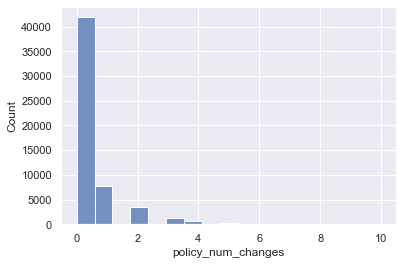

In [1189]:
sns.histplot(x=df_total[var].dropna())
plt.show()

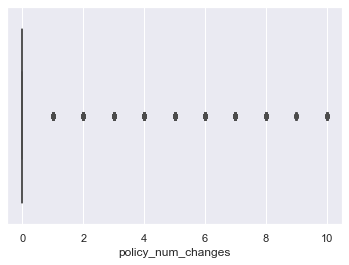

In [1190]:
sns.boxplot(x=df_total[var].dropna())
plt.show()

In [1191]:
df_total[var].dropna().quantile([0, 0.05, .1, .25, .5, .75, 0.8, 0.85, 0.9, .95, 1])

0.00     0.0
0.05     0.0
0.10     0.0
0.25     0.0
0.50     0.0
0.75     0.0
0.80     1.0
0.85     1.0
0.90     2.0
0.95     2.0
1.00    10.0
Name: policy_num_changes, dtype: float64

In [1192]:
# q_95 = df_total[var].dropna().quantile(.95)
# print(q_95)

# df_total[var] = np.where(df_total[var]>=int(q_95),int(q_95),df_total[var])

In [1193]:
data = woe(df_total,var)
data.sort_index()
#data

N    Y  total    porc_N  porc_Y  porc_total       woe
policy_num_changes                                                           
0                   41691  205  41896   99.5107  0.4893     75.5986   12.8026
1                    7720   46   7766   99.4077  0.5923     14.0132   -6.4077
2                    3444   29   3473   99.1650  0.8350      6.2668  -40.9912
3                    1216   10   1226   99.1843  0.8157      2.2122  -38.6268
4                     593    9    602   98.5050  1.4950      1.0863  -99.9035
5                     200    9    209   95.6938  4.3062      0.3771 -208.5912
6                     135    0    135  100.0000  0.0000      0.2436       inf
7                      52    0     52  100.0000  0.0000      0.0938       inf
8                      27    0     27  100.0000  0.0000      0.0487       inf
9                      14    0     14  100.0000  0.0000      0.0253       inf
10                     19    0     19  100.0000  0.0000      0.0343       inf

In [1194]:
data.to_clipboard(index=True,header=True)

In [1195]:
df_total.set_index(var,inplace=True)

In [1196]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55419, 86)


policy_num_changes fraud  claim_amount  policy_num_claims  \
0                   0     N        826.33                  0   
1                   0     N       2178.60                  0   
2                   0     N        717.00                  0   
3                   0     N       1319.11                  1   
4                   0     N       4280.69                  0   

   policy_premium_100  policy_coverage_1000 policy_coverage_type  \
0                 NaN                   NaN           #000000000   
1                 NaN                   NaN           #000000000   
2                 NaN                   NaN           #000000000   
3                 NaN                   NaN           #000000000   
4                 NaN                   NaN           #000000000   

   woe_diff_days_claim_reg_ocu  diff_days_claim_reg_ocu  \
0                      22.4187                        7   
1                     -85.7070                       45   
2                     114.6187                       33   
3                     -28.9963                       24   
4                      22.4187                        7   

   woe_claim_postal_code  woe_claim_postal_code_cat_medium_fraud  \
0               128.4157                                       0   
1                -3.4511                                       1   
2               128.4157                                       0   
3               128.4157                                       0   
4               128.4157                                       0   

   woe_claim_postal_code_cat_high_fraud  woe_claim_cause  \
0                                     0          62.2094   
1                                     0          62.2094   
2                                     0          62.2094   
3                                     0          62.2094   
4                                     0          62.2094   

   claim_cause_cat_other  claim_cause_cat_remaining_cats  woe_claim_liable  \
0                      0                               0           57.2768   
1                      0                               0           57.2768   
2                      0                               0           57.2768   
3                      0                               0           57.2768   
4                      0                               0           57.2768   

   claim_liable_cat_N  woe_claim_num_injured  claim_num_injured  \
0                   0                -3.1404                  0   
1                   0                -3.1404                  0   
2                   0                -3.1404                  0   
3                   0                -3.1404                  0   
4                   0                -3.1404                  0   

   woe_claim_num_third_parties  claim_num_third_parties  \
0                      56.6264                        1   
1                      56.6264                        1   
2                      56.6264                        1   
3                      56.6264                        1   
4                     112.6470                        2   

   woe_claim_num_vehicles  claim_num_vehicles  woe_claim_police  \
0                -23.5123                   3           31.5452   
1                -23.5123                   3           31.5452   
2                 43.4522                   2           31.5452   
3                -23.5123                   3           31.5452   
4                -83.8970                   4           31.5452   

   claim_police_cat_Y  woe_claim_alcohol  woe_claim_language  \
0                   0             0.6519             45.9729   
1                   0             0.6519            -64.2040   
2                   0             0.6519            -64.2040   
3                   0             0.6519            -64.2040   
4                   0             0.6519            -64.2040   

   claim_language_cat_1.0  woe_claim_vehicle_brand  \
0              

In [1197]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
policy_num_changes                                                     
0                      84375168.13      1255906.62                62.20
1                      17150840.91       285612.17                14.14
2                       8058025.48       191352.02                 9.48
3                       2857030.53       133338.51                 6.60
4                       1369340.67        91076.87                 4.51

In [1198]:
### 

In [1199]:
table.to_clipboard(index=True,header=True)

In [1200]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [1201]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [1202]:
data[var].dtype

dtype('int64')

In [1203]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [1204]:
temp.index.dtype

dtype('int64')

In [1205]:
dict_woe.update(temp.to_dict())

In [1206]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [1207]:
len(dict_woe)

36

In [1208]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [1209]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [1210]:
columns_f = [col for col in data.columns if (var not in col)]+['woe_'+var]+[var]
print(len(columns_f))
print(data.shape)

data = data.reindex(columns=columns_f)

87
(55419, 87)


In [1211]:
data.drop('woe',axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 86)


fraud  claim_amount  policy_num_claims  policy_premium_100  \
0     N        826.33                  0                 NaN   
1     N       2178.60                  0                 NaN   
2     N        717.00                  0                 NaN   
3     N       1319.11                  1                 NaN   
4     N       4280.69                  0                 NaN   

   policy_coverage_1000 policy_coverage_type  woe_diff_days_claim_reg_ocu  \
0                   NaN           #000000000                      22.4187   
1                   NaN           #000000000                     -85.7070   
2                   NaN           #000000000                     114.6187   
3                   NaN           #000000000                     -28.9963   
4                   NaN           #000000000                      22.4187   

   diff_days_claim_reg_ocu  woe_claim_postal_code  \
0                        7               128.4157   
1                       45                -3.4511   
2                       33               128.4157   
3                       24               128.4157   
4                        7               128.4157   

   woe_claim_postal_code_cat_medium_fraud  \
0                                       0   
1                                       1   
2                                       0   
3                                       0   
4                                       0   

   woe_claim_postal_code_cat_high_fraud  woe_claim_cause  \
0                                     0          62.2094   
1                                     0          62.2094   
2                                     0          62.2094   
3                                     0          62.2094   
4                                     0          62.2094   

   claim_cause_cat_other  claim_cause_cat_remaining_cats  woe_claim_liable  \
0                      0                               0           57.2768   
1                      0                               0           57.2768   
2                      0                               0           57.2768   
3                      0                               0           57.2768   
4                      0                               0           57.2768   

   claim_liable_cat_N  woe_claim_num_injured  claim_num_injured  \
0                   0                -3.1404                  0   
1                   0                -3.1404                  0   
2                   0                -3.1404                  0   
3                   0                -3.1404                  0   
4                   0                -3.1404                  0   

   woe_claim_num_third_parties  claim_num_third_parties  \
0                      56.6264                        1   
1                      56.6264                        1   
2                      56.6264                        1   
3                      56.6264                        1   
4                     112.6470                        2   

   woe_claim_num_vehicles  claim_num_vehicles  woe_claim_police  \
0                -23.5123                   3           31.5452   
1                -23.5123                   3           31.5452   
2                 43.4522                   2           31.5452   
3                -23.5123                   3           31.5452   
4                -83.8970                   4           31.5452   

   claim_police_cat_Y  woe_claim_alcohol  woe_claim_language  \
0                   0             0.6519             45.9729   
1                   0             0.6519            -64.2040   
2                   0             0.6519            -64.2040   
3                   0             0.6519            -64.2040   
4                   0             0.6519            -64.2040   

   claim_language_cat_1.0  woe_claim_vehicle_brand  \
0                       0                  18.3615   
1                       1                  18.3615   
2                       1 

In [1212]:
#############

In [1213]:
var = 'policy_num_claims'

In [1214]:
df_total[var].value_counts(normalize=True).sort_index()

0     0.360833
1     0.215432
2     0.132031
3     0.087984
4     0.058969
5     0.038741
6     0.026363
7     0.019596
8     0.012451
9     0.008571
10    0.039030
Name: policy_num_claims, dtype: float64

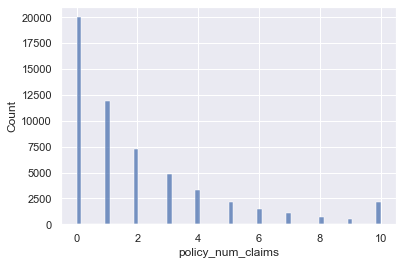

In [1215]:
sns.histplot(x=df_total[var].dropna())
plt.show()

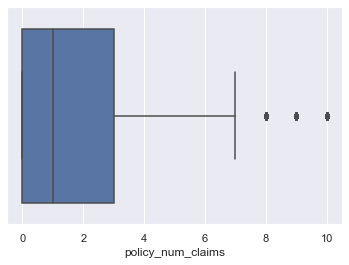

In [1216]:
sns.boxplot(x=df_total[var].dropna())
plt.show()

In [1217]:
df_total[var].dropna().quantile([0, 0.05, .1, .25, .5, .75, 0.8, 0.85, 0.9, .95, 1])

0.00     0.0
0.05     0.0
0.10     0.0
0.25     0.0
0.50     1.0
0.75     3.0
0.80     4.0
0.85     4.0
0.90     6.0
0.95     8.0
1.00    10.0
Name: policy_num_claims, dtype: float64

In [1218]:
# q_95 = df_total[var].dropna().quantile(.95)

# df_total[var] = np.where(df_total[var]>=int(q_95),int(q_95),df_total[var])

In [1219]:
data = woe(df_total,var)
data.sort_index().head()
#data

N    Y  total   porc_N  porc_Y  porc_total     woe
policy_num_claims                                                        
0                  19894  103  19997  99.4849  0.5151     36.0833  7.6440
1                  11868   71  11939  99.4053  0.5947     21.5432 -6.8084
2                   7279   38   7317  99.4807  0.5193     13.2031  6.8158
3                   4850   26   4876  99.4668  0.5332      8.7984  4.1633
4                   3249   19   3268  99.4186  0.5814      5.8969 -4.5341

In [1220]:
data.to_clipboard(index=True,header=True)

In [1221]:
df_total.set_index(var,inplace=True)

In [1222]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55419, 87)


policy_num_claims fraud  claim_amount  policy_premium_100  \
0                  0     N        826.33                 NaN   
1                  0     N       2178.60                 NaN   
2                  0     N        717.00                 NaN   
3                  0     N       4280.69                 NaN   
4                  0     N       1709.46                 NaN   

   policy_coverage_1000 policy_coverage_type  woe_diff_days_claim_reg_ocu  \
0                   NaN           #000000000                      22.4187   
1                   NaN           #000000000                     -85.7070   
2                   NaN           #000000000                     114.6187   
3                   NaN           #000000000                      22.4187   
4                   NaN           #000000000                     114.6187   

   diff_days_claim_reg_ocu  woe_claim_postal_code  \
0                        7               128.4157   
1                       45                -3.4511   
2                       33               128.4157   
3                        7               128.4157   
4                       27               128.4157   

   woe_claim_postal_code_cat_medium_fraud  \
0                                       0   
1                                       1   
2                                       0   
3                                       0   
4                                       0   

   woe_claim_postal_code_cat_high_fraud  woe_claim_cause  \
0                                     0          62.2094   
1                                     0          62.2094   
2                                     0          62.2094   
3                                     0          62.2094   
4                                     0          62.2094   

   claim_cause_cat_other  claim_cause_cat_remaining_cats  woe_claim_liable  \
0                      0                               0           57.2768   
1                      0                               0           57.2768   
2                      0                               0           57.2768   
3                      0                               0           57.2768   
4                      0                               0           57.2768   

   claim_liable_cat_N  woe_claim_num_injured  claim_num_injured  \
0                   0                -3.1404                  0   
1                   0                -3.1404                  0   
2                   0                -3.1404                  0   
3                   0                -3.1404                  0   
4                   0                -3.1404                  0   

   woe_claim_num_third_parties  claim_num_third_parties  \
0                      56.6264                        1   
1                      56.6264                        1   
2                      56.6264                        1   
3                     112.6470                        2   
4                      56.6264                        1   

   woe_claim_num_vehicles  claim_num_vehicles  woe_claim_police  \
0                -23.5123                   3           31.5452   
1                -23.5123                   3           31.5452   
2                 43.4522                   2           31.5452   
3                -83.8970                   4           31.5452   
4                -23.5123                   3           31.5452   

   claim_police_cat_Y  woe_claim_alcohol  woe_claim_language  \
0                   0             0.6519             45.9729   
1                   0             0.6519            -64.2040   
2                   0             0.6519            -64.2040   
3                   0             0.6519            -64.2040   
4                   0             0.6519            -64.2040   

   claim_language_cat_1.0  woe_claim_vehicle_brand  \
0                       0                  18.3615   
1                       1                  18.3615   
2                       1  

In [1223]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
policy_num_claims                                                     
0                     39520298.69       732803.43                36.29
1                     24615797.25       510065.90                25.26
2                     15535016.48       277068.93                13.72
3                     10491769.99       110214.06                 5.46
4                      7039513.85        95764.55                 4.74

In [1224]:
### 

In [1225]:
table.to_clipboard(index=True,header=True)

In [1226]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [1227]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [1228]:
data[var].dtype

dtype('int64')

In [1229]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [1230]:
temp.index.dtype

dtype('int64')

In [1231]:
dict_woe.update(temp.to_dict())

In [1232]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [1233]:
len(dict_woe)

37

In [1234]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [1235]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [1236]:
columns_f = [col for col in data.columns if (var not in col)]+['woe_'+var]+[var]
print(len(columns_f))
print(data.shape)

data = data.reindex(columns=columns_f)

88
(55419, 88)


In [1237]:
data.drop('woe',axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 87)


fraud  claim_amount  policy_premium_100  policy_coverage_1000  \
0     N        826.33                 NaN                   NaN   
1     N       2178.60                 NaN                   NaN   
2     N        717.00                 NaN                   NaN   
3     N       4280.69                 NaN                   NaN   
4     N       1709.46                 NaN                   NaN   

  policy_coverage_type  woe_diff_days_claim_reg_ocu  diff_days_claim_reg_ocu  \
0           #000000000                      22.4187                        7   
1           #000000000                     -85.7070                       45   
2           #000000000                     114.6187                       33   
3           #000000000                      22.4187                        7   
4           #000000000                     114.6187                       27   

   woe_claim_postal_code  woe_claim_postal_code_cat_medium_fraud  \
0               128.4157                                       0   
1                -3.4511                                       1   
2               128.4157                                       0   
3               128.4157                                       0   
4               128.4157                                       0   

   woe_claim_postal_code_cat_high_fraud  woe_claim_cause  \
0                                     0          62.2094   
1                                     0          62.2094   
2                                     0          62.2094   
3                                     0          62.2094   
4                                     0          62.2094   

   claim_cause_cat_other  claim_cause_cat_remaining_cats  woe_claim_liable  \
0                      0                               0           57.2768   
1                      0                               0           57.2768   
2                      0                               0           57.2768   
3                      0                               0           57.2768   
4                      0                               0           57.2768   

   claim_liable_cat_N  woe_claim_num_injured  claim_num_injured  \
0                   0                -3.1404                  0   
1                   0                -3.1404                  0   
2                   0                -3.1404                  0   
3                   0                -3.1404                  0   
4                   0                -3.1404                  0   

   woe_claim_num_third_parties  claim_num_third_parties  \
0                      56.6264                        1   
1                      56.6264                        1   
2                      56.6264                        1   
3                     112.6470                        2   
4                      56.6264                        1   

   woe_claim_num_vehicles  claim_num_vehicles  woe_claim_police  \
0                -23.5123                   3           31.5452   
1                -23.5123                   3           31.5452   
2                 43.4522                   2           31.5452   
3                -83.8970                   4           31.5452   
4                -23.5123                   3           31.5452   

   claim_police_cat_Y  woe_claim_alcohol  woe_claim_language  \
0                   0             0.6519             45.9729   
1                   0             0.6519            -64.2040   
2                   0             0.6519            -64.2040   
3                   0             0.6519            -64.2040   
4                   0             0.6519            -64.2040   

   claim_language_cat_1.0  woe_claim_vehicle_brand  \
0                       0                  18.3615   
1                       1                  18.3615   
2                       1                  18.3615   
3                       1                  18.3615   
4                       1                  18.3615   

   woe_c

In [1238]:
#############

In [1239]:
var = 'policy_premium_100'

In [1240]:
df_total[var].dtype

dtype('float64')

In [1241]:
df_total[var].isna().sum()

9162

In [1242]:
print(df_total[var].min())
print(df_total[var].max())

1.0
71.0


In [1243]:
df_total.loc[~df_total[var].isna(),var].head()

4694    7.0
4695    5.0
4696    6.0
4697    9.0
4698    5.0
Name: policy_premium_100, dtype: float64

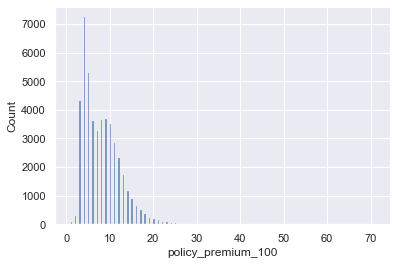

In [1244]:
sns.histplot(x=df_total[var].dropna())
plt.show()

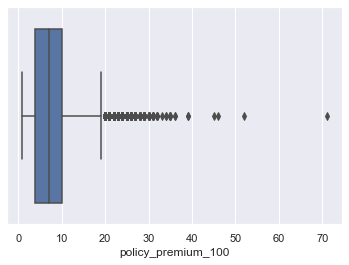

In [1245]:
sns.boxplot(x=df_total[var].dropna())
plt.show()

In [1246]:
df_total[var].dropna().quantile([0, 0.05, .1, .25, .5, .75, 0.8, 0.85, 0.9, .95, 1])

0.00     1.0
0.05     3.0
0.10     3.0
0.25     4.0
0.50     7.0
0.75    10.0
0.80    11.0
0.85    12.0
0.90    13.0
0.95    16.0
1.00    71.0
Name: policy_premium_100, dtype: float64

In [1247]:
q_95 = df_total[var].dropna().quantile(.95)
print(q_95)

df_total[var] = np.where(df_total[var].isna(),np.nan,
                         np.where(df_total[var]>=int(q_95),int(q_95),df_total[var]))

16.0


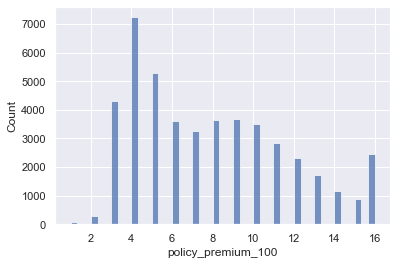

In [1248]:
sns.histplot(x=df_total[var].dropna())
plt.show()

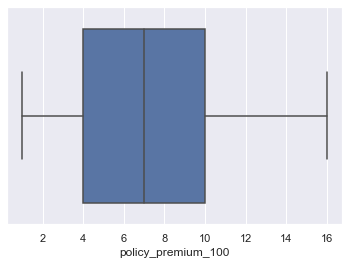

In [1249]:
sns.boxplot(x=df_total[var].dropna())
plt.show()

In [1250]:
df_total[var] = np.where(df_total[var].isna(),-1,df_total[var])

In [1251]:
data = woe(df_total,var)
data.sort_index().head()
#data

N   Y  total    porc_N  porc_Y  porc_total      woe
policy_premium_100                                                        
-1.0                9124  38   9162   99.5852  0.4148     16.5322  29.4073
 1.0                  85   1     86   98.8372  1.1628      0.1552 -74.4354
 2.0                 276   0    276  100.0000  0.0000      0.4980      inf
 3.0                4303  14   4317   99.6757  0.3243      7.7897  54.1006
 4.0                7217  19   7236   99.7374  0.2626     13.0569  75.2751

In [1252]:
data.to_clipboard(index=True,header=True)

In [1253]:
df_total.set_index(var,inplace=True)

In [1254]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55419, 88)


policy_premium_100 fraud  claim_amount  policy_coverage_1000  \
0                -1.0     N        826.33                   NaN   
1                -1.0     N       2178.60                   NaN   
2                -1.0     N        717.00                   NaN   
3                -1.0     N       4280.69                   NaN   
4                -1.0     N       1709.46                   NaN   

  policy_coverage_type  woe_diff_days_claim_reg_ocu  diff_days_claim_reg_ocu  \
0           #000000000                      22.4187                        7   
1           #000000000                     -85.7070                       45   
2           #000000000                     114.6187                       33   
3           #000000000                      22.4187                        7   
4           #000000000                     114.6187                       27   

   woe_claim_postal_code  woe_claim_postal_code_cat_medium_fraud  \
0               128.4157                                       0   
1                -3.4511                                       1   
2               128.4157                                       0   
3               128.4157                                       0   
4               128.4157                                       0   

   woe_claim_postal_code_cat_high_fraud  woe_claim_cause  \
0                                     0          62.2094   
1                                     0          62.2094   
2                                     0          62.2094   
3                                     0          62.2094   
4                                     0          62.2094   

   claim_cause_cat_other  claim_cause_cat_remaining_cats  woe_claim_liable  \
0                      0                               0           57.2768   
1                      0                               0           57.2768   
2                      0                               0           57.2768   
3                      0                               0           57.2768   
4                      0                               0           57.2768   

   claim_liable_cat_N  woe_claim_num_injured  claim_num_injured  \
0                   0                -3.1404                  0   
1                   0                -3.1404                  0   
2                   0                -3.1404                  0   
3                   0                -3.1404                  0   
4                   0                -3.1404                  0   

   woe_claim_num_third_parties  claim_num_third_parties  \
0                      56.6264                        1   
1                      56.6264                        1   
2                      56.6264                        1   
3                     112.6470                        2   
4                      56.6264                        1   

   woe_claim_num_vehicles  claim_num_vehicles  woe_claim_police  \
0                -23.5123                   3           31.5452   
1                -23.5123                   3           31.5452   
2                 43.4522                   2           31.5452   
3                -83.8970                   4           31.5452   
4                -23.5123                   3           31.5452   

   claim_police_cat_Y  woe_claim_alcohol  woe_claim_language  \
0                   0             0.6519             45.9729   
1                   0             0.6519            -64.2040   
2                   0             0.6519            -64.2040   
3                   0             0.6519            -64.2040   
4                   0             0.6519            -64.2040   

   claim_language_cat_1.0  woe_claim_vehicle_brand  \
0                       0                  18.3615   
1                       1                  18.3615   
2                       1                  18.3615   
3                       1                  18.3615   
4                       1                  18.3615   

   woe_cl

In [1255]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
policy_premium_100                                                     
 16.0                   7412328.92       249310.18                12.35
-1.0                   13874211.70       238208.05                11.80
 10.0                   7673430.95       166118.74                 8.23
 12.0                   5603505.96       159319.82                 7.89
 13.0                   4125782.86       153714.01                 7.61

In [1256]:
### 

In [1257]:
table.to_clipboard(index=True,header=True)

In [1258]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [1259]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [1260]:
data[var].dtype

dtype('float64')

In [1261]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [1262]:
temp.index.dtype

dtype('float64')

In [1263]:
dict_woe.update(temp.to_dict())

In [1264]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [1265]:
len(dict_woe)

38

In [1266]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [1267]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [1268]:
columns_f = [col for col in data.columns if (var not in col)]+['woe_'+var]+[var]
print(len(columns_f))
print(data.shape)

data = data.reindex(columns=columns_f)

89
(55419, 89)


In [1269]:
data[var] = np.where(data[var]==-1, np.nan, data[var])

In [1270]:
data[var].isna().sum()

9162

In [1271]:
data.drop('woe',axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 88)


fraud  claim_amount  policy_coverage_1000 policy_coverage_type  \
0     N        826.33                   NaN           #000000000   
1     N       2178.60                   NaN           #000000000   
2     N        717.00                   NaN           #000000000   
3     N       4280.69                   NaN           #000000000   
4     N       1709.46                   NaN           #000000000   

   woe_diff_days_claim_reg_ocu  diff_days_claim_reg_ocu  \
0                      22.4187                        7   
1                     -85.7070                       45   
2                     114.6187                       33   
3                      22.4187                        7   
4                     114.6187                       27   

   woe_claim_postal_code  woe_claim_postal_code_cat_medium_fraud  \
0               128.4157                                       0   
1                -3.4511                                       1   
2               128.4157                                       0   
3               128.4157                                       0   
4               128.4157                                       0   

   woe_claim_postal_code_cat_high_fraud  woe_claim_cause  \
0                                     0          62.2094   
1                                     0          62.2094   
2                                     0          62.2094   
3                                     0          62.2094   
4                                     0          62.2094   

   claim_cause_cat_other  claim_cause_cat_remaining_cats  woe_claim_liable  \
0                      0                               0           57.2768   
1                      0                               0           57.2768   
2                      0                               0           57.2768   
3                      0                               0           57.2768   
4                      0                               0           57.2768   

   claim_liable_cat_N  woe_claim_num_injured  claim_num_injured  \
0                   0                -3.1404                  0   
1                   0                -3.1404                  0   
2                   0                -3.1404                  0   
3                   0                -3.1404                  0   
4                   0                -3.1404                  0   

   woe_claim_num_third_parties  claim_num_third_parties  \
0                      56.6264                        1   
1                      56.6264                        1   
2                      56.6264                        1   
3                     112.6470                        2   
4                      56.6264                        1   

   woe_claim_num_vehicles  claim_num_vehicles  woe_claim_police  \
0                -23.5123                   3           31.5452   
1                -23.5123                   3           31.5452   
2                 43.4522                   2           31.5452   
3                -83.8970                   4           31.5452   
4                -23.5123                   3           31.5452   

   claim_police_cat_Y  woe_claim_alcohol  woe_claim_language  \
0                   0             0.6519             45.9729   
1                   0             0.6519            -64.2040   
2                   0             0.6519            -64.2040   
3                   0             0.6519            -64.2040   
4                   0             0.6519            -64.2040   

   claim_language_cat_1.0  woe_claim_vehicle_brand  \
0                       0                  18.3615   
1                       1                  18.3615   
2                       1                  18.3615   
3                       1                  18.3615   
4                       1                  18.3615   

   woe_claim_vehicle_brand_cat_medium_fraud  \
0                                         1   
1                                 

In [1272]:
#############

In [1273]:
var = 'policy_coverage_1000'

In [1274]:
df_total[var].dtype

dtype('float64')

In [1275]:
df_total[var].isna().sum()

28397

In [1276]:
print(df_total[var].min())
print(df_total[var].max())

1.0
148.0


In [1277]:
df_total.loc[~df_total[var].isna(),var].head()

4693    10.0
7361    18.0
7362    22.0
8009    19.0
9173     4.0
Name: policy_coverage_1000, dtype: float64

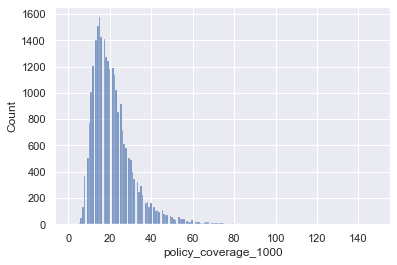

In [1278]:
sns.histplot(x=df_total[var].dropna())
plt.show()

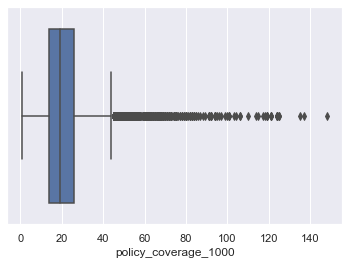

In [1279]:
sns.boxplot(x=df_total[var].dropna())
plt.show()

In [1280]:
df_total[var].dropna().quantile([0, 0.05, .1, .25, .5, .75, 0.8, 0.85, 0.9, .95, 1])

0.00      1.0
0.05     10.0
0.10     11.0
0.25     14.0
0.50     19.0
0.75     26.0
0.80     28.0
0.85     30.0
0.90     34.0
0.95     42.0
1.00    148.0
Name: policy_coverage_1000, dtype: float64

In [1281]:
q_95 = df_total[var].dropna().quantile(.95)
print(q_95)

df_total[var] = np.where(df_total[var].isna(),np.nan,
                         np.where(df_total[var]>=int(q_95),int(q_95),df_total[var]))

42.0


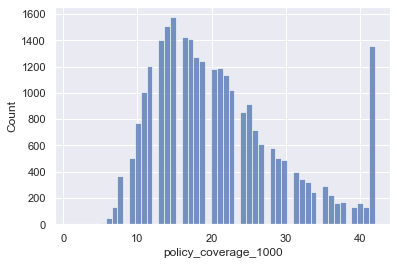

In [1282]:
sns.histplot(x=df_total[var].dropna())
plt.show()

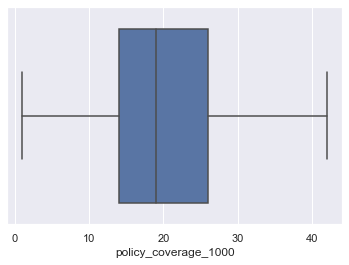

In [1283]:
sns.boxplot(x=df_total[var].dropna())
plt.show()

In [1284]:
df_total[var] = np.where(df_total[var].isna(),-1,df_total[var])

In [1285]:
data = woe(df_total,var)
data.sort_index().head()
#data

N   Y  total    porc_N   porc_Y  porc_total  \
policy_coverage_1000                                                    
-1.0                  28298  99  28397   99.6514   0.3486     51.2405   
 1.0                      1   0      1  100.0000   0.0000      0.0018   
 2.0                      6   0      6  100.0000   0.0000      0.0108   
 3.0                      1   0      1  100.0000   0.0000      0.0018   
 4.0                      5   1      6   83.3333  16.6667      0.0108   

                           woe  
policy_coverage_1000            
-1.0                   46.8422  
 1.0                       inf  
 2.0                       inf  
 3.0                       inf  
 4.0                 -357.7567

In [1286]:
data.to_clipboard(index=True,header=True)

In [1287]:
df_total.set_index(var,inplace=True)

In [1288]:
data = df_total.join(data[['woe']])
data.reset_index(drop=False,inplace=True)
print(data.shape)
data.head()

(55419, 89)


policy_coverage_1000 fraud  claim_amount policy_coverage_type  \
0                  -1.0     N        826.33           #000000000   
1                  -1.0     N       2178.60           #000000000   
2                  -1.0     N        717.00           #000000000   
3                  -1.0     N       4280.69           #000000000   
4                  -1.0     N       1709.46           #000000000   

   woe_diff_days_claim_reg_ocu  diff_days_claim_reg_ocu  \
0                      22.4187                        7   
1                     -85.7070                       45   
2                     114.6187                       33   
3                      22.4187                        7   
4                     114.6187                       27   

   woe_claim_postal_code  woe_claim_postal_code_cat_medium_fraud  \
0               128.4157                                       0   
1                -3.4511                                       1   
2               128.4157                                       0   
3               128.4157                                       0   
4               128.4157                                       0   

   woe_claim_postal_code_cat_high_fraud  woe_claim_cause  \
0                                     0          62.2094   
1                                     0          62.2094   
2                                     0          62.2094   
3                                     0          62.2094   
4                                     0          62.2094   

   claim_cause_cat_other  claim_cause_cat_remaining_cats  woe_claim_liable  \
0                      0                               0           57.2768   
1                      0                               0           57.2768   
2                      0                               0           57.2768   
3                      0                               0           57.2768   
4                      0                               0           57.2768   

   claim_liable_cat_N  woe_claim_num_injured  claim_num_injured  \
0                   0                -3.1404                  0   
1                   0                -3.1404                  0   
2                   0                -3.1404                  0   
3                   0                -3.1404                  0   
4                   0                -3.1404                  0   

   woe_claim_num_third_parties  claim_num_third_parties  \
0                      56.6264                        1   
1                      56.6264                        1   
2                      56.6264                        1   
3                     112.6470                        2   
4                      56.6264                        1   

   woe_claim_num_vehicles  claim_num_vehicles  woe_claim_police  \
0                -23.5123                   3           31.5452   
1                -23.5123                   3           31.5452   
2                 43.4522                   2           31.5452   
3                -83.8970                   4           31.5452   
4                -23.5123                   3           31.5452   

   claim_police_cat_Y  woe_claim_alcohol  woe_claim_language  \
0                   0             0.6519             45.9729   
1                   0             0.6519            -64.2040   
2                   0             0.6519            -64.2040   
3                   0             0.6519            -64.2040   
4                   0             0.6519            -64.2040   

   claim_language_cat_1.0  woe_claim_vehicle_brand  \
0                       0                  18.3615   
1                       1                  18.3615   
2                       1                  18.3615   
3                       1                  18.3615   
4                       1                  18.3615   

   woe_claim_vehicle_brand_cat_medium_fraud  \
0                                         1   
1                                  

In [1289]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
policy_coverage_1000                                                     
-1.0                     51901957.37       454581.77                22.51
 42.0                     4348196.60       165180.41                 8.18
 14.0                     3336993.28        95867.59                 4.75
 18.0                     2764883.59        90843.91                 4.50
 24.0                     2072587.40        84915.97                 4.21

In [1290]:
### 

In [1291]:
table.to_clipboard(index=True,header=True)

In [1292]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [1293]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [1294]:
data[var].dtype

dtype('float64')

In [1295]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [1296]:
temp.index.dtype

dtype('float64')

In [1297]:
dict_woe.update(temp.to_dict())

In [1298]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [1299]:
len(dict_woe)

39

In [1300]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [1301]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

In [1302]:
columns_f = [col for col in data.columns if (var not in col)]+['woe_'+var]+[var]
print(len(columns_f))
print(data.shape)

data = data.reindex(columns=columns_f)

90
(55419, 90)


In [1303]:
data[var] = np.where(data[var]==-1, np.nan, data[var])

In [1304]:
data[var].isna().sum()

28397

In [1305]:
data.drop('woe',axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 89)


fraud  claim_amount policy_coverage_type  woe_diff_days_claim_reg_ocu  \
0     N        826.33           #000000000                      22.4187   
1     N       2178.60           #000000000                     -85.7070   
2     N        717.00           #000000000                     114.6187   
3     N       4280.69           #000000000                      22.4187   
4     N       1709.46           #000000000                     114.6187   

   diff_days_claim_reg_ocu  woe_claim_postal_code  \
0                        7               128.4157   
1                       45                -3.4511   
2                       33               128.4157   
3                        7               128.4157   
4                       27               128.4157   

   woe_claim_postal_code_cat_medium_fraud  \
0                                       0   
1                                       1   
2                                       0   
3                                       0   
4                                       0   

   woe_claim_postal_code_cat_high_fraud  woe_claim_cause  \
0                                     0          62.2094   
1                                     0          62.2094   
2                                     0          62.2094   
3                                     0          62.2094   
4                                     0          62.2094   

   claim_cause_cat_other  claim_cause_cat_remaining_cats  woe_claim_liable  \
0                      0                               0           57.2768   
1                      0                               0           57.2768   
2                      0                               0           57.2768   
3                      0                               0           57.2768   
4                      0                               0           57.2768   

   claim_liable_cat_N  woe_claim_num_injured  claim_num_injured  \
0                   0                -3.1404                  0   
1                   0                -3.1404                  0   
2                   0                -3.1404                  0   
3                   0                -3.1404                  0   
4                   0                -3.1404                  0   

   woe_claim_num_third_parties  claim_num_third_parties  \
0                      56.6264                        1   
1                      56.6264                        1   
2                      56.6264                        1   
3                     112.6470                        2   
4                      56.6264                        1   

   woe_claim_num_vehicles  claim_num_vehicles  woe_claim_police  \
0                -23.5123                   3           31.5452   
1                -23.5123                   3           31.5452   
2                 43.4522                   2           31.5452   
3                -83.8970                   4           31.5452   
4                -23.5123                   3           31.5452   

   claim_police_cat_Y  woe_claim_alcohol  woe_claim_language  \
0                   0             0.6519             45.9729   
1                   0             0.6519            -64.2040   
2                   0             0.6519            -64.2040   
3                   0             0.6519            -64.2040   
4                   0             0.6519            -64.2040   

   claim_language_cat_1.0  woe_claim_vehicle_brand  \
0                       0                  18.3615   
1                       1                  18.3615   
2                       1                  18.3615   
3                       1                  18.3615   
4                       1                  18.3615   

   woe_claim_vehicle_brand_cat_medium_fraud  \
0                                         1   
1                                         1   
2                                         1   
3                                         1   
4                        

In [1306]:
#############

In [1307]:
var = 'policy_coverage_type'

In [1308]:
len(df_total[var].unique())

73

In [1309]:
data = woe(df_total,var)
# data.sort_index()
# data.sort_values(by='porc_total',ascending=False)
data

N   Y  total    porc_N  porc_Y  porc_total       woe
policy_coverage_type                                                          
#111010011               11   1     12   91.6667  8.3333      0.0217 -278.9110
#111000000               79   3     82   96.3415  3.6585      0.1480 -191.6169
#111010001               33   1     34   97.0588  2.9412      0.0614 -169.0497
#110011010              107   2    109   98.1651  1.8349      0.1967 -120.7323
#111111001              113   2    115   98.2609  1.7391      0.2075 -115.2764
#000011100               68   1     69   98.5507  1.4493      0.1245  -96.7497
#110010110               73   1     74   98.6486  1.3514      0.1335  -89.6545
#111110001             1838  25   1863   98.6581  1.3419      3.3617  -88.9447
#110111110              149   2    151   98.6755  1.3245      0.2725  -87.6206
#111110011              758  10    768   98.6979  1.3021      1.3858  -85.8907
#110110011              849  11    860   98.7209  1.2791      1.5518  -84.0841
#111110100             1005  13   1018   98.7230  1.2770      1.8369  -83.9211
#110010010              358   4    362   98.8950  1.1050      0.6532  -69.2766
#110111011              101   1    102   99.0196  0.9804      0.1841  -57.1884
#110110010             2191  20   2211   99.0954  0.9046      3.9896  -49.0624
#111011000              330   3    333   99.0991  0.9009      0.6009  -48.6524
#111111110              222   2    224   99.1071  0.8929      0.4042  -47.7475
#110111010              485   4    489   99.1820  0.8180      0.8824  -38.9150
#111011010              243   2    245   99.1837  0.8163      0.4421  -38.7091
#000011000              137   1    138   99.2754  0.7246      0.2490  -26.7024
#111110000             7927  56   7983   99.2985  0.7015     14.4048  -23.4327
#111010010              467   3    470   99.3617  0.6383      0.8481  -13.9288
#111111000             1634  10   1644   99.3917  0.6083      2.9665   -9.0804
#000111001              189   1    190   99.4737  0.5263      0.3428    5.4742
#111110010             3232  17   3249   99.4768  0.5232      5.8626    6.0638
#111010000             1218   6   1224   99.5098  0.4902      2.2086   12.6201
#110110110              415   2    417   99.5204  0.4796      0.7524   14.8127
#000111100              450   2    452   99.5575  0.4425      0.8156   22.9096
#000000000             9113  38   9151   99.5847  0.4153     16.5124   29.2866
#111111010              994   4    998   99.5992  0.4008      1.8008   32.8438
#000010000             1514   6   1520   99.6053  0.3947      2.7427   34.3746
#000110001             2056   7   2063   99.6607  0.3393      3.7226   49.5603
#000110000            11646  38  11684   99.6748  0.3252     21.0830   53.8127
#000111000              972   3    975   99.6923  0.3077      1.7593   59.3739
#000010100              334   1    335   99.7015  0.2985      0.6045   62.4136
#111111100              388   1    389   99.7429  0.2571      0.7019   77.4001
#111110110              515   1    516   99.8062  0.1938      0.9311  105.7162
#000110100             1857   3   1860   99.8387  0.1613      3.3562  124.1100
#111011011                2   0      2  100.0000  0.0000      0.0036       inf
#111011100               77   0     77  100.0000  0.0000      0.1389       inf
#111011110               36   0     36  100.0000  0.0000      0.0650       inf
#111100000                2   0      2  100.0000  0.0000      0.0036       inf
#111100001                4   0      4  100.0000  0.0000      0.0072       inf
#100111011               28   0     28  100.0000  0.0000      0.0505       inf
#100111010                8   0      8  100.0000  0.0000      0.0144       inf
#110011110               37   0     37  100.0000  0.0000      0.0668       inf
#110000010                2   0      2  100.0000  0.0000      0.0036       inf
#000010001               32   0     32  100.0000  0.0000      0.0577       inf
#100110010               96   0     96  100.0000  0.0000      0.1732       i

In [1310]:
data[data['woe']==np.inf].shape[0]

35

In [1311]:
data.to_clipboard(index=True,header=True)

In [1312]:
df_total.set_index(var,inplace=True)

In [1313]:
data = df_total.join(data[['woe']])
data.reset_index(inplace=True)
print(data.shape)
data.head()

(55419, 90)


policy_coverage_type fraud  claim_amount  woe_diff_days_claim_reg_ocu  \
0           #000000000     N        826.33                      22.4187   
1           #000000000     N       2178.60                     -85.7070   
2           #000000000     N        717.00                     114.6187   
3           #000000000     N       4280.69                      22.4187   
4           #000000000     N       1709.46                     114.6187   

   diff_days_claim_reg_ocu  woe_claim_postal_code  \
0                        7               128.4157   
1                       45                -3.4511   
2                       33               128.4157   
3                        7               128.4157   
4                       27               128.4157   

   woe_claim_postal_code_cat_medium_fraud  \
0                                       0   
1                                       1   
2                                       0   
3                                       0   
4                                       0   

   woe_claim_postal_code_cat_high_fraud  woe_claim_cause  \
0                                     0          62.2094   
1                                     0          62.2094   
2                                     0          62.2094   
3                                     0          62.2094   
4                                     0          62.2094   

   claim_cause_cat_other  claim_cause_cat_remaining_cats  woe_claim_liable  \
0                      0                               0           57.2768   
1                      0                               0           57.2768   
2                      0                               0           57.2768   
3                      0                               0           57.2768   
4                      0                               0           57.2768   

   claim_liable_cat_N  woe_claim_num_injured  claim_num_injured  \
0                   0                -3.1404                  0   
1                   0                -3.1404                  0   
2                   0                -3.1404                  0   
3                   0                -3.1404                  0   
4                   0                -3.1404                  0   

   woe_claim_num_third_parties  claim_num_third_parties  \
0                      56.6264                        1   
1                      56.6264                        1   
2                      56.6264                        1   
3                     112.6470                        2   
4                      56.6264                        1   

   woe_claim_num_vehicles  claim_num_vehicles  woe_claim_police  \
0                -23.5123                   3           31.5452   
1                -23.5123                   3           31.5452   
2                 43.4522                   2           31.5452   
3                -83.8970                   4           31.5452   
4                -23.5123                   3           31.5452   

   claim_police_cat_Y  woe_claim_alcohol  woe_claim_language  \
0                   0             0.6519             45.9729   
1                   0             0.6519            -64.2040   
2                   0             0.6519            -64.2040   
3                   0             0.6519            -64.2040   
4                   0             0.6519            -64.2040   

   claim_language_cat_1.0  woe_claim_vehicle_brand  \
0                       0                  18.3615   
1                       1                  18.3615   
2                       1                  18.3615   
3                       1                  18.3615   
4                       1                  18.3615   

   woe_claim_vehicle_brand_cat_medium_fraud  \
0                                         1   
1                                         1   
2                                         1   
3                                         1   
4                        

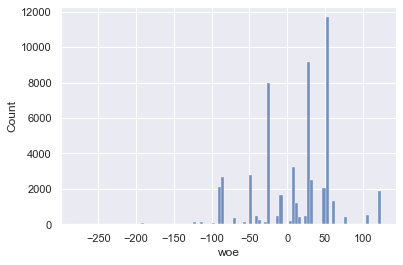

In [1314]:
sns.histplot(x=data.loc[(data['woe']!=np.inf) &
                        (data['woe']!=-np.inf),'woe'])
plt.show()

In [1315]:
table = pd.pivot_table(data, 
                       values='claim_amount', 
                       index=var,
                       columns='fraud', aggfunc=np.sum).rename_axis(None, axis=1).rename(columns={'N':'N_claim_amount',
                                                                                                  'Y':'Y_claim_amount'})

table['porc_Y_claim_amount'] = round(table['Y_claim_amount']/table['Y_claim_amount'].sum()*100,2)

table = table.sort_values(by='porc_Y_claim_amount',ascending=False)
table.head()

N_claim_amount  Y_claim_amount  porc_Y_claim_amount
policy_coverage_type                                                     
#111110000               19231577.09       404701.24                20.04
#000000000               13853507.39       238208.05                11.80
#111110001                4825202.14       209695.44                10.38
#000110000               22764310.69       140172.06                 6.94
#110110010                4666865.41       127019.44                 6.29

In [1316]:
### 

In [1317]:
table.to_clipboard(index=True,header=True)

In [1318]:
min_woe = min(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])
max_woe = max(data.loc[(data['woe']!=-np.inf) & (data['woe']!=np.inf),'woe'])

data['woe_'+var] = np.where(data['woe']==-np.inf,min_woe,
                       np.where(data['woe']==np.inf,max_woe,
                                data['woe']))

In [1319]:
print(data[data['woe_'+var]==-np.inf].shape[0])
print(data[data['woe_'+var]==np.inf].shape[0])

0
0


In [1320]:
data[var].dtype

dtype('O')

In [1321]:
temp = data[['woe_'+var,var]].copy()
temp = temp.drop_duplicates()
temp.set_index(var,inplace=True)

In [1322]:
temp.index.dtype

dtype('O')

In [1323]:
dict_woe.update(temp.to_dict())

In [1324]:
dict_woe[var] = dict_woe.pop('woe_'+var)

In [1325]:
len(dict_woe)

40

In [1326]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')

In [1327]:
with open(path+'dict_woe_train.json', 'w') as fp:
    json.dump(dict_woe, fp)

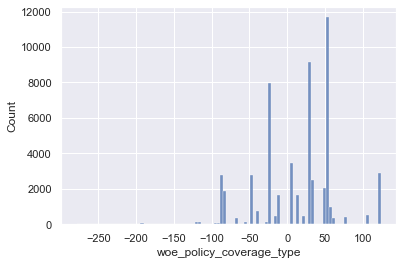

In [1328]:
sns.histplot(x=data['woe_'+var])
plt.show()

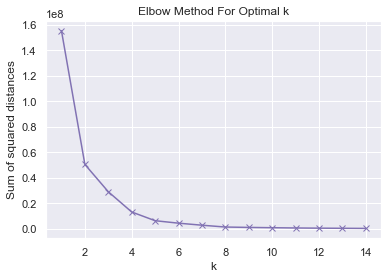

In [1329]:
tabla=pd.DataFrame({'woe':data['woe_'+var]})

SEED = 123

#Número de cluster óptimo
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=SEED)
    km = km.fit(tabla)
    sum_of_squared_distances.append(km.inertia_)
#     centroids = km.cluster_centers_
#     print(centroids)

plt.plot(K, sum_of_squared_distances, 'mx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [1330]:
km = KMeans(n_clusters=3, random_state=SEED)
km = km.fit(tabla)
km.cluster_centers_
km.labels_

array([2, 2, 2, ..., 0, 0, 0])

In [1331]:
breaks = jenkspy.jenks_breaks(data['woe_'+var], nb_class=3)
breaks

[-278.911, -9.0804, 77.4001, 124.11]

In [1332]:
dict_woe_breaks.update({var:breaks})

In [1333]:
with open(path+'dict_woe_train_breaks.json', 'w') as fp:
    json.dump(dict_woe_breaks, fp)

In [1334]:
data['woe_'+var+'_cat'] = pd.cut(data['woe_'+var],
                                 bins=breaks,
                                 labels=['high_fraud', 'medium_fraud', 'low_fraud'],
                                 include_lowest=True)

data['woe_'+var+'_cat'].value_counts(normalize=True)

medium_fraud    0.589094
high_fraud      0.349266
low_fraud       0.061640
Name: woe_policy_coverage_type_cat, dtype: float64

In [1335]:
data['woe_'+var+'_cat'].value_counts(normalize=False)

medium_fraud    32647
high_fraud      19356
low_fraud        3416
Name: woe_policy_coverage_type_cat, dtype: int64

In [1336]:
'woe_'+var+'_cat'

'woe_policy_coverage_type_cat'

In [1337]:
dict_categ = {'woe_policy_coverage_type_cat':['low_fraud','medium_fraud','high_fraud']}

data = categorical(data,dict_categ)

In [1338]:
# Get dummies
data = pd.get_dummies(data,
                      columns=data.columns[
                                           np.where(data.dtypes == 'category')
                                           ],
                      drop_first=True
                      )

In [1339]:
data.drop(['woe',var],axis=1,inplace=True)

df_total = data.copy()

print(df_total.shape)
df_total.head()

(55419, 91)


fraud  claim_amount  woe_diff_days_claim_reg_ocu  diff_days_claim_reg_ocu  \
0     N        826.33                      22.4187                        7   
1     N       2178.60                     -85.7070                       45   
2     N        717.00                     114.6187                       33   
3     N       4280.69                      22.4187                        7   
4     N       1709.46                     114.6187                       27   

   woe_claim_postal_code  woe_claim_postal_code_cat_medium_fraud  \
0               128.4157                                       0   
1                -3.4511                                       1   
2               128.4157                                       0   
3               128.4157                                       0   
4               128.4157                                       0   

   woe_claim_postal_code_cat_high_fraud  woe_claim_cause  \
0                                     0          62.2094   
1                                     0          62.2094   
2                                     0          62.2094   
3                                     0          62.2094   
4                                     0          62.2094   

   claim_cause_cat_other  claim_cause_cat_remaining_cats  woe_claim_liable  \
0                      0                               0           57.2768   
1                      0                               0           57.2768   
2                      0                               0           57.2768   
3                      0                               0           57.2768   
4                      0                               0           57.2768   

   claim_liable_cat_N  woe_claim_num_injured  claim_num_injured  \
0                   0                -3.1404                  0   
1                   0                -3.1404                  0   
2                   0                -3.1404                  0   
3                   0                -3.1404                  0   
4                   0                -3.1404                  0   

   woe_claim_num_third_parties  claim_num_third_parties  \
0                      56.6264                        1   
1                      56.6264                        1   
2                      56.6264                        1   
3                     112.6470                        2   
4                      56.6264                        1   

   woe_claim_num_vehicles  claim_num_vehicles  woe_claim_police  \
0                -23.5123                   3           31.5452   
1                -23.5123                   3           31.5452   
2                 43.4522                   2           31.5452   
3                -83.8970                   4           31.5452   
4                -23.5123                   3           31.5452   

   claim_police_cat_Y  woe_claim_alcohol  woe_claim_language  \
0                   0             0.6519             45.9729   
1                   0             0.6519            -64.2040   
2                   0             0.6519            -64.2040   
3                   0             0.6519            -64.2040   
4                   0             0.6519            -64.2040   

   claim_language_cat_1.0  woe_claim_vehicle_brand  \
0                       0                  18.3615   
1                       1                  18.3615   
2                       1                  18.3615   
3                       1                  18.3615   
4                       1                  18.3615   

   woe_claim_vehicle_brand_cat_medium_fraud  \
0                                         1   
1                                         1   
2                                         1   
3                                         1   
4                                         1   

   woe_claim_vehicle_brand_cat_high_fraud  woe_claim_vehicle_type  \
0                                       0                  4.0443

In [1340]:
# df_total2 = df_total.copy()
# dict_woe2 = dict_woe.copy()
# dict_woe_breaks2 = dict_woe_breaks.copy()

In [1341]:
#############

In [1342]:
var = 'fraud'

In [1343]:
df_total[var] = np.where(df_total[var]=='Y',1,0)

In [1344]:
df_total[var].value_counts()

0    55111
1      308
Name: fraud, dtype: int64

In [1345]:
df_total2 = df_total.copy()

In [1346]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')
path

'C:\\Users\\Sonita\\Documents\\KU_Leuven\\Subjects\\2021-1\\Advance_Analytics\\Assignments\\Assignment_1\\Data\\preprocessing\\'

In [1347]:
df_total.to_csv(path+'data_preprocessed_train.csv',sep='|',index=False)

# Bivariate

In [ ]:
# target = 'fraud'

In [ ]:
# sns.histplot(x=df_total.loc[df_total[target]=='Y','claim_amount'])
# plt.show()

In [ ]:
# sns.histplot(x=df_total.loc[df_total[target]=='N','claim_amount'])
# plt.show()

In [ ]:
# df_total.loc[df_total['fraud']=='Y','claim_amount'].quantile([.1, .25, .5, .75, .95])

In [ ]:
# df_total.loc[df_total['fraud']=='N','claim_amount'].quantile([.1, .25, .5, .75, .95])

In [ ]:
# df_total[target].value_counts()

In [ ]:
# variable = 'claim_vehicle_id'

In [ ]:
# df_total.loc[df_total[variable].isna(),target].value_counts()

In [ ]:
# df_total.loc[~df_total[variable].isna(),target].value_counts()

In [ ]:
# df_total.loc[df_total[target]=='Y',:].shape

In [ ]:
# variable = 'claim_cause'

In [ ]:
# df_total.loc[df_total[target]=='Y',variable].head()

In [ ]:
# df_total.loc[df_total[target]=='Y',variable].value_counts()

In [ ]:
# df_total.loc[df_total[target]=='N',variable].value_counts()

In [ ]:
# len(df_total.loc[df_total[target]=='Y',variable].unique())